# Data Loading

In [2]:
import os
from typing import Tuple, Callable, Dict, Optional, List

import pandas as pd
import numpy as np
import scipy.sparse as sp
from tqdm import tqdm
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
import logging
import scipy

from Evaluation.Evaluator import EvaluatorHoldout


In [3]:
URM = pd.read_csv("./data/data_train.csv")
ICM = pd.read_csv("./data/data_ICM_metadata.csv")

In [4]:
unique_users = URM.user_id.unique()
max_user_id = unique_users.max()
min_user_id = unique_users.min()
num_users = unique_users.size
print(f"Max User ID: {max_user_id}, Min User ID: {min_user_id}, Number of IDs: {num_users}")

unique_items = ICM.item_id.unique()
max_item_id = ICM.item_id.max()
min_item_id = ICM.item_id.min()
num_items = unique_items.size
unique_features = ICM.feature_id.unique()
num_features = unique_features.size
min_features_id = ICM.feature_id.min()
max_features_id = ICM.feature_id.max()
print(f"Max Item ID: {max_item_id}, Min Item ID: {min_item_id}, Number of IDs: {num_items}")
print(f"Max Feature ID: {max_features_id}, Min Item ID: {min_features_id}, Number of IDs: {num_features}")

Max User ID: 35735, Min User ID: 0, Number of IDs: 35736
Max Item ID: 38120, Min Item ID: 0, Number of IDs: 38121
Max Feature ID: 94330, Min Item ID: 0, Number of IDs: 94331


In [5]:
print("URM")
print(URM.head())
print("\nICM")
print(ICM.head())

URM
   user_id  item_id  data
0        0        0   1.0
1        0        2   1.0
2        0      120   1.0
3        0      128   1.0
4        0      211   1.0

ICM
   item_id  feature_id  data
0     2519           0   1.0
1     2642           0   1.0
2     3316           0   1.0
3     3400           0   1.0
4     3472           0   1.0


In [6]:
URM.user_id

0              0
1              0
2              0
3              0
4              0
           ...  
1764602    35735
1764603    35735
1764604    35735
1764605    35735
1764606    35735
Name: user_id, Length: 1764607, dtype: int64

In [7]:
def dataset_splits(ratings, num_users, num_items, validation_percentage: float, testing_percentage: float):
    seed = 1234

    # Construct the whole URM as a sparse matrix
    urm_all = sp.csr_matrix((ratings.data, (ratings.user_id, ratings.item_id)),
                            shape=(num_users, num_items))

    # Split into train + validation and test sets
    train_val_indices, test_indices = train_test_split(
        np.arange(len(ratings)),
        test_size=testing_percentage,
        shuffle=True,
        random_state=seed
    )
    
    # Split train + validation into train and validation
    train_indices, val_indices = train_test_split(
        train_val_indices,
        test_size=validation_percentage / (1 - testing_percentage),
        shuffle=True,
        random_state=seed
    )
    
    # Get user, item, and rating data for each set
    train_data = ratings.iloc[train_indices]
    val_data = ratings.iloc[val_indices]
    test_data = ratings.iloc[test_indices]
    
    # Construct sparse matrices
    urm_train = sp.csr_matrix((train_data.data, (train_data.user_id, train_data.item_id)), 
                              shape=(num_users, num_items))
    urm_validation = sp.csr_matrix((val_data.data, (val_data.user_id, val_data.item_id)), 
                                   shape=(num_users, num_items))
    urm_test = sp.csr_matrix((test_data.data, (test_data.user_id, test_data.item_id)), 
                             shape=(num_users, num_items))

    return urm_all, urm_train, urm_validation, urm_test


In [15]:
urm_all, urm_train, urm_validation, urm_test = dataset_splits(URM, 
                                                     num_users=num_users, 
                                                     num_items=num_items, 
                                                     validation_percentage=0.10, 
                                                     testing_percentage=0.20)

In [16]:
icm_matrix = sp.csr_matrix((ICM.data, (ICM.item_id, ICM.feature_id)), 
                           shape=(num_items, num_features))


# Support Classes

## Plot Graphs

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class EnhancedEvaluator(EvaluatorHoldout):
    """Extended Evaluator with Custom Visualization Methods"""

    def _plot_grouped_average(self, data, group_size, xlabel, ylabel, title):
        """Helper function to plot grouped averages as a line chart."""
        num_groups = len(data) // group_size + (1 if len(data) % group_size != 0 else 0)
        grouped_averages = [
            np.mean(data[i * group_size: (i + 1) * group_size])
            for i in range(num_groups)
        ]

        plt.figure(figsize=(10, 5))
        plt.plot(range(num_groups), grouped_averages, marker="o", label="Grouped Average")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.show()

    def plot_correct_predictions_per_user(self, recommender_object, group_size=None):
        """Plot the number of correct predictions for each user."""
        user_correct_counts = []
        for user_id in self.users_to_evaluate:
            recommended_items = recommender_object.recommend(
                user_id, cutoff=self.max_cutoff, remove_seen_flag=True
            )
            relevant_items = self.get_user_relevant_items(user_id)

            correct_recommendations = np.intersect1d(recommended_items, relevant_items)
            user_correct_counts.append(len(correct_recommendations))

        if group_size:
            self._plot_grouped_average(
                user_correct_counts,
                group_size,
                xlabel="Grouped Users (100 per group)",
                ylabel="Average Number of Correct Predictions",
                title="Average Correct Predictions Per User (Grouped)",
            )
        else:
            plt.figure(figsize=(10, 5))
            plt.bar(range(len(user_correct_counts)), user_correct_counts)
            plt.xlabel("Users")
            plt.ylabel("Number of Correct Predictions")
            plt.title("Correct Predictions for Each User")
            plt.show()

    def plot_users_sorted_by_popularity(self, recommender_object, URM_train, group_size=None):
        """Plot users sorted by their popularity in the training set."""
        user_popularity = np.array(URM_train.sum(axis=1)).flatten()
        sorted_users = np.argsort(user_popularity)[::-1]

        user_correct_counts = []
        for user_id in sorted_users:
            if user_id not in self.users_to_evaluate:
                continue

            recommended_items = recommender_object.recommend(
                user_id, cutoff=self.max_cutoff, remove_seen_flag=True
            )
            relevant_items = self.get_user_relevant_items(user_id)

            correct_recommendations = np.intersect1d(recommended_items, relevant_items)
            user_correct_counts.append(len(correct_recommendations))

        if group_size:
            self._plot_grouped_average(
                user_correct_counts,
                group_size,
                xlabel="Grouped Users (100 per group, sorted by popularity)",
                ylabel="Average Number of Correct Predictions",
                title="Average Correct Predictions for Users Sorted by Popularity (Grouped)",
            )
        else:
            plt.figure(figsize=(10, 5))
            plt.bar(range(len(user_correct_counts)), user_correct_counts)
            plt.xlabel("Users (Sorted by Popularity in Training Set)")
            plt.ylabel("Number of Correct Predictions")
            plt.title("Correct Predictions for Users Sorted by Popularity")
            plt.show()

    def plot_users_sorted_by_icm_links(self, recommender_object, ICM, group_size=None):
        """Plot users sorted by the number of items they are linked to in the ICM."""
        user_icm_counts = []
        for user_id in range(ICM.shape[0]):
            user_icm_counts.append(np.count_nonzero(ICM[user_id].toarray()))

        sorted_users = np.argsort(user_icm_counts)[::-1]

        user_correct_counts = []
        for user_id in sorted_users:
            if user_id not in self.users_to_evaluate:
                continue

            recommended_items = recommender_object.recommend(
                user_id, cutoff=self.max_cutoff, remove_seen_flag=True
            )
            relevant_items = self.get_user_relevant_items(user_id)

            correct_recommendations = np.intersect1d(recommended_items, relevant_items)
            user_correct_counts.append(len(correct_recommendations))

        if group_size:
            self._plot_grouped_average(
                user_correct_counts,
                group_size,
                xlabel="Grouped Users (100 per group, sorted by ICM links)",
                ylabel="Average Number of Correct Predictions",
                title="Average Correct Predictions for Users Sorted by ICM Links (Grouped)",
            )
        else:
            plt.figure(figsize=(10, 5))
            plt.bar(range(len(user_correct_counts)), user_correct_counts)
            plt.xlabel("Users (Sorted by ICM Links)")
            plt.ylabel("Number of Correct Predictions")
            plt.title("Correct Predictions for Users Sorted by ICM Links")
            plt.show()
    def plot_items_ranked_by_popular_features(self, ICM, recommender_object, group_size=None):
        """
        Rank items by how many popular features they have and analyze recommendation performance.
        """
        # Step 1: Rank features by frequency
        feature_frequency = np.array(ICM.sum(axis=0)).flatten()  # Sum features across all items
        feature_ranks = np.argsort(feature_frequency)[::-1]  # Rank features by frequency (descending)

        # Step 2: Score items based on popular features
        item_scores = np.array(ICM[:, feature_ranks].sum(axis=1)).flatten()  # Score items based on popular features

        # Step 3: Sort users by item scores
        user_scores = []
        for user_id in self.users_to_evaluate:
            relevant_items = self.get_user_relevant_items(user_id)
            if len(relevant_items) > 0:
                user_scores.append(item_scores[relevant_items].mean())
            else:
                user_scores.append(0)  # If no relevant items, assign a score of 0

        sorted_users = np.argsort(user_scores)[::-1]  # Sort users by their average item scores

        # Step 4: Evaluate and plot
        user_correct_counts = []
        for user_id in sorted_users:
            recommended_items = recommender_object.recommend(
                user_id, cutoff=self.max_cutoff, remove_seen_flag=True
            )
            relevant_items = self.get_user_relevant_items(user_id)

            correct_recommendations = np.intersect1d(recommended_items, relevant_items)
            user_correct_counts.append(len(correct_recommendations))

        if group_size:
            self._plot_grouped_average(
                user_correct_counts,
                group_size,
                xlabel="Grouped Users (100 per group, sorted by item score)",
                ylabel="Average Number of Correct Predictions",
                title="Average Correct Predictions for Users Sorted by Item Score",
            )
        else:
            plt.figure(figsize=(10, 5))
            plt.bar(range(len(user_correct_counts)), user_correct_counts)
            plt.xlabel("Users (Sorted by Item Score)")
            plt.ylabel("Number of Correct Predictions")
            plt.title("Correct Predictions for Users Sorted by Item Score")
            plt.show()
            
    def plot_users_by_feature_diversity(self, ICM, recommender_object, group_size=None):
        """
        Analyze and plot the recommendation performance based on user feature diversity.

        Feature diversity is calculated using entropy for each user based on the features of the items they interact with.

        Parameters:
            ICM (scipy.sparse matrix): The Item Content Matrix (items x features).
            recommender_object: The recommender system to evaluate.
            group_size (int, optional): Number of users per group for grouping and averaging results.
        """
        # Step 1: Calculate feature diversity (entropy) for each user
        user_feature_diversity = []
        for user_id in self.users_to_evaluate:
            relevant_items = self.get_user_relevant_items(user_id)
            if len(relevant_items) > 0:
                feature_matrix = ICM[relevant_items].toarray()
                feature_distribution = feature_matrix.sum(axis=0) / feature_matrix.sum()
                diversity = scipy.stats.entropy(feature_distribution, base=2)
                user_feature_diversity.append(diversity)
            else:
                user_feature_diversity.append(0)

        # Step 2: Sort users by feature diversity
        sorted_indices = np.argsort(user_feature_diversity)

        # Step 3: Evaluate recommendation performance
        user_correct_counts = []
        for user_id in np.array(self.users_to_evaluate)[sorted_indices]:
            recommended_items = recommender_object.recommend(
                user_id, cutoff=self.max_cutoff, remove_seen_flag=True
            )
            relevant_items = self.get_user_relevant_items(user_id)

            correct_recommendations = np.intersect1d(recommended_items, relevant_items)
            user_correct_counts.append(len(correct_recommendations))

        # Step 4: Plot grouped averages or individual results
        if group_size:
            self._plot_grouped_average(
                user_correct_counts,
                group_size,
                xlabel="Grouped Users (sorted by feature diversity)",
                ylabel="Average Number of Correct Predictions",
                title="Recommendation Performance vs. User Feature Diversity (Grouped)",
            )
        else:
            plt.figure(figsize=(10, 5))
            plt.bar(range(len(user_correct_counts)), user_correct_counts)
            plt.xlabel("Users (sorted by feature diversity)")
            plt.ylabel("Number of Correct Predictions")
            plt.title("Recommendation Performance vs. User Feature Diversity")
            plt.show()
            
    def plot_features_by_correct_contribution(self, ICM, recommender_object, top_k_features=20):
        """
        Analyze and plot the contribution of features to correct predictions.

        This method calculates how often each feature appears in items that were correctly predicted
        for the users in the evaluation set. It ranks the features by their contribution and visualizes the top K features.

        Parameters:
            ICM (scipy.sparse matrix): The Item Content Matrix (items x features).
            recommender_object: The recommender system to evaluate.
            top_k_features (int): Number of top contributing features to display in the plot.
        """
        # Step 1: Initialize feature contribution counter
        feature_contributions = np.zeros(ICM.shape[1])

        # Step 2: Iterate over users and count feature contributions
        for user_id in self.users_to_evaluate:
            recommended_items = recommender_object.recommend(
                user_id, cutoff=self.max_cutoff, remove_seen_flag=True
            )
            relevant_items = self.get_user_relevant_items(user_id)

            # Correctly predicted items
            correct_recommendations = np.intersect1d(recommended_items, relevant_items)

            # Sum features for correct recommendations
            if len(correct_recommendations) > 0:
                feature_contributions += ICM[correct_recommendations].sum(axis=0).A1  # A1 converts to 1D array

        # Step 3: Rank features by contribution
        ranked_features = np.argsort(feature_contributions)[::-1]  # Descending order
        top_features = ranked_features[:top_k_features]
        top_feature_contributions = feature_contributions[top_features]

        # Step 4: Plot the top contributing features
        plt.figure(figsize=(10, 5))
        plt.bar(range(top_k_features), top_feature_contributions, tick_label=top_features)
        plt.xlabel("Feature IDs")
        plt.ylabel("Contribution to Correct Predictions")
        plt.title(f"Top {top_k_features} Features by Contribution to Correct Predictions")
        plt.xticks(rotation=45)
        plt.show()





    ######## STILL HAVE TO FIX RAM ISSUES

    def plot_feature_or_item_clusters(self, ICM, mode="features", method="pca", recommender_object=None):
        """
        Cluster features or items using dimensionality reduction (PCA or t-SNE)
        and visualize their relationship with recommendation performance.

        Parameters:
            ICM (scipy.sparse matrix): The Item Content Matrix (items x features).
            mode (str): "features" to cluster features, "items" to cluster items.
            method (str): Dimensionality reduction method - "pca" or "tsne".
            recommender_object: The recommender system to evaluate (optional for performance overlay).
        """
        from sklearn.decomposition import PCA
        from sklearn.manifold import TSNE

        # Step 1: Prepare the data to reduce dimensions
        if mode == "features":
            data = ICM.T.toarray()  # Features as rows
            xlabel, ylabel = "Feature Clusters", "Number of Features"
        elif mode == "items":
            data = ICM.toarray()  # Items as rows
            xlabel, ylabel = "Item Clusters", "Number of Items"
        else:
            raise ValueError("Invalid mode. Choose 'features' or 'items'.")

        # Step 2: Apply dimensionality reduction
        if method == "pca":
            reduced_data = PCA(n_components=2).fit_transform(data)
        elif method == "tsne":
            reduced_data = TSNE(n_components=2).fit_transform(data)
        else:
            raise ValueError("Invalid method. Choose 'pca' or 'tsne'.")

        # Step 3: Evaluate recommendations if recommender_object is provided
        cluster_performance = None
        if recommender_object and mode == "items":
            cluster_performance = []
            for user_id in self.users_to_evaluate:
                recommended_items = recommender_object.recommend(
                    user_id, cutoff=self.max_cutoff, remove_seen_flag=True
                )
                relevant_items = self.get_user_relevant_items(user_id)
                correct_recommendations = np.intersect1d(recommended_items, relevant_items)
                cluster_performance.append(len(correct_recommendations))

        # Step 4: Plot the clusters
        plt.figure(figsize=(10, 7))
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_performance if cluster_performance else None, cmap="viridis")
        plt.colorbar(label="Correct Predictions (if applicable)")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.title(f"Clusters of {mode.capitalize()} (Reduced with {method.upper()})")
        plt.show()

    def plot_feature_cooccurrence(self, ICM, top_k_features=20):
        """
        Calculate and visualize the co-occurrence of features in the ICM.

        Parameters:
            ICM (scipy.sparse matrix): The Item Content Matrix (items x features).
            top_k_features (int): Number of top features (by frequency) to include in the heatmap.
        """
        import seaborn as sns

        # Step 1: Calculate feature co-occurrence
        cooccurrence_matrix = (ICM.T @ ICM).toarray()
        np.fill_diagonal(cooccurrence_matrix, 0)  # Remove self-cooccurrence

        # Step 2: Rank features by their frequency
        feature_frequency = np.array(ICM.sum(axis=0)).flatten()
        top_features = np.argsort(feature_frequency)[::-1][:top_k_features]

        # Step 3: Filter the co-occurrence matrix for top features
        filtered_cooccurrence = cooccurrence_matrix[np.ix_(top_features, top_features)]

        # Step 4: Plot the heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            filtered_cooccurrence,
            annot=True,
            fmt=".0f",
            cmap="Blues",
            xticklabels=top_features,
            yticklabels=top_features,
        )
        plt.xlabel("Feature IDs")
        plt.ylabel("Feature IDs")
        plt.title(f"Feature Co-Occurrence Matrix (Top {top_k_features} Features)")
        plt.show()


In [ ]:
evaluator = EnhancedEvaluator(urm_validation, cutoff_list=[10])

## Hybrid Declaration

In [ ]:
from Recommenders.BaseSimilarityMatrixRecommender import BaseItemSimilarityMatrixRecommender

class HybridRecommender(BaseItemSimilarityMatrixRecommender):
    """ 
    Hybrid recommender that combines multiple recommenders
    through a weighted sum of their predictions
    """
    
    RECOMMENDER_NAME = "HybridRecommender"

    def __init__(self, URM_train, recommender_list, recommender_weights=None, verbose=True):
        super(HybridRecommender, self).__init__(URM_train, verbose=verbose)
        
        if recommender_weights is None:
            recommender_weights = [1/len(recommender_list)] * len(recommender_list)
            
        if len(recommender_list) != len(recommender_weights):
            raise ValueError("Number of recommenders and weights must match")
            
        self.recommender_list = recommender_list
        self.recommender_weights = recommender_weights
        
        # Normalize weights to sum to 1
        total_weight = sum(self.recommender_weights)
        if total_weight > 0:
            self.recommender_weights = [w/total_weight for w in self.recommender_weights]
        
        if self.verbose:
            print(f"{self.RECOMMENDER_NAME}: Initialized with {len(recommender_list)} recommenders")

    def fit(self):
        if self.verbose:
            print(f"{self.RECOMMENDER_NAME}: Fitting - No additional training needed")
        pass  # Base recommenders are already fitted
        
    def _compute_item_score(self, user_id_array, items_to_compute=None):
        # Initialize the score matrix
        item_scores = None
        
        # Combine predictions from all recommenders
        for idx, recommender in enumerate(self.recommender_list):
            current_score = recommender._compute_item_score(user_id_array, items_to_compute)
            
            if item_scores is None:
                item_scores = current_score * self.recommender_weights[idx]
            else:
                item_scores += current_score * self.recommender_weights[idx]
                
        return item_scores

# Top Popular

In [12]:
class TopPopularRecommender:
    """Top Popular Recommender"""
    
    def __init__(self, URM_train):
        """
        Initialize the recommender with the training user-item matrix.

        Parameters:
        URM_train: Sparse matrix (csr) representing the training interactions.
        """
        self.URM_train = URM_train
        self.popular_items = None

    def fit(self):
        """Calculate the most popular items based on URM_train."""
        # Sum interactions for each item to get popularity
        item_popularity = np.array(self.URM_train.sum(axis=0)).flatten()
        
        # Get item indices sorted by popularity in descending order
        self.popular_items = np.argsort(-item_popularity)
    
    def recommend(self, user_id, top_k=10):
        """
        Recommend top-k popular items for a user.

        Parameters:
        user_id: The user ID for whom to recommend (not used here).
        top_k: Number of top popular items to return.

        Returns:
        List of top-k popular item IDs.
        """
        return self.popular_items[:top_k]


In [13]:
recommender = TopPopularRecommender(URM_train=urm_train)
recommender.fit()

In [ ]:
# Initialize the evaluator with the test user-item matrix
evaluator = EvaluatorHoldout(urm_test, cutoff_list=[10] )

# Evaluate the TopPopularRecommender
results_df, results_run_string = evaluator.evaluateRecommender(recommender)

# Print the evaluation results
print(results_run_string)


In [ ]:
def calculate_map_at_k(recommender, urm_test, target_user_ids, k=10):
    """
    Calculate MAP@K for a given recommender and test data.

    Parameters:
    recommender: The fitted recommender model.
    urm_test: Sparse matrix (csr) representing the test interactions.
    target_user_ids: List of user IDs to evaluate.
    k: The number of top recommendations to consider (e.g., 10 for MAP@10).

    Returns:
    mean_ap: The mean average precision at K across target users.
    """
    # List to store AP@K for each user
    average_precisions = []

    # Go through each target user with a progress bar
    for user_id in tqdm(target_user_ids, desc="Evaluating MAP@K"):
        # Get ground truth items for the user
        relevant_items = urm_test[user_id].indices

        # Generate recommendations and take the top-k
        recommended_items = recommender.recommend(user_id)[:k]

        # Calculate binary relevance
        relevance = np.isin(recommended_items, relevant_items).astype(int)

        # Calculate average precision for this user
        if relevance.sum() > 0:  # Only consider users with at least one relevant item in the test set
            ap = average_precision_score(relevance, np.ones(len(relevance)))
            average_precisions.append(ap)

    # Calculate mean AP@K
    mean_ap = np.mean(average_precisions) if average_precisions else 0.0
    return mean_ap




In [ ]:
# Use the list of target user IDs from data_target_users_test.csv
target_user_ids = pd.read_csv("/kaggle/input/recommender-system-2024-challenge-polimi/data_target_users_test.csv")['user_id'].tolist()
map_at_10 = calculate_map_at_k(recommender, urm_test, target_user_ids, k=10)

print(f"MAP@10 for Top Popular Recommender: {map_at_10}")


# P3Alpha

In [11]:
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender

In [ ]:
recommender = P3alphaRecommender(URM_train=urm_train)
recommender.fit(topK=100, alpha=1.0, min_rating=0, implicit=True, normalize_similarity=True)

In [ ]:
# Initialize the evaluator with the test user-item matrix
evaluator = EvaluatorHoldout(urm_test, cutoff_list=[10] )

# Evaluate the TopPopularRecommender
results_df, results_run_string = evaluator.evaluateRecommender(recommender)

# Print the evaluation results
print(results_run_string)

## Optimization

In [ ]:
import optuna
from Evaluation.Evaluator import EvaluatorHoldout

# Define the number of trials
n_trials = 30

# Define the evaluator for validation
evaluator_validation = EvaluatorHoldout(urm_validation, cutoff_list=[10])

# Define the objective function as before
def objective(trial):
    topK = trial.suggest_int("topK", 10, 200)
    alpha = trial.suggest_float("alpha", 0.1, 1.5)
    min_rating = trial.suggest_int("min_rating", 0, 5)
    implicit = trial.suggest_categorical("implicit", [True, False])
    normalize_similarity = trial.suggest_categorical("normalize_similarity", [True, False])
    
    # Initialize and fit the recommender with the suggested hyperparameters
    recommender = P3alphaRecommender(URM_train=urm_train)
    recommender.fit(topK=topK, alpha=alpha, min_rating=min_rating, implicit=implicit, 
                    normalize_similarity=normalize_similarity)
    
    # Use EvaluatorHoldout to calculate MAP@10
    results_df, _ = evaluator_validation.evaluateRecommender(recommender)
    map_at_10 = results_df.loc[10]["MAP"]  # Extract MAP@10 from results
    
    return map_at_10

In [ ]:
# Create and run the Optuna study without the progress bar callback
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=n_trials)

# Output the best hyperparameters found
print("Best hyperparameters:", study.best_params)
print("Best MAP@10:", study.best_value)

In [ ]:
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender


p3opt = P3alphaRecommender(URM_train=urm_train)
p3opt.fit(topK= 28, alpha= 0.10129039554581817, min_rating= 1, implicit= True, normalize_similarity= True)


In [ ]:
# Initialize the evaluator with the test user-item matrix
evaluator = EvaluatorHoldout(urm_test, cutoff_list=[10] )

# Evaluate the TopPopularRecommender
results_df, results_run_string = evaluator.evaluateRecommender(p3opt)

# Print the evaluation results
print(results_run_string)

In [ ]:
# Initialize the evaluator with the test user-item matrix
evaluator = EvaluatorHoldout(urm_test, cutoff_list=[10] )

# Evaluate the TopPopularRecommender
results_df, results_run_string = evaluator.evaluateRecommender(p3opt)

# Print the evaluation results
print(results_run_string)


In [ ]:
p3opt = P3alphaRecommender(URM_train=urm_all)
p3opt.fit(topK= 28, alpha= 0.10129039554581817, min_rating= 1, implicit= True, normalize_similarity= True)


# RP3_ICM (Custom)

In [9]:
from Recommenders.GraphBased.RP3betaRecommenderICM import RP3betaRecommenderICM

In [ ]:
# Initialize with both URM and ICM
recommender = RP3betaRecommenderICM(urm_train, icm_matrix)

# Fit with desired parameters
recommender.fit(
    alpha=1.0,    # Power for final normalization
    beta=0.6,     # Power for popularity scaling
    delta=0.5,    # Weight between URM and ICM paths
    topK=100      # Number of similar items to keep
)

In [ ]:
# Initialize the evaluator with the test user-item matrix
evaluator = EvaluatorHoldout(urm_test, cutoff_list=[10] )

# Evaluate the TopPopularRecommender
results_df, results_run_string = evaluator.evaluateRecommender(recommender)

# Print the evaluation results
print(results_run_string)

## Optimization

In [67]:
import optuna
import numpy as np
from Evaluation.Evaluator import EvaluatorHoldout
import logging
import os
from datetime import datetime

def optimize_rp3beta_icm(urm_train, icm, urm_validation, n_trials=30, output_folder="optimization_results"):
    # Setup logging
    os.makedirs(output_folder, exist_ok=True)
    log_file = os.path.join(output_folder, f'optimization_log_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log')
    
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    
    # Define the evaluator for validation
    evaluator_validation = EvaluatorHoldout(urm_validation, cutoff_list=[10])
    
    def objective(trial):
        # Define hyperparameter search spaces
        params = params = {
            "topK": trial.suggest_int("topK", 10, 200),
            "alpha": trial.suggest_float("alpha", 0.1, 1.0),
            "beta": trial.suggest_float("beta", 0.1, 1.0),    
            "delta": trial.suggest_float("delta", 0.0, 1.0), 
            "min_rating": trial.suggest_float("min_rating", 0.0, 5.0),  
            "implicit": trial.suggest_categorical("implicit", [True, False]),
            "normalize_similarity": trial.suggest_categorical("normalize_similarity", [True, False])
        }
        
        try:
            # Initialize and fit the recommender
            recommender = RP3betaRecommenderICM(URM_train=urm_train, ICM=icm)
            recommender.fit(**params)
            
            # Calculate MAP@10
            results_df, _ = evaluator_validation.evaluateRecommender(recommender)
            map_at_10 = results_df.loc[10]["MAP"]
            
            # Log the trial results
            logging.info(f"Trial {trial.number}:")
            logging.info(f"Params: {params}")
            logging.info(f"MAP@10: {map_at_10}")
            
            return map_at_10
            
        except Exception as e:
            logging.error(f"Error in trial {trial.number}: {str(e)}")
            raise optuna.exceptions.TrialPruned()
    
    # Create and run the study
    study = optuna.create_study(direction="maximize")
    
    # Add logging callback
    def logging_callback(study, trial):
        if study.best_trial == trial:
            logging.info(f"New best trial (#{trial.number}) - MAP@10: {trial.value}")
            logging.info(f"Best hyperparameters: {trial.params}")
    
    try:
        study.optimize(objective, n_trials=n_trials, callbacks=[logging_callback])
        
        # Save the results
        results = {
            "best_params": study.best_params,
            "best_map": study.best_value,
            "n_trials": n_trials,
            "optimization_history": [
                {
                    "trial": t.number,
                    "value": t.value,
                    "params": t.params
                }
                for t in study.trials if t.value is not None
            ]
        }
        
        # Log final results
        logging.info("\nOptimization completed!")
        logging.info(f"Best MAP@10: {study.best_value}")
        logging.info(f"Best hyperparameters: {study.best_params}")
        
        # Create visualization plots
        try:
            from optuna.visualization import plot_optimization_history, plot_param_importances
            import matplotlib.pyplot as plt
            
            # Plot optimization history
            fig1 = plot_optimization_history(study)
            fig1.write_image(os.path.join(output_folder, "optimization_history.png"))
            
            # Plot parameter importances
            fig2 = plot_param_importances(study)
            fig2.write_image(os.path.join(output_folder, "param_importances.png"))
            
        except ImportError:
            logging.warning("Plotly not installed. Skipping visualization generation.")
        
        return results
        
    except Exception as e:
        logging.error(f"Optimization failed: {str(e)}")
        raise

In [10]:
# Initialize with both URM and ICM
rp3beta_icm = RP3betaRecommenderICM(urm_train, icm_matrix)

# Fit with desired parameters
rp3beta_icm.fit(
    topK= 45,
    alpha= 1.8233706541466446,
    beta= 0.3532994315100997,
    delta= 0.22907169615669423,
    min_rating= 0.9940576605024676,
    implicit= True,
    normalize_similarity= True
)

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.59 min. Items per second: 246
RP3betaRecommenderICM: Computation completed


In [ ]:
# Initialize the evaluator with the test user-item matrix
evaluator = EvaluatorHoldout(urm_test, cutoff_list=[10] )

# Evaluate the TopPopularRecommender
results_df, results_run_string = evaluator.evaluateRecommender(rp3beta_icm)

# Print the evaluation results
print(results_run_string)

## Graphs

EvaluatorHoldout: Ignoring 187 ( 0.5%) Users that have less than 1 test interactions


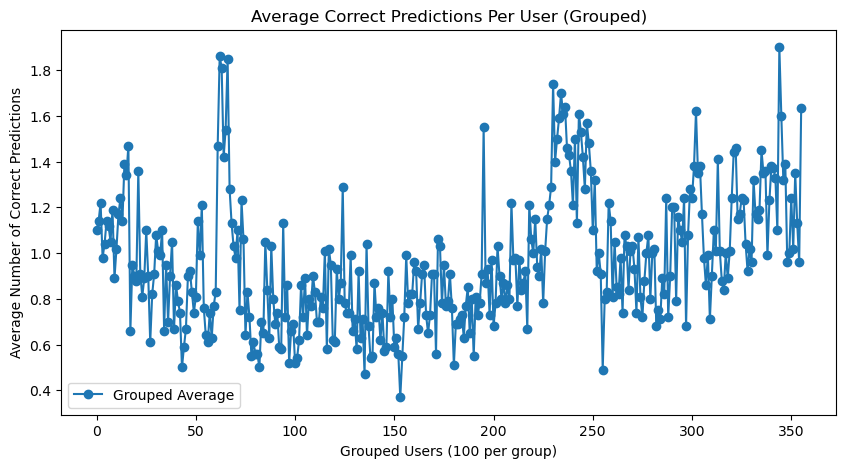

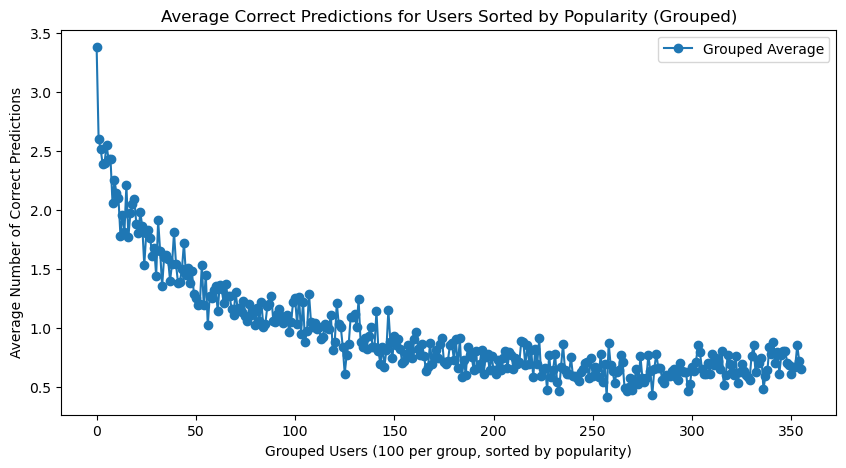

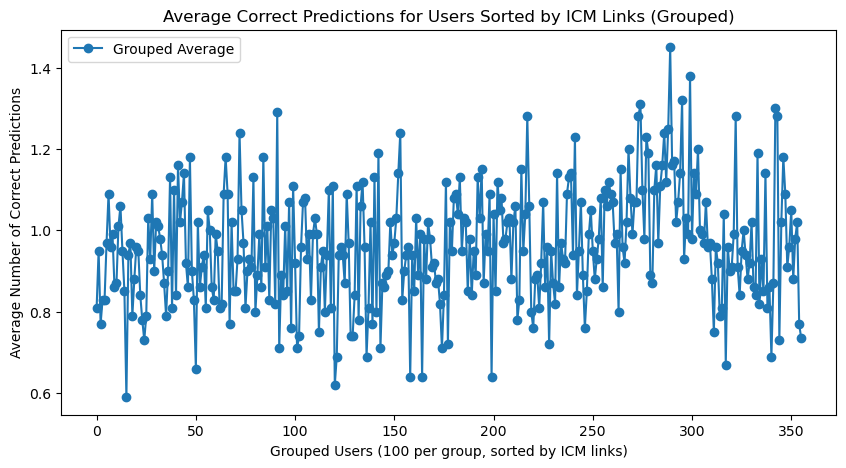

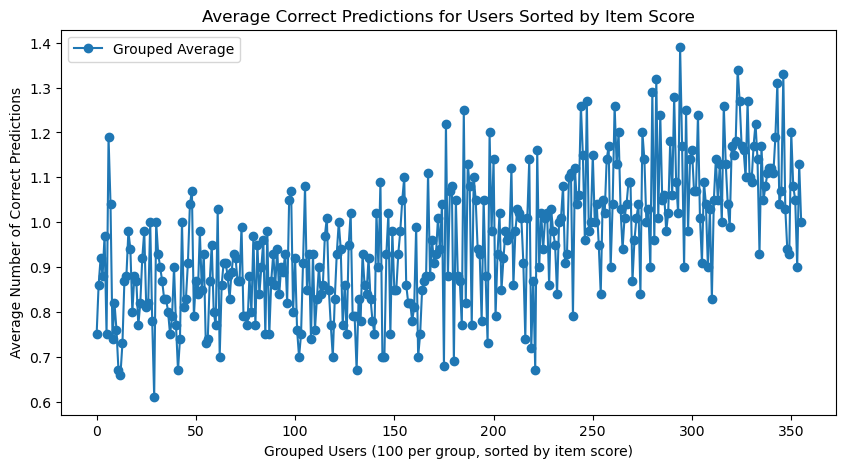

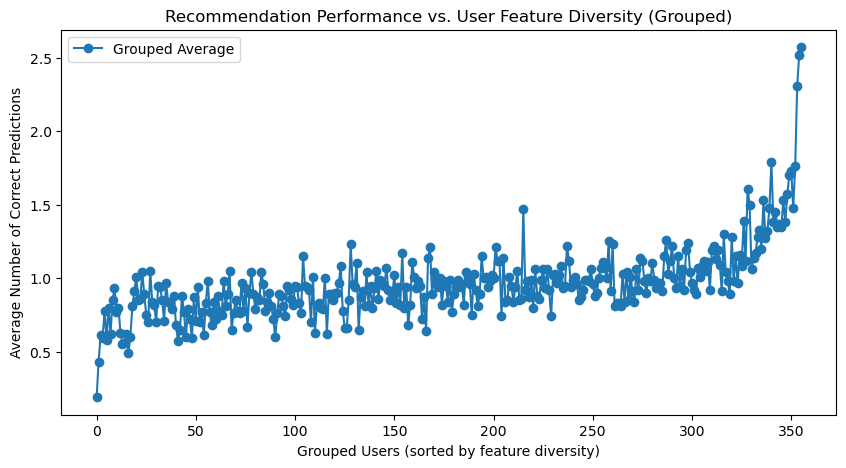

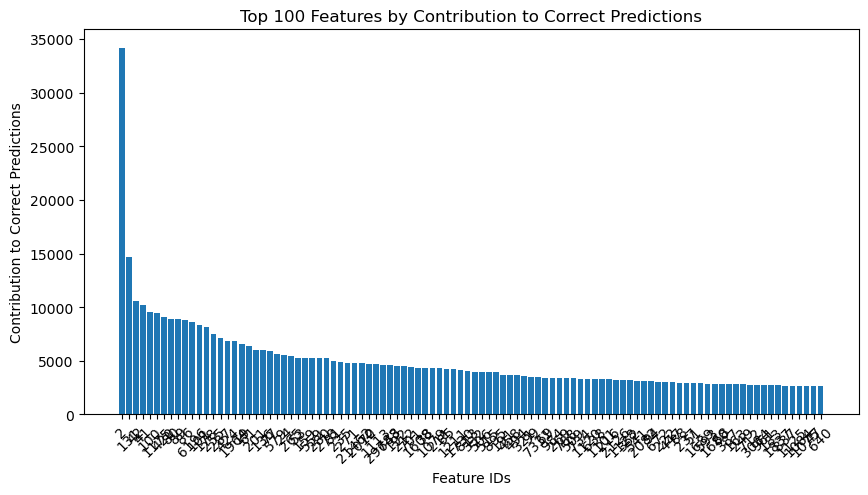

In [ ]:
evaluator = EnhancedEvaluator(urm_validation, cutoff_list=[10])
evaluator.plot_correct_predictions_per_user(rp3beta_icm, group_size=100)
evaluator.plot_users_sorted_by_popularity(rp3beta_icm, urm_train, group_size=100)
evaluator.plot_users_sorted_by_icm_links(rp3beta_icm, icm_matrix, group_size=100)
evaluator.plot_items_ranked_by_popular_features(icm_matrix, rp3beta_icm, group_size=100)
evaluator.plot_users_by_feature_diversity(icm_matrix, rp3beta_icm, group_size=100)
evaluator.plot_features_by_correct_contribution(icm_matrix, rp3beta_icm, top_k_features=40)

In [ ]:
# Initialize with both URM and ICM
recommender = RP3betaRecommenderICM(urm_train, icm_matrix)

# Fit with desired parameters
recommender.fit(
    topK= 17,
    alpha= 0.9996386762753586,
    beta= 0.21406242351456914,
    delta= 0.17583769441037236,
    min_rating= 0.4181995527765843,
    implicit= False,
    normalize_similarity= True
)

In [ ]:
# Initialize the evaluator with the test user-item matrix
evaluator = EvaluatorHoldout(urm_test, cutoff_list=[10] )

# Evaluate the TopPopularRecommender
results_df, results_run_string = evaluator.evaluateRecommender(recommender)

# Print the evaluation results
print(results_run_string)

In [ ]:
# Initialize with both URM and ICM
recommender = RP3betaRecommenderICM(urm_train, icm_matrix)

# Fit with desired parameters
recommender.fit(
    topK= 17,
    alpha= 0.9996386762753586,
    beta= 0.21406242351456914,
    delta= 0.17583769441037236,
    min_rating= 0.4181995527765843,
    implicit= True,
    normalize_similarity= True
)

In [ ]:
# Initialize the evaluator with the test user-item matrix
evaluator = EvaluatorHoldout(urm_test, cutoff_list=[10] )

# Evaluate the TopPopularRecommender
results_df, results_run_string = evaluator.evaluateRecommender(recommender)

# Print the evaluation results
print(results_run_string)

## ItemKNN

In [71]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

In [ ]:
knn_cf = ItemKNNCFRecommender(urm_train)
knn_cf.fit(
    topK=100,
    shrink=100,
    similarity="cosine",  # Use asymmetric similarity
    normalize=True,
    feature_weighting="BM25", # or "TF-IDF" or "none"
    asymmetric_alpha =0.3
)

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1118.85 column/sec. Elapsed time 34.07 sec


In [73]:
# Initialize the evaluator with the test user-item matrix
evaluator = EvaluatorHoldout(urm_test, cutoff_list=[10] )

# Evaluate the TopPopularRecommender
results_df, results_run_string = evaluator.evaluateRecommender(knn_cf)

# Print the evaluation results
print(results_run_string)

EvaluatorHoldout: Ignoring 175 ( 0.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 35561 (100.0%) in 21.43 sec. Users per second: 1660
CUTOFF: 10 - PRECISION: 0.0719805, PRECISION_RECALL_MIN_DEN: 0.1094446, RECALL: 0.0942070, MAP: 0.0348893, MAP_MIN_DEN: 0.0521941, MRR: 0.2120858, NDCG: 0.1048796, F1: 0.0816075, HIT_RATE: 0.4398920, ARHR_ALL_HITS: 0.2691030, NOVELTY: 0.0040027, AVERAGE_POPULARITY: 0.0403660, DIVERSITY_MEAN_INTER_LIST: 0.9992823, DIVERSITY_HERFINDAHL: 0.9999254, COVERAGE_ITEM: 0.8709635, COVERAGE_ITEM_HIT: 0.3008578, ITEMS_IN_GT: 0.9957504, COVERAGE_USER: 0.9951030, COVERAGE_USER_HIT: 0.4377379, USERS_IN_GT: 0.9951030, DIVERSITY_GINI: 0.3967272, SHANNON_ENTROPY: 14.2714911, RATIO_DIVERSITY_HERFINDAHL: 0.9999833, RATIO_DIVERSITY_GINI: 0.6539428, RATIO_SHANNON_ENTROPY: 0.9669139, RATIO_AVERAGE_POPULARITY: 0.5522771, RATIO_NOVELTY: 0.2990893, 



EvaluatorHoldout: Ignoring 187 ( 0.5%) Users that have less than 1 test interactions


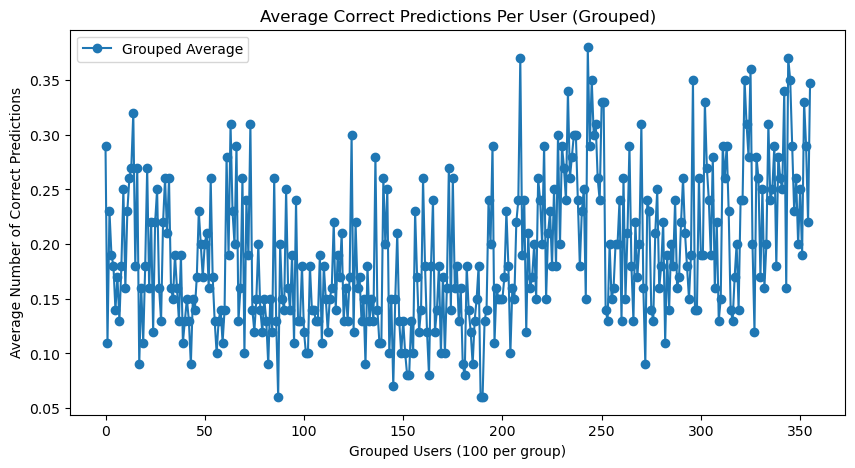

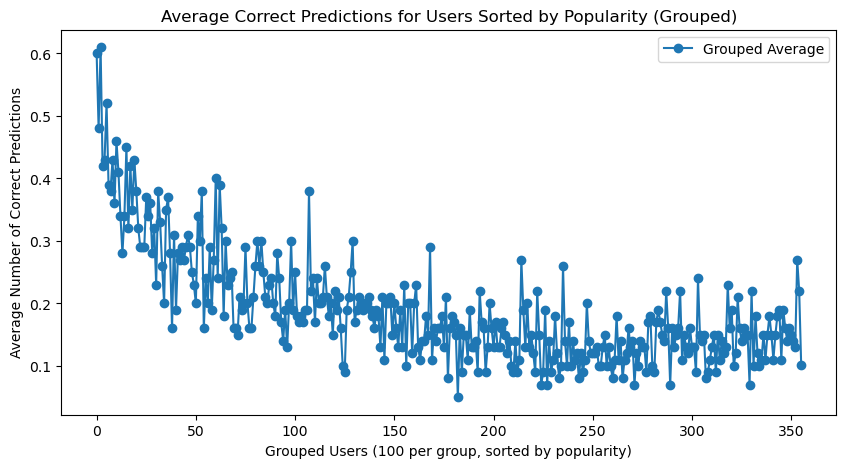

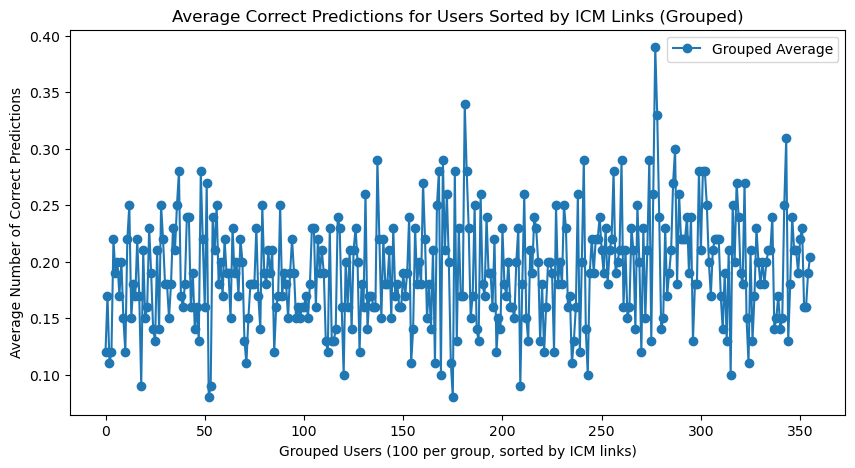

In [162]:
evaluator = EnhancedEvaluator(urm_validation, cutoff_list=[10])
evaluator.plot_correct_predictions_per_user(knn_cf, group_size=100)
evaluator.plot_users_sorted_by_popularity(knn_cf, urm_train, group_size=100)
evaluator.plot_users_sorted_by_icm_links(knn_cf, icm_matrix, group_size=100)


In [41]:
import optuna
import logging
import os
from datetime import datetime
from Evaluation.Evaluator import EvaluatorHoldout

def optimize_item_knn_cf(urm_train, urm_validation, n_trials=30, output_folder="optimization_results"):
    # Setup logging
    os.makedirs(output_folder, exist_ok=True)
    log_file = os.path.join(output_folder, f'optimization_log_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log')
    
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    
    evaluator_validation = EvaluatorHoldout(urm_validation, cutoff_list=[10])

    def objective(trial):
        # Define hyperparameter ranges
        params = {
            "topK": trial.suggest_int("topK", 10, 200),
            "shrink": trial.suggest_int("shrink", 0, 300),
            "similarity": trial.suggest_categorical("similarity", ["cosine", "asymmetric", "jaccard", "tanimoto"]),
            "normalize": trial.suggest_categorical("normalize", [True, False]),
            "feature_weighting": trial.suggest_categorical("feature_weighting", ["BM25", "TF-IDF", "none"]),
            "asymmetric_alpha": trial.suggest_float("asymmetric_alpha", 0.1, 2.0),
        }
        
        try:
            # Initialize and fit the recommender
            recommender = ItemKNNCFRecommender(URM_train=urm_train)
            recommender.fit(**params)
            
            # Evaluate the recommender
            results_df, _ = evaluator_validation.evaluateRecommender(recommender)
            map_at_10 = results_df.loc[10]["MAP"]
            
            logging.info(f"Trial {trial.number} results:")
            logging.info(f"Params: {params}")
            logging.info(f"MAP@10: {map_at_10}")
            
            return map_at_10
            
        except Exception as e:
            logging.error(f"Error in trial {trial.number}: {str(e)}")
            raise optuna.exceptions.TrialPruned()
    
    # Create the Optuna study
    study = optuna.create_study(direction="maximize")

    try:
        study.optimize(objective, n_trials=n_trials)
        
        # Log the best results
        logging.info("Optimization completed!")
        logging.info(f"Best trial: {study.best_trial.number}")
        logging.info(f"Best MAP@10: {study.best_value}")
        logging.info(f"Best hyperparameters: {study.best_params}")
        
        return study.best_params, study.best_value

    except Exception as e:
        logging.error(f"Optimization failed: {str(e)}")
        raise

In [ ]:
if __name__ == "__main__":
    # Assuming urm_train and urm_validation are already defined
    best_params, best_map = optimize_item_knn_cf(
        urm_train=urm_train,
        urm_validation=urm_validation,
        n_trials=100
    )
    print(f"Best MAP@10: {best_map}")
    print(f"Best hyperparameters: {best_params}")


In [ ]:
#insert opt parameters
knn_cf = ItemKNNCFRecommender(urm_train)
knn_cf.fit(
    topK=10,
    shrink=264,
    similarity="jaccard",  
    normalize=False,
    feature_weighting="BM25", # or "TF-IDF" or "none"
    asymmetric_alpha =1.2043488778583
)

In [ ]:
from Recommenders.GabsHybridTesting.HybridRP3KNN import HybridRP3betaKNNRecommender

hybrid_recommender = HybridRP3betaKNNRecommender(
    URM_train=urm_train,
    rp3beta_icm_recommender=rp3beta_icm,
    knn_recommender=knn_cf,
    verbose=True
)

In [53]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        "alpha": trial.suggest_float("alpha", 0.0, 1.0),  # Expanded range
    }

    try:
        # Initialize the recommender
        recommender = HybridRP3betaKNNRecommender(URM_train=urm_train,  rp3beta_icm_recommender=rp3beta_icm, knn_recommender=knn_cf, verbose=True)
        recommender.fit(**params)  # Pass the params as keyword arguments

        # Evaluate the recommender
        evaluator = EvaluatorHoldout(urm_validation, cutoff_list=[10])
        results_df, _ = evaluator.evaluateRecommender(recommender)
        map_at_10 = results_df.loc[10]["MAP"]

        return map_at_10  # Objective to maximize

    except Exception as e:
        # Handle exceptions and prune trial if necessary
        raise optuna.exceptions.TrialPruned(f"Error in trial {trial.number}: {str(e)}")


In [ ]:
import optuna

# Create the study
study = optuna.create_study(direction="maximize")  # Maximize MAP@10

# Optimize the objective function
study.optimize(objective, n_trials=50)  # Adjust n_trials as needed

# Print the best results
print(f"Best MAP@10: {study.best_value}")
print(f"Best hyperparameters: {study.best_params}")

In [ ]:
best_params = study.best_params  # Retrieve best parameters
print(f"Best hyperparameters: {best_params}")  # Print the best hyperparameters

In [ ]:
hybrid_recommender.fit(alpha=0.3053446904625561, normalize_similarity=True)

In [ ]:
# Initialize the evaluator with the test user-item matrix
evaluator = EvaluatorHoldout(urm_test, cutoff_list=[10] )

# Evaluate the TopPopularRecommender
results_df, results_run_string = evaluator.evaluateRecommender(hybrid_recommender)

# Print the evaluation results
print(results_run_string)

# SLIM ElasticNet




In [ ]:
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender

# Initialize the SLIM ElasticNet recommender
slim_recommender = SLIMElasticNetRecommender(urm_train)
slim_recommender.fit()

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1112.38 column/sec. Elapsed time 34.27 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.39 min. Items per second: 458.23


In [138]:
# Initialize the evaluator with the test user-item matrix
evaluator = EvaluatorHoldout(urm_validation, cutoff_list=[10] )

# Evaluate the TopPopularRecommender
results_df, results_run_string = evaluator.evaluateRecommender(slim_recommender)

# Print the evaluation results
print(results_run_string)

EvaluatorHoldout: Ignoring 187 ( 0.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 35549 (100.0%) in 23.24 sec. Users per second: 1530
CUTOFF: 10 - PRECISION: 0.1046499, PRECISION_RECALL_MIN_DEN: 0.1568362, RECALL: 0.1338088, MAP: 0.0551919, MAP_MIN_DEN: 0.0812051, MRR: 0.2952287, NDCG: 0.1531215, F1: 0.1174466, HIT_RATE: 0.5599032, ARHR_ALL_HITS: 0.3971624, NOVELTY: 0.0036927, AVERAGE_POPULARITY: 0.1092102, DIVERSITY_MEAN_INTER_LIST: 0.9978617, DIVERSITY_HERFINDAHL: 0.9997834, COVERAGE_ITEM: 0.6314367, COVERAGE_ITEM_HIT: 0.2878466, ITEMS_IN_GT: 0.9959078, COVERAGE_USER: 0.9947672, COVERAGE_USER_HIT: 0.5569734, USERS_IN_GT: 0.9947672, DIVERSITY_GINI: 0.2210735, SHANNON_ENTROPY: 13.3119125, RATIO_DIVERSITY_HERFINDAHL: 0.9998412, RATIO_DIVERSITY_GINI: 0.3639741, RATIO_SHANNON_ENTROPY: 0.9018466, RATIO_AVERAGE_POPULARITY: 1.4884609, RATIO_NOVELTY: 0.2575148, 



## Optimization

In [ ]:
import optuna
from Evaluation.Evaluator import EvaluatorHoldout

# Define the number of trials
n_trials = 30

# Define the evaluator for validation
evaluator_validation = EvaluatorHoldout(urm_validation, cutoff_list=[10])

# Define the objective function
def objective(trial):
    # Define hyperparameters to optimize
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)  # ElasticNet ratio
    alpha = trial.suggest_float("alpha", 1e-4, 1e1, log=True)  # Regularization strength
    positive_only = trial.suggest_categorical("positive_only", [True, False])
    topK = trial.suggest_int("topK", 10, 200)  # TopK for similarity matrix
    
    # Initialize and fit the SLIM ElasticNet Recommender
    recommender = SLIMElasticNetRecommender(URM_train=urm_train)
    recommender.fit(l1_ratio=l1_ratio, alpha=alpha, positive_only=positive_only, topK=topK)
    
    # Evaluate using the validation set
    results_df, _ = evaluator_validation.evaluateRecommender(recommender)
    map_at_10 = results_df.loc[10]["MAP"]  # Extract MAP@10 from results
    
    return map_at_10

In [ ]:
# Create and run the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=n_trials)

# Output the best hyperparameters found
print("Best hyperparameters:", study.best_params)
print("Best MAP@10:", study.best_value)

In [ ]:
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender

# Initialize the SLIM ElasticNet recommender
slim_recommender = SLIMElasticNetRecommender(urm_train)
slim_recommender.fit(l1_ratio= 0.4408355927953408, alpha= 0.00013519978876092592, positive_only= False, topK= 59, do_feature_selection=True)

In [ ]:
# Initialize the evaluator with the test user-item matrix
evaluator = EvaluatorHoldout(urm_test, cutoff_list=[10] )

# Evaluate the TopPopularRecommender
results_df, results_run_string = evaluator.evaluateRecommender(slim_recommender)

# Print the evaluation results
print(results_run_string)

## Graphs

In [ ]:
##CODE HERE

# RP3ICM + SLIM

In [64]:
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.GraphBased.RP3betaRecommenderICM import RP3betaRecommenderICM
import optuna
import logging
import os
import json
from datetime import datetime
from Evaluation.Evaluator import EvaluatorHoldout

def optimize_rp3_slim_hybrid(urm_train, icm, urm_validation, n_trials=30, output_folder="optimization_results"):
    os.makedirs(output_folder, exist_ok=True)
    log_file = os.path.join(output_folder, f'rp3_slim_optimization_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log')
    
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    
    evaluator_validation = EvaluatorHoldout(urm_validation, cutoff_list=[10])
    
    def objective(trial):
        try:
            rp3beta_params = {
                "topK": trial.suggest_int("rp3_topK", 10, 200),
                "alpha": trial.suggest_float("rp3_alpha", 0.1, 1.0),
                "beta": trial.suggest_float("rp3_beta", 0.1, 1.0),
                "delta": trial.suggest_float("rp3_delta", 0.0, 1.0),
                "min_rating": trial.suggest_float("rp3_min_rating", 0.0, 5.0),
                "implicit": trial.suggest_categorical("rp3_implicit", [True, False]),
                "normalize_similarity": trial.suggest_categorical("rp3_normalize", [True, False])
            }
            
            slim_params = {
                "l1_ratio": trial.suggest_float("slim_l1_ratio", 0.0, 1.0),
                "alpha": trial.suggest_float("slim_alpha", 1e-4, 1e1, log=True),
                "positive_only": trial.suggest_categorical("slim_positive_only", [True, False]),
                "topK": trial.suggest_int("slim_topK", 10, 200),
                "do_feature_selection": trial.suggest_categorical("do_feature_selection", [True])
            }
            
            hybrid_params = {
                "rp3beta_weight": trial.suggest_float("rp3beta_weight", 0.0, 1.0),
                "slim_weight": trial.suggest_float("slim_weight", 0.0, 1.0)
            }
            
            rp3beta_recommender = RP3betaRecommenderICM(URM_train=urm_train, ICM=icm)
            rp3beta_recommender.fit(**rp3beta_params)
            
            slim_recommender = SLIMElasticNetRecommender(URM_train=urm_train)
            slim_recommender.fit(**slim_params)
            
            hybrid_recommender = HybridRecommender(
                URM_train=urm_train,
                recommender_list=[rp3beta_recommender, slim_recommender],
                recommender_weights=[hybrid_params["rp3beta_weight"], hybrid_params["slim_weight"]]
            )
            
            results_df, _ = evaluator_validation.evaluateRecommender(hybrid_recommender)
            map_at_10 = results_df.loc[10]["MAP"]
            
            logging.info(f"\nTrial {trial.number} results:")
            logging.info(f"MAP@10: {map_at_10}")
            logging.info(f"RP3beta weight: {hybrid_recommender.recommender_weights[0]:.3f}")
            logging.info(f"SLIM weight: {hybrid_recommender.recommender_weights[1]:.3f}")
            
            return map_at_10
            
        except Exception as e:
            logging.error(f"Error in trial {trial.number}: {str(e)}")
            raise optuna.exceptions.TrialPruned()
    
    study = optuna.create_study(direction="maximize")
    
    try:
        study.optimize(objective, n_trials=n_trials)
        
        best_params = study.best_params
        best_map = study.best_value
        
        logging.info("\nOptimization completed!")
        logging.info(f"Best MAP@10: {best_map}")
        logging.info("Best parameters:")
        logging.info(json.dumps(best_params, indent=2))
        
        try:
            from optuna.visualization import plot_optimization_history, plot_param_importances
            plot_optimization_history(study).write_image(os.path.join(output_folder, "optimization_history.png"))
            plot_param_importances(study).write_image(os.path.join(output_folder, "param_importances.png"))
        except ImportError:
            logging.warning("Plotly not installed. Skipping visualization generation.")
        
        return best_params, best_map
        
    except Exception as e:
        logging.error(f"Optimization failed: {str(e)}")
        raise

In [65]:
best_params, best_map = optimize_rp3_slim_hybrid(
    urm_train=urm_train,
    icm=icm_matrix,
    urm_validation=urm_validation,
    n_trials=100
)

[I 2024-12-30 15:39:33,517] A new study created in memory with name: no-name-2ca3d144-1faa-4653-80ed-3004a0ec923f


EvaluatorHoldout: Ignoring 1909 ( 5.3%) Users that have less than 1 test interactions
RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.23 min. Items per second: 516
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1170.00 column/sec. Elapsed time 32.58 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.24 min. Items per second: 513.24
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 17.93 sec. Users per second: 1887


2024-12-30 15:42:52,645 - INFO - 
Trial 0 results:
2024-12-30 15:42:52,647 - INFO - MAP@10: 0.0001361432423897316
2024-12-30 15:42:52,647 - INFO - RP3beta weight: 0.045
2024-12-30 15:42:52,648 - INFO - SLIM weight: 0.955
[I 2024-12-30 15:42:52,653] Trial 0 finished with value: 0.0001361432423897316 and parameters: {'rp3_topK': 42, 'rp3_alpha': 0.11570294254212721, 'rp3_beta': 0.5815180239307346, 'rp3_delta': 0.21364997977539835, 'rp3_min_rating': 2.803539515438578, 'rp3_implicit': True, 'rp3_normalize': False, 'slim_l1_ratio': 0.003841165645666389, 'slim_alpha': 5.791922285325995, 'slim_positive_only': False, 'slim_topK': 198, 'do_feature_selection': True, 'rp3beta_weight': 0.006429024349728807, 'slim_weight': 0.1367061564673442}. Best is trial 0 with value: 0.0001361432423897316.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.52 min. Items per second: 418
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1118.80 column/sec. Elapsed time 34.07 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.19 min. Items per second: 536.00
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 17.17 sec. Users per second: 1970


2024-12-30 15:46:26,762 - INFO - 
Trial 1 results:
2024-12-30 15:46:26,765 - INFO - MAP@10: 0.0001361432423897316
2024-12-30 15:46:26,765 - INFO - RP3beta weight: 0.100
2024-12-30 15:46:26,766 - INFO - SLIM weight: 0.900
[I 2024-12-30 15:46:26,770] Trial 1 finished with value: 0.0001361432423897316 and parameters: {'rp3_topK': 116, 'rp3_alpha': 0.560540824838312, 'rp3_beta': 0.9340671266095699, 'rp3_delta': 0.6617722841307587, 'rp3_min_rating': 2.3748516013494543, 'rp3_implicit': True, 'rp3_normalize': False, 'slim_l1_ratio': 0.4499459148838326, 'slim_alpha': 0.051805121590500804, 'slim_positive_only': False, 'slim_topK': 116, 'do_feature_selection': True, 'rp3beta_weight': 0.07836155875824224, 'slim_weight': 0.7077558843983155}. Best is trial 0 with value: 0.0001361432423897316.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.26 min. Items per second: 505
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1027.66 column/sec. Elapsed time 37.09 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.26 min. Items per second: 506.21
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 17.95 sec. Users per second: 1885


2024-12-30 15:49:53,275 - INFO - 
Trial 2 results:
2024-12-30 15:49:53,277 - INFO - MAP@10: 0.0001361432423897316
2024-12-30 15:49:53,278 - INFO - RP3beta weight: 0.653
2024-12-30 15:49:53,278 - INFO - SLIM weight: 0.347
[I 2024-12-30 15:49:53,284] Trial 2 finished with value: 0.0001361432423897316 and parameters: {'rp3_topK': 106, 'rp3_alpha': 0.139389901554648, 'rp3_beta': 0.2840255966661325, 'rp3_delta': 0.2969672001253115, 'rp3_min_rating': 3.035306724161737, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.4898034298564461, 'slim_alpha': 0.09292463062364134, 'slim_positive_only': False, 'slim_topK': 149, 'do_feature_selection': True, 'rp3beta_weight': 0.8239330599792382, 'slim_weight': 0.4382802610272435}. Best is trial 0 with value: 0.0001361432423897316.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.68 min. Items per second: 238
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1181.32 column/sec. Elapsed time 32.27 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.38 min. Items per second: 458.73
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 27.13 sec. Users per second: 1247


2024-12-30 15:55:00,696 - INFO - 
Trial 3 results:
2024-12-30 15:55:00,698 - INFO - MAP@10: 0.022594198961006243
2024-12-30 15:55:00,698 - INFO - RP3beta weight: 0.600
2024-12-30 15:55:00,699 - INFO - SLIM weight: 0.400
[I 2024-12-30 15:55:00,709] Trial 3 finished with value: 0.022594198961006243 and parameters: {'rp3_topK': 112, 'rp3_alpha': 0.9135528059938018, 'rp3_beta': 0.49743506162241524, 'rp3_delta': 0.8012340078100081, 'rp3_min_rating': 0.4736042202607049, 'rp3_implicit': False, 'rp3_normalize': False, 'slim_l1_ratio': 0.33347424883242893, 'slim_alpha': 0.00014075865355761818, 'slim_positive_only': True, 'slim_topK': 101, 'do_feature_selection': True, 'rp3beta_weight': 0.6823798991922735, 'slim_weight': 0.4543951243155845}. Best is trial 3 with value: 0.022594198961006243.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.38 min. Items per second: 459
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1098.09 column/sec. Elapsed time 34.72 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.30 min. Items per second: 487.78
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 17.88 sec. Users per second: 1892


2024-12-30 15:58:35,082 - INFO - 
Trial 4 results:
2024-12-30 15:58:35,084 - INFO - MAP@10: 0.0001361432423897316
2024-12-30 15:58:35,084 - INFO - RP3beta weight: 0.368
2024-12-30 15:58:35,085 - INFO - SLIM weight: 0.632
[I 2024-12-30 15:58:35,092] Trial 4 finished with value: 0.0001361432423897316 and parameters: {'rp3_topK': 138, 'rp3_alpha': 0.9580016393280014, 'rp3_beta': 0.9514474184174263, 'rp3_delta': 0.0879533385179907, 'rp3_min_rating': 4.0101926130143175, 'rp3_implicit': True, 'rp3_normalize': False, 'slim_l1_ratio': 0.15442388729691248, 'slim_alpha': 3.6612816618390585, 'slim_positive_only': True, 'slim_topK': 85, 'do_feature_selection': True, 'rp3beta_weight': 0.3041187204637681, 'slim_weight': 0.5232220168464204}. Best is trial 3 with value: 0.022594198961006243.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.64 min. Items per second: 241
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1101.52 column/sec. Elapsed time 34.61 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.26 min. Items per second: 504.10
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.07 sec. Users per second: 1349


2024-12-30 16:03:33,984 - INFO - 
Trial 5 results:
2024-12-30 16:03:33,987 - INFO - MAP@10: 0.015424962261291673
2024-12-30 16:03:33,988 - INFO - RP3beta weight: 0.252
2024-12-30 16:03:33,989 - INFO - SLIM weight: 0.748
[I 2024-12-30 16:03:34,005] Trial 5 finished with value: 0.015424962261291673 and parameters: {'rp3_topK': 145, 'rp3_alpha': 0.5998165572718012, 'rp3_beta': 0.23520779510914502, 'rp3_delta': 0.5996274828422274, 'rp3_min_rating': 0.9946939377785757, 'rp3_implicit': True, 'rp3_normalize': False, 'slim_l1_ratio': 0.9738457638683128, 'slim_alpha': 0.0019598890943020196, 'slim_positive_only': False, 'slim_topK': 191, 'do_feature_selection': True, 'rp3beta_weight': 0.32299564375328593, 'slim_weight': 0.9601261279633921}. Best is trial 3 with value: 0.022594198961006243.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.27 min. Items per second: 498
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1202.08 column/sec. Elapsed time 31.71 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.20 min. Items per second: 527.82
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 19.44 sec. Users per second: 1740


2024-12-30 16:06:54,436 - INFO - 
Trial 6 results:
2024-12-30 16:06:54,440 - INFO - MAP@10: 0.0001361432423897316
2024-12-30 16:06:54,441 - INFO - RP3beta weight: 0.861
2024-12-30 16:06:54,442 - INFO - SLIM weight: 0.139
[I 2024-12-30 16:06:54,452] Trial 6 finished with value: 0.0001361432423897316 and parameters: {'rp3_topK': 52, 'rp3_alpha': 0.43253566341021193, 'rp3_beta': 0.6356798116227067, 'rp3_delta': 0.44160432490289214, 'rp3_min_rating': 4.149769247007339, 'rp3_implicit': False, 'rp3_normalize': False, 'slim_l1_ratio': 0.5880407705251294, 'slim_alpha': 0.15883331216706847, 'slim_positive_only': False, 'slim_topK': 152, 'do_feature_selection': True, 'rp3beta_weight': 0.7789542797963072, 'slim_weight': 0.12548720206171537}. Best is trial 3 with value: 0.022594198961006243.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.69 min. Items per second: 236
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1091.40 column/sec. Elapsed time 34.93 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.11 min. Items per second: 570.98
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.30 sec. Users per second: 1392


2024-12-30 16:11:47,039 - INFO - 
Trial 7 results:
2024-12-30 16:11:47,043 - INFO - MAP@10: 0.004760211974936906
2024-12-30 16:11:47,043 - INFO - RP3beta weight: 0.439
2024-12-30 16:11:47,044 - INFO - SLIM weight: 0.561
[I 2024-12-30 16:11:47,052] Trial 7 finished with value: 0.004760211974936906 and parameters: {'rp3_topK': 159, 'rp3_alpha': 0.4754552311890203, 'rp3_beta': 0.9335757135782695, 'rp3_delta': 0.3836399933680229, 'rp3_min_rating': 0.9884039911442882, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.830118158849335, 'slim_alpha': 0.03515457297795498, 'slim_positive_only': False, 'slim_topK': 127, 'do_feature_selection': True, 'rp3beta_weight': 0.696098180275936, 'slim_weight': 0.8878455983979641}. Best is trial 3 with value: 0.022594198961006243.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.27 min. Items per second: 500
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1225.11 column/sec. Elapsed time 31.12 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.17 min. Items per second: 542.54
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 18.66 sec. Users per second: 1813


2024-12-30 16:15:03,760 - INFO - 
Trial 8 results:
2024-12-30 16:15:03,762 - INFO - MAP@10: 0.021806460604166335
2024-12-30 16:15:03,762 - INFO - RP3beta weight: 0.157
2024-12-30 16:15:03,763 - INFO - SLIM weight: 0.843
[I 2024-12-30 16:15:03,767] Trial 8 finished with value: 0.021806460604166335 and parameters: {'rp3_topK': 162, 'rp3_alpha': 0.9295470793655121, 'rp3_beta': 0.1433764243701783, 'rp3_delta': 0.8699733820473419, 'rp3_min_rating': 2.8509258718418624, 'rp3_implicit': False, 'rp3_normalize': False, 'slim_l1_ratio': 0.953796758898198, 'slim_alpha': 0.00011734310774355249, 'slim_positive_only': False, 'slim_topK': 77, 'do_feature_selection': True, 'rp3beta_weight': 0.05472361070328535, 'slim_weight': 0.2943216640127644}. Best is trial 3 with value: 0.022594198961006243.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.13 min. Items per second: 564
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1145.41 column/sec. Elapsed time 33.28 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.24 min. Items per second: 512.98
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 16.77 sec. Users per second: 2017


2024-12-30 16:18:16,221 - INFO - 
Trial 9 results:
2024-12-30 16:18:16,222 - INFO - MAP@10: 0.0001361432423897316
2024-12-30 16:18:16,223 - INFO - RP3beta weight: 0.094
2024-12-30 16:18:16,223 - INFO - SLIM weight: 0.906
[I 2024-12-30 16:18:16,228] Trial 9 finished with value: 0.0001361432423897316 and parameters: {'rp3_topK': 14, 'rp3_alpha': 0.39114397999900014, 'rp3_beta': 0.23573565719901146, 'rp3_delta': 0.2298831941465207, 'rp3_min_rating': 3.3007056733269566, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.08219714610344986, 'slim_alpha': 5.257546390799017, 'slim_positive_only': True, 'slim_topK': 81, 'do_feature_selection': True, 'rp3beta_weight': 0.04650728600017662, 'slim_weight': 0.44857476044221833}. Best is trial 3 with value: 0.022594198961006243.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.54 min. Items per second: 250
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1082.14 column/sec. Elapsed time 35.23 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.42 min. Items per second: 448.27
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 27.06 sec. Users per second: 1250


2024-12-30 16:23:23,191 - INFO - 
Trial 10 results:
2024-12-30 16:23:23,193 - INFO - MAP@10: 0.022652362558132636
2024-12-30 16:23:23,194 - INFO - RP3beta weight: 0.578
2024-12-30 16:23:23,194 - INFO - SLIM weight: 0.422
[I 2024-12-30 16:23:23,201] Trial 10 finished with value: 0.022652362558132636 and parameters: {'rp3_topK': 194, 'rp3_alpha': 0.7903774652042517, 'rp3_beta': 0.41670629614782295, 'rp3_delta': 0.9626867706931043, 'rp3_min_rating': 0.15513390931119636, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.2811574074020303, 'slim_alpha': 0.0001311528151862453, 'slim_positive_only': True, 'slim_topK': 12, 'do_feature_selection': True, 'rp3beta_weight': 0.9601965337133913, 'slim_weight': 0.7020219096412641}. Best is trial 10 with value: 0.022652362558132636.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.79 min. Items per second: 227
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1150.45 column/sec. Elapsed time 33.14 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.35 min. Items per second: 471.18
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 27.00 sec. Users per second: 1253


2024-12-30 16:28:38,881 - INFO - 
Trial 11 results:
2024-12-30 16:28:38,883 - INFO - MAP@10: 0.022764715280973968
2024-12-30 16:28:38,883 - INFO - RP3beta weight: 0.591
2024-12-30 16:28:38,884 - INFO - SLIM weight: 0.409
[I 2024-12-30 16:28:38,892] Trial 11 finished with value: 0.022764715280973968 and parameters: {'rp3_topK': 197, 'rp3_alpha': 0.7462464297466095, 'rp3_beta': 0.4246289182039921, 'rp3_delta': 0.9829245136497136, 'rp3_min_rating': 0.31657960322102685, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.2981708386934532, 'slim_alpha': 0.00015184298498514275, 'slim_positive_only': True, 'slim_topK': 21, 'do_feature_selection': True, 'rp3beta_weight': 0.9949971457010958, 'slim_weight': 0.6883392792829444}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.57 min. Items per second: 247
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1143.99 column/sec. Elapsed time 33.32 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.15 min. Items per second: 553.02
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.42 sec. Users per second: 1331


2024-12-30 16:33:27,597 - INFO - 
Trial 12 results:
2024-12-30 16:33:27,599 - INFO - MAP@10: 0.018348225870101948
2024-12-30 16:33:27,600 - INFO - RP3beta weight: 0.565
2024-12-30 16:33:27,600 - INFO - SLIM weight: 0.435
[I 2024-12-30 16:33:27,606] Trial 12 finished with value: 0.018348225870101948 and parameters: {'rp3_topK': 192, 'rp3_alpha': 0.7380145274726737, 'rp3_beta': 0.42717490435196614, 'rp3_delta': 0.9776259629073561, 'rp3_min_rating': 0.16320252517883488, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.302417093245624, 'slim_alpha': 0.00120422841642447, 'slim_positive_only': True, 'slim_topK': 10, 'do_feature_selection': True, 'rp3beta_weight': 0.9205686436255128, 'slim_weight': 0.7078436819520553}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.33 min. Items per second: 479
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1139.03 column/sec. Elapsed time 33.47 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.18 min. Items per second: 540.25
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 17.51 sec. Users per second: 1932


2024-12-30 16:36:49,340 - INFO - 
Trial 13 results:
2024-12-30 16:36:49,342 - INFO - MAP@10: 0.015021601510205812
2024-12-30 16:36:49,343 - INFO - RP3beta weight: 0.572
2024-12-30 16:36:49,343 - INFO - SLIM weight: 0.428
[I 2024-12-30 16:36:49,347] Trial 13 finished with value: 0.015021601510205812 and parameters: {'rp3_topK': 183, 'rp3_alpha': 0.7655586002148291, 'rp3_beta': 0.7222970948126249, 'rp3_delta': 0.9760951788033768, 'rp3_min_rating': 1.774272284392725, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.24542091793105103, 'slim_alpha': 0.0015490022660085844, 'slim_positive_only': True, 'slim_topK': 11, 'do_feature_selection': True, 'rp3beta_weight': 0.9785347849964334, 'slim_weight': 0.7335190163626286}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.41 min. Items per second: 450
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1146.90 column/sec. Elapsed time 33.24 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.08 min. Items per second: 590.26
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 20.22 sec. Users per second: 1673


2024-12-30 16:40:12,613 - INFO - 
Trial 14 results:
2024-12-30 16:40:12,615 - INFO - MAP@10: 0.017333313859831462
2024-12-30 16:40:12,616 - INFO - RP3beta weight: 0.417
2024-12-30 16:40:12,616 - INFO - SLIM weight: 0.583
[I 2024-12-30 16:40:12,621] Trial 14 finished with value: 0.017333313859831462 and parameters: {'rp3_topK': 198, 'rp3_alpha': 0.7337435806649995, 'rp3_beta': 0.37353838480216656, 'rp3_delta': 0.7418811950877225, 'rp3_min_rating': 1.6026307056075728, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.649894644910812, 'slim_alpha': 0.00044519095688397476, 'slim_positive_only': True, 'slim_topK': 43, 'do_feature_selection': True, 'rp3beta_weight': 0.5889838631340324, 'slim_weight': 0.8231767947455599}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.62 min. Items per second: 242
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1116.63 column/sec. Elapsed time 34.14 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.31 min. Items per second: 485.80
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 20.55 sec. Users per second: 1646


2024-12-30 16:45:06,140 - INFO - 
Trial 15 results:
2024-12-30 16:45:06,142 - INFO - MAP@10: 0.01183406136077111
2024-12-30 16:45:06,143 - INFO - RP3beta weight: 0.625
2024-12-30 16:45:06,143 - INFO - SLIM weight: 0.375
[I 2024-12-30 16:45:06,149] Trial 15 finished with value: 0.01183406136077111 and parameters: {'rp3_topK': 71, 'rp3_alpha': 0.8242328673912338, 'rp3_beta': 0.7544883776203396, 'rp3_delta': 0.8767251622088807, 'rp3_min_rating': 0.045224793967693605, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.39633197320850416, 'slim_alpha': 0.006108277063155873, 'slim_positive_only': True, 'slim_topK': 41, 'do_feature_selection': True, 'rp3beta_weight': 0.9902215566752749, 'slim_weight': 0.5944731811382593}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.67 min. Items per second: 238
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1149.57 column/sec. Elapsed time 33.16 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.06 min. Items per second: 599.94
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.02 sec. Users per second: 1352


2024-12-30 16:49:54,768 - INFO - 
Trial 16 results:
2024-12-30 16:49:54,770 - INFO - MAP@10: 0.014847709001122422
2024-12-30 16:49:54,772 - INFO - RP3beta weight: 0.576
2024-12-30 16:49:54,773 - INFO - SLIM weight: 0.424
[I 2024-12-30 16:49:54,783] Trial 16 finished with value: 0.014847709001122422 and parameters: {'rp3_topK': 175, 'rp3_alpha': 0.6487229282755931, 'rp3_beta': 0.3884745852994446, 'rp3_delta': 0.5893223547209863, 'rp3_min_rating': 0.9447130746242418, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.20409819031096627, 'slim_alpha': 0.012565502492522654, 'slim_positive_only': True, 'slim_topK': 43, 'do_feature_selection': True, 'rp3beta_weight': 0.8445499124033532, 'slim_weight': 0.6228669296978548}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.41 min. Items per second: 452
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1086.70 column/sec. Elapsed time 35.08 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.25 min. Items per second: 509.69
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 18.20 sec. Users per second: 1858


2024-12-30 16:53:27,797 - INFO - 
Trial 17 results:
2024-12-30 16:53:27,802 - INFO - MAP@10: 0.0186991020134664
2024-12-30 16:53:27,804 - INFO - RP3beta weight: 0.361
2024-12-30 16:53:27,804 - INFO - SLIM weight: 0.639
[I 2024-12-30 16:53:27,810] Trial 17 finished with value: 0.0186991020134664 and parameters: {'rp3_topK': 81, 'rp3_alpha': 0.3060207415888724, 'rp3_beta': 0.47894043046770407, 'rp3_delta': 0.7443454799900693, 'rp3_min_rating': 4.983413790577098, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.606459154382491, 'slim_alpha': 0.000385714015891576, 'slim_positive_only': True, 'slim_topK': 31, 'do_feature_selection': True, 'rp3beta_weight': 0.46882256522023, 'slim_weight': 0.828543722125764}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.24 min. Items per second: 513
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1010.50 column/sec. Elapsed time 37.73 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.25 min. Items per second: 509.96
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 19.67 sec. Users per second: 1720


2024-12-30 16:56:54,832 - INFO - 
Trial 18 results:
2024-12-30 16:56:54,835 - INFO - MAP@10: 0.0001361432423897316
2024-12-30 16:56:54,835 - INFO - RP3beta weight: 0.333
2024-12-30 16:56:54,835 - INFO - SLIM weight: 0.667
[I 2024-12-30 16:56:54,840] Trial 18 finished with value: 0.0001361432423897316 and parameters: {'rp3_topK': 133, 'rp3_alpha': 0.8359129722709058, 'rp3_beta': 0.3261791458071642, 'rp3_delta': 0.987569192808525, 'rp3_min_rating': 1.85092236239338, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.3531178583363881, 'slim_alpha': 1.1244548211260346, 'slim_positive_only': True, 'slim_topK': 61, 'do_feature_selection': True, 'rp3beta_weight': 0.4921384550901503, 'slim_weight': 0.9864165925491667}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 3.31 min. Items per second: 192
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1151.93 column/sec. Elapsed time 33.09 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.44 min. Items per second: 441.37
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.83 sec. Users per second: 1420


2024-12-30 17:02:43,442 - INFO - 
Trial 19 results:
2024-12-30 17:02:43,445 - INFO - MAP@10: 0.017552031790140588
2024-12-30 17:02:43,446 - INFO - RP3beta weight: 0.738
2024-12-30 17:02:43,447 - INFO - SLIM weight: 0.262
[I 2024-12-30 17:02:43,456] Trial 19 finished with value: 0.017552031790140588 and parameters: {'rp3_topK': 172, 'rp3_alpha': 0.6693684884984342, 'rp3_beta': 0.10327486437408379, 'rp3_delta': 0.8963535153563279, 'rp3_min_rating': 0.6192476327641221, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.12139244270076371, 'slim_alpha': 0.006409790821742237, 'slim_positive_only': True, 'slim_topK': 27, 'do_feature_selection': True, 'rp3beta_weight': 0.8735767453471905, 'slim_weight': 0.3105755016653047}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.52 min. Items per second: 418
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 685.31 column/sec. Elapsed time 55.63 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.46 min. Items per second: 436.18
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 18.01 sec. Users per second: 1878


2024-12-30 17:06:56,697 - INFO - 
Trial 20 results:
2024-12-30 17:06:56,700 - INFO - MAP@10: 0.018209349298789843
2024-12-30 17:06:56,700 - INFO - RP3beta weight: 0.541
2024-12-30 17:06:56,701 - INFO - SLIM weight: 0.459
[I 2024-12-30 17:06:56,708] Trial 20 finished with value: 0.018209349298789843 and parameters: {'rp3_topK': 197, 'rp3_alpha': 0.841987986643577, 'rp3_beta': 0.6529986726205365, 'rp3_delta': 0.5059592154516036, 'rp3_min_rating': 1.5017314621690214, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.6884499884437025, 'slim_alpha': 0.0003680492723401107, 'slim_positive_only': True, 'slim_topK': 56, 'do_feature_selection': True, 'rp3beta_weight': 0.6999543026956434, 'slim_weight': 0.5945443411806349}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.61 min. Items per second: 243
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1174.86 column/sec. Elapsed time 32.45 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.43 min. Items per second: 444.41
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.32 sec. Users per second: 1391


2024-12-30 17:11:59,535 - INFO - 
Trial 21 results:
2024-12-30 17:11:59,538 - INFO - MAP@10: 0.022433967231022513
2024-12-30 17:11:59,538 - INFO - RP3beta weight: 0.678
2024-12-30 17:11:59,538 - INFO - SLIM weight: 0.322
[I 2024-12-30 17:11:59,545] Trial 21 finished with value: 0.022433967231022513 and parameters: {'rp3_topK': 87, 'rp3_alpha': 0.9889017156958031, 'rp3_beta': 0.5215745057028669, 'rp3_delta': 0.7979312843822582, 'rp3_min_rating': 0.5108555000998111, 'rp3_implicit': False, 'rp3_normalize': False, 'slim_l1_ratio': 0.29105395417490776, 'slim_alpha': 0.0001772543106166801, 'slim_positive_only': True, 'slim_topK': 101, 'do_feature_selection': True, 'rp3beta_weight': 0.7229935520824238, 'slim_weight': 0.3438218558720714}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.64 min. Items per second: 241
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1097.71 column/sec. Elapsed time 34.73 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.36 min. Items per second: 467.56
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.24 sec. Users per second: 1340


2024-12-30 17:17:03,957 - INFO - 
Trial 22 results:
2024-12-30 17:17:03,960 - INFO - MAP@10: 0.016535519668002943
2024-12-30 17:17:03,960 - INFO - RP3beta weight: 0.985
2024-12-30 17:17:03,961 - INFO - SLIM weight: 0.015
[I 2024-12-30 17:17:03,968] Trial 22 finished with value: 0.016535519668002943 and parameters: {'rp3_topK': 123, 'rp3_alpha': 0.8917217175858662, 'rp3_beta': 0.4592520820458454, 'rp3_delta': 0.8167621574319466, 'rp3_min_rating': 0.457509041062238, 'rp3_implicit': False, 'rp3_normalize': False, 'slim_l1_ratio': 0.3942797388468292, 'slim_alpha': 0.00011163099779687608, 'slim_positive_only': True, 'slim_topK': 176, 'do_feature_selection': True, 'rp3beta_weight': 0.6227450722616936, 'slim_weight': 0.00934942543768269}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.76 min. Items per second: 231
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1114.82 column/sec. Elapsed time 34.19 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.31 min. Items per second: 484.57
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.49 sec. Users per second: 1381


2024-12-30 17:22:12,118 - INFO - 
Trial 23 results:
2024-12-30 17:22:12,121 - INFO - MAP@10: 0.020589181366814327
2024-12-30 17:22:12,121 - INFO - RP3beta weight: 0.635
2024-12-30 17:22:12,122 - INFO - SLIM weight: 0.365
[I 2024-12-30 17:22:12,129] Trial 23 finished with value: 0.020589181366814327 and parameters: {'rp3_topK': 146, 'rp3_alpha': 0.7848458464081155, 'rp3_beta': 0.5587354474544709, 'rp3_delta': 0.9158596513250171, 'rp3_min_rating': 0.06842769511300784, 'rp3_implicit': False, 'rp3_normalize': False, 'slim_l1_ratio': 0.2170901323974502, 'slim_alpha': 0.0007501480514496327, 'slim_positive_only': True, 'slim_topK': 21, 'do_feature_selection': True, 'rp3beta_weight': 0.91972099427489, 'slim_weight': 0.5295091850896978}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.32 min. Items per second: 480
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1154.07 column/sec. Elapsed time 33.03 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.11 min. Items per second: 572.30
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 17.26 sec. Users per second: 1960


2024-12-30 17:25:29,018 - INFO - 
Trial 24 results:
2024-12-30 17:25:29,021 - INFO - MAP@10: 0.005054286493225779
2024-12-30 17:25:29,021 - INFO - RP3beta weight: 0.563
2024-12-30 17:25:29,022 - INFO - SLIM weight: 0.437
[I 2024-12-30 17:25:29,027] Trial 24 finished with value: 0.005054286493225779 and parameters: {'rp3_topK': 162, 'rp3_alpha': 0.6821603921574101, 'rp3_beta': 0.3412493462800888, 'rp3_delta': 0.7037226241798256, 'rp3_min_rating': 1.2815033069106576, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.5325845391202577, 'slim_alpha': 0.0032636765702918165, 'slim_positive_only': True, 'slim_topK': 61, 'do_feature_selection': True, 'rp3beta_weight': 0.9936234433717214, 'slim_weight': 0.7716012455118467}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.37 min. Items per second: 463
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1051.68 column/sec. Elapsed time 36.25 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.28 min. Items per second: 496.78
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 19.64 sec. Users per second: 1723


2024-12-30 17:29:04,596 - INFO - 
Trial 25 results:
2024-12-30 17:29:04,599 - INFO - MAP@10: 0.022245138780376615
2024-12-30 17:29:04,599 - INFO - RP3beta weight: 0.543
2024-12-30 17:29:04,599 - INFO - SLIM weight: 0.457
[I 2024-12-30 17:29:04,605] Trial 25 finished with value: 0.022245138780376615 and parameters: {'rp3_topK': 15, 'rp3_alpha': 0.8992297553904431, 'rp3_beta': 0.47719727494120395, 'rp3_delta': 0.8117964205409718, 'rp3_min_rating': 2.275039753193016, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.32325018339461625, 'slim_alpha': 0.0002631273922654507, 'slim_positive_only': True, 'slim_topK': 132, 'do_feature_selection': True, 'rp3beta_weight': 0.7730105395850427, 'slim_weight': 0.6503462130050606}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.81 min. Items per second: 226
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1073.69 column/sec. Elapsed time 35.50 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.19 min. Items per second: 533.43
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.91 sec. Users per second: 1305


2024-12-30 17:34:12,923 - INFO - 
Trial 26 results:
2024-12-30 17:34:12,926 - INFO - MAP@10: 0.018231750864928637
2024-12-30 17:34:12,926 - INFO - RP3beta weight: 0.613
2024-12-30 17:34:12,926 - INFO - SLIM weight: 0.387
[I 2024-12-30 17:34:12,932] Trial 26 finished with value: 0.018231750864928637 and parameters: {'rp3_topK': 182, 'rp3_alpha': 0.874183609121413, 'rp3_beta': 0.7701077024456118, 'rp3_delta': 0.9281974986698805, 'rp3_min_rating': 0.4948808302190239, 'rp3_implicit': True, 'rp3_normalize': False, 'slim_l1_ratio': 0.4357670442311389, 'slim_alpha': 0.0006201701162732425, 'slim_positive_only': True, 'slim_topK': 70, 'do_feature_selection': True, 'rp3beta_weight': 0.6166288058282794, 'slim_weight': 0.38853171787142327}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.76 min. Items per second: 230
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1183.52 column/sec. Elapsed time 32.21 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.27 min. Items per second: 499.93
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.20 sec. Users per second: 1398


2024-12-30 17:39:14,269 - INFO - 
Trial 27 results:
2024-12-30 17:39:14,271 - INFO - MAP@10: 0.022741331828007735
2024-12-30 17:39:14,272 - INFO - RP3beta weight: 0.440
2024-12-30 17:39:14,272 - INFO - SLIM weight: 0.560
[I 2024-12-30 17:39:14,280] Trial 27 finished with value: 0.022741331828007735 and parameters: {'rp3_topK': 96, 'rp3_alpha': 0.7143196784338562, 'rp3_beta': 0.6087867490003701, 'rp3_delta': 0.9920514454880809, 'rp3_min_rating': 0.7359571346985494, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.03828201721657459, 'slim_alpha': 0.00012562027937822388, 'slim_positive_only': True, 'slim_topK': 107, 'do_feature_selection': True, 'rp3beta_weight': 0.4237506906380849, 'slim_weight': 0.5389457781299266}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.23 min. Items per second: 517
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1209.05 column/sec. Elapsed time 31.53 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.55 min. Items per second: 410.36
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 21.59 sec. Users per second: 1567


2024-12-30 17:42:54,577 - INFO - 
Trial 28 results:
2024-12-30 17:42:54,579 - INFO - MAP@10: 0.022064130231274518
2024-12-30 17:42:54,580 - INFO - RP3beta weight: 0.358
2024-12-30 17:42:54,581 - INFO - SLIM weight: 0.642
[I 2024-12-30 17:42:54,589] Trial 28 finished with value: 0.022064130231274518 and parameters: {'rp3_topK': 88, 'rp3_alpha': 0.5047678152130565, 'rp3_beta': 0.8523603513695093, 'rp3_delta': 0.026671571873808753, 'rp3_min_rating': 1.1708094997546672, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.008101717039534398, 'slim_alpha': 0.00010156985591120738, 'slim_positive_only': True, 'slim_topK': 94, 'do_feature_selection': True, 'rp3beta_weight': 0.36549521707949606, 'slim_weight': 0.6545816767516308}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.54 min. Items per second: 250
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1082.59 column/sec. Elapsed time 35.21 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.17 min. Items per second: 540.82
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 2.48 min. Users per second: 227


2024-12-30 17:49:43,444 - INFO - 
Trial 29 results:
2024-12-30 17:49:43,448 - INFO - MAP@10: 0.009783921550410062
2024-12-30 17:49:43,449 - INFO - RP3beta weight: 0.464
2024-12-30 17:49:43,450 - INFO - SLIM weight: 0.536
[I 2024-12-30 17:49:43,466] Trial 29 finished with value: 0.009783921550410062 and parameters: {'rp3_topK': 58, 'rp3_alpha': 0.5873217786453719, 'rp3_beta': 0.5917783658526394, 'rp3_delta': 0.9466218695554447, 'rp3_min_rating': 0.8440654192965436, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.020042602032933624, 'slim_alpha': 0.2726086014142567, 'slim_positive_only': True, 'slim_topK': 115, 'do_feature_selection': True, 'rp3beta_weight': 0.1950987201712041, 'slim_weight': 0.22526443224998782}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.37 min. Items per second: 464
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1103.39 column/sec. Elapsed time 34.55 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.19 min. Items per second: 533.83
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 18.06 sec. Users per second: 1873


2024-12-30 17:53:10,301 - INFO - 
Trial 30 results:
2024-12-30 17:53:10,303 - INFO - MAP@10: 0.005043249944512232
2024-12-30 17:53:10,304 - INFO - RP3beta weight: 0.439
2024-12-30 17:53:10,304 - INFO - SLIM weight: 0.561
[I 2024-12-30 17:53:10,309] Trial 30 finished with value: 0.005043249944512232 and parameters: {'rp3_topK': 30, 'rp3_alpha': 0.7132017420580801, 'rp3_beta': 0.6762807155059646, 'rp3_delta': 0.996676186108231, 'rp3_min_rating': 2.080159207814984, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.11345909598413181, 'slim_alpha': 0.014964807927778974, 'slim_positive_only': True, 'slim_topK': 146, 'do_feature_selection': True, 'rp3beta_weight': 0.41446819107926647, 'slim_weight': 0.5290740070401132}. Best is trial 11 with value: 0.022764715280973968.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.74 min. Items per second: 232
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1109.22 column/sec. Elapsed time 34.37 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.33 min. Items per second: 477.19
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.69 sec. Users per second: 1370


2024-12-30 17:58:17,747 - INFO - 
Trial 31 results:
2024-12-30 17:58:17,749 - INFO - MAP@10: 0.023025145218363196
2024-12-30 17:58:17,750 - INFO - RP3beta weight: 0.534
2024-12-30 17:58:17,750 - INFO - SLIM weight: 0.466
[I 2024-12-30 17:58:17,759] Trial 31 finished with value: 0.023025145218363196 and parameters: {'rp3_topK': 96, 'rp3_alpha': 0.7977785064228107, 'rp3_beta': 0.5159067911901851, 'rp3_delta': 0.8555897969745963, 'rp3_min_rating': 0.29733056885977893, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.17870703813241573, 'slim_alpha': 0.000231112023128276, 'slim_positive_only': True, 'slim_topK': 96, 'do_feature_selection': True, 'rp3beta_weight': 0.5450902390431502, 'slim_weight': 0.4765919937941525}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 18000 ( 47.22% ) in 6.49 min. Items per second: 46
RP3betaRecommenderICM: Processed 22000 ( 57.71% ) in 15.53 min. Items per second: 24
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 16.67 min. Items per second: 38
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1134.24 column/sec. Elapsed time 33.61 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.36 min. Items per second: 466.75
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 26.80 sec. Users per second: 1262


2024-12-30 18:17:23,651 - INFO - 
Trial 32 results:
2024-12-30 18:17:23,654 - INFO - MAP@10: 0.02301684082546953
2024-12-30 18:17:23,655 - INFO - RP3beta weight: 0.283
2024-12-30 18:17:23,655 - INFO - SLIM weight: 0.717
[I 2024-12-30 18:17:23,667] Trial 32 finished with value: 0.02301684082546953 and parameters: {'rp3_topK': 97, 'rp3_alpha': 0.7856045029878037, 'rp3_beta': 0.6020991676347308, 'rp3_delta': 0.8755517249432693, 'rp3_min_rating': 0.009387190775801774, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.1787831744102202, 'slim_alpha': 0.0002590270166778442, 'slim_positive_only': True, 'slim_topK': 125, 'do_feature_selection': True, 'rp3beta_weight': 0.22676722168671748, 'slim_weight': 0.5741362407020538}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.57 min. Items per second: 247
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1090.71 column/sec. Elapsed time 34.95 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.26 min. Items per second: 503.61
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.34 sec. Users per second: 1449


2024-12-30 18:22:15,708 - INFO - 
Trial 33 results:
2024-12-30 18:22:15,710 - INFO - MAP@10: 0.020244452280769314
2024-12-30 18:22:15,711 - INFO - RP3beta weight: 0.251
2024-12-30 18:22:15,711 - INFO - SLIM weight: 0.749
[I 2024-12-30 18:22:15,719] Trial 33 finished with value: 0.020244452280769314 and parameters: {'rp3_topK': 98, 'rp3_alpha': 0.6391456092868364, 'rp3_beta': 0.5899003490669453, 'rp3_delta': 0.6360254243555621, 'rp3_min_rating': 0.6939291082788439, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.18521482868061884, 'slim_alpha': 0.0008790829290512086, 'slim_positive_only': True, 'slim_topK': 117, 'do_feature_selection': True, 'rp3beta_weight': 0.19069550653941159, 'slim_weight': 0.5690775755112423}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.64 min. Items per second: 241
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1061.26 column/sec. Elapsed time 35.92 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.39 min. Items per second: 457.13
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.24 sec. Users per second: 1340


2024-12-30 18:27:22,679 - INFO - 
Trial 34 results:
2024-12-30 18:27:22,681 - INFO - MAP@10: 0.022943155908612043
2024-12-30 18:27:22,682 - INFO - RP3beta weight: 0.309
2024-12-30 18:27:22,682 - INFO - SLIM weight: 0.691
[I 2024-12-30 18:27:22,689] Trial 34 finished with value: 0.022943155908612043 and parameters: {'rp3_topK': 104, 'rp3_alpha': 0.710772619900395, 'rp3_beta': 0.5515908471856411, 'rp3_delta': 0.8587867882275243, 'rp3_min_rating': 0.31654993784634405, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.07144924646448775, 'slim_alpha': 0.0002540727130837138, 'slim_positive_only': False, 'slim_topK': 167, 'do_feature_selection': True, 'rp3beta_weight': 0.21499971215794478, 'slim_weight': 0.4798808859883759}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.54 min. Items per second: 250
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1206.42 column/sec. Elapsed time 31.60 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.40 min. Items per second: 455.12
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.63 sec. Users per second: 1320


2024-12-30 18:32:20,658 - INFO - 
Trial 35 results:
2024-12-30 18:32:20,661 - INFO - MAP@10: 0.0229401187461312
2024-12-30 18:32:20,662 - INFO - RP3beta weight: 0.285
2024-12-30 18:32:20,662 - INFO - SLIM weight: 0.715
[I 2024-12-30 18:32:20,670] Trial 35 finished with value: 0.0229401187461312 and parameters: {'rp3_topK': 121, 'rp3_alpha': 0.5382731538796623, 'rp3_beta': 0.5300275502920226, 'rp3_delta': 0.8506233551085567, 'rp3_min_rating': 0.32492922619617065, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.07113417252685036, 'slim_alpha': 0.0002817842095605274, 'slim_positive_only': False, 'slim_topK': 170, 'do_feature_selection': True, 'rp3beta_weight': 0.18939038001160835, 'slim_weight': 0.4752851341429636}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 3.60 min. Items per second: 177
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18500 (48.5%), 4.35 column/sec. Elapsed time 1.18 hour
Similarity column 38121 (100.0%), 8.86 column/sec. Elapsed time 1.20 hour
SLIMElasticNetRecommender: Processed 15216 (39.9%) in 48.06 min. Items per second: 5.28
SLIMElasticNetRecommender: Processed 20375 (53.4%) in 1.54 hour. Items per second: 3.68
SLIMElasticNetRecommender: Processed 26931 (70.6%) in 1.79 hour. Items per second: 4.17
SLIMElasticNetRecommender: Processed 34000 (89.2%) in 2.11 hour. Items per second: 4.48
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 2.11 hour. Items per second: 5.01
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 29.25 sec. Users per second: 1156


2024-12-30 21:54:59,941 - INFO - 
Trial 36 results:
2024-12-30 21:54:59,943 - INFO - MAP@10: 0.01807632533605888
2024-12-30 21:54:59,944 - INFO - RP3beta weight: 0.310
2024-12-30 21:54:59,944 - INFO - SLIM weight: 0.690
[I 2024-12-30 21:54:59,956] Trial 36 finished with value: 0.01807632533605888 and parameters: {'rp3_topK': 118, 'rp3_alpha': 0.5394635973949097, 'rp3_beta': 0.5385052917567907, 'rp3_delta': 0.7007949493711639, 'rp3_min_rating': 0.010039983911080403, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.08916632254726894, 'slim_alpha': 0.002657950307006255, 'slim_positive_only': False, 'slim_topK': 174, 'do_feature_selection': True, 'rp3beta_weight': 0.21086303424542707, 'slim_weight': 0.4700691207265989}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.37 min. Items per second: 463
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1224.58 column/sec. Elapsed time 31.13 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.36 min. Items per second: 466.37
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 20.99 sec. Users per second: 1611


2024-12-30 21:58:36,678 - INFO - 
Trial 37 results:
2024-12-30 21:58:36,680 - INFO - MAP@10: 0.022819906236259485
2024-12-30 21:58:36,680 - INFO - RP3beta weight: 0.407
2024-12-30 21:58:36,681 - INFO - SLIM weight: 0.593
[I 2024-12-30 21:58:36,686] Trial 37 finished with value: 0.022819906236259485 and parameters: {'rp3_topK': 110, 'rp3_alpha': 0.205119250882017, 'rp3_beta': 0.6776932202353825, 'rp3_delta': 0.8484315793683744, 'rp3_min_rating': 1.24668231934203, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.1553998378870693, 'slim_alpha': 0.00027064371247308914, 'slim_positive_only': False, 'slim_topK': 199, 'do_feature_selection': True, 'rp3beta_weight': 0.27386510475883474, 'slim_weight': 0.3995896462781605}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.53 min. Items per second: 251
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1178.05 column/sec. Elapsed time 32.36 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.39 min. Items per second: 457.48
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.60 sec. Users per second: 1433


2024-12-30 22:03:30,548 - INFO - 
Trial 38 results:
2024-12-30 22:03:30,550 - INFO - MAP@10: 0.02292476400696129
2024-12-30 22:03:30,550 - INFO - RP3beta weight: 0.362
2024-12-30 22:03:30,550 - INFO - SLIM weight: 0.638
[I 2024-12-30 22:03:30,560] Trial 38 finished with value: 0.02292476400696129 and parameters: {'rp3_topK': 71, 'rp3_alpha': 0.6227905016725681, 'rp3_beta': 0.5466926247398888, 'rp3_delta': 0.7625203456655428, 'rp3_min_rating': 0.32015942003418707, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.04405801110869592, 'slim_alpha': 0.0006880503222633442, 'slim_positive_only': False, 'slim_topK': 166, 'do_feature_selection': True, 'rp3beta_weight': 0.12714074744600673, 'slim_weight': 0.22436133925162294}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.28 min. Items per second: 498
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1161.35 column/sec. Elapsed time 32.82 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.36 min. Items per second: 465.75
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 21.30 sec. Users per second: 1588


2024-12-30 22:07:03,759 - INFO - 
Trial 39 results:
2024-12-30 22:07:03,762 - INFO - MAP@10: 0.022795149080216723
2024-12-30 22:07:03,762 - INFO - RP3beta weight: 0.232
2024-12-30 22:07:03,763 - INFO - SLIM weight: 0.768
[I 2024-12-30 22:07:03,769] Trial 39 finished with value: 0.022795149080216723 and parameters: {'rp3_topK': 101, 'rp3_alpha': 0.550615240640355, 'rp3_beta': 0.8426147006445233, 'rp3_delta': 0.5368864842223273, 'rp3_min_rating': 3.3519210230683067, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.12898729352526267, 'slim_alpha': 0.00026087229554994, 'slim_positive_only': False, 'slim_topK': 185, 'do_feature_selection': True, 'rp3beta_weight': 0.11999228612228699, 'slim_weight': 0.39692732092237804}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.60 min. Items per second: 244
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1138.48 column/sec. Elapsed time 33.48 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.18 min. Items per second: 537.54
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.35 sec. Users per second: 1449


2024-12-30 22:11:52,189 - INFO - 
Trial 40 results:
2024-12-30 22:11:52,191 - INFO - MAP@10: 0.017135605022943874
2024-12-30 22:11:52,192 - INFO - RP3beta weight: 0.011
2024-12-30 22:11:52,193 - INFO - SLIM weight: 0.989
[I 2024-12-30 22:11:52,202] Trial 40 finished with value: 0.017135605022943874 and parameters: {'rp3_topK': 126, 'rp3_alpha': 0.38026838911710104, 'rp3_beta': 0.49401531915286023, 'rp3_delta': 0.6768464297745712, 'rp3_min_rating': 0.30219730186804206, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.24042052663032873, 'slim_alpha': 0.0011759514365358137, 'slim_positive_only': False, 'slim_topK': 157, 'do_feature_selection': True, 'rp3beta_weight': 0.005538152368695953, 'slim_weight': 0.48002570872168276}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.55 min. Items per second: 249
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1177.57 column/sec. Elapsed time 32.37 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.39 min. Items per second: 456.74
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.62 sec. Users per second: 1432


2024-12-30 22:16:47,335 - INFO - 
Trial 41 results:
2024-12-30 22:16:47,338 - INFO - MAP@10: 0.022952701443994927
2024-12-30 22:16:47,338 - INFO - RP3beta weight: 0.379
2024-12-30 22:16:47,339 - INFO - SLIM weight: 0.621
[I 2024-12-30 22:16:47,346] Trial 41 finished with value: 0.022952701443994927 and parameters: {'rp3_topK': 71, 'rp3_alpha': 0.6025057220868686, 'rp3_beta': 0.5739790650719755, 'rp3_delta': 0.7625526384806736, 'rp3_min_rating': 0.42802950721146393, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.061448931942929254, 'slim_alpha': 0.0005893737434447238, 'slim_positive_only': False, 'slim_topK': 162, 'do_feature_selection': True, 'rp3beta_weight': 0.13384130351785806, 'slim_weight': 0.21951256160863988}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.55 min. Items per second: 249
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1151.13 column/sec. Elapsed time 33.12 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.51 min. Items per second: 422.14
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.80 sec. Users per second: 1421


2024-12-30 22:21:50,478 - INFO - 
Trial 42 results:
2024-12-30 22:21:50,481 - INFO - MAP@10: 0.0216702258597782
2024-12-30 22:21:50,481 - INFO - RP3beta weight: 0.651
2024-12-30 22:21:50,482 - INFO - SLIM weight: 0.349
[I 2024-12-30 22:21:50,496] Trial 42 finished with value: 0.0216702258597782 and parameters: {'rp3_topK': 74, 'rp3_alpha': 0.4816308803464381, 'rp3_beta': 0.6282227506827717, 'rp3_delta': 0.8346045803551746, 'rp3_min_rating': 0.7782427520704402, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.07513595557595004, 'slim_alpha': 0.0002530185516020593, 'slim_positive_only': False, 'slim_topK': 141, 'do_feature_selection': True, 'rp3beta_weight': 0.26871331168427504, 'slim_weight': 0.14426475370503855}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.27 min. Items per second: 499
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1168.97 column/sec. Elapsed time 32.61 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.33 min. Items per second: 477.53
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 20.27 sec. Users per second: 1669


2024-12-30 22:25:20,293 - INFO - 
Trial 43 results:
2024-12-30 22:25:20,296 - INFO - MAP@10: 0.02190761489014337
2024-12-30 22:25:20,296 - INFO - RP3beta weight: 0.995
2024-12-30 22:25:20,297 - INFO - SLIM weight: 0.005
[I 2024-12-30 22:25:20,305] Trial 43 finished with value: 0.02190761489014337 and parameters: {'rp3_topK': 57, 'rp3_alpha': 0.5791585946583084, 'rp3_beta': 0.5732424219233401, 'rp3_delta': 0.7773025106089837, 'rp3_min_rating': 1.0621974606800262, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.16053678039922062, 'slim_alpha': 0.0005377052597288919, 'slim_positive_only': False, 'slim_topK': 165, 'do_feature_selection': True, 'rp3beta_weight': 0.1280894707798459, 'slim_weight': 0.0006767387070714115}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.54 min. Items per second: 250
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1193.73 column/sec. Elapsed time 31.93 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.22 min. Items per second: 520.10
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.14 sec. Users per second: 1462


2024-12-30 22:30:05,152 - INFO - 
Trial 44 results:
2024-12-30 22:30:05,154 - INFO - MAP@10: 0.01898883839855546
2024-12-30 22:30:05,155 - INFO - RP3beta weight: 0.669
2024-12-30 22:30:05,156 - INFO - SLIM weight: 0.331
[I 2024-12-30 22:30:05,169] Trial 44 finished with value: 0.01898883839855546 and parameters: {'rp3_topK': 110, 'rp3_alpha': 0.6864466415657767, 'rp3_beta': 0.7159288247380944, 'rp3_delta': 0.882431369265903, 'rp3_min_rating': 0.3195390934404029, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.0550811021080585, 'slim_alpha': 0.002723299523436861, 'slim_positive_only': False, 'slim_topK': 131, 'do_feature_selection': True, 'rp3beta_weight': 0.5436988281606872, 'slim_weight': 0.26880427740177765}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.60 min. Items per second: 244
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1173.02 column/sec. Elapsed time 32.50 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.32 min. Items per second: 480.22
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.24 sec. Users per second: 1340


2024-12-30 22:35:02,141 - INFO - 
Trial 45 results:
2024-12-30 22:35:02,144 - INFO - MAP@10: 0.02223229799995353
2024-12-30 22:35:02,144 - INFO - RP3beta weight: 0.361
2024-12-30 22:35:02,144 - INFO - SLIM weight: 0.639
[I 2024-12-30 22:35:02,154] Trial 45 finished with value: 0.02223229799995353 and parameters: {'rp3_topK': 91, 'rp3_alpha': 0.7989235833537391, 'rp3_beta': 0.5192340905706287, 'rp3_delta': 0.32799987752657184, 'rp3_min_rating': 0.5436048128741049, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.0035004615949464357, 'slim_alpha': 0.001428031487091528, 'slim_positive_only': False, 'slim_topK': 185, 'do_feature_selection': True, 'rp3beta_weight': 0.24338430547650633, 'slim_weight': 0.43100604267276194}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.26 min. Items per second: 504
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1155.50 column/sec. Elapsed time 32.99 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.12 min. Items per second: 569.48
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 16.75 sec. Users per second: 2020


2024-12-30 22:38:14,974 - INFO - 
Trial 46 results:
2024-12-30 22:38:14,975 - INFO - MAP@10: 0.0001361432423897316
2024-12-30 22:38:14,976 - INFO - RP3beta weight: 0.502
2024-12-30 22:38:14,976 - INFO - SLIM weight: 0.498
[I 2024-12-30 22:38:14,982] Trial 46 finished with value: 0.0001361432423897316 and parameters: {'rp3_topK': 104, 'rp3_alpha': 0.5213437801330857, 'rp3_beta': 0.4443985501463268, 'rp3_delta': 0.8456814834917858, 'rp3_min_rating': 1.427794760702095, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.17862480883820486, 'slim_alpha': 0.07543612720030335, 'slim_positive_only': False, 'slim_topK': 159, 'do_feature_selection': True, 'rp3beta_weight': 0.3577810754300439, 'slim_weight': 0.3548549773062355}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 34000 ( 89.19% ) in 20.06 min. Items per second: 28
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 20.32 min. Items per second: 31
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1204.72 column/sec. Elapsed time 31.64 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.29 min. Items per second: 494.14
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.62 sec. Users per second: 1496


2024-12-30 23:00:48,173 - INFO - 
Trial 47 results:
2024-12-30 23:00:48,175 - INFO - MAP@10: 0.022601163670796946
2024-12-30 23:00:48,176 - INFO - RP3beta weight: 0.545
2024-12-30 23:00:48,176 - INFO - SLIM weight: 0.455
[I 2024-12-30 23:00:48,182] Trial 47 finished with value: 0.022601163670796946 and parameters: {'rp3_topK': 78, 'rp3_alpha': 0.4427667841442435, 'rp3_beta': 0.6339949035646241, 'rp3_delta': 0.7168427005027054, 'rp3_min_rating': 0.1934287194619177, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.24806409392008627, 'slim_alpha': 0.0001967258999202761, 'slim_positive_only': False, 'slim_topK': 136, 'do_feature_selection': True, 'rp3beta_weight': 0.1604462386508536, 'slim_weight': 0.13414444028701633}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 8000 ( 20.99% ) in 17.07 min. Items per second: 8
RP3betaRecommenderICM: Processed 23000 ( 60.33% ) in 22.38 min. Items per second: 17
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 23.35 min. Items per second: 27
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1173.77 column/sec. Elapsed time 32.48 sec
SLIMElasticNetRecommender: Processed 16841 (44.2%) in 14.40 min. Items per second: 19.49
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 15.15 min. Items per second: 41.94
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 17000 (50.3%) in 17.35 min. Users per second: 16
EvaluatorHoldout: Processed 33827 (100.0%) in 17.53 min. Users per second: 32


2024-12-30 23:57:23,862 - INFO - 
Trial 48 results:
2024-12-30 23:57:23,865 - INFO - MAP@10: 0.02251929401750507
2024-12-30 23:57:23,865 - INFO - RP3beta weight: 0.526
2024-12-30 23:57:23,866 - INFO - SLIM weight: 0.474
[I 2024-12-30 23:57:23,872] Trial 48 finished with value: 0.02251929401750507 and parameters: {'rp3_topK': 42, 'rp3_alpha': 0.6102221156279964, 'rp3_beta': 0.5119712009522049, 'rp3_delta': 0.6290691725516973, 'rp3_min_rating': 0.9199976297494683, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.10179720530293467, 'slim_alpha': 0.0003948432597849875, 'slim_positive_only': False, 'slim_topK': 121, 'do_feature_selection': True, 'rp3beta_weight': 0.07751542739899603, 'slim_weight': 0.06997227606071582}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 3.44 min. Items per second: 185
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1210.55 column/sec. Elapsed time 31.49 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.11 min. Items per second: 573.35
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 42.22 sec. Users per second: 801


2024-12-31 00:03:15,592 - INFO - 
Trial 49 results:
2024-12-31 00:03:15,594 - INFO - MAP@10: 0.014704590491018896
2024-12-31 00:03:15,594 - INFO - RP3beta weight: 0.415
2024-12-31 00:03:15,594 - INFO - SLIM weight: 0.585
[I 2024-12-31 00:03:15,601] Trial 49 finished with value: 0.014704590491018896 and parameters: {'rp3_topK': 145, 'rp3_alpha': 0.7587569822604048, 'rp3_beta': 0.6912862590493944, 'rp3_delta': 0.8823782379628359, 'rp3_min_rating': 0.007397434449320284, 'rp3_implicit': False, 'rp3_normalize': False, 'slim_l1_ratio': 0.13304921092754884, 'slim_alpha': 0.004144093772590136, 'slim_positive_only': False, 'slim_topK': 89, 'do_feature_selection': True, 'rp3beta_weight': 0.32084419440960665, 'slim_weight': 0.4517336581820868}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.24 min. Items per second: 513
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1242.63 column/sec. Elapsed time 30.68 sec
SLIMElasticNetRecommender: Processed 7046 (18.5%) in 12.81 min. Items per second: 9.17
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 13.91 min. Items per second: 45.68
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 20.35 sec. Users per second: 1662


2024-12-31 00:19:15,971 - INFO - 
Trial 50 results:
2024-12-31 00:19:15,974 - INFO - MAP@10: 0.021946177116898367
2024-12-31 00:19:15,974 - INFO - RP3beta weight: 0.323
2024-12-31 00:19:15,975 - INFO - SLIM weight: 0.677
[I 2024-12-31 00:19:15,980] Trial 50 finished with value: 0.021946177116898367 and parameters: {'rp3_topK': 118, 'rp3_alpha': 0.9423319861137565, 'rp3_beta': 0.39657777779630404, 'rp3_delta': 0.9321807120178512, 'rp3_min_rating': 2.716752927580442, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.07125136445577819, 'slim_alpha': 0.0009201644175241354, 'slim_positive_only': False, 'slim_topK': 149, 'do_feature_selection': True, 'rp3beta_weight': 0.23364172054242652, 'slim_weight': 0.4894456126431921}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 12000 ( 31.48% ) in 5.15 min. Items per second: 39
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 6.85 min. Items per second: 93
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1249.88 column/sec. Elapsed time 30.50 sec
SLIMElasticNetRecommender: Processed 12961 (34.0%) in 5.00 min. Items per second: 43.20
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 5.88 min. Items per second: 108.09
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.60 sec. Users per second: 1433


2024-12-31 00:32:56,223 - INFO - 
Trial 51 results:
2024-12-31 00:32:56,225 - INFO - MAP@10: 0.022979307409643747
2024-12-31 00:32:56,225 - INFO - RP3beta weight: 0.365
2024-12-31 00:32:56,226 - INFO - SLIM weight: 0.635
[I 2024-12-31 00:32:56,234] Trial 51 finished with value: 0.022979307409643747 and parameters: {'rp3_topK': 64, 'rp3_alpha': 0.6175235493550614, 'rp3_beta': 0.5480300018409868, 'rp3_delta': 0.7690040038374523, 'rp3_min_rating': 0.4171055718134419, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.04451843242928964, 'slim_alpha': 0.0005920746727334277, 'slim_positive_only': False, 'slim_topK': 170, 'do_feature_selection': True, 'rp3beta_weight': 0.1310847229716091, 'slim_weight': 0.22817900200749566}. Best is trial 31 with value: 0.023025145218363196.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 22000 ( 57.71% ) in 5.06 min. Items per second: 72
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 6.09 min. Items per second: 104
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1242.06 column/sec. Elapsed time 30.69 sec
SLIMElasticNetRecommender: Processed 31030 (81.4%) in 6.01 min. Items per second: 86.04
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 6.26 min. Items per second: 101.53
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.85 sec. Users per second: 1480


2024-12-31 00:46:13,334 - INFO - 
Trial 52 results:
2024-12-31 00:46:13,336 - INFO - MAP@10: 0.02307126222548762
2024-12-31 00:46:13,337 - INFO - RP3beta weight: 0.268
2024-12-31 00:46:13,337 - INFO - SLIM weight: 0.732
[I 2024-12-31 00:46:13,344] Trial 52 finished with value: 0.02307126222548762 and parameters: {'rp3_topK': 62, 'rp3_alpha': 0.6603323822657727, 'rp3_beta': 0.5627442728137342, 'rp3_delta': 0.7793279209541719, 'rp3_min_rating': 0.3575668423330759, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.0590930104699766, 'slim_alpha': 0.0004200128306416772, 'slim_positive_only': False, 'slim_topK': 175, 'do_feature_selection': True, 'rp3beta_weight': 0.06558450355311835, 'slim_weight': 0.17914165541323046}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.49 min. Items per second: 255
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1256.35 column/sec. Elapsed time 30.34 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.17 min. Items per second: 544.61
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 21.94 sec. Users per second: 1542


2024-12-31 00:50:47,553 - INFO - 
Trial 53 results:
2024-12-31 00:50:47,574 - INFO - MAP@10: 0.02200774623070385
2024-12-31 00:50:47,574 - INFO - RP3beta weight: 0.183
2024-12-31 00:50:47,575 - INFO - SLIM weight: 0.817
[I 2024-12-31 00:50:47,583] Trial 53 finished with value: 0.02200774623070385 and parameters: {'rp3_topK': 65, 'rp3_alpha': 0.7013691505237025, 'rp3_beta': 0.5844849077694682, 'rp3_delta': 0.7680555150115821, 'rp3_min_rating': 0.6880730227132996, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.20411361999324343, 'slim_alpha': 0.0004859532214002023, 'slim_positive_only': False, 'slim_topK': 189, 'do_feature_selection': True, 'rp3beta_weight': 0.04636214237895128, 'slim_weight': 0.20681627362248173}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.48 min. Items per second: 256
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1246.26 column/sec. Elapsed time 30.59 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.06 min. Items per second: 596.86
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 19.51 sec. Users per second: 1734


2024-12-31 00:55:12,694 - INFO - 
Trial 54 results:
2024-12-31 00:55:12,716 - INFO - MAP@10: 0.012347093122287841
2024-12-31 00:55:12,716 - INFO - RP3beta weight: 0.552
2024-12-31 00:55:12,716 - INFO - SLIM weight: 0.448
[I 2024-12-31 00:55:12,723] Trial 54 finished with value: 0.012347093122287841 and parameters: {'rp3_topK': 46, 'rp3_alpha': 0.6544087593774203, 'rp3_beta': 0.6468612007225192, 'rp3_delta': 0.5658376394648196, 'rp3_min_rating': 0.47127054642613797, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.7885990914418739, 'slim_alpha': 0.001832948396804567, 'slim_positive_only': False, 'slim_topK': 178, 'do_feature_selection': True, 'rp3beta_weight': 0.09593473989779892, 'slim_weight': 0.07785105902537101}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.50 min. Items per second: 255
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1239.16 column/sec. Elapsed time 30.76 sec
SLIMElasticNetRecommender: Processed 26370 (69.2%) in 18.16 min. Items per second: 24.20
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 18.68 min. Items per second: 34.01
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.52 sec. Users per second: 1438


2024-12-31 01:17:20,412 - INFO - 
Trial 55 results:
2024-12-31 01:17:20,414 - INFO - MAP@10: 0.02218329398747377
2024-12-31 01:17:20,414 - INFO - RP3beta weight: 0.222
2024-12-31 01:17:20,415 - INFO - SLIM weight: 0.778
[I 2024-12-31 01:17:20,422] Trial 55 finished with value: 0.02218329398747377 and parameters: {'rp3_topK': 64, 'rp3_alpha': 0.8612493348051053, 'rp3_beta': 0.5540971151195812, 'rp3_delta': 0.1904842187156568, 'rp3_min_rating': 0.1681695892679601, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.0019088082343850094, 'slim_alpha': 0.00016220326538072687, 'slim_positive_only': False, 'slim_topK': 158, 'do_feature_selection': True, 'rp3beta_weight': 0.05438620789218915, 'slim_weight': 0.19022561584680883}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 31000 ( 81.32% ) in 8.80 min. Items per second: 59
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 9.03 min. Items per second: 70
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1205.01 column/sec. Elapsed time 31.64 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.26 min. Items per second: 505.19
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 18.22 sec. Users per second: 1856


2024-12-31 01:28:28,177 - INFO - 
Trial 56 results:
2024-12-31 01:28:28,179 - INFO - MAP@10: 0.019721374069084363
2024-12-31 01:28:28,179 - INFO - RP3beta weight: 0.352
2024-12-31 01:28:28,180 - INFO - SLIM weight: 0.648
[I 2024-12-31 01:28:28,184] Trial 56 finished with value: 0.019721374069084363 and parameters: {'rp3_topK': 32, 'rp3_alpha': 0.803925599316857, 'rp3_beta': 0.615266806872828, 'rp3_delta': 0.795765315788684, 'rp3_min_rating': 3.933446149438929, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.15028706010520504, 'slim_alpha': 0.0010312875727778554, 'slim_positive_only': False, 'slim_topK': 192, 'do_feature_selection': True, 'rp3beta_weight': 0.15404409693525295, 'slim_weight': 0.28333992117493556}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 6000 ( 15.74% ) in 5.20 min. Items per second: 19
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 6.22 min. Items per second: 102
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1220.80 column/sec. Elapsed time 31.23 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.09 min. Items per second: 581.34
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 16.59 sec. Users per second: 2039


2024-12-31 01:36:35,553 - INFO - 
Trial 57 results:
2024-12-31 01:36:35,557 - INFO - MAP@10: 0.0001361432423897316
2024-12-31 01:36:35,557 - INFO - RP3beta weight: 0.140
2024-12-31 01:36:35,557 - INFO - SLIM weight: 0.860
[I 2024-12-31 01:36:35,563] Trial 57 finished with value: 0.0001361432423897316 and parameters: {'rp3_topK': 82, 'rp3_alpha': 0.7400048901684437, 'rp3_beta': 0.46095083783800406, 'rp3_delta': 0.42983475627075596, 'rp3_min_rating': 1.0145555029838218, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.2645970392699881, 'slim_alpha': 0.6473768517022848, 'slim_positive_only': False, 'slim_topK': 181, 'do_feature_selection': True, 'rp3beta_weight': 0.02687393457216694, 'slim_weight': 0.16557051340315518}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.53 min. Items per second: 252
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1221.86 column/sec. Elapsed time 31.20 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.36 min. Items per second: 468.30
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.86 sec. Users per second: 1418


2024-12-31 01:41:27,107 - INFO - 
Trial 58 results:
2024-12-31 01:41:27,109 - INFO - MAP@10: 0.022806002624933767
2024-12-31 01:41:27,109 - INFO - RP3beta weight: 0.246
2024-12-31 01:41:27,110 - INFO - SLIM weight: 0.754
[I 2024-12-31 01:41:27,116] Trial 58 finished with value: 0.022806002624933767 and parameters: {'rp3_topK': 93, 'rp3_alpha': 0.5989924616486896, 'rp3_beta': 0.501013313143647, 'rp3_delta': 0.7342991157678636, 'rp3_min_rating': 0.23216021770034637, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.09860455624344652, 'slim_alpha': 0.00019030891176979785, 'slim_positive_only': False, 'slim_topK': 164, 'do_feature_selection': True, 'rp3beta_weight': 0.08517243684601175, 'slim_weight': 0.26095024522501936}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38000 ( 99.68% ) in 17.80 min. Items per second: 36
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 17.80 min. Items per second: 36
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 993.09 column/sec. Elapsed time 38.39 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.17 min. Items per second: 545.25
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 21.58 sec. Users per second: 1567


2024-12-31 02:01:28,412 - INFO - 
Trial 59 results:
2024-12-31 02:01:28,414 - INFO - MAP@10: 0.01578288053921459
2024-12-31 02:01:28,415 - INFO - RP3beta weight: 0.614
2024-12-31 02:01:28,415 - INFO - SLIM weight: 0.386
[I 2024-12-31 02:01:28,431] Trial 59 finished with value: 0.01578288053921459 and parameters: {'rp3_topK': 83, 'rp3_alpha': 0.772417227588997, 'rp3_beta': 0.26084520596966493, 'rp3_delta': 0.6727636627575246, 'rp3_min_rating': 0.5923595968379538, 'rp3_implicit': False, 'rp3_normalize': False, 'slim_l1_ratio': 0.04636151815019385, 'slim_alpha': 0.017925575337101575, 'slim_positive_only': False, 'slim_topK': 140, 'do_feature_selection': True, 'rp3beta_weight': 0.5203747805676451, 'slim_weight': 0.3266478114405046}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.52 min. Items per second: 252
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1170.62 column/sec. Elapsed time 32.56 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.38 min. Items per second: 461.03
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 21.51 sec. Users per second: 1573


2024-12-31 02:06:18,596 - INFO - 
Trial 60 results:
2024-12-31 02:06:18,599 - INFO - MAP@10: 0.019851810167608126
2024-12-31 02:06:18,600 - INFO - RP3beta weight: 0.695
2024-12-31 02:06:18,600 - INFO - SLIM weight: 0.305
[I 2024-12-31 02:06:18,612] Trial 60 finished with value: 0.019851810167608126 and parameters: {'rp3_topK': 50, 'rp3_alpha': 0.6413725927251565, 'rp3_beta': 0.7680593250507314, 'rp3_delta': 0.9051433565327542, 'rp3_min_rating': 0.4113795275064041, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.17096943830539513, 'slim_alpha': 0.0004201949454033619, 'slim_positive_only': False, 'slim_topK': 152, 'do_feature_selection': True, 'rp3beta_weight': 0.15487893062405833, 'slim_weight': 0.0681263500069339}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.61 min. Items per second: 244
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1159.89 column/sec. Elapsed time 32.87 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.29 min. Items per second: 491.78
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.80 sec. Users per second: 1311


2024-12-31 02:11:15,782 - INFO - 
Trial 61 results:
2024-12-31 02:11:15,785 - INFO - MAP@10: 0.022924239630125007
2024-12-31 02:11:15,786 - INFO - RP3beta weight: 0.339
2024-12-31 02:11:15,786 - INFO - SLIM weight: 0.661
[I 2024-12-31 02:11:15,794] Trial 61 finished with value: 0.022924239630125007 and parameters: {'rp3_topK': 130, 'rp3_alpha': 0.5540789036498753, 'rp3_beta': 0.5630416185495596, 'rp3_delta': 0.8563010466163206, 'rp3_min_rating': 0.35030972408198646, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.06900257059335824, 'slim_alpha': 0.00026211487261164915, 'slim_positive_only': False, 'slim_topK': 171, 'do_feature_selection': True, 'rp3beta_weight': 0.29575316701309795, 'slim_weight': 0.5775432742604689}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.54 min. Items per second: 250
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1152.06 column/sec. Elapsed time 33.09 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.26 min. Items per second: 503.07
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.34 sec. Users per second: 1514


2024-12-31 02:16:01,737 - INFO - 
Trial 62 results:
2024-12-31 02:16:01,741 - INFO - MAP@10: 0.022748070129008018
2024-12-31 02:16:01,742 - INFO - RP3beta weight: 0.300
2024-12-31 02:16:01,743 - INFO - SLIM weight: 0.700
[I 2024-12-31 02:16:01,750] Trial 62 finished with value: 0.022748070129008018 and parameters: {'rp3_topK': 63, 'rp3_alpha': 0.6767927910373466, 'rp3_beta': 0.5272173268144887, 'rp3_delta': 0.8135450941712247, 'rp3_min_rating': 0.17152605318975764, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.11730869367373016, 'slim_alpha': 0.0005288415204196157, 'slim_positive_only': False, 'slim_topK': 171, 'do_feature_selection': True, 'rp3beta_weight': 0.18151928834226025, 'slim_weight': 0.4232258226586383}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.57 min. Items per second: 247
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1151.27 column/sec. Elapsed time 33.11 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.38 min. Items per second: 461.60
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.41 sec. Users per second: 1386


2024-12-31 02:21:00,346 - INFO - 
Trial 63 results:
2024-12-31 02:21:00,349 - INFO - MAP@10: 0.022756559872103253
2024-12-31 02:21:00,349 - INFO - RP3beta weight: 0.329
2024-12-31 02:21:00,349 - INFO - SLIM weight: 0.671
[I 2024-12-31 02:21:00,361] Trial 63 finished with value: 0.022756559872103253 and parameters: {'rp3_topK': 115, 'rp3_alpha': 0.5781739703321662, 'rp3_beta': 0.43326848890220454, 'rp3_delta': 0.7762935366865579, 'rp3_min_rating': 0.8340416568043585, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.22140334339027895, 'slim_alpha': 0.0003218318594111177, 'slim_positive_only': False, 'slim_topK': 193, 'do_feature_selection': True, 'rp3beta_weight': 0.24775080326244583, 'slim_weight': 0.5054817276213541}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.28 min. Items per second: 497
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1127.63 column/sec. Elapsed time 33.81 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.51 min. Items per second: 421.31
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 21.06 sec. Users per second: 1607


2024-12-31 02:24:43,009 - INFO - 
Trial 64 results:
2024-12-31 02:24:43,010 - INFO - MAP@10: 0.022244549882900578
2024-12-31 02:24:43,011 - INFO - RP3beta weight: 0.506
2024-12-31 02:24:43,011 - INFO - SLIM weight: 0.494
[I 2024-12-31 02:24:43,017] Trial 64 finished with value: 0.022244549882900578 and parameters: {'rp3_topK': 138, 'rp3_alpha': 0.7231072294847025, 'rp3_beta': 0.49574184447531394, 'rp3_delta': 0.9466169302101057, 'rp3_min_rating': 4.96069086434027, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.033283979460955765, 'slim_alpha': 0.0001775976955833204, 'slim_positive_only': False, 'slim_topK': 78, 'do_feature_selection': True, 'rp3beta_weight': 0.09911597131898975, 'slim_weight': 0.09686955180954125}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.62 min. Items per second: 243
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1204.28 column/sec. Elapsed time 31.65 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.33 min. Items per second: 478.05
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.72 sec. Users per second: 1426


2024-12-31 02:29:39,115 - INFO - 
Trial 65 results:
2024-12-31 02:29:39,118 - INFO - MAP@10: 0.022677814190880233
2024-12-31 02:29:39,119 - INFO - RP3beta weight: 0.367
2024-12-31 02:29:39,119 - INFO - SLIM weight: 0.633
[I 2024-12-31 02:29:39,127] Trial 65 finished with value: 0.022677814190880233 and parameters: {'rp3_topK': 106, 'rp3_alpha': 0.6284431082099242, 'rp3_beta': 0.5945894006375858, 'rp3_delta': 0.8305737307836297, 'rp3_min_rating': 0.615345653634903, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.0854189285202865, 'slim_alpha': 0.0007013047083596963, 'slim_positive_only': False, 'slim_topK': 96, 'do_feature_selection': True, 'rp3beta_weight': 0.212580250472017, 'slim_weight': 0.36710297157486926}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.63 min. Items per second: 241
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1210.47 column/sec. Elapsed time 31.49 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.26 min. Items per second: 503.71
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 21.46 sec. Users per second: 1576


2024-12-31 02:34:28,802 - INFO - 
Trial 66 results:
2024-12-31 02:34:28,805 - INFO - MAP@10: 0.0199067113665659
2024-12-31 02:34:28,805 - INFO - RP3beta weight: 0.507
2024-12-31 02:34:28,806 - INFO - SLIM weight: 0.493
[I 2024-12-31 02:34:28,811] Trial 66 finished with value: 0.0199067113665659 and parameters: {'rp3_topK': 73, 'rp3_alpha': 0.8131923375627064, 'rp3_beta': 0.47092358499815057, 'rp3_delta': 0.9070587207537725, 'rp3_min_rating': 0.013311393738273891, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.12612821142330927, 'slim_alpha': 0.0017440107802845974, 'slim_positive_only': True, 'slim_topK': 106, 'do_feature_selection': True, 'rp3beta_weight': 0.5679496190263635, 'slim_weight': 0.5515951056548831}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.62 min. Items per second: 242
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1077.16 column/sec. Elapsed time 35.39 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.47 min. Items per second: 432.33
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.55 sec. Users per second: 1437


2024-12-31 02:39:36,369 - INFO - 
Trial 67 results:
2024-12-31 02:39:36,372 - INFO - MAP@10: 0.022807327057703497
2024-12-31 02:39:36,372 - INFO - RP3beta weight: 0.419
2024-12-31 02:39:36,373 - INFO - SLIM weight: 0.581
[I 2024-12-31 02:39:36,383] Trial 67 finished with value: 0.022807327057703497 and parameters: {'rp3_topK': 86, 'rp3_alpha': 0.5151085083941555, 'rp3_beta': 0.6596261234555508, 'rp3_delta': 0.7473075664536839, 'rp3_min_rating': 0.41574320624175565, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.34678321663290423, 'slim_alpha': 0.00011160895812850224, 'slim_positive_only': False, 'slim_topK': 145, 'do_feature_selection': True, 'rp3beta_weight': 0.4443725582587259, 'slim_weight': 0.6170277695333498}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.28 min. Items per second: 495
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1153.16 column/sec. Elapsed time 33.06 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.42 min. Items per second: 448.77
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.07 sec. Users per second: 1532


2024-12-31 02:43:14,100 - INFO - 
Trial 68 results:
2024-12-31 02:43:14,102 - INFO - MAP@10: 0.0228082878286853
2024-12-31 02:43:14,103 - INFO - RP3beta weight: 0.338
2024-12-31 02:43:14,103 - INFO - SLIM weight: 0.662
[I 2024-12-31 02:43:14,109] Trial 68 finished with value: 0.0228082878286853 and parameters: {'rp3_topK': 98, 'rp3_alpha': 0.4366068820790532, 'rp3_beta': 0.9863720509121422, 'rp3_delta': 0.8641801855061301, 'rp3_min_rating': 1.0893890163833602, 'rp3_implicit': False, 'rp3_normalize': False, 'slim_l1_ratio': 0.035096676230736285, 'slim_alpha': 0.0003452472395680053, 'slim_positive_only': True, 'slim_topK': 154, 'do_feature_selection': True, 'rp3beta_weight': 0.34332021046715655, 'slim_weight': 0.6710738253405973}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.52 min. Items per second: 252
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1177.08 column/sec. Elapsed time 32.39 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.38 min. Items per second: 461.61
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 20.63 sec. Users per second: 1640


2024-12-31 02:48:02,559 - INFO - 
Trial 69 results:
2024-12-31 02:48:02,561 - INFO - MAP@10: 0.020419643414366428
2024-12-31 02:48:02,562 - INFO - RP3beta weight: 0.718
2024-12-31 02:48:02,563 - INFO - SLIM weight: 0.282
[I 2024-12-31 02:48:02,569] Trial 69 finished with value: 0.020419643414366428 and parameters: {'rp3_topK': 35, 'rp3_alpha': 0.6672786324719577, 'rp3_beta': 0.5392487663224868, 'rp3_delta': 0.7050920007176367, 'rp3_min_rating': 0.18454861591216987, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.4908603358637251, 'slim_alpha': 0.00020602100904758562, 'slim_positive_only': False, 'slim_topK': 164, 'do_feature_selection': True, 'rp3beta_weight': 0.6392691728367357, 'slim_weight': 0.25103111059587463}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.60 min. Items per second: 245
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1189.89 column/sec. Elapsed time 32.04 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.25 min. Items per second: 509.10
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.67 sec. Users per second: 1318


2024-12-31 02:52:56,916 - INFO - 
Trial 70 results:
2024-12-31 02:52:56,919 - INFO - MAP@10: 0.02098039112177206
2024-12-31 02:52:56,919 - INFO - RP3beta weight: 0.332
2024-12-31 02:52:56,920 - INFO - SLIM weight: 0.668
[I 2024-12-31 02:52:56,929] Trial 70 finished with value: 0.02098039112177206 and parameters: {'rp3_topK': 155, 'rp3_alpha': 0.8405706905544381, 'rp3_beta': 0.40195673135838017, 'rp3_delta': 0.6461189757084681, 'rp3_min_rating': 0.8041835944433727, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.19976190164316623, 'slim_alpha': 0.0007028892625945636, 'slim_positive_only': True, 'slim_topK': 125, 'do_feature_selection': True, 'rp3beta_weight': 0.15574772476261442, 'slim_weight': 0.31347540253836215}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.56 min. Items per second: 249
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1175.29 column/sec. Elapsed time 32.44 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.35 min. Items per second: 471.96
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.61 sec. Users per second: 1375


2024-12-31 02:57:50,818 - INFO - 
Trial 71 results:
2024-12-31 02:57:50,821 - INFO - MAP@10: 0.02294357118691192
2024-12-31 02:57:50,821 - INFO - RP3beta weight: 0.360
2024-12-31 02:57:50,822 - INFO - SLIM weight: 0.640
[I 2024-12-31 02:57:50,829] Trial 71 finished with value: 0.02294357118691192 and parameters: {'rp3_topK': 69, 'rp3_alpha': 0.6147455548037235, 'rp3_beta': 0.5600421712335923, 'rp3_delta': 0.769666211742848, 'rp3_min_rating': 0.3308297894219468, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.0577960144031798, 'slim_alpha': 0.0006131278091310465, 'slim_positive_only': False, 'slim_topK': 167, 'do_feature_selection': True, 'rp3beta_weight': 0.12236796550437129, 'slim_weight': 0.21764127661519178}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.54 min. Items per second: 251
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1206.73 column/sec. Elapsed time 31.59 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.19 min. Items per second: 534.34
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.26 sec. Users per second: 1520


2024-12-31 03:02:30,908 - INFO - 
Trial 72 results:
2024-12-31 03:02:30,911 - INFO - MAP@10: 0.02204042065580144
2024-12-31 03:02:30,911 - INFO - RP3beta weight: 0.411
2024-12-31 03:02:30,911 - INFO - SLIM weight: 0.589
[I 2024-12-31 03:02:30,917] Trial 72 finished with value: 0.02204042065580144 and parameters: {'rp3_topK': 76, 'rp3_alpha': 0.6122305368710814, 'rp3_beta': 0.620713526038037, 'rp3_delta': 0.7939978152194042, 'rp3_min_rating': 0.5740511977591589, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.060943275403440925, 'slim_alpha': 0.001246149871651551, 'slim_positive_only': False, 'slim_topK': 171, 'do_feature_selection': True, 'rp3beta_weight': 0.12604976737946422, 'slim_weight': 0.1804705365168545}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.51 min. Items per second: 253
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1195.91 column/sec. Elapsed time 31.88 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.29 min. Items per second: 493.83
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.13 sec. Users per second: 1528


2024-12-31 03:07:15,001 - INFO - 
Trial 73 results:
2024-12-31 03:07:15,003 - INFO - MAP@10: 0.022702178357571566
2024-12-31 03:07:15,004 - INFO - RP3beta weight: 0.036
2024-12-31 03:07:15,004 - INFO - SLIM weight: 0.964
[I 2024-12-31 03:07:15,009] Trial 73 finished with value: 0.022702178357571566 and parameters: {'rp3_topK': 59, 'rp3_alpha': 0.4714834188599159, 'rp3_beta': 0.5664457599535038, 'rp3_delta': 0.8195936809511021, 'rp3_min_rating': 0.37126770871304415, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.09699376990840006, 'slim_alpha': 0.0005025139225933906, 'slim_positive_only': False, 'slim_topK': 181, 'do_feature_selection': True, 'rp3beta_weight': 0.027458294916611448, 'slim_weight': 0.7432418625223438}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.51 min. Items per second: 253
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1154.01 column/sec. Elapsed time 33.03 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.33 min. Items per second: 478.37
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.47 sec. Users per second: 1441


2024-12-31 03:12:04,487 - INFO - 
Trial 74 results:
2024-12-31 03:12:04,489 - INFO - MAP@10: 0.022722901213973037
2024-12-31 03:12:04,490 - INFO - RP3beta weight: 0.302
2024-12-31 03:12:04,490 - INFO - SLIM weight: 0.698
[I 2024-12-31 03:12:04,497] Trial 74 finished with value: 0.022722901213973037 and parameters: {'rp3_topK': 67, 'rp3_alpha': 0.6954384153782034, 'rp3_beta': 0.6010449074688603, 'rp3_delta': 0.7267940643252808, 'rp3_min_rating': 0.27042395166958205, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.14009580728574073, 'slim_alpha': 0.00013487421817641592, 'slim_positive_only': False, 'slim_topK': 112, 'do_feature_selection': True, 'rp3beta_weight': 0.38864359816767746, 'slim_weight': 0.8992683624008051}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.52 min. Items per second: 252
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1189.24 column/sec. Elapsed time 32.05 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.24 min. Items per second: 514.38
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 20.66 sec. Users per second: 1637


2024-12-31 03:16:44,779 - INFO - 
Trial 75 results:
2024-12-31 03:16:44,781 - INFO - MAP@10: 0.01919067655639032
2024-12-31 03:16:44,781 - INFO - RP3beta weight: 0.432
2024-12-31 03:16:44,782 - INFO - SLIM weight: 0.568
[I 2024-12-31 03:16:44,787] Trial 75 finished with value: 0.01919067655639032 and parameters: {'rp3_topK': 51, 'rp3_alpha': 0.5692363590990257, 'rp3_beta': 0.5247428690656264, 'rp3_delta': 0.8791568482803249, 'rp3_min_rating': 0.12291933666419325, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.023589106906609078, 'slim_alpha': 0.006169216291547577, 'slim_positive_only': False, 'slim_topK': 167, 'do_feature_selection': True, 'rp3beta_weight': 0.17710979680205752, 'slim_weight': 0.23292940229265274}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.53 min. Items per second: 251
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1201.07 column/sec. Elapsed time 31.74 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.33 min. Items per second: 477.81
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.34 sec. Users per second: 1335


2024-12-31 03:21:38,151 - INFO - 
Trial 76 results:
2024-12-31 03:21:38,153 - INFO - MAP@10: 0.021860471418294718
2024-12-31 03:21:38,153 - INFO - RP3beta weight: 0.769
2024-12-31 03:21:38,153 - INFO - SLIM weight: 0.231
[I 2024-12-31 03:21:38,160] Trial 76 finished with value: 0.021860471418294718 and parameters: {'rp3_topK': 123, 'rp3_alpha': 0.7357007795446365, 'rp3_beta': 0.48420235989189514, 'rp3_delta': 0.9615505713601286, 'rp3_min_rating': 0.6542490905128561, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.05652097551561851, 'slim_alpha': 0.0003139516246718849, 'slim_positive_only': True, 'slim_topK': 161, 'do_feature_selection': True, 'rp3beta_weight': 0.11260355829560757, 'slim_weight': 0.03387601399810197}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.52 min. Items per second: 252
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1215.66 column/sec. Elapsed time 31.36 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.16 min. Items per second: 549.80
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 20.81 sec. Users per second: 1626


2024-12-31 03:26:13,581 - INFO - 
Trial 77 results:
2024-12-31 03:26:13,583 - INFO - MAP@10: 0.016186289387504778
2024-12-31 03:26:13,583 - INFO - RP3beta weight: 0.122
2024-12-31 03:26:13,583 - INFO - SLIM weight: 0.878
[I 2024-12-31 03:26:13,590] Trial 77 finished with value: 0.016186289387504778 and parameters: {'rp3_topK': 69, 'rp3_alpha': 0.5393267884657346, 'rp3_beta': 0.36201726550979213, 'rp3_delta': 0.7629219761620163, 'rp3_min_rating': 0.4740906786278962, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.5453620637722603, 'slim_alpha': 0.0007907001575664342, 'slim_positive_only': False, 'slim_topK': 186, 'do_feature_selection': True, 'rp3beta_weight': 0.07054655541438049, 'slim_weight': 0.5093887327599677}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.51 min. Items per second: 253
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1167.34 column/sec. Elapsed time 32.66 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.29 min. Items per second: 493.30
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.88 sec. Users per second: 1417


2024-12-31 03:31:01,494 - INFO - 
Trial 78 results:
2024-12-31 03:31:01,497 - INFO - MAP@10: 0.022770658218450934
2024-12-31 03:31:01,497 - INFO - RP3beta weight: 0.589
2024-12-31 03:31:01,497 - INFO - SLIM weight: 0.411
[I 2024-12-31 03:31:01,505] Trial 78 finished with value: 0.022770658218450934 and parameters: {'rp3_topK': 91, 'rp3_alpha': 0.7696179827205422, 'rp3_beta': 0.5648386234255977, 'rp3_delta': 0.6059860961550956, 'rp3_min_rating': 0.8824528779193616, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.17278025136156788, 'slim_alpha': 0.00022699479255412013, 'slim_positive_only': False, 'slim_topK': 175, 'do_feature_selection': True, 'rp3beta_weight': 0.2233021600359859, 'slim_weight': 0.15591329952275185}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.57 min. Items per second: 247
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1196.67 column/sec. Elapsed time 31.86 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.30 min. Items per second: 486.86
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.73 sec. Users per second: 1368


2024-12-31 03:35:54,191 - INFO - 
Trial 79 results:
2024-12-31 03:35:54,193 - INFO - MAP@10: 0.019540940340227863
2024-12-31 03:35:54,193 - INFO - RP3beta weight: 0.710
2024-12-31 03:35:54,194 - INFO - SLIM weight: 0.290
[I 2024-12-31 03:35:54,200] Trial 79 finished with value: 0.019540940340227863 and parameters: {'rp3_topK': 107, 'rp3_alpha': 0.653008562815256, 'rp3_beta': 0.7092850829944247, 'rp3_delta': 0.6850889636701242, 'rp3_min_rating': 0.7249300280918729, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.0030993235118431106, 'slim_alpha': 0.002260699966792266, 'slim_positive_only': True, 'slim_topK': 180, 'do_feature_selection': True, 'rp3beta_weight': 0.2596875226460901, 'slim_weight': 0.10604679382783679}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.48 min. Items per second: 257
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1208.38 column/sec. Elapsed time 31.55 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.01 min. Items per second: 630.93
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 20.58 sec. Users per second: 1644


2024-12-31 03:40:17,963 - INFO - 
Trial 80 results:
2024-12-31 03:40:17,965 - INFO - MAP@10: 0.0057016736888585075
2024-12-31 03:40:17,965 - INFO - RP3beta weight: 0.418
2024-12-31 03:40:17,966 - INFO - SLIM weight: 0.582
[I 2024-12-31 03:40:17,971] Trial 80 finished with value: 0.0057016736888585075 and parameters: {'rp3_topK': 81, 'rp3_alpha': 0.38173012683828833, 'rp3_beta': 0.5362435977147647, 'rp3_delta': 0.8429930042178863, 'rp3_min_rating': 0.08984940587246362, 'rp3_implicit': True, 'rp3_normalize': False, 'slim_l1_ratio': 0.10841032894654111, 'slim_alpha': 2.8739338651611748, 'slim_positive_only': False, 'slim_topK': 86, 'do_feature_selection': True, 'rp3beta_weight': 0.2084074398223722, 'slim_weight': 0.29015877388379285}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.50 min. Items per second: 254
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1165.13 column/sec. Elapsed time 32.72 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.27 min. Items per second: 498.77
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.21 sec. Users per second: 1458


2024-12-31 03:45:02,406 - INFO - 
Trial 81 results:
2024-12-31 03:45:02,409 - INFO - MAP@10: 0.02296774765719655
2024-12-31 03:45:02,409 - INFO - RP3beta weight: 0.185
2024-12-31 03:45:02,410 - INFO - SLIM weight: 0.815
[I 2024-12-31 03:45:02,416] Trial 81 finished with value: 0.02296774765719655 and parameters: {'rp3_topK': 58, 'rp3_alpha': 0.6281538307166576, 'rp3_beta': 0.5793001224127687, 'rp3_delta': 0.788223439762551, 'rp3_min_rating': 0.2912221664963054, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.03712844768398993, 'slim_alpha': 0.0005918033174304581, 'slim_positive_only': False, 'slim_topK': 168, 'do_feature_selection': True, 'rp3beta_weight': 0.1393700324940558, 'slim_weight': 0.6132951465244569}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.49 min. Items per second: 255
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1214.55 column/sec. Elapsed time 31.39 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.33 min. Items per second: 476.64
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.11 sec. Users per second: 1530


2024-12-31 03:49:47,568 - INFO - 
Trial 82 results:
2024-12-31 03:49:47,570 - INFO - MAP@10: 0.022832866673141758
2024-12-31 03:49:47,571 - INFO - RP3beta weight: 0.203
2024-12-31 03:49:47,571 - INFO - SLIM weight: 0.797
[I 2024-12-31 03:49:47,577] Trial 82 finished with value: 0.022832866673141758 and parameters: {'rp3_topK': 57, 'rp3_alpha': 0.596799393535365, 'rp3_beta': 0.6590748324716921, 'rp3_delta': 0.7860101106391127, 'rp3_min_rating': 0.2778244140696939, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.08329309689796066, 'slim_alpha': 0.0005759816301400707, 'slim_positive_only': False, 'slim_topK': 170, 'do_feature_selection': True, 'rp3beta_weight': 0.14211613775055443, 'slim_weight': 0.5596897257246811}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.50 min. Items per second: 254
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1172.61 column/sec. Elapsed time 32.51 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.42 min. Items per second: 446.83
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.12 sec. Users per second: 1463


2024-12-31 03:54:40,618 - INFO - 
Trial 83 results:
2024-12-31 03:54:40,620 - INFO - MAP@10: 0.022913481106713887
2024-12-31 03:54:40,620 - INFO - RP3beta weight: 0.310
2024-12-31 03:54:40,621 - INFO - SLIM weight: 0.690
[I 2024-12-31 03:54:40,628] Trial 83 finished with value: 0.022913481106713887 and parameters: {'rp3_topK': 53, 'rp3_alpha': 0.6307777730260741, 'rp3_beta': 0.6089993080841922, 'rp3_delta': 0.7437378738924861, 'rp3_min_rating': 0.47876155272464593, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.025552639800782442, 'slim_alpha': 0.00038423610832882403, 'slim_positive_only': False, 'slim_topK': 155, 'do_feature_selection': True, 'rp3beta_weight': 0.2881785291870687, 'slim_weight': 0.6419606370841094}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.51 min. Items per second: 253
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1209.69 column/sec. Elapsed time 31.51 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.25 min. Items per second: 509.76
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 21.39 sec. Users per second: 1581


2024-12-31 03:59:20,707 - INFO - 
Trial 84 results:
2024-12-31 03:59:20,709 - INFO - MAP@10: 0.022552357912646617
2024-12-31 03:59:20,710 - INFO - RP3beta weight: 0.274
2024-12-31 03:59:20,710 - INFO - SLIM weight: 0.726
[I 2024-12-31 03:59:20,716] Trial 84 finished with value: 0.022552357912646617 and parameters: {'rp3_topK': 45, 'rp3_alpha': 0.706396885231526, 'rp3_beta': 0.5856533869082778, 'rp3_delta': 0.9184749941658663, 'rp3_min_rating': 0.2958996967325983, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.06389173890012648, 'slim_alpha': 0.0009495628826899667, 'slim_positive_only': False, 'slim_topK': 200, 'do_feature_selection': True, 'rp3beta_weight': 0.17384659610426303, 'slim_weight': 0.4605246385420333}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.52 min. Items per second: 252
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1209.40 column/sec. Elapsed time 31.52 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.19 min. Items per second: 533.27
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.75 sec. Users per second: 1487


2024-12-31 04:04:01,248 - INFO - 
Trial 85 results:
2024-12-31 04:04:01,251 - INFO - MAP@10: 0.021225521455810678
2024-12-31 04:04:01,251 - INFO - RP3beta weight: 0.040
2024-12-31 04:04:01,252 - INFO - SLIM weight: 0.960
[I 2024-12-31 04:04:01,258] Trial 85 finished with value: 0.021225521455810678 and parameters: {'rp3_topK': 101, 'rp3_alpha': 0.6702372750175909, 'rp3_beta': 0.5121343977178181, 'rp3_delta': 0.813202926735493, 'rp3_min_rating': 0.10394307103518663, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.9965586096389173, 'slim_alpha': 0.00014068155784953285, 'slim_positive_only': False, 'slim_topK': 150, 'do_feature_selection': True, 'rp3beta_weight': 0.025417854921253008, 'slim_weight': 0.6027850736046028}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.47 min. Items per second: 258
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1190.77 column/sec. Elapsed time 32.01 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.13 min. Items per second: 562.63
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 20.54 sec. Users per second: 1647


2024-12-31 04:08:31,709 - INFO - 
Trial 86 results:
2024-12-31 04:08:31,710 - INFO - MAP@10: 0.019886860125352946
2024-12-31 04:08:31,711 - INFO - RP3beta weight: 0.534
2024-12-31 04:08:31,711 - INFO - SLIM weight: 0.466
[I 2024-12-31 04:08:31,717] Trial 86 finished with value: 0.019886860125352946 and parameters: {'rp3_topK': 62, 'rp3_alpha': 0.48327013496796567, 'rp3_beta': 0.54738622458641, 'rp3_delta': 0.8650887192320035, 'rp3_min_rating': 0.6096562025198713, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.1357848179011084, 'slim_alpha': 0.0014080480131287972, 'slim_positive_only': True, 'slim_topK': 160, 'do_feature_selection': True, 'rp3beta_weight': 0.4880399394109343, 'slim_weight': 0.4254403479869131}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.22 min. Items per second: 519
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1196.76 column/sec. Elapsed time 31.85 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.18 min. Items per second: 538.69
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 16.55 sec. Users per second: 2044


2024-12-31 04:11:44,791 - INFO - 
Trial 87 results:
2024-12-31 04:11:44,792 - INFO - MAP@10: 0.0013789093055655332
2024-12-31 04:11:44,793 - INFO - RP3beta weight: 0.130
2024-12-31 04:11:44,793 - INFO - SLIM weight: 0.870
[I 2024-12-31 04:11:44,798] Trial 87 finished with value: 0.0013789093055655332 and parameters: {'rp3_topK': 23, 'rp3_alpha': 0.5608293714912509, 'rp3_beta': 0.6361298776111296, 'rp3_delta': 0.887434137675096, 'rp3_min_rating': 1.818069397864568, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.8816153618517514, 'slim_alpha': 0.004611443139756198, 'slim_positive_only': False, 'slim_topK': 174, 'do_feature_selection': True, 'rp3beta_weight': 0.10511630043808347, 'slim_weight': 0.7017953796141537}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.49 min. Items per second: 255
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1188.21 column/sec. Elapsed time 32.08 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.34 min. Items per second: 475.71
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.50 sec. Users per second: 1439


2024-12-31 04:16:33,287 - INFO - 
Trial 88 results:
2024-12-31 04:16:33,289 - INFO - MAP@10: 0.02299236052162665
2024-12-31 04:16:33,290 - INFO - RP3beta weight: 0.276
2024-12-31 04:16:33,290 - INFO - SLIM weight: 0.724
[I 2024-12-31 04:16:33,296] Trial 88 finished with value: 0.02299236052162665 and parameters: {'rp3_topK': 76, 'rp3_alpha': 0.7569365405777917, 'rp3_beta': 0.45565264396740146, 'rp3_delta': 0.8397465402014287, 'rp3_min_rating': 0.011840633368103228, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.08939494279983334, 'slim_alpha': 0.0002937726510928589, 'slim_positive_only': False, 'slim_topK': 145, 'do_feature_selection': True, 'rp3beta_weight': 0.07506726171399022, 'slim_weight': 0.19691128810882752}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.53 min. Items per second: 251
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1178.35 column/sec. Elapsed time 32.35 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.40 min. Items per second: 454.45
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.73 sec. Users per second: 1426


2024-12-31 04:21:27,774 - INFO - 
Trial 89 results:
2024-12-31 04:21:27,776 - INFO - MAP@10: 0.02307038709099152
2024-12-31 04:21:27,777 - INFO - RP3beta weight: 0.240
2024-12-31 04:21:27,777 - INFO - SLIM weight: 0.760
[I 2024-12-31 04:21:27,783] Trial 89 finished with value: 0.02307038709099152 and parameters: {'rp3_topK': 70, 'rp3_alpha': 0.7823652154250491, 'rp3_beta': 0.4200079622852655, 'rp3_delta': 0.7522097720639128, 'rp3_min_rating': 0.005123778709845764, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.04340863864025337, 'slim_alpha': 0.00042697186799252486, 'slim_positive_only': True, 'slim_topK': 162, 'do_feature_selection': True, 'rp3beta_weight': 0.061571197075654324, 'slim_weight': 0.19504384623186208}. Best is trial 52 with value: 0.02307126222548762.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.51 min. Items per second: 254
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1210.52 column/sec. Elapsed time 31.49 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.37 min. Items per second: 462.56
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.98 sec. Users per second: 1411


2024-12-31 04:26:19,208 - INFO - 
Trial 90 results:
2024-12-31 04:26:19,210 - INFO - MAP@10: 0.023103980055379423
2024-12-31 04:26:19,210 - INFO - RP3beta weight: 0.262
2024-12-31 04:26:19,211 - INFO - SLIM weight: 0.738
[I 2024-12-31 04:26:19,218] Trial 90 finished with value: 0.023103980055379423 and parameters: {'rp3_topK': 79, 'rp3_alpha': 0.7864757238135991, 'rp3_beta': 0.443333110568691, 'rp3_delta': 0.7593249588588719, 'rp3_min_rating': 0.008553401844836345, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.04077479852537514, 'slim_alpha': 0.0004098922954204119, 'slim_positive_only': True, 'slim_topK': 144, 'do_feature_selection': True, 'rp3beta_weight': 0.06818112344173934, 'slim_weight': 0.19204403826999328}. Best is trial 90 with value: 0.023103980055379423.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.52 min. Items per second: 252
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1184.22 column/sec. Elapsed time 32.19 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.32 min. Items per second: 481.37
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.84 sec. Users per second: 1419


2024-12-31 04:31:08,766 - INFO - 
Trial 91 results:
2024-12-31 04:31:08,768 - INFO - MAP@10: 0.02302769319708408
2024-12-31 04:31:08,768 - INFO - RP3beta weight: 0.198
2024-12-31 04:31:08,769 - INFO - SLIM weight: 0.802
[I 2024-12-31 04:31:08,775] Trial 91 finished with value: 0.02302769319708408 and parameters: {'rp3_topK': 76, 'rp3_alpha': 0.870164446491168, 'rp3_beta': 0.41532261012789184, 'rp3_delta': 0.6958780643105389, 'rp3_min_rating': 0.017996051401985635, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.0357247463984459, 'slim_alpha': 0.00047384149091163786, 'slim_positive_only': True, 'slim_topK': 140, 'do_feature_selection': True, 'rp3beta_weight': 0.0526340800860193, 'slim_weight': 0.21255278474283762}. Best is trial 90 with value: 0.023103980055379423.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.50 min. Items per second: 254
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1187.59 column/sec. Elapsed time 32.10 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.32 min. Items per second: 482.63
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.78 sec. Users per second: 1422


2024-12-31 04:35:56,799 - INFO - 
Trial 92 results:
2024-12-31 04:35:56,801 - INFO - MAP@10: 0.022842405169909433
2024-12-31 04:35:56,802 - INFO - RP3beta weight: 0.004
2024-12-31 04:35:56,802 - INFO - SLIM weight: 0.996
[I 2024-12-31 04:35:56,807] Trial 92 finished with value: 0.022842405169909433 and parameters: {'rp3_topK': 74, 'rp3_alpha': 0.8703141729103706, 'rp3_beta': 0.4212172749843179, 'rp3_delta': 0.7132607770165229, 'rp3_min_rating': 0.0039961723875633695, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.028998800100453435, 'slim_alpha': 0.0004694151679861069, 'slim_positive_only': True, 'slim_topK': 142, 'do_feature_selection': True, 'rp3beta_weight': 0.0006966667187780357, 'slim_weight': 0.19252664842670483}. Best is trial 90 with value: 0.023103980055379423.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.52 min. Items per second: 252
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1158.98 column/sec. Elapsed time 32.89 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.27 min. Items per second: 498.71
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.51 sec. Users per second: 1439


2024-12-31 04:40:44,241 - INFO - 
Trial 93 results:
2024-12-31 04:40:44,243 - INFO - MAP@10: 0.023076755864691146
2024-12-31 04:40:44,244 - INFO - RP3beta weight: 0.350
2024-12-31 04:40:44,244 - INFO - SLIM weight: 0.650
[I 2024-12-31 04:40:44,250] Trial 93 finished with value: 0.023076755864691146 and parameters: {'rp3_topK': 86, 'rp3_alpha': 0.8274947301950825, 'rp3_beta': 0.31016447045394197, 'rp3_delta': 0.756817256355608, 'rp3_min_rating': 0.11402402973132537, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.11131991878373212, 'slim_alpha': 0.00031950992151482283, 'slim_positive_only': True, 'slim_topK': 128, 'do_feature_selection': True, 'rp3beta_weight': 0.065428241892853, 'slim_weight': 0.12153537317483512}. Best is trial 90 with value: 0.023103980055379423.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.52 min. Items per second: 252
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1188.69 column/sec. Elapsed time 32.07 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.29 min. Items per second: 491.30
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.72 sec. Users per second: 1426


2024-12-31 04:45:32,090 - INFO - 
Trial 94 results:
2024-12-31 04:45:32,093 - INFO - MAP@10: 0.022587170903677983
2024-12-31 04:45:32,093 - INFO - RP3beta weight: 0.211
2024-12-31 04:45:32,094 - INFO - SLIM weight: 0.789
[I 2024-12-31 04:45:32,099] Trial 94 finished with value: 0.022587170903677983 and parameters: {'rp3_topK': 78, 'rp3_alpha': 0.917128810920502, 'rp3_beta': 0.4376713237647214, 'rp3_delta': 0.6923132834355387, 'rp3_min_rating': 0.16079417014927153, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.09917236412237651, 'slim_alpha': 0.00010064446647558785, 'slim_positive_only': True, 'slim_topK': 130, 'do_feature_selection': True, 'rp3beta_weight': 0.06435721769849267, 'slim_weight': 0.24107497579590853}. Best is trial 90 with value: 0.023103980055379423.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.51 min. Items per second: 253
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1199.52 column/sec. Elapsed time 31.78 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.30 min. Items per second: 488.76
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.76 sec. Users per second: 1486


2024-12-31 04:50:18,517 - INFO - 
Trial 95 results:
2024-12-31 04:50:18,520 - INFO - MAP@10: 0.022825263795568103
2024-12-31 04:50:18,520 - INFO - RP3beta weight: 0.256
2024-12-31 04:50:18,520 - INFO - SLIM weight: 0.744
[I 2024-12-31 04:50:18,526] Trial 95 finished with value: 0.022825263795568103 and parameters: {'rp3_topK': 85, 'rp3_alpha': 0.7871741104372507, 'rp3_beta': 0.323538372655898, 'rp3_delta': 0.7430685003415751, 'rp3_min_rating': 0.13313975482355436, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.1553060291059303, 'slim_alpha': 0.00036214985771196296, 'slim_positive_only': True, 'slim_topK': 136, 'do_feature_selection': True, 'rp3beta_weight': 0.046334358598596734, 'slim_weight': 0.13497688152363732}. Best is trial 90 with value: 0.023103980055379423.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.53 min. Items per second: 251
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1180.59 column/sec. Elapsed time 32.29 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.30 min. Items per second: 489.16
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.15 sec. Users per second: 1401


2024-12-31 04:55:08,181 - INFO - 
Trial 96 results:
2024-12-31 04:55:08,184 - INFO - MAP@10: 0.022778243499486477
2024-12-31 04:55:08,184 - INFO - RP3beta weight: 0.391
2024-12-31 04:55:08,185 - INFO - SLIM weight: 0.609
[I 2024-12-31 04:55:08,192] Trial 96 finished with value: 0.022778243499486477 and parameters: {'rp3_topK': 93, 'rp3_alpha': 0.8187135328592205, 'rp3_beta': 0.37562388392459145, 'rp3_delta': 0.799177940979022, 'rp3_min_rating': 0.059017829733992555, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.012436575746419248, 'slim_alpha': 0.00021924606787023944, 'slim_positive_only': True, 'slim_topK': 136, 'do_feature_selection': True, 'rp3beta_weight': 0.07679899363006211, 'slim_weight': 0.11936790628154538}. Best is trial 90 with value: 0.023103980055379423.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.48 min. Items per second: 256
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1179.17 column/sec. Elapsed time 32.33 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.33 min. Items per second: 478.33
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.58 sec. Users per second: 1435


2024-12-31 04:59:55,665 - INFO - 
Trial 97 results:
2024-12-31 04:59:55,666 - INFO - MAP@10: 0.022910987090710034
2024-12-31 04:59:55,667 - INFO - RP3beta weight: 0.354
2024-12-31 04:59:55,667 - INFO - SLIM weight: 0.646
[I 2024-12-31 04:59:55,673] Trial 97 finished with value: 0.022910987090710034 and parameters: {'rp3_topK': 79, 'rp3_alpha': 0.8930146163817388, 'rp3_beta': 0.28470620565104127, 'rp3_delta': 0.6625929317167674, 'rp3_min_rating': 0.22506565663105846, 'rp3_implicit': True, 'rp3_normalize': True, 'slim_l1_ratio': 0.11354842451243798, 'slim_alpha': 0.00015919185617765594, 'slim_positive_only': True, 'slim_topK': 124, 'do_feature_selection': True, 'rp3beta_weight': 0.08794527396615687, 'slim_weight': 0.16054909981650464}. Best is trial 90 with value: 0.023103980055379423.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.50 min. Items per second: 254
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1182.43 column/sec. Elapsed time 32.24 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.28 min. Items per second: 496.69
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.70 sec. Users per second: 1490


2024-12-31 05:04:40,790 - INFO - 
Trial 98 results:
2024-12-31 05:04:40,792 - INFO - MAP@10: 0.02251204776310415
2024-12-31 05:04:40,792 - INFO - RP3beta weight: 0.110
2024-12-31 05:04:40,793 - INFO - SLIM weight: 0.890
[I 2024-12-31 05:04:40,799] Trial 98 finished with value: 0.02251204776310415 and parameters: {'rp3_topK': 89, 'rp3_alpha': 0.8464618687839907, 'rp3_beta': 0.22114358846746024, 'rp3_delta': 0.8238953216158238, 'rp3_min_rating': 0.009420545556653162, 'rp3_implicit': True, 'rp3_normalize': False, 'slim_l1_ratio': 0.1923085304652187, 'slim_alpha': 0.00031059956862513753, 'slim_positive_only': True, 'slim_topK': 120, 'do_feature_selection': True, 'rp3beta_weight': 0.033622069894705696, 'slim_weight': 0.27175102832951464}. Best is trial 90 with value: 0.023103980055379423.


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.25 min. Items per second: 510
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1201.37 column/sec. Elapsed time 31.73 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.32 min. Items per second: 482.28
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 20.60 sec. Users per second: 1642


2024-12-31 05:08:07,494 - INFO - 
Trial 99 results:
2024-12-31 05:08:07,497 - INFO - MAP@10: 0.022027368716921132
2024-12-31 05:08:07,497 - INFO - RP3beta weight: 0.278
2024-12-31 05:08:07,497 - INFO - SLIM weight: 0.722
[I 2024-12-31 05:08:07,503] Trial 99 finished with value: 0.022027368716921132 and parameters: {'rp3_topK': 96, 'rp3_alpha': 0.7614956926663569, 'rp3_beta': 0.18824000871981988, 'rp3_delta': 0.7227211980030311, 'rp3_min_rating': 3.2151848776913874, 'rp3_implicit': False, 'rp3_normalize': True, 'slim_l1_ratio': 0.04734877829483345, 'slim_alpha': 0.0010691598935918436, 'slim_positive_only': True, 'slim_topK': 111, 'do_feature_selection': True, 'rp3beta_weight': 0.01506333103785893, 'slim_weight': 0.03902844105627018}. Best is trial 90 with value: 0.023103980055379423.
2024-12-31 05:08:07,504 - INFO - 
Optimization completed!
2024-12-31 05:08:07,504 - INFO - Best MAP@10: 0.023103980055379423
2024-12-31 05:08:07,505 - INFO - Best parameters:
2024-12-31 05:08:07,505 - INFO 

In [10]:
best_params = {
    "rp3_topK": 79,
    "rp3_alpha": 0.7864757238135991,
    "rp3_beta": 0.443333110568691,
    "rp3_delta": 0.7593249588588719,
    "rp3_min_rating": 0.008553401844836345,
    "rp3_implicit": True,
    "rp3_normalize": True,
    "slim_l1_ratio": 0.04077479852537514,
    "slim_alpha": 0.0004098922954204119,
    "slim_positive_only": True,
    "slim_topK": 144,
    "do_feature_selection": True,
    "rp3beta_weight": 0.06818112344173934,
    "slim_weight": 0.19204403826999328
}


In [145]:
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.GraphBased.RP3betaRecommenderICM import RP3betaRecommenderICM

import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def train_hybrid_with_best_params(urm_all, icm, best_params):
    # RP3beta parameters
    rp3beta_params = {
        "topK": best_params["rp3_topK"],
        "alpha": best_params["rp3_alpha"],
        "beta": best_params["rp3_beta"],
        "delta": best_params["rp3_delta"],
        "min_rating": best_params["rp3_min_rating"],
        "implicit": best_params["rp3_implicit"],
        "normalize_similarity": best_params["rp3_normalize"]
    }
    
    # SLIM parameters
    slim_params = {
        "l1_ratio": best_params["slim_l1_ratio"],
        "alpha": best_params["slim_alpha"],
        "positive_only": best_params["slim_positive_only"],
        "topK": best_params["slim_topK"],
        "do_feature_selection": best_params["do_feature_selection"]
    }
    
    # Hybrid weights
    hybrid_weights = [
        best_params["rp3beta_weight"],
        best_params["slim_weight"]
    ]
    
    # Train RP3beta Recommender
    logging.info("Training RP3beta Recommender...")
    rp3beta_recommender = RP3betaRecommenderICM(URM_train=urm_all, ICM=icm)
    rp3beta_recommender.fit(**rp3beta_params)
    logging.info("RP3beta Recommender trained successfully.")
    
    # Train SLIM Recommender
    logging.info("Training SLIM ElasticNet Recommender...")
    slim_recommender = SLIMElasticNetRecommender(URM_train=urm_all)
    slim_recommender.fit(**slim_params)
    logging.info("SLIM ElasticNet Recommender trained successfully.")
    
    # Combine into Hybrid Recommender
    logging.info("Training Hybrid Recommender...")
    hybrid_recommender = HybridRecommender(
        URM_train=urm_all,
        recommender_list=[rp3beta_recommender, slim_recommender],
        recommender_weights=hybrid_weights
    )
    logging.info("Hybrid Recommender successfully trained.")
    
    return hybrid_recommender

# Fit the hybrid model with optimized parameters
hybrid_model = train_hybrid_with_best_params(
    urm_all=urm_all,
    icm=icm_matrix,
    best_params=best_params
)

# Optionally save the trained hybrid model
output_model_file = "hybrid_recommender.pkl"
import pickle
with open(output_model_file, "wb") as file:
    pickle.dump(hybrid_model, file)
logging.info(f"Hybrid model saved to {output_model_file}.")


2025-01-02 00:56:00,316 - INFO - Training RP3beta Recommender...


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.85 min. Items per second: 223


2025-01-02 00:58:54,639 - INFO - RP3beta Recommender trained successfully.
2025-01-02 00:58:54,641 - INFO - Training SLIM ElasticNet Recommender...


RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 976.11 column/sec. Elapsed time 39.05 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.76 min. Items per second: 361.00


2025-01-02 01:01:19,468 - INFO - SLIM ElasticNet Recommender trained successfully.
2025-01-02 01:01:19,471 - INFO - Training Hybrid Recommender...
2025-01-02 01:01:19,533 - INFO - Hybrid Recommender successfully trained.


HybridRecommender: Initialized with 2 recommenders


2025-01-02 01:01:20,058 - INFO - Hybrid model saved to hybrid_recommender.pkl.


In [149]:
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.GraphBased.RP3betaRecommenderICM import RP3betaRecommenderICM

import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def train_hybrid_with_best_params(urm_train, icm, best_params):
    # RP3beta parameters
    rp3beta_params = {
        "topK": best_params["rp3_topK"],
        "alpha": best_params["rp3_alpha"],
        "beta": best_params["rp3_beta"],
        "delta": best_params["rp3_delta"],
        "min_rating": best_params["rp3_min_rating"],
        "implicit": best_params["rp3_implicit"],
        "normalize_similarity": best_params["rp3_normalize"]
    }
    
    # SLIM parameters
    slim_params = {
        "l1_ratio": best_params["slim_l1_ratio"],
        "alpha": best_params["slim_alpha"],
        "positive_only": best_params["slim_positive_only"],
        "topK": best_params["slim_topK"],
        "do_feature_selection": best_params["do_feature_selection"]
    }
    
    # Hybrid weights
    hybrid_weights = [
        best_params["rp3beta_weight"],
        best_params["slim_weight"]
    ]
    
    # Train RP3beta Recommender
    logging.info("Training RP3beta Recommender...")
    rp3beta_recommender = RP3betaRecommenderICM(URM_train=urm_train, ICM=icm)
    rp3beta_recommender.fit(**rp3beta_params)
    logging.info("RP3beta Recommender trained successfully.")
    
    # Train SLIM Recommender
    logging.info("Training SLIM ElasticNet Recommender...")
    slim_recommender = SLIMElasticNetRecommender(URM_train=urm_train)
    slim_recommender.fit(**slim_params)
    logging.info("SLIM ElasticNet Recommender trained successfully.")
    
    # Combine into Hybrid Recommender
    logging.info("Training Hybrid Recommender...")
    hybrid_recommender = HybridRecommender(
        URM_train=urm_train,
        recommender_list=[rp3beta_recommender, slim_recommender],
        recommender_weights=hybrid_weights
    )
    logging.info("Hybrid Recommender successfully trained.")
    
    return hybrid_recommender

# Fit the hybrid model with optimized parameters
hybrid_model = train_hybrid_with_best_params(
    urm_train=urm_train,
    icm=icm_matrix,
    best_params=best_params
)

# Optionally save the trained hybrid model
output_model_file = "hybrid_recommender.pkl"
import pickle
with open(output_model_file, "wb") as file:
    pickle.dump(hybrid_model, file)
logging.info(f"Hybrid model saved to {output_model_file}.")


2025-01-02 01:09:20,137 - INFO - Training RP3beta Recommender...


RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.71 min. Items per second: 235


2025-01-02 01:12:05,599 - INFO - RP3beta Recommender trained successfully.
2025-01-02 01:12:05,602 - INFO - Training SLIM ElasticNet Recommender...


RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1169.07 column/sec. Elapsed time 32.61 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.51 min. Items per second: 419.84


2025-01-02 01:14:09,185 - INFO - SLIM ElasticNet Recommender trained successfully.
2025-01-02 01:14:09,188 - INFO - Training Hybrid Recommender...
2025-01-02 01:14:09,209 - INFO - Hybrid Recommender successfully trained.


HybridRecommender: Initialized with 2 recommenders


2025-01-02 01:14:09,500 - INFO - Hybrid model saved to hybrid_recommender.pkl.


EvaluatorHoldout: Ignoring 187 ( 0.5%) Users that have less than 1 test interactions


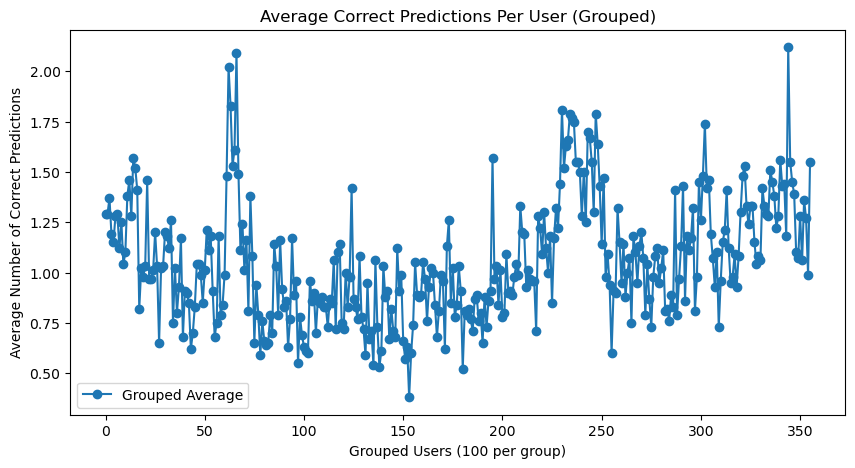

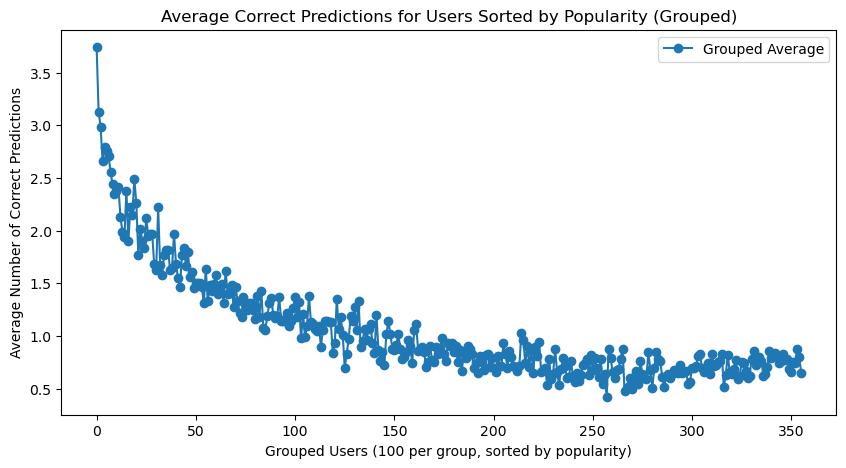

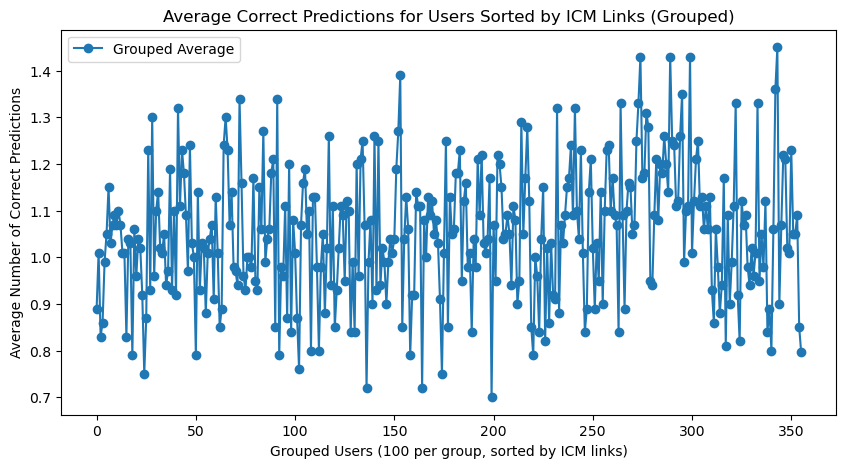

In [150]:
evaluator = EnhancedEvaluator(urm_validation, cutoff_list=[10])
evaluator.plot_correct_predictions_per_user(hybrid_model, group_size=100)
evaluator.plot_users_sorted_by_popularity(hybrid_model, urm_train, group_size=100)
evaluator.plot_users_sorted_by_icm_links(hybrid_model, icm_matrix, group_size=100)


# Hybrid + P3Alpha

In [11]:
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.GraphBased.RP3betaRecommenderICM import RP3betaRecommenderICM
import os
import json
import logging
from datetime import datetime
import optuna
from Evaluation.Evaluator import EvaluatorHoldout

def optimize_p3alpha_hybrid(urm_train, icm, urm_validation, rp3_slim_params, n_trials=30, output_folder="optimization_results"):
    os.makedirs(output_folder, exist_ok=True)
    log_file = os.path.join(output_folder, f'p3alpha_hybrid_optimization_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log')
    
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    
    evaluator_validation = EvaluatorHoldout(urm_validation, cutoff_list=[10])
    
    # Create and fit the first hybrid (RP3+SLIM) with optimal parameters ONCE before optimization
    logging.info("Fitting RP3 and SLIM recommenders...")
    
    # Fit RP3
    rp3beta_recommender = RP3betaRecommenderICM(URM_train=urm_train, ICM=icm)
    rp3beta_recommender.fit(
        topK=rp3_slim_params["rp3_topK"],
        alpha=rp3_slim_params["rp3_alpha"],
        beta=rp3_slim_params["rp3_beta"],
        delta=rp3_slim_params["rp3_delta"],
        min_rating=rp3_slim_params["rp3_min_rating"],
        implicit=rp3_slim_params["rp3_implicit"],
        normalize_similarity=rp3_slim_params["rp3_normalize"]
    )
    
    # Fit SLIM
    slim_recommender = SLIMElasticNetRecommender(URM_train=urm_train)
    slim_recommender.fit(
        l1_ratio=rp3_slim_params["slim_l1_ratio"],
        alpha=rp3_slim_params["slim_alpha"],
        positive_only=rp3_slim_params["slim_positive_only"],
        topK=rp3_slim_params["slim_topK"],
        do_feature_selection=True
    )
    
    # Create the RP3+SLIM hybrid
    rp3_slim_hybrid = HybridRecommender(
        URM_train=urm_train,
        recommender_list=[rp3beta_recommender, slim_recommender],
        recommender_weights=[rp3_slim_params["rp3beta_weight"], rp3_slim_params["slim_weight"]]
    )
    
    logging.info("Starting P3alpha optimization...")
    
    def objective(trial):
        try:
            # P3alpha parameters
            p3alpha_params = {
                "topK": trial.suggest_int("p3alpha_topK", 10, 200),
                "alpha": trial.suggest_float("p3alpha_alpha", 0.1, 1.5),
                "min_rating": trial.suggest_int("p3alpha_min_rating", 0, 5),
                "implicit": trial.suggest_categorical("p3alpha_implicit", [True, False]),
                "normalize_similarity": trial.suggest_categorical("p3alpha_normalize_similarity", [True, False])
            }
            
            # Weights for final hybrid
            hybrid_params = {
                "rp3_slim_weight": trial.suggest_float("rp3_slim_weight", 0.0, 1.0),
                "p3alpha_weight": trial.suggest_float("p3alpha_weight", 0.0, 1.0)
            }
            
            # Create and fit P3alpha recommender
            p3alpha_recommender = P3alphaRecommender(URM_train=urm_train)
            p3alpha_recommender.fit(**p3alpha_params)
            
            # Create final hybrid
            final_hybrid = HybridRecommender(
                URM_train=urm_train,
                recommender_list=[rp3_slim_hybrid, p3alpha_recommender],
                recommender_weights=[hybrid_params["rp3_slim_weight"], hybrid_params["p3alpha_weight"]]
            )
            
            # Evaluate
            results_df, _ = evaluator_validation.evaluateRecommender(final_hybrid)
            map_at_10 = results_df.loc[10]["MAP"]
            
            logging.info(f"\nTrial {trial.number} results:")
            logging.info(f"MAP@10: {map_at_10}")
            logging.info(f"P3alpha parameters: {p3alpha_params}")
            logging.info(f"RP3+SLIM weight: {hybrid_params['rp3_slim_weight']:.3f}")
            logging.info(f"P3alpha weight: {hybrid_params['p3alpha_weight']:.3f}")
            
            return map_at_10
            
        except Exception as e:
            logging.error(f"Error in trial {trial.number}: {str(e)}")
            raise optuna.exceptions.TrialPruned()
    
    study = optuna.create_study(direction="maximize")
    
    try:
        study.optimize(objective, n_trials=n_trials)
        
        best_params = study.best_params
        best_map = study.best_value
        
        logging.info("\nOptimization completed!")
        logging.info(f"Best MAP@10: {best_map}")
        logging.info("Best parameters:")
        logging.info(json.dumps(best_params, indent=2))
        
        try:
            from optuna.visualization import plot_optimization_history, plot_param_importances
            plot_optimization_history(study).write_image(os.path.join(output_folder, "p3alpha_hybrid_optimization_history.png"))
            plot_param_importances(study).write_image(os.path.join(output_folder, "p3alpha_hybrid_param_importances.png"))
        except ImportError:
            logging.warning("Plotly not installed. Skipping visualization generation.")
        
        return best_params, best_map
        
    except Exception as e:
        logging.error(f"Optimization failed: {str(e)}")
        raise


In [ ]:
p3_hyb_params, p3_hyb_map= optimize_p3alpha_hybrid(
    urm_train=urm_train,
    icm=icm_matrix, 
    urm_validation=urm_validation,
    rp3_slim_params=best_params,  # Use your existing RP3+SLIM best_params here
    n_trials=200
)

print(f"P3Alpha hybrid best MAP: {p3_hyb_map}")

2025-01-02 05:18:26,630 - INFO - Fitting RP3 and SLIM recommenders...


EvaluatorHoldout: Ignoring 187 ( 0.5%) Users that have less than 1 test interactions
RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.62 min. Items per second: 242
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 938.27 column/sec. Elapsed time 40.63 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.84 min. Items per second: 344.96


2025-01-02 05:23:38,461 - INFO - Starting P3alpha optimization...
[I 2025-01-02 05:23:38,466] A new study created in memory with name: no-name-b2a63882-b0c4-4b47-bb95-e7a8af3a8975


HybridRecommender: Initialized with 2 recommenders
P3alphaRecommender: Similarity column 38121 (100.0%), 2363.83 column/sec. Elapsed time 16.13 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 35549 (100.0%) in 36.13 sec. Users per second: 984


2025-01-02 05:24:32,881 - INFO - 
Trial 0 results:
2025-01-02 05:24:32,882 - INFO - MAP@10: 0.055175179620169025
2025-01-02 05:24:32,883 - INFO - P3alpha parameters: {'topK': 60, 'alpha': 0.7846133778831507, 'min_rating': 0, 'implicit': True, 'normalize_similarity': True}
2025-01-02 05:24:32,883 - INFO - RP3+SLIM weight: 0.994
2025-01-02 05:24:32,884 - INFO - P3alpha weight: 0.272
[I 2025-01-02 05:24:32,889] Trial 0 finished with value: 0.055175179620169025 and parameters: {'p3alpha_topK': 60, 'p3alpha_alpha': 0.7846133778831507, 'p3alpha_min_rating': 0, 'p3alpha_implicit': True, 'p3alpha_normalize_similarity': True, 'rp3_slim_weight': 0.9944285571875282, 'p3alpha_weight': 0.27240932093415715}. Best is trial 0 with value: 0.055175179620169025.


P3alphaRecommender: Similarity column 38121 (100.0%), 5264.72 column/sec. Elapsed time 7.24 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 35549 (100.0%) in 36.26 sec. Users per second: 981


2025-01-02 05:25:16,729 - INFO - 
Trial 1 results:
2025-01-02 05:25:16,730 - INFO - MAP@10: 0.05554620226854119
2025-01-02 05:25:16,731 - INFO - P3alpha parameters: {'topK': 99, 'alpha': 0.7839049038058904, 'min_rating': 2, 'implicit': False, 'normalize_similarity': True}
2025-01-02 05:25:16,732 - INFO - RP3+SLIM weight: 0.057
2025-01-02 05:25:16,732 - INFO - P3alpha weight: 0.008
[I 2025-01-02 05:25:16,735] Trial 1 finished with value: 0.05554620226854119 and parameters: {'p3alpha_topK': 99, 'p3alpha_alpha': 0.7839049038058904, 'p3alpha_min_rating': 2, 'p3alpha_implicit': False, 'p3alpha_normalize_similarity': True, 'rp3_slim_weight': 0.05707626510957886, 'p3alpha_weight': 0.008148409724134442}. Best is trial 1 with value: 0.05554620226854119.
2025-01-02 05:25:16,736 - INFO - 
Optimization completed!
2025-01-02 05:25:16,736 - INFO - Best MAP@10: 0.05554620226854119
2025-01-02 05:25:16,737 - INFO - Best parameters:
2025-01-02 05:25:16,738 - INFO - {
  "p3alpha_topK": 99,
  "p3alpha_alp

P3Alpha hybrid best MAP: 0.05554620226854119


# Fails

## Hybrid + ItemKNN

In [95]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

def optimize_itemknn_hybrid(urm_train, icm, urm_validation, rp3_slim_params, n_trials=30, output_folder="optimization_results"):
    os.makedirs(output_folder, exist_ok=True)
    log_file = os.path.join(output_folder, f'itemknn_hybrid_optimization_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log')
    
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    
    evaluator_validation = EvaluatorHoldout(urm_validation, cutoff_list=[10])
    
    # Create and fit the first hybrid (RP3+SLIM) with optimal parameters ONCE before optimization
    logging.info("Fitting RP3 and SLIM recommenders...")
    
    # Fit RP3
    rp3beta_recommender = RP3betaRecommenderICM(URM_train=urm_train, ICM=icm)
    rp3beta_recommender.fit(
        topK=rp3_slim_params["rp3_topK"],
        alpha=rp3_slim_params["rp3_alpha"],
        beta=rp3_slim_params["rp3_beta"],
        delta=rp3_slim_params["rp3_delta"],
        min_rating=rp3_slim_params["rp3_min_rating"],
        implicit=rp3_slim_params["rp3_implicit"],
        normalize_similarity=rp3_slim_params["rp3_normalize"]
    )
    
    # Fit SLIM
    slim_recommender = SLIMElasticNetRecommender(URM_train=urm_train)
    slim_recommender.fit(
        l1_ratio=rp3_slim_params["slim_l1_ratio"],
        alpha=rp3_slim_params["slim_alpha"],
        positive_only=rp3_slim_params["slim_positive_only"],
        topK=rp3_slim_params["slim_topK"],
        do_feature_selection=True
    )
    
    # Create the RP3+SLIM hybrid
    rp3_slim_hybrid = HybridRecommender(
        URM_train=urm_train,
        recommender_list=[rp3beta_recommender, slim_recommender],
        recommender_weights=[rp3_slim_params["rp3beta_weight"], rp3_slim_params["slim_weight"]]
    )
    
    logging.info("Starting ItemKNN optimization...")
    
    def objective(trial):
        try:
            # ItemKNN parameters
            itemknn_params = {
                "topK": trial.suggest_int("itemknn_topK", 10, 200),
                "shrink": trial.suggest_int("itemknn_shrink", 0, 300),
                "similarity": trial.suggest_categorical("itemknn_similarity", ["cosine", "asymmetric", "jaccard"]),
                "normalize": trial.suggest_categorical("itemknn_normalize", [True, False]),
                "feature_weighting": trial.suggest_categorical("itemknn_feature_weighting", ["BM25", "TF-IDF", "none"]),
                "asymmetric_alpha": trial.suggest_float("itemknn_asymmetric_alpha", 0.1, 2.0),
            }
            
            # Weights for final hybrid
            hybrid_params = {
                "rp3_slim_weight": trial.suggest_float("rp3_slim_weight", 0.0, 1.0),
                "itemknn_weight": trial.suggest_float("itemknn_weight", 0.0, 1.0)
            }
            
            # Create and fit ItemKNN recommender
            itemknn_recommender = ItemKNNCFRecommender(URM_train=urm_train)
            itemknn_recommender.fit(**itemknn_params)
            
            # Create final hybrid
            final_hybrid = HybridRecommender(
                URM_train=urm_train,
                recommender_list=[rp3_slim_hybrid, itemknn_recommender],
                recommender_weights=[hybrid_params["rp3_slim_weight"], hybrid_params["itemknn_weight"]]
            )
            
            # Evaluate
            results_df, _ = evaluator_validation.evaluateRecommender(final_hybrid)
            map_at_10 = results_df.loc[10]["MAP"]
            
            logging.info(f"\nTrial {trial.number} results:")
            logging.info(f"MAP@10: {map_at_10}")
            logging.info(f"ItemKNN parameters: {itemknn_params}")
            logging.info(f"RP3+SLIM weight: {hybrid_params['rp3_slim_weight']:.3f}")
            logging.info(f"ItemKNN weight: {hybrid_params['itemknn_weight']:.3f}")
            
            return map_at_10
            
        except Exception as e:
            logging.error(f"Error in trial {trial.number}: {str(e)}")
            raise optuna.exceptions.TrialPruned()
    
    study = optuna.create_study(direction="maximize")
    
    try:
        study.optimize(objective, n_trials=n_trials)
        
        best_params = study.best_params
        best_map = study.best_value
        
        logging.info("\nOptimization completed!")
        logging.info(f"Best MAP@10: {best_map}")
        logging.info("Best parameters:")
        logging.info(json.dumps(best_params, indent=2))
        
        try:
            from optuna.visualization import plot_optimization_history, plot_param_importances
            plot_optimization_history(study).write_image(os.path.join(output_folder, "itemknn_hybrid_optimization_history.png"))
            plot_param_importances(study).write_image(os.path.join(output_folder, "itemknn_hybrid_param_importances.png"))
        except ImportError:
            logging.warning("Plotly not installed. Skipping visualization generation.")
        
        return best_params, best_map
        
    except Exception as e:
        logging.error(f"Optimization failed: {str(e)}")
        raise

final_params, final_map = optimize_itemknn_hybrid(
    urm_train=urm_train,
    icm=icm_matrix, 
    urm_validation=urm_validation,
    rp3_slim_params=rp3_slim_params,
    n_trials=100
)

print(f"Final hybrid best MAP: {final_map}")

In [96]:
# Using the best_params you already have from your previous RP3+SLIM optimization
final_params, final_map = optimize_itemknn_hybrid(
    urm_train=urm_train,
    icm=icm_matrix, 
    urm_validation=urm_validation,
    rp3_slim_params=best_params,  # use your existing best_params here
    n_trials=150
)

print(f"Final hybrid best MAP: {final_map}")

2024-12-31 18:13:22,223 - INFO - Fitting RP3 and SLIM recommenders...


EvaluatorHoldout: Ignoring 1909 ( 5.3%) Users that have less than 1 test interactions
RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.52 min. Items per second: 252
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1164.14 column/sec. Elapsed time 32.75 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.28 min. Items per second: 494.95


2024-12-31 18:17:46,547 - INFO - Starting ItemKNN optimization...
[I 2024-12-31 18:17:46,549] A new study created in memory with name: no-name-f3fae16c-405a-49ce-8930-0bb4f6680b92


HybridRecommender: Initialized with 2 recommenders
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1140.83 column/sec. Elapsed time 33.42 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.03 sec. Users per second: 1090


2024-12-31 18:18:51,206 - INFO - 
Trial 0 results:
2024-12-31 18:18:51,207 - INFO - MAP@10: 0.016483208679457465
2024-12-31 18:18:51,208 - INFO - ItemKNN parameters: {'topK': 151, 'shrink': 142, 'similarity': 'cosine', 'normalize': False, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.4101866570258816}
2024-12-31 18:18:51,209 - INFO - RP3+SLIM weight: 0.023
2024-12-31 18:18:51,209 - INFO - ItemKNN weight: 0.747
[I 2024-12-31 18:18:51,216] Trial 0 finished with value: 0.016483208679457465 and parameters: {'itemknn_topK': 151, 'itemknn_shrink': 142, 'itemknn_similarity': 'cosine', 'itemknn_normalize': False, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.4101866570258816, 'rp3_slim_weight': 0.023027978265900195, 'itemknn_weight': 0.7467501184397508}. Best is trial 0 with value: 0.016483208679457465.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1190.79 column/sec. Elapsed time 32.01 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 28.56 sec. Users per second: 1184


2024-12-31 18:19:51,949 - INFO - 
Trial 1 results:
2024-12-31 18:19:51,951 - INFO - MAP@10: 0.0192466945489679
2024-12-31 18:19:51,951 - INFO - ItemKNN parameters: {'topK': 60, 'shrink': 259, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.47076593904349}
2024-12-31 18:19:51,952 - INFO - RP3+SLIM weight: 0.623
2024-12-31 18:19:51,953 - INFO - ItemKNN weight: 0.090
[I 2024-12-31 18:19:51,957] Trial 1 finished with value: 0.0192466945489679 and parameters: {'itemknn_topK': 60, 'itemknn_shrink': 259, 'itemknn_similarity': 'cosine', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.47076593904349, 'rp3_slim_weight': 0.6225037440285657, 'itemknn_weight': 0.09045251298637247}. Best is trial 1 with value: 0.0192466945489679.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1018.39 column/sec. Elapsed time 37.43 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 33.77 sec. Users per second: 1002


2024-12-31 18:21:03,438 - INFO - 
Trial 2 results:
2024-12-31 18:21:03,440 - INFO - MAP@10: 0.016917449008752104
2024-12-31 18:21:03,440 - INFO - ItemKNN parameters: {'topK': 165, 'shrink': 207, 'similarity': 'jaccard', 'normalize': False, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 0.565373691701816}
2024-12-31 18:21:03,441 - INFO - RP3+SLIM weight: 0.073
2024-12-31 18:21:03,441 - INFO - ItemKNN weight: 0.919
[I 2024-12-31 18:21:03,446] Trial 2 finished with value: 0.016917449008752104 and parameters: {'itemknn_topK': 165, 'itemknn_shrink': 207, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': False, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 0.565373691701816, 'rp3_slim_weight': 0.07323902485196676, 'itemknn_weight': 0.919258625612994}. Best is trial 1 with value: 0.0192466945489679.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1279.97 column/sec. Elapsed time 29.78 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 27.98 sec. Users per second: 1209


2024-12-31 18:22:01,390 - INFO - 
Trial 3 results:
2024-12-31 18:22:01,391 - INFO - MAP@10: 0.01649850710970552
2024-12-31 18:22:01,392 - INFO - ItemKNN parameters: {'topK': 32, 'shrink': 225, 'similarity': 'asymmetric', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.0763968257424277}
2024-12-31 18:22:01,393 - INFO - RP3+SLIM weight: 0.570
2024-12-31 18:22:01,393 - INFO - ItemKNN weight: 0.684
[I 2024-12-31 18:22:01,396] Trial 3 finished with value: 0.01649850710970552 and parameters: {'itemknn_topK': 32, 'itemknn_shrink': 225, 'itemknn_similarity': 'asymmetric', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.0763968257424277, 'rp3_slim_weight': 0.5697224930465116, 'itemknn_weight': 0.6836811727294912}. Best is trial 1 with value: 0.0192466945489679.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1112.83 column/sec. Elapsed time 34.26 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.41 sec. Users per second: 1077


2024-12-31 18:23:07,382 - INFO - 
Trial 4 results:
2024-12-31 18:23:07,383 - INFO - MAP@10: 0.016394196004788395
2024-12-31 18:23:07,384 - INFO - ItemKNN parameters: {'topK': 174, 'shrink': 1, 'similarity': 'cosine', 'normalize': False, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.4647347034407672}
2024-12-31 18:23:07,384 - INFO - RP3+SLIM weight: 0.298
2024-12-31 18:23:07,385 - INFO - ItemKNN weight: 0.771
[I 2024-12-31 18:23:07,394] Trial 4 finished with value: 0.016394196004788395 and parameters: {'itemknn_topK': 174, 'itemknn_shrink': 1, 'itemknn_similarity': 'cosine', 'itemknn_normalize': False, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.4647347034407672, 'rp3_slim_weight': 0.29768572653239567, 'itemknn_weight': 0.7708832575315983}. Best is trial 1 with value: 0.0192466945489679.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1177.56 column/sec. Elapsed time 32.37 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 36.13 sec. Users per second: 936


2024-12-31 18:24:16,036 - INFO - 
Trial 5 results:
2024-12-31 18:24:16,037 - INFO - MAP@10: 0.017850067875713208
2024-12-31 18:24:16,038 - INFO - ItemKNN parameters: {'topK': 131, 'shrink': 198, 'similarity': 'cosine', 'normalize': False, 'feature_weighting': 'none', 'asymmetric_alpha': 1.4470974225924722}
2024-12-31 18:24:16,038 - INFO - RP3+SLIM weight: 0.494
2024-12-31 18:24:16,039 - INFO - ItemKNN weight: 0.272
[I 2024-12-31 18:24:16,044] Trial 5 finished with value: 0.017850067875713208 and parameters: {'itemknn_topK': 131, 'itemknn_shrink': 198, 'itemknn_similarity': 'cosine', 'itemknn_normalize': False, 'itemknn_feature_weighting': 'none', 'itemknn_asymmetric_alpha': 1.4470974225924722, 'rp3_slim_weight': 0.49391650192454195, 'itemknn_weight': 0.27225302884210767}. Best is trial 1 with value: 0.0192466945489679.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1088.46 column/sec. Elapsed time 35.02 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 30.80 sec. Users per second: 1098


2024-12-31 18:25:22,069 - INFO - 
Trial 6 results:
2024-12-31 18:25:22,070 - INFO - MAP@10: 0.019538230473356177
2024-12-31 18:25:22,071 - INFO - ItemKNN parameters: {'topK': 114, 'shrink': 59, 'similarity': 'jaccard', 'normalize': False, 'feature_weighting': 'none', 'asymmetric_alpha': 0.5982152352938213}
2024-12-31 18:25:22,072 - INFO - RP3+SLIM weight: 0.309
2024-12-31 18:25:22,072 - INFO - ItemKNN weight: 0.838
[I 2024-12-31 18:25:22,079] Trial 6 finished with value: 0.019538230473356177 and parameters: {'itemknn_topK': 114, 'itemknn_shrink': 59, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': False, 'itemknn_feature_weighting': 'none', 'itemknn_asymmetric_alpha': 0.5982152352938213, 'rp3_slim_weight': 0.30939962974858604, 'itemknn_weight': 0.8378596477665087}. Best is trial 6 with value: 0.019538230473356177.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1190.17 column/sec. Elapsed time 32.03 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 35.97 sec. Users per second: 940


2024-12-31 18:26:30,288 - INFO - 
Trial 7 results:
2024-12-31 18:26:30,290 - INFO - MAP@10: 0.013385304122141967
2024-12-31 18:26:30,291 - INFO - ItemKNN parameters: {'topK': 125, 'shrink': 8, 'similarity': 'asymmetric', 'normalize': False, 'feature_weighting': 'none', 'asymmetric_alpha': 0.3206191099773576}
2024-12-31 18:26:30,291 - INFO - RP3+SLIM weight: 0.337
2024-12-31 18:26:30,291 - INFO - ItemKNN weight: 0.920
[I 2024-12-31 18:26:30,297] Trial 7 finished with value: 0.013385304122141967 and parameters: {'itemknn_topK': 125, 'itemknn_shrink': 8, 'itemknn_similarity': 'asymmetric', 'itemknn_normalize': False, 'itemknn_feature_weighting': 'none', 'itemknn_asymmetric_alpha': 0.3206191099773576, 'rp3_slim_weight': 0.3365686977512893, 'itemknn_weight': 0.9202033234296487}. Best is trial 6 with value: 0.019538230473356177.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1184.73 column/sec. Elapsed time 32.18 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 29.10 sec. Users per second: 1163


2024-12-31 18:27:31,737 - INFO - 
Trial 8 results:
2024-12-31 18:27:31,739 - INFO - MAP@10: 0.01892126299973574
2024-12-31 18:27:31,739 - INFO - ItemKNN parameters: {'topK': 77, 'shrink': 131, 'similarity': 'asymmetric', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 0.4303119330026906}
2024-12-31 18:27:31,740 - INFO - RP3+SLIM weight: 0.473
2024-12-31 18:27:31,740 - INFO - ItemKNN weight: 0.996
[I 2024-12-31 18:27:31,745] Trial 8 finished with value: 0.01892126299973574 and parameters: {'itemknn_topK': 77, 'itemknn_shrink': 131, 'itemknn_similarity': 'asymmetric', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 0.4303119330026906, 'rp3_slim_weight': 0.4728049020750693, 'itemknn_weight': 0.9956875906866923}. Best is trial 6 with value: 0.019538230473356177.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1194.89 column/sec. Elapsed time 31.90 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 37.55 sec. Users per second: 901


2024-12-31 18:28:41,365 - INFO - 
Trial 9 results:
2024-12-31 18:28:41,367 - INFO - MAP@10: 0.013498575384273608
2024-12-31 18:28:41,368 - INFO - ItemKNN parameters: {'topK': 114, 'shrink': 29, 'similarity': 'cosine', 'normalize': False, 'feature_weighting': 'none', 'asymmetric_alpha': 0.9558438200263155}
2024-12-31 18:28:41,368 - INFO - RP3+SLIM weight: 0.093
2024-12-31 18:28:41,369 - INFO - ItemKNN weight: 0.956
[I 2024-12-31 18:28:41,373] Trial 9 finished with value: 0.013498575384273608 and parameters: {'itemknn_topK': 114, 'itemknn_shrink': 29, 'itemknn_similarity': 'cosine', 'itemknn_normalize': False, 'itemknn_feature_weighting': 'none', 'itemknn_asymmetric_alpha': 0.9558438200263155, 'rp3_slim_weight': 0.09254899344858603, 'itemknn_weight': 0.9564129952008439}. Best is trial 6 with value: 0.019538230473356177.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1020.55 column/sec. Elapsed time 37.35 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 33.58 sec. Users per second: 1007


2024-12-31 18:29:52,603 - INFO - 
Trial 10 results:
2024-12-31 18:29:52,605 - INFO - MAP@10: 0.0217415868605005
2024-12-31 18:29:52,605 - INFO - ItemKNN parameters: {'topK': 196, 'shrink': 86, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'none', 'asymmetric_alpha': 0.10146484394395183}
2024-12-31 18:29:52,606 - INFO - RP3+SLIM weight: 0.931
2024-12-31 18:29:52,606 - INFO - ItemKNN weight: 0.483
[I 2024-12-31 18:29:52,612] Trial 10 finished with value: 0.0217415868605005 and parameters: {'itemknn_topK': 196, 'itemknn_shrink': 86, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'none', 'itemknn_asymmetric_alpha': 0.10146484394395183, 'rp3_slim_weight': 0.9309163891780271, 'itemknn_weight': 0.48330632366187765}. Best is trial 10 with value: 0.0217415868605005.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 993.81 column/sec. Elapsed time 38.36 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 33.62 sec. Users per second: 1006


2024-12-31 18:31:04,898 - INFO - 
Trial 11 results:
2024-12-31 18:31:04,900 - INFO - MAP@10: 0.021887920844671047
2024-12-31 18:31:04,900 - INFO - ItemKNN parameters: {'topK': 190, 'shrink': 82, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'none', 'asymmetric_alpha': 0.18539977971745225}
2024-12-31 18:31:04,901 - INFO - RP3+SLIM weight: 0.994
2024-12-31 18:31:04,901 - INFO - ItemKNN weight: 0.471
[I 2024-12-31 18:31:04,907] Trial 11 finished with value: 0.021887920844671047 and parameters: {'itemknn_topK': 190, 'itemknn_shrink': 82, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'none', 'itemknn_asymmetric_alpha': 0.18539977971745225, 'rp3_slim_weight': 0.9943135297343055, 'itemknn_weight': 0.4714363455447545}. Best is trial 11 with value: 0.021887920844671047.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1020.32 column/sec. Elapsed time 37.36 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 34.58 sec. Users per second: 978


2024-12-31 18:32:17,106 - INFO - 
Trial 12 results:
2024-12-31 18:32:17,108 - INFO - MAP@10: 0.02177002051990938
2024-12-31 18:32:17,109 - INFO - ItemKNN parameters: {'topK': 199, 'shrink': 89, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'none', 'asymmetric_alpha': 0.25705824893169127}
2024-12-31 18:32:17,109 - INFO - RP3+SLIM weight: 0.956
2024-12-31 18:32:17,110 - INFO - ItemKNN weight: 0.478
[I 2024-12-31 18:32:17,117] Trial 12 finished with value: 0.02177002051990938 and parameters: {'itemknn_topK': 199, 'itemknn_shrink': 89, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'none', 'itemknn_asymmetric_alpha': 0.25705824893169127, 'rp3_slim_weight': 0.9564245988425927, 'itemknn_weight': 0.47768989748935536}. Best is trial 11 with value: 0.021887920844671047.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 987.24 column/sec. Elapsed time 38.61 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 34.19 sec. Users per second: 989


2024-12-31 18:33:30,223 - INFO - 
Trial 13 results:
2024-12-31 18:33:30,224 - INFO - MAP@10: 0.02176592873824342
2024-12-31 18:33:30,225 - INFO - ItemKNN parameters: {'topK': 200, 'shrink': 94, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'none', 'asymmetric_alpha': 0.11684971023913526}
2024-12-31 18:33:30,225 - INFO - RP3+SLIM weight: 0.964
2024-12-31 18:33:30,226 - INFO - ItemKNN weight: 0.487
[I 2024-12-31 18:33:30,241] Trial 13 finished with value: 0.02176592873824342 and parameters: {'itemknn_topK': 200, 'itemknn_shrink': 94, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'none', 'itemknn_asymmetric_alpha': 0.11684971023913526, 'rp3_slim_weight': 0.9641762612474817, 'itemknn_weight': 0.4874958377394902}. Best is trial 11 with value: 0.021887920844671047.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 910.09 column/sec. Elapsed time 41.89 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.82 sec. Users per second: 1031


2024-12-31 18:34:45,388 - INFO - 
Trial 14 results:
2024-12-31 18:34:45,391 - INFO - MAP@10: 0.021976102962740385
2024-12-31 18:34:45,391 - INFO - ItemKNN parameters: {'topK': 181, 'shrink': 104, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'none', 'asymmetric_alpha': 0.8539304472114708}
2024-12-31 18:34:45,392 - INFO - RP3+SLIM weight: 0.792
2024-12-31 18:34:45,392 - INFO - ItemKNN weight: 0.349
[I 2024-12-31 18:34:45,400] Trial 14 finished with value: 0.021976102962740385 and parameters: {'itemknn_topK': 181, 'itemknn_shrink': 104, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'none', 'itemknn_asymmetric_alpha': 0.8539304472114708, 'rp3_slim_weight': 0.7924908575286211, 'itemknn_weight': 0.34941820936086554}. Best is trial 14 with value: 0.021976102962740385.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1059.85 column/sec. Elapsed time 35.97 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 34.07 sec. Users per second: 993


2024-12-31 18:35:55,651 - INFO - 
Trial 15 results:
2024-12-31 18:35:55,653 - INFO - MAP@10: 0.022343911668193637
2024-12-31 18:35:55,653 - INFO - ItemKNN parameters: {'topK': 146, 'shrink': 168, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'none', 'asymmetric_alpha': 1.853942687268709}
2024-12-31 18:35:55,654 - INFO - RP3+SLIM weight: 0.765
2024-12-31 18:35:55,654 - INFO - ItemKNN weight: 0.262
[I 2024-12-31 18:35:55,663] Trial 15 finished with value: 0.022343911668193637 and parameters: {'itemknn_topK': 146, 'itemknn_shrink': 168, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'none', 'itemknn_asymmetric_alpha': 1.853942687268709, 'rp3_slim_weight': 0.7649528804871828, 'itemknn_weight': 0.2617682346064582}. Best is trial 15 with value: 0.022343911668193637.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1054.43 column/sec. Elapsed time 36.15 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.86 sec. Users per second: 1029


2024-12-31 18:37:04,970 - INFO - 
Trial 16 results:
2024-12-31 18:37:04,972 - INFO - MAP@10: 0.019484376854968337
2024-12-31 18:37:04,972 - INFO - ItemKNN parameters: {'topK': 144, 'shrink': 170, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.9778170394933947}
2024-12-31 18:37:04,973 - INFO - RP3+SLIM weight: 0.743
2024-12-31 18:37:04,973 - INFO - ItemKNN weight: 0.273
[I 2024-12-31 18:37:04,980] Trial 16 finished with value: 0.019484376854968337 and parameters: {'itemknn_topK': 144, 'itemknn_shrink': 170, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.9778170394933947, 'rp3_slim_weight': 0.7427337536895562, 'itemknn_weight': 0.27338865735539597}. Best is trial 15 with value: 0.022343911668193637.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1038.17 column/sec. Elapsed time 36.72 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 34.93 sec. Users per second: 968


2024-12-31 18:38:16,914 - INFO - 
Trial 17 results:
2024-12-31 18:38:16,915 - INFO - MAP@10: 0.022287829154976315
2024-12-31 18:38:16,916 - INFO - ItemKNN parameters: {'topK': 164, 'shrink': 272, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'none', 'asymmetric_alpha': 1.9117849945371124}
2024-12-31 18:38:16,916 - INFO - RP3+SLIM weight: 0.752
2024-12-31 18:38:16,917 - INFO - ItemKNN weight: 0.281
[I 2024-12-31 18:38:16,923] Trial 17 finished with value: 0.022287829154976315 and parameters: {'itemknn_topK': 164, 'itemknn_shrink': 272, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'none', 'itemknn_asymmetric_alpha': 1.9117849945371124, 'rp3_slim_weight': 0.7518306752833755, 'itemknn_weight': 0.28090032219670225}. Best is trial 15 with value: 0.022343911668193637.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 553.00 column/sec. Elapsed time 1.15 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33000 (97.6%) in 10.08 min. Users per second: 55
EvaluatorHoldout: Processed 33827 (100.0%) in 10.15 min. Users per second: 56


2024-12-31 18:49:34,800 - INFO - 
Trial 18 results:
2024-12-31 18:49:34,807 - INFO - MAP@10: 0.023055990776598152
2024-12-31 18:49:34,808 - INFO - ItemKNN parameters: {'topK': 89, 'shrink': 299, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'none', 'asymmetric_alpha': 1.989105160700791}
2024-12-31 18:49:34,809 - INFO - RP3+SLIM weight: 0.768
2024-12-31 18:49:34,809 - INFO - ItemKNN weight: 0.025
[I 2024-12-31 18:49:34,819] Trial 18 finished with value: 0.023055990776598152 and parameters: {'itemknn_topK': 89, 'itemknn_shrink': 299, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'none', 'itemknn_asymmetric_alpha': 1.989105160700791, 'rp3_slim_weight': 0.7676930905346755, 'itemknn_weight': 0.025104901488147813}. Best is trial 18 with value: 0.023055990776598152.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 851.46 column/sec. Elapsed time 44.77 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 41.23 sec. Users per second: 820


2024-12-31 18:51:01,105 - INFO - 
Trial 19 results:
2024-12-31 18:51:01,108 - INFO - MAP@10: 0.022926585835208714
2024-12-31 18:51:01,109 - INFO - ItemKNN parameters: {'topK': 81, 'shrink': 293, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.685681976105013}
2024-12-31 18:51:01,109 - INFO - RP3+SLIM weight: 0.805
2024-12-31 18:51:01,109 - INFO - ItemKNN weight: 0.016
[I 2024-12-31 18:51:01,117] Trial 19 finished with value: 0.022926585835208714 and parameters: {'itemknn_topK': 81, 'itemknn_shrink': 293, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.685681976105013, 'rp3_slim_weight': 0.8048341722423877, 'itemknn_weight': 0.01648009796961737}. Best is trial 18 with value: 0.023055990776598152.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1063.82 column/sec. Elapsed time 35.83 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 44.43 sec. Users per second: 761


2024-12-31 18:52:21,582 - INFO - 
Trial 20 results:
2024-12-31 18:52:21,584 - INFO - MAP@10: 0.01861137505918308
2024-12-31 18:52:21,585 - INFO - ItemKNN parameters: {'topK': 90, 'shrink': 296, 'similarity': 'asymmetric', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.6544374666005874}
2024-12-31 18:52:21,586 - INFO - RP3+SLIM weight: 0.650
2024-12-31 18:52:21,586 - INFO - ItemKNN weight: 0.011
[I 2024-12-31 18:52:21,592] Trial 20 finished with value: 0.01861137505918308 and parameters: {'itemknn_topK': 90, 'itemknn_shrink': 296, 'itemknn_similarity': 'asymmetric', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.6544374666005874, 'rp3_slim_weight': 0.6495668809270548, 'itemknn_weight': 0.01069605902800419}. Best is trial 18 with value: 0.023055990776598152.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1115.87 column/sec. Elapsed time 34.16 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 30.82 sec. Users per second: 1098


2024-12-31 18:53:26,787 - INFO - 
Trial 21 results:
2024-12-31 18:53:26,789 - INFO - MAP@10: 0.021440052583148017
2024-12-31 18:53:26,789 - INFO - ItemKNN parameters: {'topK': 63, 'shrink': 246, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.7335932357956438}
2024-12-31 18:53:26,790 - INFO - RP3+SLIM weight: 0.837
2024-12-31 18:53:26,790 - INFO - ItemKNN weight: 0.118
[I 2024-12-31 18:53:26,794] Trial 21 finished with value: 0.021440052583148017 and parameters: {'itemknn_topK': 63, 'itemknn_shrink': 246, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.7335932357956438, 'rp3_slim_weight': 0.8367155824676157, 'itemknn_weight': 0.11804425833125934}. Best is trial 18 with value: 0.023055990776598152.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1095.02 column/sec. Elapsed time 34.81 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 34.62 sec. Users per second: 977


2024-12-31 18:54:36,472 - INFO - 
Trial 22 results:
2024-12-31 18:54:36,474 - INFO - MAP@10: 0.021207267980259622
2024-12-31 18:54:36,475 - INFO - ItemKNN parameters: {'topK': 91, 'shrink': 297, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.7699505360765457}
2024-12-31 18:54:36,475 - INFO - RP3+SLIM weight: 0.881
2024-12-31 18:54:36,475 - INFO - ItemKNN weight: 0.136
[I 2024-12-31 18:54:36,484] Trial 22 finished with value: 0.021207267980259622 and parameters: {'itemknn_topK': 91, 'itemknn_shrink': 297, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.7699505360765457, 'rp3_slim_weight': 0.8806495765945063, 'itemknn_weight': 0.13623419821925503}. Best is trial 18 with value: 0.023055990776598152.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1146.03 column/sec. Elapsed time 33.26 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 29.72 sec. Users per second: 1138


2024-12-31 18:55:39,690 - INFO - 
Trial 23 results:
2024-12-31 18:55:39,691 - INFO - MAP@10: 0.023098194313643086
2024-12-31 18:55:39,692 - INFO - ItemKNN parameters: {'topK': 35, 'shrink': 177, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.2106934085920034}
2024-12-31 18:55:39,693 - INFO - RP3+SLIM weight: 0.684
2024-12-31 18:55:39,693 - INFO - ItemKNN weight: 0.001
[I 2024-12-31 18:55:39,699] Trial 23 finished with value: 0.023098194313643086 and parameters: {'itemknn_topK': 35, 'itemknn_shrink': 177, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.2106934085920034, 'rp3_slim_weight': 0.6844133789888539, 'itemknn_weight': 0.0006951840197721403}. Best is trial 23 with value: 0.023098194313643086.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1233.16 column/sec. Elapsed time 30.91 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 27.94 sec. Users per second: 1211


2024-12-31 18:56:38,727 - INFO - 
Trial 24 results:
2024-12-31 18:56:38,729 - INFO - MAP@10: 0.023058312346528446
2024-12-31 18:56:38,730 - INFO - ItemKNN parameters: {'topK': 10, 'shrink': 233, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.1801471606488474}
2024-12-31 18:56:38,730 - INFO - RP3+SLIM weight: 0.680
2024-12-31 18:56:38,730 - INFO - ItemKNN weight: 0.018
[I 2024-12-31 18:56:38,736] Trial 24 finished with value: 0.023058312346528446 and parameters: {'itemknn_topK': 10, 'itemknn_shrink': 233, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.1801471606488474, 'rp3_slim_weight': 0.6796681998348336, 'itemknn_weight': 0.018067476869146053}. Best is trial 23 with value: 0.023098194313643086.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1218.72 column/sec. Elapsed time 31.28 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 28.08 sec. Users per second: 1205


2024-12-31 18:57:38,321 - INFO - 
Trial 25 results:
2024-12-31 18:57:38,323 - INFO - MAP@10: 0.021305531741573652
2024-12-31 18:57:38,323 - INFO - ItemKNN parameters: {'topK': 11, 'shrink': 229, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.2079106477186412}
2024-12-31 18:57:38,324 - INFO - RP3+SLIM weight: 0.665
2024-12-31 18:57:38,324 - INFO - ItemKNN weight: 0.173
[I 2024-12-31 18:57:38,329] Trial 25 finished with value: 0.021305531741573652 and parameters: {'itemknn_topK': 11, 'itemknn_shrink': 229, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.2079106477186412, 'rp3_slim_weight': 0.6654441745696601, 'itemknn_weight': 0.17333358067328883}. Best is trial 23 with value: 0.023098194313643086.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1200.89 column/sec. Elapsed time 31.74 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 29.11 sec. Users per second: 1162


2024-12-31 18:58:39,371 - INFO - 
Trial 26 results:
2024-12-31 18:58:39,373 - INFO - MAP@10: 0.022018010877944895
2024-12-31 18:58:39,373 - INFO - ItemKNN parameters: {'topK': 28, 'shrink': 191, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 0.7723345308361521}
2024-12-31 18:58:39,374 - INFO - RP3+SLIM weight: 0.406
2024-12-31 18:58:39,374 - INFO - ItemKNN weight: 0.050
[I 2024-12-31 18:58:39,380] Trial 26 finished with value: 0.022018010877944895 and parameters: {'itemknn_topK': 28, 'itemknn_shrink': 191, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 0.7723345308361521, 'rp3_slim_weight': 0.40645761954364434, 'itemknn_weight': 0.049791050998661074}. Best is trial 23 with value: 0.023098194313643086.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1149.01 column/sec. Elapsed time 33.18 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 30.07 sec. Users per second: 1125


2024-12-31 18:59:42,834 - INFO - 
Trial 27 results:
2024-12-31 18:59:42,835 - INFO - MAP@10: 0.018670478311445655
2024-12-31 18:59:42,836 - INFO - ItemKNN parameters: {'topK': 42, 'shrink': 271, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.229106837835936}
2024-12-31 18:59:42,837 - INFO - RP3+SLIM weight: 0.565
2024-12-31 18:59:42,837 - INFO - ItemKNN weight: 0.595
[I 2024-12-31 18:59:42,842] Trial 27 finished with value: 0.018670478311445655 and parameters: {'itemknn_topK': 42, 'itemknn_shrink': 271, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.229106837835936, 'rp3_slim_weight': 0.5648906258376323, 'itemknn_weight': 0.5949183985294212}. Best is trial 23 with value: 0.023098194313643086.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1198.97 column/sec. Elapsed time 31.79 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 28.36 sec. Users per second: 1193


2024-12-31 19:00:43,184 - INFO - 
Trial 28 results:
2024-12-31 19:00:43,186 - INFO - MAP@10: 0.021053938785632123
2024-12-31 19:00:43,186 - INFO - ItemKNN parameters: {'topK': 17, 'shrink': 229, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.2264775155571273}
2024-12-31 19:00:43,187 - INFO - RP3+SLIM weight: 0.694
2024-12-31 19:00:43,189 - INFO - ItemKNN weight: 0.194
[I 2024-12-31 19:00:43,194] Trial 28 finished with value: 0.021053938785632123 and parameters: {'itemknn_topK': 17, 'itemknn_shrink': 229, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.2264775155571273, 'rp3_slim_weight': 0.6943136280968005, 'itemknn_weight': 0.19444566477360012}. Best is trial 23 with value: 0.023098194313643086.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1192.18 column/sec. Elapsed time 31.98 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 28.92 sec. Users per second: 1170


2024-12-31 19:01:44,360 - INFO - 
Trial 29 results:
2024-12-31 19:01:44,361 - INFO - MAP@10: 0.018149715804178325
2024-12-31 19:01:44,362 - INFO - ItemKNN parameters: {'topK': 47, 'shrink': 145, 'similarity': 'asymmetric', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.3447961536720776}
2024-12-31 19:01:44,362 - INFO - RP3+SLIM weight: 0.575
2024-12-31 19:01:44,363 - INFO - ItemKNN weight: 0.085
[I 2024-12-31 19:01:44,368] Trial 29 finished with value: 0.018149715804178325 and parameters: {'itemknn_topK': 47, 'itemknn_shrink': 145, 'itemknn_similarity': 'asymmetric', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.3447961536720776, 'rp3_slim_weight': 0.5745286452579395, 'itemknn_weight': 0.08534024892045892}. Best is trial 23 with value: 0.023098194313643086.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1213.63 column/sec. Elapsed time 31.41 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 59.95 sec. Users per second: 564


2024-12-31 19:03:15,930 - INFO - 
Trial 30 results:
2024-12-31 19:03:15,931 - INFO - MAP@10: 0.023103957766431128
2024-12-31 19:03:15,933 - INFO - ItemKNN parameters: {'topK': 53, 'shrink': 167, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.5597552265612005}
2024-12-31 19:03:15,933 - INFO - RP3+SLIM weight: 0.882
2024-12-31 19:03:15,934 - INFO - ItemKNN weight: 0.000
[I 2024-12-31 19:03:15,939] Trial 30 finished with value: 0.023103957766431128 and parameters: {'itemknn_topK': 53, 'itemknn_shrink': 167, 'itemknn_similarity': 'cosine', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.5597552265612005, 'rp3_slim_weight': 0.8818299371729671, 'itemknn_weight': 0.00021901646264599686}. Best is trial 30 with value: 0.023103957766431128.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1254.84 column/sec. Elapsed time 30.38 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 7000 (20.7%) in 6.86 min. Users per second: 17
EvaluatorHoldout: Processed 33827 (100.0%) in 7.35 min. Users per second: 77


2024-12-31 19:11:07,717 - INFO - 
Trial 31 results:
2024-12-31 19:11:07,718 - INFO - MAP@10: 0.02240634066616226
2024-12-31 19:11:07,719 - INFO - ItemKNN parameters: {'topK': 54, 'shrink': 123, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.5773740425329357}
2024-12-31 19:11:07,719 - INFO - RP3+SLIM weight: 0.871
2024-12-31 19:11:07,720 - INFO - ItemKNN weight: 0.022
[I 2024-12-31 19:11:07,726] Trial 31 finished with value: 0.02240634066616226 and parameters: {'itemknn_topK': 54, 'itemknn_shrink': 123, 'itemknn_similarity': 'cosine', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.5773740425329357, 'rp3_slim_weight': 0.8709286352432581, 'itemknn_weight': 0.022375308315789957}. Best is trial 30 with value: 0.023103957766431128.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1287.32 column/sec. Elapsed time 29.61 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 28.11 sec. Users per second: 1203


2024-12-31 19:12:05,643 - INFO - 
Trial 32 results:
2024-12-31 19:12:05,645 - INFO - MAP@10: 0.02075226842838489
2024-12-31 19:12:05,645 - INFO - ItemKNN parameters: {'topK': 30, 'shrink': 183, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.0980967946829807}
2024-12-31 19:12:05,646 - INFO - RP3+SLIM weight: 0.683
2024-12-31 19:12:05,647 - INFO - ItemKNN weight: 0.089
[I 2024-12-31 19:12:05,651] Trial 32 finished with value: 0.02075226842838489 and parameters: {'itemknn_topK': 30, 'itemknn_shrink': 183, 'itemknn_similarity': 'cosine', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.0980967946829807, 'rp3_slim_weight': 0.682855119410059, 'itemknn_weight': 0.08859037789843138}. Best is trial 30 with value: 0.023103957766431128.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1262.12 column/sec. Elapsed time 30.20 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 28.53 sec. Users per second: 1186


2024-12-31 19:13:04,577 - INFO - 
Trial 33 results:
2024-12-31 19:13:04,579 - INFO - MAP@10: 0.019304603582842757
2024-12-31 19:13:04,579 - INFO - ItemKNN parameters: {'topK': 65, 'shrink': 162, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.3583736720822759}
2024-12-31 19:13:04,580 - INFO - RP3+SLIM weight: 0.891
2024-12-31 19:13:04,580 - INFO - ItemKNN weight: 0.387
[I 2024-12-31 19:13:04,584] Trial 33 finished with value: 0.019304603582842757 and parameters: {'itemknn_topK': 65, 'itemknn_shrink': 162, 'itemknn_similarity': 'cosine', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.3583736720822759, 'rp3_slim_weight': 0.8912452190000812, 'itemknn_weight': 0.3867184364243107}. Best is trial 30 with value: 0.023103957766431128.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1323.04 column/sec. Elapsed time 28.81 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 29.09 sec. Users per second: 1163


2024-12-31 19:14:02,633 - INFO - 
Trial 34 results:
2024-12-31 19:14:02,635 - INFO - MAP@10: 0.01845189880723618
2024-12-31 19:14:02,636 - INFO - ItemKNN parameters: {'topK': 21, 'shrink': 248, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.529567661951049}
2024-12-31 19:14:02,636 - INFO - RP3+SLIM weight: 0.721
2024-12-31 19:14:02,636 - INFO - ItemKNN weight: 0.184
[I 2024-12-31 19:14:02,640] Trial 34 finished with value: 0.01845189880723618 and parameters: {'itemknn_topK': 21, 'itemknn_shrink': 248, 'itemknn_similarity': 'cosine', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.529567661951049, 'rp3_slim_weight': 0.7207907666872853, 'itemknn_weight': 0.18393615097045257}. Best is trial 30 with value: 0.023103957766431128.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1309.18 column/sec. Elapsed time 29.12 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 28.66 sec. Users per second: 1180


2024-12-31 19:15:00,576 - INFO - 
Trial 35 results:
2024-12-31 19:15:00,578 - INFO - MAP@10: 0.020800146262424664
2024-12-31 19:15:00,579 - INFO - ItemKNN parameters: {'topK': 36, 'shrink': 214, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 0.9139413707178027}
2024-12-31 19:15:00,579 - INFO - RP3+SLIM weight: 0.605
2024-12-31 19:15:00,579 - INFO - ItemKNN weight: 0.073
[I 2024-12-31 19:15:00,583] Trial 35 finished with value: 0.020800146262424664 and parameters: {'itemknn_topK': 36, 'itemknn_shrink': 214, 'itemknn_similarity': 'cosine', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 0.9139413707178027, 'rp3_slim_weight': 0.6050687233405035, 'itemknn_weight': 0.07289533695479442}. Best is trial 30 with value: 0.023103957766431128.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1336.05 column/sec. Elapsed time 28.53 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 28.79 sec. Users per second: 1175


2024-12-31 19:15:58,110 - INFO - 
Trial 36 results:
2024-12-31 19:15:58,111 - INFO - MAP@10: 0.017221717788129382
2024-12-31 19:15:58,112 - INFO - ItemKNN parameters: {'topK': 48, 'shrink': 209, 'similarity': 'cosine', 'normalize': False, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.3156902786036255}
2024-12-31 19:15:58,112 - INFO - RP3+SLIM weight: 0.828
2024-12-31 19:15:58,113 - INFO - ItemKNN weight: 0.123
[I 2024-12-31 19:15:58,117] Trial 36 finished with value: 0.017221717788129382 and parameters: {'itemknn_topK': 48, 'itemknn_shrink': 209, 'itemknn_similarity': 'cosine', 'itemknn_normalize': False, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.3156902786036255, 'rp3_slim_weight': 0.8279887191806674, 'itemknn_weight': 0.12334900853461692}. Best is trial 30 with value: 0.023103957766431128.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1178.69 column/sec. Elapsed time 32.34 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 30.89 sec. Users per second: 1095


2024-12-31 19:17:01,649 - INFO - 
Trial 37 results:
2024-12-31 19:17:01,650 - INFO - MAP@10: 0.023094636293633727
2024-12-31 19:17:01,650 - INFO - ItemKNN parameters: {'topK': 72, 'shrink': 268, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.0901900583010429}
2024-12-31 19:17:01,651 - INFO - RP3+SLIM weight: 0.625
2024-12-31 19:17:01,651 - INFO - ItemKNN weight: 0.000
[I 2024-12-31 19:17:01,655] Trial 37 finished with value: 0.023094636293633727 and parameters: {'itemknn_topK': 72, 'itemknn_shrink': 268, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.0901900583010429, 'rp3_slim_weight': 0.6249157086589532, 'itemknn_weight': 0.00016404046630886886}. Best is trial 30 with value: 0.023103957766431128.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1322.14 column/sec. Elapsed time 28.83 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 33.80 sec. Users per second: 1001


2024-12-31 19:18:04,447 - INFO - 
Trial 38 results:
2024-12-31 19:18:04,448 - INFO - MAP@10: 0.014153781308347635
2024-12-31 19:18:04,449 - INFO - ItemKNN parameters: {'topK': 66, 'shrink': 247, 'similarity': 'cosine', 'normalize': False, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.0675482053482879}
2024-12-31 19:18:04,449 - INFO - RP3+SLIM weight: 0.526
2024-12-31 19:18:04,450 - INFO - ItemKNN weight: 0.215
[I 2024-12-31 19:18:04,455] Trial 38 finished with value: 0.014153781308347635 and parameters: {'itemknn_topK': 66, 'itemknn_shrink': 247, 'itemknn_similarity': 'cosine', 'itemknn_normalize': False, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.0675482053482879, 'rp3_slim_weight': 0.5261809158355694, 'itemknn_weight': 0.21536556558303543}. Best is trial 30 with value: 0.023103957766431128.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1237.57 column/sec. Elapsed time 30.80 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.08 sec. Users per second: 1088


2024-12-31 19:19:06,519 - INFO - 
Trial 39 results:
2024-12-31 19:19:06,520 - INFO - MAP@10: 0.022983188032852125
2024-12-31 19:19:06,521 - INFO - ItemKNN parameters: {'topK': 74, 'shrink': 270, 'similarity': 'asymmetric', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 0.7474550076345661}
2024-12-31 19:19:06,521 - INFO - RP3+SLIM weight: 0.435
2024-12-31 19:19:06,521 - INFO - ItemKNN weight: 0.003
[I 2024-12-31 19:19:06,526] Trial 39 finished with value: 0.022983188032852125 and parameters: {'itemknn_topK': 74, 'itemknn_shrink': 270, 'itemknn_similarity': 'asymmetric', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 0.7474550076345661, 'rp3_slim_weight': 0.43457529704146114, 'itemknn_weight': 0.0025801614109334983}. Best is trial 30 with value: 0.023103957766431128.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1229.29 column/sec. Elapsed time 31.01 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 28.84 sec. Users per second: 1173


2024-12-31 19:20:06,532 - INFO - 
Trial 40 results:
2024-12-31 19:20:06,534 - INFO - MAP@10: 0.018297734363599005
2024-12-31 19:20:06,535 - INFO - ItemKNN parameters: {'topK': 39, 'shrink': 185, 'similarity': 'jaccard', 'normalize': False, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.1584920056275219}
2024-12-31 19:20:06,536 - INFO - RP3+SLIM weight: 0.197
2024-12-31 19:20:06,536 - INFO - ItemKNN weight: 0.673
[I 2024-12-31 19:20:06,539] Trial 40 finished with value: 0.018297734363599005 and parameters: {'itemknn_topK': 39, 'itemknn_shrink': 185, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': False, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.1584920056275219, 'rp3_slim_weight': 0.1972150235889335, 'itemknn_weight': 0.6732671597201392}. Best is trial 30 with value: 0.023103957766431128.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1148.39 column/sec. Elapsed time 33.20 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.77 sec. Users per second: 1065


2024-12-31 19:21:11,809 - INFO - 
Trial 41 results:
2024-12-31 19:21:11,811 - INFO - MAP@10: 0.021775234960707716
2024-12-31 19:21:11,811 - INFO - ItemKNN parameters: {'topK': 104, 'shrink': 259, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.4531412402552932}
2024-12-31 19:21:11,812 - INFO - RP3+SLIM weight: 0.607
2024-12-31 19:21:11,812 - INFO - ItemKNN weight: 0.058
[I 2024-12-31 19:21:11,817] Trial 41 finished with value: 0.021775234960707716 and parameters: {'itemknn_topK': 104, 'itemknn_shrink': 259, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.4531412402552932, 'rp3_slim_weight': 0.6074268315539526, 'itemknn_weight': 0.05830531951249425}. Best is trial 30 with value: 0.023103957766431128.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1081.28 column/sec. Elapsed time 35.26 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 26000 (76.9%) in 16.51 min. Users per second: 26
EvaluatorHoldout: Processed 33827 (100.0%) in 16.65 min. Users per second: 34


2024-12-31 19:38:26,110 - INFO - 
Trial 42 results:
2024-12-31 19:38:26,113 - INFO - MAP@10: 0.02092813057663593
2024-12-31 19:38:26,113 - INFO - ItemKNN parameters: {'topK': 56, 'shrink': 288, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.5223063217509893}
2024-12-31 19:38:26,114 - INFO - RP3+SLIM weight: 0.708
2024-12-31 19:38:26,115 - INFO - ItemKNN weight: 0.151
[I 2024-12-31 19:38:26,120] Trial 42 finished with value: 0.02092813057663593 and parameters: {'itemknn_topK': 56, 'itemknn_shrink': 288, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.5223063217509893, 'rp3_slim_weight': 0.7084640494924618, 'itemknn_weight': 0.1509511310397797}. Best is trial 30 with value: 0.023103957766431128.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1116.04 column/sec. Elapsed time 34.16 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 37.08 sec. Users per second: 912


2024-12-31 19:39:37,607 - INFO - 
Trial 43 results:
2024-12-31 19:39:37,610 - INFO - MAP@10: 0.02311007197687916
2024-12-31 19:39:37,610 - INFO - ItemKNN parameters: {'topK': 94, 'shrink': 236, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.0387698931339961}
2024-12-31 19:39:37,611 - INFO - RP3+SLIM weight: 0.519
2024-12-31 19:39:37,611 - INFO - ItemKNN weight: 0.001
[I 2024-12-31 19:39:37,617] Trial 43 finished with value: 0.02311007197687916 and parameters: {'itemknn_topK': 94, 'itemknn_shrink': 236, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.0387698931339961, 'rp3_slim_weight': 0.5189926275809216, 'itemknn_weight': 0.000968669827144576}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1175.30 column/sec. Elapsed time 32.44 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.64 sec. Users per second: 1069


2024-12-31 19:40:41,887 - INFO - 
Trial 44 results:
2024-12-31 19:40:41,889 - INFO - MAP@10: 0.022173843473396626
2024-12-31 19:40:41,889 - INFO - ItemKNN parameters: {'topK': 103, 'shrink': 220, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.9789562646089297}
2024-12-31 19:40:41,890 - INFO - RP3+SLIM weight: 0.514
2024-12-31 19:40:41,890 - INFO - ItemKNN weight: 0.103
[I 2024-12-31 19:40:41,893] Trial 44 finished with value: 0.022173843473396626 and parameters: {'itemknn_topK': 103, 'itemknn_shrink': 220, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.9789562646089297, 'rp3_slim_weight': 0.5143315065694988, 'itemknn_weight': 0.10275298767700278}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1302.96 column/sec. Elapsed time 29.26 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 28.34 sec. Users per second: 1193


2024-12-31 19:41:39,639 - INFO - 
Trial 45 results:
2024-12-31 19:41:39,640 - INFO - MAP@10: 0.023019406400728557
2024-12-31 19:41:39,641 - INFO - ItemKNN parameters: {'topK': 10, 'shrink': 205, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.0210832176712048}
2024-12-31 19:41:39,641 - INFO - RP3+SLIM weight: 0.374
2024-12-31 19:41:39,642 - INFO - ItemKNN weight: 0.059
[I 2024-12-31 19:41:39,646] Trial 45 finished with value: 0.023019406400728557 and parameters: {'itemknn_topK': 10, 'itemknn_shrink': 205, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.0210832176712048, 'rp3_slim_weight': 0.3735069079915691, 'itemknn_weight': 0.05949306512684556}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 136.96 column/sec. Elapsed time 4.64 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 28.11 sec. Users per second: 1203


2024-12-31 19:46:46,369 - INFO - 
Trial 46 results:
2024-12-31 19:46:46,370 - INFO - MAP@10: 0.022274227031003662
2024-12-31 19:46:46,371 - INFO - ItemKNN parameters: {'topK': 24, 'shrink': 236, 'similarity': 'asymmetric', 'normalize': False, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.834670422696829}
2024-12-31 19:46:46,371 - INFO - RP3+SLIM weight: 0.553
2024-12-31 19:46:46,371 - INFO - ItemKNN weight: 0.003
[I 2024-12-31 19:46:46,376] Trial 46 finished with value: 0.022274227031003662 and parameters: {'itemknn_topK': 24, 'itemknn_shrink': 236, 'itemknn_similarity': 'asymmetric', 'itemknn_normalize': False, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.834670422696829, 'rp3_slim_weight': 0.5527144029484548, 'itemknn_weight': 0.0029504951304597468}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1205.82 column/sec. Elapsed time 31.61 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 30.18 sec. Users per second: 1121


2024-12-31 19:47:48,341 - INFO - 
Trial 47 results:
2024-12-31 19:47:48,343 - INFO - MAP@10: 0.02135927743452764
2024-12-31 19:47:48,344 - INFO - ItemKNN parameters: {'topK': 70, 'shrink': 134, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.1235161435713725}
2024-12-31 19:47:48,344 - INFO - RP3+SLIM weight: 0.637
2024-12-31 19:47:48,345 - INFO - ItemKNN weight: 0.228
[I 2024-12-31 19:47:48,349] Trial 47 finished with value: 0.02135927743452764 and parameters: {'itemknn_topK': 70, 'itemknn_shrink': 134, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.1235161435713725, 'rp3_slim_weight': 0.6370314566758892, 'itemknn_weight': 0.2282611028470648}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1257.23 column/sec. Elapsed time 30.32 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 3.18 min. Users per second: 177


2024-12-31 19:51:29,858 - INFO - 
Trial 48 results:
2024-12-31 19:51:29,859 - INFO - MAP@10: 0.018601348551758035
2024-12-31 19:51:29,859 - INFO - ItemKNN parameters: {'topK': 82, 'shrink': 152, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.3868103271538745}
2024-12-31 19:51:29,860 - INFO - RP3+SLIM weight: 0.478
2024-12-31 19:51:29,860 - INFO - ItemKNN weight: 0.865
[I 2024-12-31 19:51:29,866] Trial 48 finished with value: 0.018601348551758035 and parameters: {'itemknn_topK': 82, 'itemknn_shrink': 152, 'itemknn_similarity': 'cosine', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.3868103271538745, 'rp3_slim_weight': 0.4780057142608144, 'itemknn_weight': 0.8654459909087479}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1217.53 column/sec. Elapsed time 31.31 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 29.60 sec. Users per second: 1143


2024-12-31 19:52:31,004 - INFO - 
Trial 49 results:
2024-12-31 19:52:31,005 - INFO - MAP@10: 0.02049564168943637
2024-12-31 19:52:31,006 - INFO - ItemKNN parameters: {'topK': 54, 'shrink': 120, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.7113945249519552}
2024-12-31 19:52:31,006 - INFO - RP3+SLIM weight: 0.442
2024-12-31 19:52:31,007 - INFO - ItemKNN weight: 0.322
[I 2024-12-31 19:52:31,011] Trial 49 finished with value: 0.02049564168943637 and parameters: {'itemknn_topK': 54, 'itemknn_shrink': 120, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.7113945249519552, 'rp3_slim_weight': 0.44222615198432497, 'itemknn_weight': 0.3217605563119043}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1128.63 column/sec. Elapsed time 33.78 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.51 sec. Users per second: 1074


2024-12-31 19:53:36,519 - INFO - 
Trial 50 results:
2024-12-31 19:53:36,520 - INFO - MAP@10: 0.018889585711798766
2024-12-31 19:53:36,521 - INFO - ItemKNN parameters: {'topK': 116, 'shrink': 196, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.2816860196998583}
2024-12-31 19:53:36,521 - INFO - RP3+SLIM weight: 0.270
2024-12-31 19:53:36,522 - INFO - ItemKNN weight: 0.155
[I 2024-12-31 19:53:36,526] Trial 50 finished with value: 0.018889585711798766 and parameters: {'itemknn_topK': 116, 'itemknn_shrink': 196, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.2816860196998583, 'rp3_slim_weight': 0.2698207651832387, 'itemknn_weight': 0.15545003591555034}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1182.87 column/sec. Elapsed time 32.23 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.96 sec. Users per second: 1058


2024-12-31 19:54:40,848 - INFO - 
Trial 51 results:
2024-12-31 19:54:40,849 - INFO - MAP@10: 0.023016542857424004
2024-12-31 19:54:40,850 - INFO - ItemKNN parameters: {'topK': 93, 'shrink': 285, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'none', 'asymmetric_alpha': 0.5525189879925039}
2024-12-31 19:54:40,851 - INFO - RP3+SLIM weight: 0.780
2024-12-31 19:54:40,851 - INFO - ItemKNN weight: 0.044
[I 2024-12-31 19:54:40,855] Trial 51 finished with value: 0.023016542857424004 and parameters: {'itemknn_topK': 93, 'itemknn_shrink': 285, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'none', 'itemknn_asymmetric_alpha': 0.5525189879925039, 'rp3_slim_weight': 0.7795081451222885, 'itemknn_weight': 0.04438303683803543}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1178.84 column/sec. Elapsed time 32.34 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33000 (97.6%) in 9.78 min. Users per second: 56
EvaluatorHoldout: Processed 33827 (100.0%) in 9.80 min. Users per second: 58


2024-12-31 20:05:01,493 - INFO - 
Trial 52 results:
2024-12-31 20:05:01,496 - INFO - MAP@10: 0.023020512636425548
2024-12-31 20:05:01,497 - INFO - ItemKNN parameters: {'topK': 97, 'shrink': 264, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'none', 'asymmetric_alpha': 0.8943755519254841}
2024-12-31 20:05:01,498 - INFO - RP3+SLIM weight: 0.615
2024-12-31 20:05:01,498 - INFO - ItemKNN weight: 0.042
[I 2024-12-31 20:05:01,504] Trial 52 finished with value: 0.023020512636425548 and parameters: {'itemknn_topK': 97, 'itemknn_shrink': 264, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'none', 'itemknn_asymmetric_alpha': 0.8943755519254841, 'rp3_slim_weight': 0.6153033537114034, 'itemknn_weight': 0.04220699230717624}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1116.54 column/sec. Elapsed time 34.14 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.77 sec. Users per second: 1032


2024-12-31 20:06:08,644 - INFO - 
Trial 53 results:
2024-12-31 20:06:08,646 - INFO - MAP@10: 0.022896365540628603
2024-12-31 20:06:08,646 - INFO - ItemKNN parameters: {'topK': 119, 'shrink': 278, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'none', 'asymmetric_alpha': 1.0053867016961893}
2024-12-31 20:06:08,647 - INFO - RP3+SLIM weight: 0.737
2024-12-31 20:06:08,647 - INFO - ItemKNN weight: 0.091
[I 2024-12-31 20:06:08,651] Trial 53 finished with value: 0.022896365540628603 and parameters: {'itemknn_topK': 119, 'itemknn_shrink': 278, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'none', 'itemknn_asymmetric_alpha': 1.0053867016961893, 'rp3_slim_weight': 0.7374831565044653, 'itemknn_weight': 0.09102693819103051}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1187.93 column/sec. Elapsed time 32.09 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 30.95 sec. Users per second: 1093


2024-12-31 20:07:11,845 - INFO - 
Trial 54 results:
2024-12-31 20:07:11,846 - INFO - MAP@10: 0.023063272224075327
2024-12-31 20:07:11,848 - INFO - ItemKNN parameters: {'topK': 83, 'shrink': 251, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.8189546192146946}
2024-12-31 20:07:11,850 - INFO - RP3+SLIM weight: 0.929
2024-12-31 20:07:11,853 - INFO - ItemKNN weight: 0.003
[I 2024-12-31 20:07:11,863] Trial 54 finished with value: 0.023063272224075327 and parameters: {'itemknn_topK': 83, 'itemknn_shrink': 251, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.8189546192146946, 'rp3_slim_weight': 0.929116709275192, 'itemknn_weight': 0.003445589376963494}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 34200 (89.7%), 36.88 column/sec. Elapsed time 15.45 min
Similarity column 38121 (100.0%), 40.93 column/sec. Elapsed time 15.52 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.57 sec. Users per second: 1071


2024-12-31 20:23:15,158 - INFO - 
Trial 55 results:
2024-12-31 20:23:15,161 - INFO - MAP@10: 0.02166295731642906
2024-12-31 20:23:15,161 - INFO - ItemKNN parameters: {'topK': 84, 'shrink': 253, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.832026104850438}
2024-12-31 20:23:15,162 - INFO - RP3+SLIM weight: 0.997
2024-12-31 20:23:15,162 - INFO - ItemKNN weight: 0.114
[I 2024-12-31 20:23:15,167] Trial 55 finished with value: 0.02166295731642906 and parameters: {'itemknn_topK': 84, 'itemknn_shrink': 253, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.832026104850438, 'rp3_slim_weight': 0.997267695445316, 'itemknn_weight': 0.11433634583908595}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1187.53 column/sec. Elapsed time 32.10 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.46 sec. Users per second: 1075


2024-12-31 20:24:18,904 - INFO - 
Trial 56 results:
2024-12-31 20:24:18,906 - INFO - MAP@10: 0.023072389577030412
2024-12-31 20:24:18,906 - INFO - ItemKNN parameters: {'topK': 76, 'shrink': 237, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.6455966975634302}
2024-12-31 20:24:18,907 - INFO - RP3+SLIM weight: 0.925
2024-12-31 20:24:18,907 - INFO - ItemKNN weight: 0.002
[I 2024-12-31 20:24:18,912] Trial 56 finished with value: 0.023072389577030412 and parameters: {'itemknn_topK': 76, 'itemknn_shrink': 237, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.6455966975634302, 'rp3_slim_weight': 0.9254921634299342, 'itemknn_weight': 0.002206568418499654}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1200.55 column/sec. Elapsed time 31.75 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 4000 (11.8%) in 11.62 min. Users per second: 6
EvaluatorHoldout: Processed 33827 (100.0%) in 12.06 min. Users per second: 47


2024-12-31 20:36:54,387 - INFO - 
Trial 57 results:
2024-12-31 20:36:54,389 - INFO - MAP@10: 0.02189173812034209
2024-12-31 20:36:54,389 - INFO - ItemKNN parameters: {'topK': 72, 'shrink': 57, 'similarity': 'jaccard', 'normalize': False, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.6303733418211992}
2024-12-31 20:36:54,390 - INFO - RP3+SLIM weight: 0.922
2024-12-31 20:36:54,390 - INFO - ItemKNN weight: 0.074
[I 2024-12-31 20:36:54,396] Trial 57 finished with value: 0.02189173812034209 and parameters: {'itemknn_topK': 72, 'itemknn_shrink': 57, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': False, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.6303733418211992, 'rp3_slim_weight': 0.9215851250037038, 'itemknn_weight': 0.07395688402295195}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1153.28 column/sec. Elapsed time 33.05 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 30.96 sec. Users per second: 1093


2024-12-31 20:37:58,616 - INFO - 
Trial 58 results:
2024-12-31 20:37:58,617 - INFO - MAP@10: 0.0190104094080947
2024-12-31 20:37:58,618 - INFO - ItemKNN parameters: {'topK': 99, 'shrink': 174, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.7927746154497621}
2024-12-31 20:37:58,619 - INFO - RP3+SLIM weight: 0.938
2024-12-31 20:37:58,619 - INFO - ItemKNN weight: 0.559
[I 2024-12-31 20:37:58,623] Trial 58 finished with value: 0.0190104094080947 and parameters: {'itemknn_topK': 99, 'itemknn_shrink': 174, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.7927746154497621, 'rp3_slim_weight': 0.9377406750988961, 'itemknn_weight': 0.558647872056406}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1135.95 column/sec. Elapsed time 33.56 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 41.88 sec. Users per second: 808


2024-12-31 20:39:14,283 - INFO - 
Trial 59 results:
2024-12-31 20:39:14,284 - INFO - MAP@10: 0.022821471155050493
2024-12-31 20:39:14,285 - INFO - ItemKNN parameters: {'topK': 132, 'shrink': 220, 'similarity': 'asymmetric', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.9055477868033253}
2024-12-31 20:39:14,285 - INFO - RP3+SLIM weight: 0.963
2024-12-31 20:39:14,286 - INFO - ItemKNN weight: 0.003
[I 2024-12-31 20:39:14,290] Trial 59 finished with value: 0.022821471155050493 and parameters: {'itemknn_topK': 132, 'itemknn_shrink': 220, 'itemknn_similarity': 'asymmetric', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.9055477868033253, 'rp3_slim_weight': 0.9633905614666527, 'itemknn_weight': 0.0026198249624773025}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 15800 (41.4%), 50.68 column/sec. Elapsed time 5.20 min
Similarity column 38121 (100.0%), 115.49 column/sec. Elapsed time 5.50 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 30.46 sec. Users per second: 1110


2024-12-31 20:45:15,036 - INFO - 
Trial 60 results:
2024-12-31 20:45:15,037 - INFO - MAP@10: 0.0213123345632137
2024-12-31 20:45:15,038 - INFO - ItemKNN parameters: {'topK': 60, 'shrink': 242, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.7136204304345002}
2024-12-31 20:45:15,039 - INFO - RP3+SLIM weight: 0.856
2024-12-31 20:45:15,039 - INFO - ItemKNN weight: 0.137
[I 2024-12-31 20:45:15,044] Trial 60 finished with value: 0.0213123345632137 and parameters: {'itemknn_topK': 60, 'itemknn_shrink': 242, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.7136204304345002, 'rp3_slim_weight': 0.8563664232009333, 'itemknn_weight': 0.1374381380917868}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 14600 (38.3%), 46.94 column/sec. Elapsed time 5.18 min
Similarity column 38121 (100.0%), 115.24 column/sec. Elapsed time 5.51 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 30.49 sec. Users per second: 1109


2024-12-31 20:51:16,636 - INFO - 
Trial 61 results:
2024-12-31 20:51:16,637 - INFO - MAP@10: 0.022701025197772933
2024-12-31 20:51:16,638 - INFO - ItemKNN parameters: {'topK': 78, 'shrink': 234, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.1724172598029963}
2024-12-31 20:51:16,638 - INFO - RP3+SLIM weight: 0.908
2024-12-31 20:51:16,638 - INFO - ItemKNN weight: 0.033
[I 2024-12-31 20:51:16,643] Trial 61 finished with value: 0.022701025197772933 and parameters: {'itemknn_topK': 78, 'itemknn_shrink': 234, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.1724172598029963, 'rp3_slim_weight': 0.9079205654832346, 'itemknn_weight': 0.033258068798849544}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1219.70 column/sec. Elapsed time 31.25 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 29.04 sec. Users per second: 1165


2024-12-31 20:52:17,079 - INFO - 
Trial 62 results:
2024-12-31 20:52:17,081 - INFO - MAP@10: 0.022555041971262346
2024-12-31 20:52:17,081 - INFO - ItemKNN parameters: {'topK': 43, 'shrink': 156, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.5954240998762947}
2024-12-31 20:52:17,081 - INFO - RP3+SLIM weight: 0.809
2024-12-31 20:52:17,082 - INFO - ItemKNN weight: 0.045
[I 2024-12-31 20:52:17,086] Trial 62 finished with value: 0.022555041971262346 and parameters: {'itemknn_topK': 43, 'itemknn_shrink': 156, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.5954240998762947, 'rp3_slim_weight': 0.8093081499264994, 'itemknn_weight': 0.04458737489926176}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 29300 (76.9%), 90.45 column/sec. Elapsed time 5.40 min
Similarity column 38121 (100.0%), 114.93 column/sec. Elapsed time 5.53 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.24 sec. Users per second: 1049


2024-12-31 20:58:21,249 - INFO - 
Trial 63 results:
2024-12-31 20:58:21,251 - INFO - MAP@10: 0.023069961254768834
2024-12-31 20:58:21,252 - INFO - ItemKNN parameters: {'topK': 111, 'shrink': 260, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.2621046655823984}
2024-12-31 20:58:21,252 - INFO - RP3+SLIM weight: 0.661
2024-12-31 20:58:21,253 - INFO - ItemKNN weight: 0.003
[I 2024-12-31 20:58:21,258] Trial 63 finished with value: 0.023069961254768834 and parameters: {'itemknn_topK': 111, 'itemknn_shrink': 260, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.2621046655823984, 'rp3_slim_weight': 0.6611275909996918, 'itemknn_weight': 0.002528185727026071}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1147.62 column/sec. Elapsed time 33.22 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.75 sec. Users per second: 1065


2024-12-31 20:59:26,396 - INFO - 
Trial 64 results:
2024-12-31 20:59:26,397 - INFO - MAP@10: 0.019131244835416047
2024-12-31 20:59:26,398 - INFO - ItemKNN parameters: {'topK': 109, 'shrink': 258, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.2735253720674338}
2024-12-31 20:59:26,398 - INFO - RP3+SLIM weight: 0.848
2024-12-31 20:59:26,399 - INFO - ItemKNN weight: 0.412
[I 2024-12-31 20:59:26,402] Trial 64 finished with value: 0.019131244835416047 and parameters: {'itemknn_topK': 109, 'itemknn_shrink': 258, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.2735253720674338, 'rp3_slim_weight': 0.8481725436181018, 'itemknn_weight': 0.4118463796503666}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 332.48 column/sec. Elapsed time 1.91 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 34.97 sec. Users per second: 967


2024-12-31 21:01:56,267 - INFO - 
Trial 65 results:
2024-12-31 21:01:56,269 - INFO - MAP@10: 0.021365778768814576
2024-12-31 21:01:56,270 - INFO - ItemKNN parameters: {'topK': 124, 'shrink': 280, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.4440931357215512}
2024-12-31 21:01:56,270 - INFO - RP3+SLIM weight: 0.586
2024-12-31 21:01:56,270 - INFO - ItemKNN weight: 0.077
[I 2024-12-31 21:01:56,276] Trial 65 finished with value: 0.021365778768814576 and parameters: {'itemknn_topK': 124, 'itemknn_shrink': 280, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.4440931357215512, 'rp3_slim_weight': 0.586253234455947, 'itemknn_weight': 0.07705900703191018}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1222.42 column/sec. Elapsed time 31.18 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 29.33 sec. Users per second: 1153


2024-12-31 21:02:56,998 - INFO - 
Trial 66 results:
2024-12-31 21:02:56,999 - INFO - MAP@10: 0.01981949471188821
2024-12-31 21:02:57,000 - INFO - ItemKNN parameters: {'topK': 87, 'shrink': 264, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.9118220861890338}
2024-12-31 21:02:57,000 - INFO - RP3+SLIM weight: 0.532
2024-12-31 21:02:57,001 - INFO - ItemKNN weight: 0.111
[I 2024-12-31 21:02:57,006] Trial 66 finished with value: 0.01981949471188821 and parameters: {'itemknn_topK': 87, 'itemknn_shrink': 264, 'itemknn_similarity': 'cosine', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.9118220861890338, 'rp3_slim_weight': 0.5324387716167891, 'itemknn_weight': 0.1110569095003087}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1182.73 column/sec. Elapsed time 32.23 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 16000 (47.3%) in 5.23 min. Users per second: 51
EvaluatorHoldout: Processed 33827 (100.0%) in 5.49 min. Users per second: 103


2024-12-31 21:08:58,880 - INFO - 
Trial 67 results:
2024-12-31 21:08:58,881 - INFO - MAP@10: 0.022649204566090108
2024-12-31 21:08:58,882 - INFO - ItemKNN parameters: {'topK': 69, 'shrink': 177, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'TF-IDF', 'asymmetric_alpha': 1.4899991352891702}
2024-12-31 21:08:58,882 - INFO - RP3+SLIM weight: 0.972
2024-12-31 21:08:58,883 - INFO - ItemKNN weight: 0.039
[I 2024-12-31 21:08:58,888] Trial 67 finished with value: 0.022649204566090108 and parameters: {'itemknn_topK': 69, 'itemknn_shrink': 177, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'TF-IDF', 'itemknn_asymmetric_alpha': 1.4899991352891702, 'rp3_slim_weight': 0.9719304623507999, 'itemknn_weight': 0.038878593248193566}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 446.45 column/sec. Elapsed time 1.42 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.72 sec. Users per second: 1066


2024-12-31 21:10:56,240 - INFO - 
Trial 68 results:
2024-12-31 21:10:56,241 - INFO - MAP@10: 0.023074842534445392
2024-12-31 21:10:56,242 - INFO - ItemKNN parameters: {'topK': 109, 'shrink': 241, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.6618877624172361}
2024-12-31 21:10:56,242 - INFO - RP3+SLIM weight: 0.651
2024-12-31 21:10:56,243 - INFO - ItemKNN weight: 0.005
[I 2024-12-31 21:10:56,248] Trial 68 finished with value: 0.023074842534445392 and parameters: {'itemknn_topK': 109, 'itemknn_shrink': 241, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.6618877624172361, 'rp3_slim_weight': 0.6510745058117647, 'itemknn_weight': 0.004861594914132379}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 15300 (40.1%), 49.07 column/sec. Elapsed time 5.20 min
Similarity column 38121 (100.0%), 115.11 column/sec. Elapsed time 5.52 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 29.98 sec. Users per second: 1128


2024-12-31 21:16:57,689 - INFO - 
Trial 69 results:
2024-12-31 21:16:57,691 - INFO - MAP@10: 0.01964005225467964
2024-12-31 21:16:57,691 - INFO - ItemKNN parameters: {'topK': 134, 'shrink': 195, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.5749081796475999}
2024-12-31 21:16:57,691 - INFO - RP3+SLIM weight: 0.656
2024-12-31 21:16:57,692 - INFO - ItemKNN weight: 0.069
[I 2024-12-31 21:16:57,698] Trial 69 finished with value: 0.01964005225467964 and parameters: {'itemknn_topK': 134, 'itemknn_shrink': 195, 'itemknn_similarity': 'cosine', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.5749081796475999, 'rp3_slim_weight': 0.656436034251288, 'itemknn_weight': 0.06903569215942558}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 169.52 column/sec. Elapsed time 3.75 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.81 sec. Users per second: 1031


2024-12-31 21:21:15,596 - INFO - 
Trial 70 results:
2024-12-31 21:21:15,598 - INFO - MAP@10: 0.021882844829972475
2024-12-31 21:21:15,599 - INFO - ItemKNN parameters: {'topK': 124, 'shrink': 219, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.4061339621578306}
2024-12-31 21:21:15,599 - INFO - RP3+SLIM weight: 0.635
2024-12-31 21:21:15,599 - INFO - ItemKNN weight: 0.158
[I 2024-12-31 21:21:15,605] Trial 70 finished with value: 0.021882844829972475 and parameters: {'itemknn_topK': 124, 'itemknn_shrink': 219, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.4061339621578306, 'rp3_slim_weight': 0.6353377120252788, 'itemknn_weight': 0.15781138094826672}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1167.65 column/sec. Elapsed time 32.65 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.89 sec. Users per second: 1061


2024-12-31 21:22:20,322 - INFO - 
Trial 71 results:
2024-12-31 21:22:20,324 - INFO - MAP@10: 0.023082716398706158
2024-12-31 21:22:20,325 - INFO - ItemKNN parameters: {'topK': 95, 'shrink': 240, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.6738737781955848}
2024-12-31 21:22:20,325 - INFO - RP3+SLIM weight: 0.898
2024-12-31 21:22:20,326 - INFO - ItemKNN weight: 0.006
[I 2024-12-31 21:22:20,331] Trial 71 finished with value: 0.023082716398706158 and parameters: {'itemknn_topK': 95, 'itemknn_shrink': 240, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.6738737781955848, 'rp3_slim_weight': 0.8976679560560507, 'itemknn_weight': 0.006314452868462928}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1131.63 column/sec. Elapsed time 33.69 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.35 sec. Users per second: 1079


2024-12-31 21:23:25,595 - INFO - 
Trial 72 results:
2024-12-31 21:23:25,596 - INFO - MAP@10: 0.023105672842347293
2024-12-31 21:23:25,597 - INFO - ItemKNN parameters: {'topK': 109, 'shrink': 203, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.6643832114736554}
2024-12-31 21:23:25,597 - INFO - RP3+SLIM weight: 0.734
2024-12-31 21:23:25,597 - INFO - ItemKNN weight: 0.000
[I 2024-12-31 21:23:25,605] Trial 72 finished with value: 0.023105672842347293 and parameters: {'itemknn_topK': 109, 'itemknn_shrink': 203, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.6643832114736554, 'rp3_slim_weight': 0.7340458626137327, 'itemknn_weight': 0.0004821216278230348}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1130.68 column/sec. Elapsed time 33.71 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.23 sec. Users per second: 1083


2024-12-31 21:24:30,829 - INFO - 
Trial 73 results:
2024-12-31 21:24:30,831 - INFO - MAP@10: 0.022956884727659062
2024-12-31 21:24:30,831 - INFO - ItemKNN parameters: {'topK': 95, 'shrink': 204, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.7364246714242717}
2024-12-31 21:24:30,832 - INFO - RP3+SLIM weight: 0.805
2024-12-31 21:24:30,832 - INFO - ItemKNN weight: 0.031
[I 2024-12-31 21:24:30,837] Trial 73 finished with value: 0.022956884727659062 and parameters: {'itemknn_topK': 95, 'itemknn_shrink': 204, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.7364246714242717, 'rp3_slim_weight': 0.8046631814485335, 'itemknn_weight': 0.030697034737374868}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 30900 (81.1%), 102.99 column/sec. Elapsed time 5.00 min
Similarity column 38121 (100.0%), 124.49 column/sec. Elapsed time 5.10 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.95 sec. Users per second: 1059


2024-12-31 21:30:09,283 - INFO - 
Trial 74 results:
2024-12-31 21:30:09,285 - INFO - MAP@10: 0.022509815348967028
2024-12-31 21:30:09,285 - INFO - ItemKNN parameters: {'topK': 108, 'shrink': 225, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.6793193243398017}
2024-12-31 21:30:09,286 - INFO - RP3+SLIM weight: 0.721
2024-12-31 21:30:09,286 - INFO - ItemKNN weight: 0.094
[I 2024-12-31 21:30:09,292] Trial 74 finished with value: 0.022509815348967028 and parameters: {'itemknn_topK': 108, 'itemknn_shrink': 225, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.6793193243398017, 'rp3_slim_weight': 0.7206811749735478, 'itemknn_weight': 0.0936837608672173}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1217.79 column/sec. Elapsed time 31.30 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 29.51 sec. Users per second: 1146


2024-12-31 21:31:10,268 - INFO - 
Trial 75 results:
2024-12-31 21:31:10,269 - INFO - MAP@10: 0.02292600045704035
2024-12-31 21:31:10,269 - INFO - ItemKNN parameters: {'topK': 49, 'shrink': 241, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.6342649597287744}
2024-12-31 21:31:10,270 - INFO - RP3+SLIM weight: 0.775
2024-12-31 21:31:10,270 - INFO - ItemKNN weight: 0.058
[I 2024-12-31 21:31:10,273] Trial 75 finished with value: 0.02292600045704035 and parameters: {'itemknn_topK': 49, 'itemknn_shrink': 241, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.6342649597287744, 'rp3_slim_weight': 0.7750198427834221, 'itemknn_weight': 0.05820287702983801}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 28400 (74.5%), 88.30 column/sec. Elapsed time 5.36 min
Similarity column 38121 (100.0%), 115.73 column/sec. Elapsed time 5.49 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 29.38 sec. Users per second: 1151


2024-12-31 21:37:09,380 - INFO - 
Trial 76 results:
2024-12-31 21:37:09,381 - INFO - MAP@10: 0.017620746271528327
2024-12-31 21:37:09,382 - INFO - ItemKNN parameters: {'topK': 101, 'shrink': 165, 'similarity': 'asymmetric', 'normalize': False, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.531413203020319}
2024-12-31 21:37:09,382 - INFO - RP3+SLIM weight: 0.872
2024-12-31 21:37:09,383 - INFO - ItemKNN weight: 0.037
[I 2024-12-31 21:37:09,388] Trial 76 finished with value: 0.017620746271528327 and parameters: {'itemknn_topK': 101, 'itemknn_shrink': 165, 'itemknn_similarity': 'asymmetric', 'itemknn_normalize': False, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.531413203020319, 'rp3_slim_weight': 0.872335455610449, 'itemknn_weight': 0.03724513475625804}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1171.14 column/sec. Elapsed time 32.55 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 30.45 sec. Users per second: 1111


2024-12-31 21:38:12,556 - INFO - 
Trial 77 results:
2024-12-31 21:38:12,557 - INFO - MAP@10: 0.022453867742541992
2024-12-31 21:38:12,558 - INFO - ItemKNN parameters: {'topK': 77, 'shrink': 212, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.7448275511725342}
2024-12-31 21:38:12,558 - INFO - RP3+SLIM weight: 0.693
2024-12-31 21:38:12,559 - INFO - ItemKNN weight: 0.118
[I 2024-12-31 21:38:12,565] Trial 77 finished with value: 0.022453867742541992 and parameters: {'itemknn_topK': 77, 'itemknn_shrink': 212, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.7448275511725342, 'rp3_slim_weight': 0.6931326527574593, 'itemknn_weight': 0.11761677867812183}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1315.91 column/sec. Elapsed time 28.97 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 9000 (26.6%) in 5.12 min. Users per second: 29
EvaluatorHoldout: Processed 33827 (100.0%) in 5.44 min. Users per second: 104


2024-12-31 21:44:08,163 - INFO - 
Trial 78 results:
2024-12-31 21:44:08,165 - INFO - MAP@10: 0.016875161008324046
2024-12-31 21:44:08,165 - INFO - ItemKNN parameters: {'topK': 34, 'shrink': 189, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.8690131189524657}
2024-12-31 21:44:08,166 - INFO - RP3+SLIM weight: 0.036
2024-12-31 21:44:08,166 - INFO - ItemKNN weight: 0.076
[I 2024-12-31 21:44:08,171] Trial 78 finished with value: 0.016875161008324046 and parameters: {'itemknn_topK': 34, 'itemknn_shrink': 189, 'itemknn_similarity': 'cosine', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.8690131189524657, 'rp3_slim_weight': 0.03620573166602692, 'itemknn_weight': 0.07606535484755046}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1185.28 column/sec. Elapsed time 32.16 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 30.95 sec. Users per second: 1093


2024-12-31 21:45:11,482 - INFO - 
Trial 79 results:
2024-12-31 21:45:11,483 - INFO - MAP@10: 0.020419147191991192
2024-12-31 21:45:11,484 - INFO - ItemKNN parameters: {'topK': 88, 'shrink': 203, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.0525749794518435}
2024-12-31 21:45:11,484 - INFO - RP3+SLIM weight: 0.889
2024-12-31 21:45:11,485 - INFO - ItemKNN weight: 0.785
[I 2024-12-31 21:45:11,489] Trial 79 finished with value: 0.020419147191991192 and parameters: {'itemknn_topK': 88, 'itemknn_shrink': 203, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.0525749794518435, 'rp3_slim_weight': 0.8885979954759087, 'itemknn_weight': 0.7848006084575977}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1191.30 column/sec. Elapsed time 32.00 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 20000 (59.1%) in 5.29 min. Users per second: 63
EvaluatorHoldout: Processed 33827 (100.0%) in 5.49 min. Users per second: 103


2024-12-31 21:51:13,016 - INFO - 
Trial 80 results:
2024-12-31 21:51:13,017 - INFO - MAP@10: 0.02220381037782775
2024-12-31 21:51:13,018 - INFO - ItemKNN parameters: {'topK': 61, 'shrink': 237, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.6785162617742335}
2024-12-31 21:51:13,018 - INFO - RP3+SLIM weight: 0.750
2024-12-31 21:51:13,019 - INFO - ItemKNN weight: 0.201
[I 2024-12-31 21:51:13,023] Trial 80 finished with value: 0.02220381037782775 and parameters: {'itemknn_topK': 61, 'itemknn_shrink': 237, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.6785162617742335, 'rp3_slim_weight': 0.7504103930639592, 'itemknn_weight': 0.20131132108452668}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1145.47 column/sec. Elapsed time 33.28 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 7000 (20.7%) in 5.11 min. Users per second: 23
EvaluatorHoldout: Processed 33827 (100.0%) in 5.53 min. Users per second: 102


2024-12-31 21:57:18,455 - INFO - 
Trial 81 results:
2024-12-31 21:57:18,457 - INFO - MAP@10: 0.023107032468193275
2024-12-31 21:57:18,458 - INFO - ItemKNN parameters: {'topK': 109, 'shrink': 266, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.1138790942756087}
2024-12-31 21:57:18,458 - INFO - RP3+SLIM weight: 0.669
2024-12-31 21:57:18,459 - INFO - ItemKNN weight: 0.001
[I 2024-12-31 21:57:18,463] Trial 81 finished with value: 0.023107032468193275 and parameters: {'itemknn_topK': 109, 'itemknn_shrink': 266, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.1138790942756087, 'rp3_slim_weight': 0.6693621022019396, 'itemknn_weight': 0.0007559170844331029}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1114.16 column/sec. Elapsed time 34.22 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.12 sec. Users per second: 1053


2024-12-31 21:58:25,040 - INFO - 
Trial 82 results:
2024-12-31 21:58:25,041 - INFO - MAP@10: 0.022873023146251198
2024-12-31 21:58:25,042 - INFO - ItemKNN parameters: {'topK': 115, 'shrink': 273, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.9562210063934216}
2024-12-31 21:58:25,042 - INFO - RP3+SLIM weight: 0.552
2024-12-31 21:58:25,042 - INFO - ItemKNN weight: 0.036
[I 2024-12-31 21:58:25,046] Trial 82 finished with value: 0.022873023146251198 and parameters: {'itemknn_topK': 115, 'itemknn_shrink': 273, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.9562210063934216, 'rp3_slim_weight': 0.5520846409527436, 'itemknn_weight': 0.036001001254269666}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1152.55 column/sec. Elapsed time 33.08 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 14000 (41.4%) in 5.24 min. Users per second: 45
EvaluatorHoldout: Processed 33827 (100.0%) in 5.53 min. Users per second: 102


2024-12-31 22:04:29,907 - INFO - 
Trial 83 results:
2024-12-31 22:04:29,908 - INFO - MAP@10: 0.023105628264450714
2024-12-31 22:04:29,909 - INFO - ItemKNN parameters: {'topK': 119, 'shrink': 226, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.1158260677288363}
2024-12-31 22:04:29,909 - INFO - RP3+SLIM weight: 0.672
2024-12-31 22:04:29,910 - INFO - ItemKNN weight: 0.001
[I 2024-12-31 22:04:29,917] Trial 83 finished with value: 0.023105628264450714 and parameters: {'itemknn_topK': 119, 'itemknn_shrink': 226, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.1158260677288363, 'rp3_slim_weight': 0.672415786906032, 'itemknn_weight': 0.0010436610060246877}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1100.83 column/sec. Elapsed time 34.63 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.56 sec. Users per second: 1039


2024-12-31 22:05:37,326 - INFO - 
Trial 84 results:
2024-12-31 22:05:37,327 - INFO - MAP@10: 0.022936378895227857
2024-12-31 22:05:37,328 - INFO - ItemKNN parameters: {'topK': 142, 'shrink': 180, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.13457702231122}
2024-12-31 22:05:37,328 - INFO - RP3+SLIM weight: 0.673
2024-12-31 22:05:37,329 - INFO - ItemKNN weight: 0.024
[I 2024-12-31 22:05:37,334] Trial 84 finished with value: 0.022936378895227857 and parameters: {'itemknn_topK': 142, 'itemknn_shrink': 180, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.13457702231122, 'rp3_slim_weight': 0.6729251076552869, 'itemknn_weight': 0.023676132186443224}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1137.54 column/sec. Elapsed time 33.51 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.65 sec. Users per second: 1069


2024-12-31 22:06:42,698 - INFO - 
Trial 85 results:
2024-12-31 22:06:42,700 - INFO - MAP@10: 0.02265440844896561
2024-12-31 22:06:42,700 - INFO - ItemKNN parameters: {'topK': 119, 'shrink': 228, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.080655869174379}
2024-12-31 22:06:42,701 - INFO - RP3+SLIM weight: 0.590
2024-12-31 22:06:42,701 - INFO - ItemKNN weight: 0.058
[I 2024-12-31 22:06:42,707] Trial 85 finished with value: 0.02265440844896561 and parameters: {'itemknn_topK': 119, 'itemknn_shrink': 228, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.080655869174379, 'rp3_slim_weight': 0.5898473553201062, 'itemknn_weight': 0.05806858783325369}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1154.20 column/sec. Elapsed time 33.03 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.53 sec. Users per second: 1073


2024-12-31 22:07:47,450 - INFO - 
Trial 86 results:
2024-12-31 22:07:47,451 - INFO - MAP@10: 0.022909279053409053
2024-12-31 22:07:47,452 - INFO - ItemKNN parameters: {'topK': 106, 'shrink': 215, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.9115434868337589}
2024-12-31 22:07:47,452 - INFO - RP3+SLIM weight: 0.617
2024-12-31 22:07:47,453 - INFO - ItemKNN weight: 0.030
[I 2024-12-31 22:07:47,457] Trial 86 finished with value: 0.022909279053409053 and parameters: {'itemknn_topK': 106, 'itemknn_shrink': 215, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.9115434868337589, 'rp3_slim_weight': 0.6173059082153575, 'itemknn_weight': 0.0296308824807447}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1245.52 column/sec. Elapsed time 30.61 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 30.36 sec. Users per second: 1114


2024-12-31 22:08:48,742 - INFO - 
Trial 87 results:
2024-12-31 22:08:48,744 - INFO - MAP@10: 0.017015343242765373
2024-12-31 22:08:48,744 - INFO - ItemKNN parameters: {'topK': 139, 'shrink': 247, 'similarity': 'cosine', 'normalize': False, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.8284174046836053}
2024-12-31 22:08:48,744 - INFO - RP3+SLIM weight: 0.712
2024-12-31 22:08:48,745 - INFO - ItemKNN weight: 0.101
[I 2024-12-31 22:08:48,751] Trial 87 finished with value: 0.017015343242765373 and parameters: {'itemknn_topK': 139, 'itemknn_shrink': 247, 'itemknn_similarity': 'cosine', 'itemknn_normalize': False, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.8284174046836053, 'rp3_slim_weight': 0.7121937045657524, 'itemknn_weight': 0.10066474890192542}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7600 (19.9%), 24.82 column/sec. Elapsed time 5.10 min
Similarity column 38121 (100.0%), 113.95 column/sec. Elapsed time 5.58 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.81 sec. Users per second: 1031


2024-12-31 22:14:56,372 - INFO - 
Trial 88 results:
2024-12-31 22:14:56,378 - INFO - MAP@10: 0.0218108515269802
2024-12-31 22:14:56,378 - INFO - ItemKNN parameters: {'topK': 154, 'shrink': 254, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.0222085237071705}
2024-12-31 22:14:56,379 - INFO - RP3+SLIM weight: 0.499
2024-12-31 22:14:56,380 - INFO - ItemKNN weight: 0.136
[I 2024-12-31 22:14:56,385] Trial 88 finished with value: 0.0218108515269802 and parameters: {'itemknn_topK': 154, 'itemknn_shrink': 254, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.0222085237071705, 'rp3_slim_weight': 0.49853447696888037, 'itemknn_weight': 0.1363316173677383}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1138.07 column/sec. Elapsed time 33.50 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.38 sec. Users per second: 1045


2024-12-31 22:16:02,458 - INFO - 
Trial 89 results:
2024-12-31 22:16:02,460 - INFO - MAP@10: 0.02277733082570893
2024-12-31 22:16:02,460 - INFO - ItemKNN parameters: {'topK': 127, 'shrink': 266, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.202072010659145}
2024-12-31 22:16:02,461 - INFO - RP3+SLIM weight: 0.737
2024-12-31 22:16:02,461 - INFO - ItemKNN weight: 0.058
[I 2024-12-31 22:16:02,464] Trial 89 finished with value: 0.02277733082570893 and parameters: {'itemknn_topK': 127, 'itemknn_shrink': 266, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.202072010659145, 'rp3_slim_weight': 0.736719599239918, 'itemknn_weight': 0.057949829275432185}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1218.92 column/sec. Elapsed time 31.27 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 4.14 min. Users per second: 136


2024-12-31 22:20:42,425 - INFO - 
Trial 90 results:
2024-12-31 22:20:42,427 - INFO - MAP@10: 0.018163934980087827
2024-12-31 22:20:42,427 - INFO - ItemKNN parameters: {'topK': 119, 'shrink': 226, 'similarity': 'asymmetric', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.3482995919938583}
2024-12-31 22:20:42,428 - INFO - RP3+SLIM weight: 0.644
2024-12-31 22:20:42,428 - INFO - ItemKNN weight: 0.091
[I 2024-12-31 22:20:42,434] Trial 90 finished with value: 0.018163934980087827 and parameters: {'itemknn_topK': 119, 'itemknn_shrink': 226, 'itemknn_similarity': 'asymmetric', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.3482995919938583, 'rp3_slim_weight': 0.6442781269571198, 'itemknn_weight': 0.09079455238644649}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1169.64 column/sec. Elapsed time 32.59 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.08 sec. Users per second: 1088


2024-12-31 22:21:46,293 - INFO - 
Trial 91 results:
2024-12-31 22:21:46,294 - INFO - MAP@10: 0.02310166787026948
2024-12-31 22:21:46,294 - INFO - ItemKNN parameters: {'topK': 93, 'shrink': 235, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.1259844762490843}
2024-12-31 22:21:46,295 - INFO - RP3+SLIM weight: 0.686
2024-12-31 22:21:46,295 - INFO - ItemKNN weight: 0.003
[I 2024-12-31 22:21:46,306] Trial 91 finished with value: 0.02310166787026948 and parameters: {'itemknn_topK': 93, 'itemknn_shrink': 235, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.1259844762490843, 'rp3_slim_weight': 0.6855601865706928, 'itemknn_weight': 0.0027097451601745624}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1154.94 column/sec. Elapsed time 33.01 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.80 sec. Users per second: 1064


2024-12-31 22:22:51,414 - INFO - 
Trial 92 results:
2024-12-31 22:22:51,416 - INFO - MAP@10: 0.023103936650585376
2024-12-31 22:22:51,416 - INFO - ItemKNN parameters: {'topK': 112, 'shrink': 242, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.1099472114772508}
2024-12-31 22:22:51,417 - INFO - RP3+SLIM weight: 0.688
2024-12-31 22:22:51,417 - INFO - ItemKNN weight: 0.001
[I 2024-12-31 22:22:51,421] Trial 92 finished with value: 0.023103936650585376 and parameters: {'itemknn_topK': 112, 'itemknn_shrink': 242, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.1099472114772508, 'rp3_slim_weight': 0.6883611711849218, 'itemknn_weight': 0.0008455384387797322}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 279.58 column/sec. Elapsed time 2.27 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.41 sec. Users per second: 1077


2024-12-31 22:25:39,369 - INFO - 
Trial 93 results:
2024-12-31 22:25:39,371 - INFO - MAP@10: 0.02301768663240216
2024-12-31 22:25:39,372 - INFO - ItemKNN parameters: {'topK': 101, 'shrink': 231, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.1272911865988704}
2024-12-31 22:25:39,372 - INFO - RP3+SLIM weight: 0.707
2024-12-31 22:25:39,372 - INFO - ItemKNN weight: 0.020
[I 2024-12-31 22:25:39,378] Trial 93 finished with value: 0.02301768663240216 and parameters: {'itemknn_topK': 101, 'itemknn_shrink': 231, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.1272911865988704, 'rp3_slim_weight': 0.7074377852067759, 'itemknn_weight': 0.020357060926597757}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1166.03 column/sec. Elapsed time 32.69 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.53 sec. Users per second: 1073


2024-12-31 22:26:43,889 - INFO - 
Trial 94 results:
2024-12-31 22:26:43,890 - INFO - MAP@10: 0.0230141591130589
2024-12-31 22:26:43,891 - INFO - ItemKNN parameters: {'topK': 94, 'shrink': 289, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.9875868371463516}
2024-12-31 22:26:43,891 - INFO - RP3+SLIM weight: 0.691
2024-12-31 22:26:43,892 - INFO - ItemKNN weight: 0.024
[I 2024-12-31 22:26:43,897] Trial 94 finished with value: 0.0230141591130589 and parameters: {'itemknn_topK': 94, 'itemknn_shrink': 289, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.9875868371463516, 'rp3_slim_weight': 0.6908944342634264, 'itemknn_weight': 0.023778756232331805}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1144.17 column/sec. Elapsed time 33.32 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.83 sec. Users per second: 1063


2024-12-31 22:27:49,377 - INFO - 
Trial 95 results:
2024-12-31 22:27:49,378 - INFO - MAP@10: 0.022783572904334002
2024-12-31 22:27:49,378 - INFO - ItemKNN parameters: {'topK': 114, 'shrink': 201, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.0820249751102544}
2024-12-31 22:27:49,379 - INFO - RP3+SLIM weight: 0.790
2024-12-31 22:27:49,379 - INFO - ItemKNN weight: 0.054
[I 2024-12-31 22:27:49,383] Trial 95 finished with value: 0.022783572904334002 and parameters: {'itemknn_topK': 114, 'itemknn_shrink': 201, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.0820249751102544, 'rp3_slim_weight': 0.7895648764033154, 'itemknn_weight': 0.05400415150886904}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1141.42 column/sec. Elapsed time 33.40 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.65 sec. Users per second: 1069


2024-12-31 22:28:54,606 - INFO - 
Trial 96 results:
2024-12-31 22:28:54,608 - INFO - MAP@10: 0.023105405374967754
2024-12-31 22:28:54,608 - INFO - ItemKNN parameters: {'topK': 97, 'shrink': 278, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.2391591531247435}
2024-12-31 22:28:54,609 - INFO - RP3+SLIM weight: 0.824
2024-12-31 22:28:54,609 - INFO - ItemKNN weight: 0.001
[I 2024-12-31 22:28:54,615] Trial 96 finished with value: 0.023105405374967754 and parameters: {'itemknn_topK': 97, 'itemknn_shrink': 278, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.2391591531247435, 'rp3_slim_weight': 0.8236948108402691, 'itemknn_weight': 0.0008445200656429298}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 281.04 column/sec. Elapsed time 2.26 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.89 sec. Users per second: 1061


2024-12-31 22:31:42,460 - INFO - 
Trial 97 results:
2024-12-31 22:31:42,462 - INFO - MAP@10: 0.022770926858933022
2024-12-31 22:31:42,462 - INFO - ItemKNN parameters: {'topK': 105, 'shrink': 282, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.2333478247289653}
2024-12-31 22:31:42,463 - INFO - RP3+SLIM weight: 0.822
2024-12-31 22:31:42,463 - INFO - ItemKNN weight: 0.072
[I 2024-12-31 22:31:42,469] Trial 97 finished with value: 0.022770926858933022 and parameters: {'itemknn_topK': 105, 'itemknn_shrink': 282, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.2333478247289653, 'rp3_slim_weight': 0.8222516945079864, 'itemknn_weight': 0.07201256907937295}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1225.72 column/sec. Elapsed time 31.10 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 29.93 sec. Users per second: 1130


2024-12-31 22:32:43,703 - INFO - 
Trial 98 results:
2024-12-31 22:32:43,705 - INFO - MAP@10: 0.02209130867096353
2024-12-31 22:32:43,705 - INFO - ItemKNN parameters: {'topK': 112, 'shrink': 273, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.1713399723761955}
2024-12-31 22:32:43,706 - INFO - RP3+SLIM weight: 0.762
2024-12-31 22:32:43,706 - INFO - ItemKNN weight: 0.024
[I 2024-12-31 22:32:43,712] Trial 98 finished with value: 0.02209130867096353 and parameters: {'itemknn_topK': 112, 'itemknn_shrink': 273, 'itemknn_similarity': 'cosine', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.1713399723761955, 'rp3_slim_weight': 0.7615924823291434, 'itemknn_weight': 0.02420124106766823}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1172.83 column/sec. Elapsed time 32.50 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 30.79 sec. Users per second: 1099


2024-12-31 22:33:47,208 - INFO - 
Trial 99 results:
2024-12-31 22:33:47,209 - INFO - MAP@10: 0.022769330266373577
2024-12-31 22:33:47,209 - INFO - ItemKNN parameters: {'topK': 98, 'shrink': 158, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.3140088303055566}
2024-12-31 22:33:47,210 - INFO - RP3+SLIM weight: 0.736
2024-12-31 22:33:47,210 - INFO - ItemKNN weight: 0.050
[I 2024-12-31 22:33:47,214] Trial 99 finished with value: 0.022769330266373577 and parameters: {'itemknn_topK': 98, 'itemknn_shrink': 158, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.3140088303055566, 'rp3_slim_weight': 0.7356401189468115, 'itemknn_weight': 0.049862186574903135}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1159.35 column/sec. Elapsed time 32.88 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 30.79 sec. Users per second: 1099


2024-12-31 22:34:51,179 - INFO - 
Trial 100 results:
2024-12-31 22:34:51,181 - INFO - MAP@10: 0.01959497578950971
2024-12-31 22:34:51,181 - INFO - ItemKNN parameters: {'topK': 91, 'shrink': 170, 'similarity': 'jaccard', 'normalize': False, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.1043525324725485}
2024-12-31 22:34:51,182 - INFO - RP3+SLIM weight: 0.596
2024-12-31 22:34:51,182 - INFO - ItemKNN weight: 0.992
[I 2024-12-31 22:34:51,187] Trial 100 finished with value: 0.01959497578950971 and parameters: {'itemknn_topK': 91, 'itemknn_shrink': 170, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': False, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.1043525324725485, 'rp3_slim_weight': 0.5956791951506125, 'itemknn_weight': 0.9919235502193294}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 340.37 column/sec. Elapsed time 1.87 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.62 sec. Users per second: 1070


2024-12-31 22:37:15,018 - INFO - 
Trial 101 results:
2024-12-31 22:37:15,020 - INFO - MAP@10: 0.023054008233302378
2024-12-31 22:37:15,020 - INFO - ItemKNN parameters: {'topK': 102, 'shrink': 145, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.0319923926206647}
2024-12-31 22:37:15,021 - INFO - RP3+SLIM weight: 0.838
2024-12-31 22:37:15,021 - INFO - ItemKNN weight: 0.014
[I 2024-12-31 22:37:15,026] Trial 101 finished with value: 0.023054008233302378 and parameters: {'itemknn_topK': 102, 'itemknn_shrink': 145, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.0319923926206647, 'rp3_slim_weight': 0.8382077276076967, 'itemknn_weight': 0.013950436386029216}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1139.56 column/sec. Elapsed time 33.45 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 33.05 sec. Users per second: 1023


2024-12-31 22:38:21,861 - INFO - 
Trial 102 results:
2024-12-31 22:38:21,863 - INFO - MAP@10: 0.02310673567325021
2024-12-31 22:38:21,863 - INFO - ItemKNN parameters: {'topK': 127, 'shrink': 254, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.9570171460368988}
2024-12-31 22:38:21,863 - INFO - RP3+SLIM weight: 0.698
2024-12-31 22:38:21,864 - INFO - ItemKNN weight: 0.002
[I 2024-12-31 22:38:21,871] Trial 102 finished with value: 0.02310673567325021 and parameters: {'itemknn_topK': 127, 'itemknn_shrink': 254, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.9570171460368988, 'rp3_slim_weight': 0.6975552219885677, 'itemknn_weight': 0.0015492940797740419}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1129.63 column/sec. Elapsed time 33.75 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.00 sec. Users per second: 1057


2024-12-31 22:39:27,863 - INFO - 
Trial 103 results:
2024-12-31 22:39:27,864 - INFO - MAP@10: 0.022543199501102493
2024-12-31 22:39:27,865 - INFO - ItemKNN parameters: {'topK': 126, 'shrink': 255, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.9559045009231959}
2024-12-31 22:39:27,865 - INFO - RP3+SLIM weight: 0.675
2024-12-31 22:39:27,865 - INFO - ItemKNN weight: 0.085
[I 2024-12-31 22:39:27,871] Trial 103 finished with value: 0.022543199501102493 and parameters: {'itemknn_topK': 126, 'itemknn_shrink': 255, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.9559045009231959, 'rp3_slim_weight': 0.6748732764827189, 'itemknn_weight': 0.08544754673517689}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1146.29 column/sec. Elapsed time 33.26 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.15 sec. Users per second: 1052


2024-12-31 22:40:33,472 - INFO - 
Trial 104 results:
2024-12-31 22:40:33,473 - INFO - MAP@10: 0.02281819233344601
2024-12-31 22:40:33,474 - INFO - ItemKNN parameters: {'topK': 121, 'shrink': 266, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.1305616226869473}
2024-12-31 22:40:33,474 - INFO - RP3+SLIM weight: 0.625
2024-12-31 22:40:33,475 - INFO - ItemKNN weight: 0.043
[I 2024-12-31 22:40:33,479] Trial 104 finished with value: 0.02281819233344601 and parameters: {'itemknn_topK': 121, 'itemknn_shrink': 266, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.1305616226869473, 'rp3_slim_weight': 0.6246979165637795, 'itemknn_weight': 0.04309366604723622}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1123.71 column/sec. Elapsed time 33.92 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.32 sec. Users per second: 1047


2024-12-31 22:41:40,034 - INFO - 
Trial 105 results:
2024-12-31 22:41:40,036 - INFO - MAP@10: 0.02309946361059338
2024-12-31 22:41:40,036 - INFO - ItemKNN parameters: {'topK': 134, 'shrink': 247, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.2112738308122575}
2024-12-31 22:41:40,036 - INFO - RP3+SLIM weight: 0.697
2024-12-31 22:41:40,037 - INFO - ItemKNN weight: 0.001
[I 2024-12-31 22:41:40,040] Trial 105 finished with value: 0.02309946361059338 and parameters: {'itemknn_topK': 134, 'itemknn_shrink': 247, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.2112738308122575, 'rp3_slim_weight': 0.6972061717176181, 'itemknn_weight': 0.0011191457737743714}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1109.36 column/sec. Elapsed time 34.36 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 33.58 sec. Users per second: 1007


2024-12-31 22:42:48,189 - INFO - 
Trial 106 results:
2024-12-31 22:42:48,191 - INFO - MAP@10: 0.023101525924861914
2024-12-31 22:42:48,191 - INFO - ItemKNN parameters: {'topK': 149, 'shrink': 246, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.2378664657871254}
2024-12-31 22:42:48,192 - INFO - RP3+SLIM weight: 0.759
2024-12-31 22:42:48,192 - INFO - ItemKNN weight: 0.000
[I 2024-12-31 22:42:48,198] Trial 106 finished with value: 0.023101525924861914 and parameters: {'itemknn_topK': 149, 'itemknn_shrink': 246, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.2378664657871254, 'rp3_slim_weight': 0.7588395081160547, 'itemknn_weight': 0.00020603460113115642}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 265.60 column/sec. Elapsed time 2.39 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 33.09 sec. Users per second: 1022


2024-12-31 22:45:45,094 - INFO - 
Trial 107 results:
2024-12-31 22:45:45,095 - INFO - MAP@10: 0.02264611578709746
2024-12-31 22:45:45,096 - INFO - ItemKNN parameters: {'topK': 155, 'shrink': 246, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.3093070586614377}
2024-12-31 22:45:45,096 - INFO - RP3+SLIM weight: 0.754
2024-12-31 22:45:45,097 - INFO - ItemKNN weight: 0.069
[I 2024-12-31 22:45:45,101] Trial 107 finished with value: 0.02264611578709746 and parameters: {'itemknn_topK': 155, 'itemknn_shrink': 246, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.3093070586614377, 'rp3_slim_weight': 0.7539048434153328, 'itemknn_weight': 0.06869002722622623}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1117.44 column/sec. Elapsed time 34.11 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 33.02 sec. Users per second: 1024


2024-12-31 22:46:52,449 - INFO - 
Trial 108 results:
2024-12-31 22:46:52,451 - INFO - MAP@10: 0.022977984149976413
2024-12-31 22:46:52,451 - INFO - ItemKNN parameters: {'topK': 149, 'shrink': 223, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.2213975087869464}
2024-12-31 22:46:52,452 - INFO - RP3+SLIM weight: 0.787
2024-12-31 22:46:52,452 - INFO - ItemKNN weight: 0.022
[I 2024-12-31 22:46:52,457] Trial 108 finished with value: 0.022977984149976413 and parameters: {'itemknn_topK': 149, 'itemknn_shrink': 223, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.2213975087869464, 'rp3_slim_weight': 0.7871431793282938, 'itemknn_weight': 0.022344389478057013}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 880.57 column/sec. Elapsed time 43.29 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.06 sec. Users per second: 1089


2024-12-31 22:48:07,074 - INFO - 
Trial 109 results:
2024-12-31 22:48:07,076 - INFO - MAP@10: 0.018614945983320398
2024-12-31 22:48:07,076 - INFO - ItemKNN parameters: {'topK': 166, 'shrink': 260, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.0497049860379806}
2024-12-31 22:48:07,077 - INFO - RP3+SLIM weight: 0.732
2024-12-31 22:48:07,077 - INFO - ItemKNN weight: 0.124
[I 2024-12-31 22:48:07,085] Trial 109 finished with value: 0.018614945983320398 and parameters: {'itemknn_topK': 166, 'itemknn_shrink': 260, 'itemknn_similarity': 'cosine', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.0497049860379806, 'rp3_slim_weight': 0.7319645478223918, 'itemknn_weight': 0.1235513357809522}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1131.70 column/sec. Elapsed time 33.68 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.93 sec. Users per second: 1027


2024-12-31 22:49:14,039 - INFO - 
Trial 110 results:
2024-12-31 22:49:14,040 - INFO - MAP@10: 0.023104445777088527
2024-12-31 22:49:14,040 - INFO - ItemKNN parameters: {'topK': 128, 'shrink': 251, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.2523867127024721}
2024-12-31 22:49:14,041 - INFO - RP3+SLIM weight: 0.804
2024-12-31 22:49:14,041 - INFO - ItemKNN weight: 0.000
[I 2024-12-31 22:49:14,047] Trial 110 finished with value: 0.023104445777088527 and parameters: {'itemknn_topK': 128, 'itemknn_shrink': 251, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.2523867127024721, 'rp3_slim_weight': 0.8044230134844839, 'itemknn_weight': 0.0003998188522503529}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 11400 (29.9%), 36.80 column/sec. Elapsed time 5.16 min
Similarity column 38121 (100.0%), 114.00 column/sec. Elapsed time 5.57 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.71 sec. Users per second: 1034


2024-12-31 22:55:21,399 - INFO - 
Trial 111 results:
2024-12-31 22:55:21,402 - INFO - MAP@10: 0.0229830730688029
2024-12-31 22:55:21,403 - INFO - ItemKNN parameters: {'topK': 138, 'shrink': 250, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.262150008334661}
2024-12-31 22:55:21,403 - INFO - RP3+SLIM weight: 0.710
2024-12-31 22:55:21,404 - INFO - ItemKNN weight: 0.022
[I 2024-12-31 22:55:21,411] Trial 111 finished with value: 0.0229830730688029 and parameters: {'itemknn_topK': 138, 'itemknn_shrink': 250, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.262150008334661, 'rp3_slim_weight': 0.7097935490660089, 'itemknn_weight': 0.021762089408474537}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1130.11 column/sec. Elapsed time 33.73 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.50 sec. Users per second: 1041


2024-12-31 22:56:27,840 - INFO - 
Trial 112 results:
2024-12-31 22:56:27,841 - INFO - MAP@10: 0.0231053338157127
2024-12-31 22:56:27,842 - INFO - ItemKNN parameters: {'topK': 128, 'shrink': 232, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.8687285503024167}
2024-12-31 22:56:27,842 - INFO - RP3+SLIM weight: 0.814
2024-12-31 22:56:27,843 - INFO - ItemKNN weight: 0.001
[I 2024-12-31 22:56:27,848] Trial 112 finished with value: 0.0231053338157127 and parameters: {'itemknn_topK': 128, 'itemknn_shrink': 232, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.8687285503024167, 'rp3_slim_weight': 0.8143657924401754, 'itemknn_weight': 0.0006611225837102938}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1099.68 column/sec. Elapsed time 34.67 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 23000 (68.0%) in 15.49 min. Users per second: 25
EvaluatorHoldout: Processed 33827 (100.0%) in 15.66 min. Users per second: 36


2024-12-31 23:12:42,392 - INFO - 
Trial 113 results:
2024-12-31 23:12:42,393 - INFO - MAP@10: 0.022861781304592814
2024-12-31 23:12:42,394 - INFO - ItemKNN parameters: {'topK': 130, 'shrink': 232, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.6779515878686485}
2024-12-31 23:12:42,394 - INFO - RP3+SLIM weight: 0.854
2024-12-31 23:12:42,395 - INFO - ItemKNN weight: 0.046
[I 2024-12-31 23:12:42,400] Trial 113 finished with value: 0.022861781304592814 and parameters: {'itemknn_topK': 130, 'itemknn_shrink': 232, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.6779515878686485, 'rp3_slim_weight': 0.8543759741506969, 'itemknn_weight': 0.045575276700761835}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1057.22 column/sec. Elapsed time 36.06 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 34.24 sec. Users per second: 988


2024-12-31 23:13:53,026 - INFO - 
Trial 114 results:
2024-12-31 23:13:53,028 - INFO - MAP@10: 0.023101498943503447
2024-12-31 23:13:53,028 - INFO - ItemKNN parameters: {'topK': 184, 'shrink': 300, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.865731049865122}
2024-12-31 23:13:53,029 - INFO - RP3+SLIM weight: 0.815
2024-12-31 23:13:53,029 - INFO - ItemKNN weight: 0.001
[I 2024-12-31 23:13:53,036] Trial 114 finished with value: 0.023101498943503447 and parameters: {'itemknn_topK': 184, 'itemknn_shrink': 300, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.865731049865122, 'rp3_slim_weight': 0.8148660657459563, 'itemknn_weight': 0.001051768865170681}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1085.34 column/sec. Elapsed time 35.12 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.21 sec. Users per second: 1050


2024-12-31 23:15:00,564 - INFO - 
Trial 115 results:
2024-12-31 23:15:00,566 - INFO - MAP@10: 0.020774411911964483
2024-12-31 23:15:00,566 - INFO - ItemKNN parameters: {'topK': 130, 'shrink': 218, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.7980939789314732}
2024-12-31 23:15:00,567 - INFO - RP3+SLIM weight: 0.774
2024-12-31 23:15:00,567 - INFO - ItemKNN weight: 0.456
[I 2024-12-31 23:15:00,573] Trial 115 finished with value: 0.020774411911964483 and parameters: {'itemknn_topK': 130, 'itemknn_shrink': 218, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.7980939789314732, 'rp3_slim_weight': 0.7743981645104526, 'itemknn_weight': 0.455581642011923}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 277.45 column/sec. Elapsed time 2.29 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.86 sec. Users per second: 1030


2024-12-31 23:17:51,178 - INFO - 
Trial 116 results:
2024-12-31 23:17:51,180 - INFO - MAP@10: 0.020579071569108914
2024-12-31 23:17:51,180 - INFO - ItemKNN parameters: {'topK': 123, 'shrink': 275, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.9226897387744207}
2024-12-31 23:17:51,181 - INFO - RP3+SLIM weight: 0.826
2024-12-31 23:17:51,181 - INFO - ItemKNN weight: 0.657
[I 2024-12-31 23:17:51,187] Trial 116 finished with value: 0.020579071569108914 and parameters: {'itemknn_topK': 123, 'itemknn_shrink': 275, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.9226897387744207, 'rp3_slim_weight': 0.826122033988238, 'itemknn_weight': 0.6567409504796342}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1199.73 column/sec. Elapsed time 31.77 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 30.33 sec. Users per second: 1115


2024-12-31 23:18:53,518 - INFO - 
Trial 117 results:
2024-12-31 23:18:53,520 - INFO - MAP@10: 0.019422733835702696
2024-12-31 23:18:53,520 - INFO - ItemKNN parameters: {'topK': 117, 'shrink': 16, 'similarity': 'asymmetric', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.1581361539764434}
2024-12-31 23:18:53,520 - INFO - RP3+SLIM weight: 0.802
2024-12-31 23:18:53,521 - INFO - ItemKNN weight: 0.059
[I 2024-12-31 23:18:53,527] Trial 117 finished with value: 0.019422733835702696 and parameters: {'itemknn_topK': 117, 'itemknn_shrink': 16, 'itemknn_similarity': 'asymmetric', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.1581361539764434, 'rp3_slim_weight': 0.8024786413604732, 'itemknn_weight': 0.05890290468439245}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1146.25 column/sec. Elapsed time 33.26 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.32 sec. Users per second: 1080


2024-12-31 23:19:58,340 - INFO - 
Trial 118 results:
2024-12-31 23:19:58,341 - INFO - MAP@10: 0.022937209451827496
2024-12-31 23:19:58,342 - INFO - ItemKNN parameters: {'topK': 111, 'shrink': 208, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.9933426480186943}
2024-12-31 23:19:58,342 - INFO - RP3+SLIM weight: 0.876
2024-12-31 23:19:58,342 - INFO - ItemKNN weight: 0.037
[I 2024-12-31 23:19:58,351] Trial 118 finished with value: 0.022937209451827496 and parameters: {'itemknn_topK': 111, 'itemknn_shrink': 208, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.9933426480186943, 'rp3_slim_weight': 0.8758502218042143, 'itemknn_weight': 0.03695774130597079}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1083.79 column/sec. Elapsed time 35.17 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 33.24 sec. Users per second: 1018


2024-12-31 23:21:07,049 - INFO - 
Trial 119 results:
2024-12-31 23:21:07,050 - INFO - MAP@10: 0.022831943441441325
2024-12-31 23:21:07,051 - INFO - ItemKNN parameters: {'topK': 163, 'shrink': 242, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'none', 'asymmetric_alpha': 0.9314029499533454}
2024-12-31 23:21:07,051 - INFO - RP3+SLIM weight: 0.757
2024-12-31 23:21:07,052 - INFO - ItemKNN weight: 0.096
[I 2024-12-31 23:21:07,057] Trial 119 finished with value: 0.022831943441441325 and parameters: {'itemknn_topK': 163, 'itemknn_shrink': 242, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'none', 'itemknn_asymmetric_alpha': 0.9314029499533454, 'rp3_slim_weight': 0.7567865239149374, 'itemknn_weight': 0.09567478541809553}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 25500 (66.9%), 25.77 column/sec. Elapsed time 16.49 min
Similarity column 38121 (100.0%), 38.03 column/sec. Elapsed time 16.70 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.62 sec. Users per second: 1037


2024-12-31 23:38:22,218 - INFO - 
Trial 120 results:
2024-12-31 23:38:22,219 - INFO - MAP@10: 0.023022299271596696
2024-12-31 23:38:22,220 - INFO - ItemKNN parameters: {'topK': 136, 'shrink': 256, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.384934725042338}
2024-12-31 23:38:22,220 - INFO - RP3+SLIM weight: 0.793
2024-12-31 23:38:22,220 - INFO - ItemKNN weight: 0.019
[I 2024-12-31 23:38:22,228] Trial 120 finished with value: 0.023022299271596696 and parameters: {'itemknn_topK': 136, 'itemknn_shrink': 256, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.384934725042338, 'rp3_slim_weight': 0.7933403990527568, 'itemknn_weight': 0.01923099390749193}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1058.48 column/sec. Elapsed time 36.02 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 34.15 sec. Users per second: 990


2024-12-31 23:39:32,671 - INFO - 
Trial 121 results:
2024-12-31 23:39:32,673 - INFO - MAP@10: 0.02308459218967057
2024-12-31 23:39:32,673 - INFO - ItemKNN parameters: {'topK': 184, 'shrink': 296, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.8802103058014896}
2024-12-31 23:39:32,674 - INFO - RP3+SLIM weight: 0.856
2024-12-31 23:39:32,674 - INFO - ItemKNN weight: 0.005
[I 2024-12-31 23:39:32,680] Trial 121 finished with value: 0.02308459218967057 and parameters: {'itemknn_topK': 184, 'itemknn_shrink': 296, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.8802103058014896, 'rp3_slim_weight': 0.8559472890937352, 'itemknn_weight': 0.004898245702476084}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 446.11 column/sec. Elapsed time 1.42 min
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 37.22 sec. Users per second: 909


2024-12-31 23:41:35,660 - INFO - 
Trial 122 results:
2024-12-31 23:41:35,662 - INFO - MAP@10: 0.02291999182582099
2024-12-31 23:41:35,663 - INFO - ItemKNN parameters: {'topK': 185, 'shrink': 287, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.860001217753864}
2024-12-31 23:41:35,663 - INFO - RP3+SLIM weight: 0.824
2024-12-31 23:41:35,664 - INFO - ItemKNN weight: 0.037
[I 2024-12-31 23:41:35,671] Trial 122 finished with value: 0.02291999182582099 and parameters: {'itemknn_topK': 185, 'itemknn_shrink': 287, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.860001217753864, 'rp3_slim_weight': 0.8239968083191067, 'itemknn_weight': 0.036510112964890616}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1087.55 column/sec. Elapsed time 35.05 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 33.59 sec. Users per second: 1007


2024-12-31 23:42:44,577 - INFO - 
Trial 123 results:
2024-12-31 23:42:44,579 - INFO - MAP@10: 0.023104961942206965
2024-12-31 23:42:44,579 - INFO - ItemKNN parameters: {'topK': 128, 'shrink': 235, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.375045891810057}
2024-12-31 23:42:44,580 - INFO - RP3+SLIM weight: 0.241
2024-12-31 23:42:44,580 - INFO - ItemKNN weight: 0.000
[I 2024-12-31 23:42:44,588] Trial 123 finished with value: 0.023104961942206965 and parameters: {'itemknn_topK': 128, 'itemknn_shrink': 235, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.375045891810057, 'rp3_slim_weight': 0.24082823268956977, 'itemknn_weight': 0.0004955627685073738}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1060.57 column/sec. Elapsed time 35.94 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 33.31 sec. Users per second: 1015


2024-12-31 23:43:54,075 - INFO - 
Trial 124 results:
2024-12-31 23:43:54,077 - INFO - MAP@10: 0.021457257305026484
2024-12-31 23:43:54,077 - INFO - ItemKNN parameters: {'topK': 146, 'shrink': 235, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.0636524723310798}
2024-12-31 23:43:54,078 - INFO - RP3+SLIM weight: 0.198
2024-12-31 23:43:54,078 - INFO - ItemKNN weight: 0.069
[I 2024-12-31 23:43:54,085] Trial 124 finished with value: 0.021457257305026484 and parameters: {'itemknn_topK': 146, 'itemknn_shrink': 235, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.0636524723310798, 'rp3_slim_weight': 0.19775209495816837, 'itemknn_weight': 0.06858763457121617}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1082.48 column/sec. Elapsed time 35.22 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 33.54 sec. Users per second: 1009


2024-12-31 23:45:03,243 - INFO - 
Trial 125 results:
2024-12-31 23:45:03,244 - INFO - MAP@10: 0.02273654087722693
2024-12-31 23:45:03,245 - INFO - ItemKNN parameters: {'topK': 127, 'shrink': 231, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.6389665112314583}
2024-12-31 23:45:03,245 - INFO - RP3+SLIM weight: 0.287
2024-12-31 23:45:03,245 - INFO - ItemKNN weight: 0.024
[I 2024-12-31 23:45:03,252] Trial 125 finished with value: 0.02273654087722693 and parameters: {'itemknn_topK': 127, 'itemknn_shrink': 231, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.6389665112314583, 'rp3_slim_weight': 0.2874801651492599, 'itemknn_weight': 0.024010195646277908}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1141.10 column/sec. Elapsed time 33.41 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.66 sec. Users per second: 1069


2024-12-31 23:46:08,559 - INFO - 
Trial 126 results:
2024-12-31 23:46:08,561 - INFO - MAP@10: 0.017346926541726673
2024-12-31 23:46:08,562 - INFO - ItemKNN parameters: {'topK': 121, 'shrink': 261, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.4612931037763666}
2024-12-31 23:46:08,562 - INFO - RP3+SLIM weight: 0.094
2024-12-31 23:46:08,562 - INFO - ItemKNN weight: 0.044
[I 2024-12-31 23:46:08,569] Trial 126 finished with value: 0.017346926541726673 and parameters: {'itemknn_topK': 121, 'itemknn_shrink': 261, 'itemknn_similarity': 'cosine', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.4612931037763666, 'rp3_slim_weight': 0.09373398161688451, 'itemknn_weight': 0.04447898305453037}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1020.38 column/sec. Elapsed time 37.36 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.92 sec. Users per second: 1028


2024-12-31 23:47:19,172 - INFO - 
Trial 127 results:
2024-12-31 23:47:19,175 - INFO - MAP@10: 0.022259814293174758
2024-12-31 23:47:19,176 - INFO - ItemKNN parameters: {'topK': 143, 'shrink': 251, 'similarity': 'jaccard', 'normalize': False, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.29087302162125717}
2024-12-31 23:47:19,177 - INFO - RP3+SLIM weight: 0.434
2024-12-31 23:47:19,177 - INFO - ItemKNN weight: 0.074
[I 2024-12-31 23:47:19,184] Trial 127 finished with value: 0.022259814293174758 and parameters: {'itemknn_topK': 143, 'itemknn_shrink': 251, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': False, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.29087302162125717, 'rp3_slim_weight': 0.4336886456406518, 'itemknn_weight': 0.07415628571201491}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 998.85 column/sec. Elapsed time 38.17 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.36 sec. Users per second: 1045


2024-12-31 23:48:30,058 - INFO - 
Trial 128 results:
2024-12-31 23:48:30,061 - INFO - MAP@10: 0.02308150223757537
2024-12-31 23:48:30,062 - INFO - ItemKNN parameters: {'topK': 113, 'shrink': 214, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.157789016050356}
2024-12-31 23:48:30,062 - INFO - RP3+SLIM weight: 0.393
2024-12-31 23:48:30,063 - INFO - ItemKNN weight: 0.003
[I 2024-12-31 23:48:30,069] Trial 128 finished with value: 0.02308150223757537 and parameters: {'itemknn_topK': 113, 'itemknn_shrink': 214, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.157789016050356, 'rp3_slim_weight': 0.3930621930541557, 'itemknn_weight': 0.002516161668326114}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1009.84 column/sec. Elapsed time 37.75 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 36.97 sec. Users per second: 915


2024-12-31 23:49:45,044 - INFO - 
Trial 129 results:
2024-12-31 23:49:45,046 - INFO - MAP@10: 0.02207732763487
2024-12-31 23:49:45,047 - INFO - ItemKNN parameters: {'topK': 107, 'shrink': 242, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.37975371031435545}
2024-12-31 23:49:45,047 - INFO - RP3+SLIM weight: 0.233
2024-12-31 23:49:45,048 - INFO - ItemKNN weight: 0.052
[I 2024-12-31 23:49:45,053] Trial 129 finished with value: 0.02207732763487 and parameters: {'itemknn_topK': 107, 'itemknn_shrink': 242, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.37975371031435545, 'rp3_slim_weight': 0.23327183322952846, 'itemknn_weight': 0.05184360438720602}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 998.32 column/sec. Elapsed time 38.19 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.56 sec. Users per second: 1039


2024-12-31 23:50:56,030 - INFO - 
Trial 130 results:
2024-12-31 23:50:56,032 - INFO - MAP@10: 0.0227936733172192
2024-12-31 23:50:56,032 - INFO - ItemKNN parameters: {'topK': 129, 'shrink': 224, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.1032971297172092}
2024-12-31 23:50:56,033 - INFO - RP3+SLIM weight: 0.332
2024-12-31 23:50:56,033 - INFO - ItemKNN weight: 0.023
[I 2024-12-31 23:50:56,040] Trial 130 finished with value: 0.0227936733172192 and parameters: {'itemknn_topK': 129, 'itemknn_shrink': 224, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.1032971297172092, 'rp3_slim_weight': 0.331601893487267, 'itemknn_weight': 0.022593417922206007}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 992.10 column/sec. Elapsed time 38.42 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 34.02 sec. Users per second: 994


2024-12-31 23:52:08,832 - INFO - 
Trial 131 results:
2024-12-31 23:52:08,833 - INFO - MAP@10: 0.023094503733046494
2024-12-31 23:52:08,834 - INFO - ItemKNN parameters: {'topK': 176, 'shrink': 298, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.2279868522585528}
2024-12-31 23:52:08,834 - INFO - RP3+SLIM weight: 0.810
2024-12-31 23:52:08,835 - INFO - ItemKNN weight: 0.003
[I 2024-12-31 23:52:08,843] Trial 131 finished with value: 0.023094503733046494 and parameters: {'itemknn_topK': 176, 'itemknn_shrink': 298, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.2279868522585528, 'rp3_slim_weight': 0.8100811171721823, 'itemknn_weight': 0.00293472092382523}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 992.38 column/sec. Elapsed time 38.41 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 34.37 sec. Users per second: 984


2024-12-31 23:53:21,989 - INFO - 
Trial 132 results:
2024-12-31 23:53:21,990 - INFO - MAP@10: 0.02299181033653446
2024-12-31 23:53:21,991 - INFO - ItemKNN parameters: {'topK': 192, 'shrink': 269, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.9761763678680339}
2024-12-31 23:53:21,991 - INFO - RP3+SLIM weight: 0.724
2024-12-31 23:53:21,991 - INFO - ItemKNN weight: 0.022
[I 2024-12-31 23:53:21,999] Trial 132 finished with value: 0.02299181033653446 and parameters: {'itemknn_topK': 192, 'itemknn_shrink': 269, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.9761763678680339, 'rp3_slim_weight': 0.7243198986230625, 'itemknn_weight': 0.021660621124555756}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1093.08 column/sec. Elapsed time 34.87 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.99 sec. Users per second: 1057


2024-12-31 23:54:29,129 - INFO - 
Trial 133 results:
2024-12-31 23:54:29,130 - INFO - MAP@10: 0.02310316944152302
2024-12-31 23:54:29,131 - INFO - ItemKNN parameters: {'topK': 117, 'shrink': 280, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.5513296346165066}
2024-12-31 23:54:29,131 - INFO - RP3+SLIM weight: 0.672
2024-12-31 23:54:29,131 - INFO - ItemKNN weight: 0.001
[I 2024-12-31 23:54:29,138] Trial 133 finished with value: 0.02310316944152302 and parameters: {'itemknn_topK': 117, 'itemknn_shrink': 280, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.5513296346165066, 'rp3_slim_weight': 0.6722607643198291, 'itemknn_weight': 0.000609129063320278}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1094.87 column/sec. Elapsed time 34.82 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.29 sec. Users per second: 1048


2024-12-31 23:55:36,498 - INFO - 
Trial 134 results:
2024-12-31 23:55:36,500 - INFO - MAP@10: 0.02289824250469547
2024-12-31 23:55:36,500 - INFO - ItemKNN parameters: {'topK': 118, 'shrink': 278, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.3833715423288675}
2024-12-31 23:55:36,501 - INFO - RP3+SLIM weight: 0.682
2024-12-31 23:55:36,501 - INFO - ItemKNN weight: 0.036
[I 2024-12-31 23:55:36,509] Trial 134 finished with value: 0.02289824250469547 and parameters: {'itemknn_topK': 118, 'itemknn_shrink': 278, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.3833715423288675, 'rp3_slim_weight': 0.682336028132809, 'itemknn_weight': 0.03583789870772499}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1069.05 column/sec. Elapsed time 35.66 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.22 sec. Users per second: 1050


2024-12-31 23:56:44,649 - INFO - 
Trial 135 results:
2024-12-31 23:56:44,651 - INFO - MAP@10: 0.022726127245963023
2024-12-31 23:56:44,651 - INFO - ItemKNN parameters: {'topK': 122, 'shrink': 237, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.5619413738189512}
2024-12-31 23:56:44,652 - INFO - RP3+SLIM weight: 0.667
2024-12-31 23:56:44,652 - INFO - ItemKNN weight: 0.057
[I 2024-12-31 23:56:44,659] Trial 135 finished with value: 0.022726127245963023 and parameters: {'itemknn_topK': 122, 'itemknn_shrink': 237, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.5619413738189512, 'rp3_slim_weight': 0.6667834962725905, 'itemknn_weight': 0.0571223404779448}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1079.66 column/sec. Elapsed time 35.31 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.29 sec. Users per second: 1081


2024-12-31 23:57:51,455 - INFO - 
Trial 136 results:
2024-12-31 23:57:51,457 - INFO - MAP@10: 0.022826602305568402
2024-12-31 23:57:51,457 - INFO - ItemKNN parameters: {'topK': 105, 'shrink': 111, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'none', 'asymmetric_alpha': 0.5026592372860927}
2024-12-31 23:57:51,458 - INFO - RP3+SLIM weight: 0.647
2024-12-31 23:57:51,458 - INFO - ItemKNN weight: 0.080
[I 2024-12-31 23:57:51,465] Trial 136 finished with value: 0.022826602305568402 and parameters: {'itemknn_topK': 105, 'itemknn_shrink': 111, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'none', 'itemknn_asymmetric_alpha': 0.5026592372860927, 'rp3_slim_weight': 0.6473719794345756, 'itemknn_weight': 0.08017422156155882}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1137.45 column/sec. Elapsed time 33.51 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 29.85 sec. Users per second: 1133


2024-12-31 23:58:55,084 - INFO - 
Trial 137 results:
2024-12-31 23:58:55,086 - INFO - MAP@10: 0.02217683957728845
2024-12-31 23:58:55,086 - INFO - ItemKNN parameters: {'topK': 114, 'shrink': 254, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.15702613568368587}
2024-12-31 23:58:55,086 - INFO - RP3+SLIM weight: 0.767
2024-12-31 23:58:55,087 - INFO - ItemKNN weight: 0.022
[I 2024-12-31 23:58:55,092] Trial 137 finished with value: 0.02217683957728845 and parameters: {'itemknn_topK': 114, 'itemknn_shrink': 254, 'itemknn_similarity': 'cosine', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.15702613568368587, 'rp3_slim_weight': 0.7668984982648335, 'itemknn_weight': 0.022380406609352487}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1059.12 column/sec. Elapsed time 35.99 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.94 sec. Users per second: 1027


2025-01-01 00:00:04,347 - INFO - 
Trial 138 results:
2025-01-01 00:00:04,348 - INFO - MAP@10: 0.02121261263544027
2025-01-01 00:00:04,349 - INFO - ItemKNN parameters: {'topK': 132, 'shrink': 247, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.1929419014048541}
2025-01-01 00:00:04,349 - INFO - RP3+SLIM weight: 0.699
2025-01-01 00:00:04,350 - INFO - ItemKNN weight: 0.308
[I 2025-01-01 00:00:04,357] Trial 138 finished with value: 0.02121261263544027 and parameters: {'itemknn_topK': 132, 'itemknn_shrink': 247, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.1929419014048541, 'rp3_slim_weight': 0.6994158306379118, 'itemknn_weight': 0.3082728026982417}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1174.28 column/sec. Elapsed time 32.46 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 29.29 sec. Users per second: 1155


2025-01-01 00:01:06,380 - INFO - 
Trial 139 results:
2025-01-01 00:01:06,381 - INFO - MAP@10: 0.017094668436643964
2025-01-01 00:01:06,382 - INFO - ItemKNN parameters: {'topK': 99, 'shrink': 226, 'similarity': 'asymmetric', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.3488412107299266}
2025-01-01 00:01:06,382 - INFO - RP3+SLIM weight: 0.148
2025-01-01 00:01:06,383 - INFO - ItemKNN weight: 0.104
[I 2025-01-01 00:01:06,387] Trial 139 finished with value: 0.017094668436643964 and parameters: {'itemknn_topK': 99, 'itemknn_shrink': 226, 'itemknn_similarity': 'asymmetric', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.3488412107299266, 'rp3_slim_weight': 0.1481496959985067, 'itemknn_weight': 0.1037817134391561}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1117.36 column/sec. Elapsed time 34.12 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.63 sec. Users per second: 1070


2025-01-01 00:02:12,567 - INFO - 
Trial 140 results:
2025-01-01 00:02:12,570 - INFO - MAP@10: 0.023104253388271684
2025-01-01 00:02:12,570 - INFO - ItemKNN parameters: {'topK': 109, 'shrink': 263, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.2515046654794277}
2025-01-01 00:02:12,570 - INFO - RP3+SLIM weight: 0.743
2025-01-01 00:02:12,571 - INFO - ItemKNN weight: 0.001
[I 2025-01-01 00:02:12,576] Trial 140 finished with value: 0.023104253388271684 and parameters: {'itemknn_topK': 109, 'itemknn_shrink': 263, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.2515046654794277, 'rp3_slim_weight': 0.7426652190463016, 'itemknn_weight': 0.0014754417573516216}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1111.91 column/sec. Elapsed time 34.28 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.61 sec. Users per second: 1070


2025-01-01 00:03:18,827 - INFO - 
Trial 141 results:
2025-01-01 00:03:18,829 - INFO - MAP@10: 0.023096566047315043
2025-01-01 00:03:18,829 - INFO - ItemKNN parameters: {'topK': 109, 'shrink': 261, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.2612885277070114}
2025-01-01 00:03:18,830 - INFO - RP3+SLIM weight: 0.745
2025-01-01 00:03:18,830 - INFO - ItemKNN weight: 0.003
[I 2025-01-01 00:03:18,834] Trial 141 finished with value: 0.023096566047315043 and parameters: {'itemknn_topK': 109, 'itemknn_shrink': 261, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.2612885277070114, 'rp3_slim_weight': 0.7447658387339754, 'itemknn_weight': 0.0026074733375906875}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1092.46 column/sec. Elapsed time 34.89 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.76 sec. Users per second: 1065


2025-01-01 00:04:25,840 - INFO - 
Trial 142 results:
2025-01-01 00:04:25,842 - INFO - MAP@10: 0.023104823516107004
2025-01-01 00:04:25,842 - INFO - ItemKNN parameters: {'topK': 116, 'shrink': 267, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.3098245497035603}
2025-01-01 00:04:25,843 - INFO - RP3+SLIM weight: 0.720
2025-01-01 00:04:25,843 - INFO - ItemKNN weight: 0.000
[I 2025-01-01 00:04:25,848] Trial 142 finished with value: 0.023104823516107004 and parameters: {'itemknn_topK': 116, 'itemknn_shrink': 267, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.3098245497035603, 'rp3_slim_weight': 0.7202409315111794, 'itemknn_weight': 4.945547085362812e-06}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1103.16 column/sec. Elapsed time 34.56 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.10 sec. Users per second: 1054


2025-01-01 00:05:32,784 - INFO - 
Trial 143 results:
2025-01-01 00:05:32,785 - INFO - MAP@10: 0.022891840884124718
2025-01-01 00:05:32,786 - INFO - ItemKNN parameters: {'topK': 116, 'shrink': 281, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.2986804947605464}
2025-01-01 00:05:32,787 - INFO - RP3+SLIM weight: 0.719
2025-01-01 00:05:32,787 - INFO - ItemKNN weight: 0.040
[I 2025-01-01 00:05:32,790] Trial 143 finished with value: 0.022891840884124718 and parameters: {'itemknn_topK': 116, 'itemknn_shrink': 281, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.2986804947605464, 'rp3_slim_weight': 0.7186446729792163, 'itemknn_weight': 0.03973786877826578}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1074.64 column/sec. Elapsed time 35.47 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.11 sec. Users per second: 1053


2025-01-01 00:06:40,686 - INFO - 
Trial 144 results:
2025-01-01 00:06:40,687 - INFO - MAP@10: 0.022959060832874165
2025-01-01 00:06:40,688 - INFO - ItemKNN parameters: {'topK': 127, 'shrink': 267, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.359077494410331}
2025-01-01 00:06:40,688 - INFO - RP3+SLIM weight: 0.669
2025-01-01 00:06:40,689 - INFO - ItemKNN weight: 0.026
[I 2025-01-01 00:06:40,693] Trial 144 finished with value: 0.022959060832874165 and parameters: {'itemknn_topK': 127, 'itemknn_shrink': 267, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.359077494410331, 'rp3_slim_weight': 0.6692461572901782, 'itemknn_weight': 0.02607170078864885}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1075.67 column/sec. Elapsed time 35.44 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 33.06 sec. Users per second: 1023


2025-01-01 00:07:49,493 - INFO - 
Trial 145 results:
2025-01-01 00:07:49,494 - INFO - MAP@10: 0.022839412585325188
2025-01-01 00:07:49,495 - INFO - ItemKNN parameters: {'topK': 111, 'shrink': 291, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.1418956282854371}
2025-01-01 00:07:49,495 - INFO - RP3+SLIM weight: 0.731
2025-01-01 00:07:49,496 - INFO - ItemKNN weight: 0.053
[I 2025-01-01 00:07:49,503] Trial 145 finished with value: 0.022839412585325188 and parameters: {'itemknn_topK': 111, 'itemknn_shrink': 291, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.1418956282854371, 'rp3_slim_weight': 0.731180362680169, 'itemknn_weight': 0.05287578847032329}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1098.36 column/sec. Elapsed time 34.71 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.21 sec. Users per second: 1084


2025-01-01 00:08:55,712 - INFO - 
Trial 146 results:
2025-01-01 00:08:55,713 - INFO - MAP@10: 0.023100817370926643
2025-01-01 00:08:55,714 - INFO - ItemKNN parameters: {'topK': 103, 'shrink': 134, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.018751287831052}
2025-01-01 00:08:55,714 - INFO - RP3+SLIM weight: 0.686
2025-01-01 00:08:55,715 - INFO - ItemKNN weight: 0.000
[I 2025-01-01 00:08:55,721] Trial 146 finished with value: 0.023100817370926643 and parameters: {'itemknn_topK': 103, 'itemknn_shrink': 134, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.018751287831052, 'rp3_slim_weight': 0.685713084214081, 'itemknn_weight': 0.0003689209726145512}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1086.98 column/sec. Elapsed time 35.07 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.24 sec. Users per second: 1049


2025-01-01 00:10:03,292 - INFO - 
Trial 147 results:
2025-01-01 00:10:03,295 - INFO - MAP@10: 0.022980134446935595
2025-01-01 00:10:03,295 - INFO - ItemKNN parameters: {'topK': 124, 'shrink': 275, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.1922972428325627}
2025-01-01 00:10:03,296 - INFO - RP3+SLIM weight: 0.628
2025-01-01 00:10:03,296 - INFO - ItemKNN weight: 0.022
[I 2025-01-01 00:10:03,303] Trial 147 finished with value: 0.022980134446935595 and parameters: {'itemknn_topK': 124, 'itemknn_shrink': 275, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.1922972428325627, 'rp3_slim_weight': 0.6277518801809222, 'itemknn_weight': 0.022002569986076914}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1105.86 column/sec. Elapsed time 34.47 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 31.98 sec. Users per second: 1058


2025-01-01 00:11:09,999 - INFO - 
Trial 148 results:
2025-01-01 00:11:10,001 - INFO - MAP@10: 0.022863342704075997
2025-01-01 00:11:10,001 - INFO - ItemKNN parameters: {'topK': 117, 'shrink': 270, 'similarity': 'jaccard', 'normalize': False, 'feature_weighting': 'BM25', 'asymmetric_alpha': 1.0961317376090987}
2025-01-01 00:11:10,002 - INFO - RP3+SLIM weight: 0.656
2025-01-01 00:11:10,002 - INFO - ItemKNN weight: 0.042
[I 2025-01-01 00:11:10,006] Trial 148 finished with value: 0.022863342704075997 and parameters: {'itemknn_topK': 117, 'itemknn_shrink': 270, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': False, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 1.0961317376090987, 'rp3_slim_weight': 0.6558414526170807, 'itemknn_weight': 0.042337800979926066}. Best is trial 43 with value: 0.02311007197687916.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1118.10 column/sec. Elapsed time 34.09 sec
HybridRecommender: Initialized with 2 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 30.87 sec. Users per second: 1096


2025-01-01 00:12:15,170 - INFO - 
Trial 149 results:
2025-01-01 00:12:15,172 - INFO - MAP@10: 0.022708165872945007
2025-01-01 00:12:15,172 - INFO - ItemKNN parameters: {'topK': 86, 'shrink': 263, 'similarity': 'jaccard', 'normalize': True, 'feature_weighting': 'BM25', 'asymmetric_alpha': 0.5100441529048083}
2025-01-01 00:12:15,173 - INFO - RP3+SLIM weight: 0.561
2025-01-01 00:12:15,174 - INFO - ItemKNN weight: 0.070
[I 2025-01-01 00:12:15,181] Trial 149 finished with value: 0.022708165872945007 and parameters: {'itemknn_topK': 86, 'itemknn_shrink': 263, 'itemknn_similarity': 'jaccard', 'itemknn_normalize': True, 'itemknn_feature_weighting': 'BM25', 'itemknn_asymmetric_alpha': 0.5100441529048083, 'rp3_slim_weight': 0.5608544180486559, 'itemknn_weight': 0.06983932359501353}. Best is trial 43 with value: 0.02311007197687916.
2025-01-01 00:12:15,182 - INFO - 
Optimization completed!
2025-01-01 00:12:15,183 - INFO - Best MAP@10: 0.02311007197687916
2025-01-01 00:12:15,184 - INFO - Best para

Final hybrid best MAP: 0.02311007197687916


In [ ]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

def train_final_hybrid(urm_all, icm, rp3_slim_params, itemknn_params, hybrid_weights):
    # Fit RP3beta Recommender
    logging.info("Training RP3beta Recommender...")
    rp3beta_recommender = RP3betaRecommenderICM(URM_train=urm_all, ICM=icm)
    rp3beta_recommender.fit(
        topK=rp3_slim_params["rp3_topK"],
        alpha=rp3_slim_params["rp3_alpha"],
        beta=rp3_slim_params["rp3_beta"],
        delta=rp3_slim_params["rp3_delta"],
        min_rating=rp3_slim_params["rp3_min_rating"],
        implicit=rp3_slim_params["rp3_implicit"],
        normalize_similarity=rp3_slim_params["rp3_normalize"]
    )
    
    # Fit SLIM Recommender
    logging.info("Training SLIM ElasticNet Recommender...")
    slim_recommender = SLIMElasticNetRecommender(URM_train=urm_all)
    slim_recommender.fit(
        l1_ratio=rp3_slim_params["slim_l1_ratio"],
        alpha=rp3_slim_params["slim_alpha"],
        positive_only=rp3_slim_params["slim_positive_only"],
        topK=rp3_slim_params["slim_topK"],
        do_feature_selection=True
    )
    
    # Combine RP3beta and SLIM into the first hybrid
    logging.info("Creating RP3+SLIM hybrid...")
    rp3_slim_hybrid = HybridRecommender(
        URM_train=urm_all,
        recommender_list=[rp3beta_recommender, slim_recommender],
        recommender_weights=[rp3_slim_params["rp3beta_weight"], rp3_slim_params["slim_weight"]]
    )
    
    # Fit ItemKNN Recommender
    logging.info("Training ItemKNN Recommender...")
    itemknn_recommender = ItemKNNCFRecommender(URM_train=urm_all)
    itemknn_recommender.fit(**itemknn_params)
    
    # Combine RP3+SLIM hybrid and ItemKNN into the final hybrid
    logging.info("Creating final hybrid recommender...")
    final_hybrid = HybridRecommender(
        URM_train=urm_all,
        recommender_list=[rp3_slim_hybrid, itemknn_recommender],
        recommender_weights=hybrid_weights
    )
    
    logging.info("Final hybrid recommender successfully trained.")
    return final_hybrid

# Example usage
final_hybrid = train_final_hybrid(
    urm_all=urm_all,
    icm=icm_matrix,
    rp3_slim_params=best_params,  # The best RP3+SLIM parameters from previous optimization
    itemknn_params={
        "topK": final_params["itemknn_topK"],
        "shrink": final_params["itemknn_shrink"],
        "similarity": final_params["itemknn_similarity"],
        "normalize": final_params["itemknn_normalize"],
        "feature_weighting": final_params["itemknn_feature_weighting"],
        "asymmetric_alpha": final_params.get("itemknn_asymmetric_alpha", 0.0)  # Default to 0 if not used
    },
    hybrid_weights=[
        final_params["rp3_slim_weight"],
        final_params["itemknn_weight"]
    ]
)

# Optionally save the final model
import pickle
output_model_file = "final_hybrid_recommender.pkl"
with open(output_model_file, "wb") as file:
    pickle.dump(final_hybrid, file)
logging.info(f"Final hybrid model saved to {output_model_file}.")


## SLIM + RP3ICM + ITEMKNN

In [97]:
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.GraphBased.RP3betaRecommenderICM import RP3betaRecommenderICM

import optuna 
import logging
import os
import json
from datetime import datetime
from Evaluation.Evaluator import EvaluatorHoldout

def optimize_hybrid_system(urm_train, icm, urm_validation, n_trials=30, output_folder="optimization_results"):
    """
    Optimize all models (RP3beta ICM, ItemKNN CF, SLIM ElasticNet) and their hybrid combination simultaneously.
    """
    # Setup logging
    os.makedirs(output_folder, exist_ok=True)
    log_file = os.path.join(output_folder, f'hybrid_optimization_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log')
    
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    
    evaluator_validation = EvaluatorHoldout(urm_validation, cutoff_list=[10])
    
    def objective(trial):
        try:
            # 1. RP3beta ICM parameters
            rp3beta_params = {
                "topK": trial.suggest_int("rp3_topK", 10, 200),
                "alpha": trial.suggest_float("rp3_alpha", 0.1, 1.0),
                "beta": trial.suggest_float("rp3_beta", 0.1, 1.0),
                "delta": trial.suggest_float("rp3_delta", 0.0, 1.0),
                "min_rating": trial.suggest_float("rp3_min_rating", 0.0, 5.0),
                "implicit": trial.suggest_categorical("rp3_implicit", [True, False]),
                "normalize_similarity": trial.suggest_categorical("rp3_normalize", [True, False])
            }
            
            # 2. ItemKNN CF parameters
            knn_params = {
                "topK": trial.suggest_int("knn_topK", 10, 200),
                "shrink": trial.suggest_int("knn_shrink", 0, 300),
                "similarity": trial.suggest_categorical("knn_similarity", ["cosine", "asymmetric", "jaccard"]),
                "normalize": trial.suggest_categorical("knn_normalize", [True, False]),
                "feature_weighting": trial.suggest_categorical("knn_feature_weighting", ["BM25", "TF-IDF", "none"]),
                "asymmetric_alpha": trial.suggest_float("knn_asymmetric_alpha", 0.1, 2.0)
            }
            
            # 3. SLIM ElasticNet parameters
            slim_params = {
                "l1_ratio": trial.suggest_float("slim_l1_ratio", 0.0, 1.0),
                "alpha": trial.suggest_float("slim_alpha", 1e-4, 1e1, log=True),
                "positive_only": trial.suggest_categorical("slim_positive_only", [True, False]),
                "topK": trial.suggest_int("slim_topK", 10, 200),
                "do_feature_selection": trial.suggest_categorical("do_feature_selection", [True])
            }
            
            # 4. Hybrid combination weights
            hybrid_params = {
                "rp3beta_weight": trial.suggest_float("rp3beta_weight", 0.0, 1.0),
                "knn_weight": trial.suggest_float("knn_weight", 0.0, 1.0),
                "slim_weight": trial.suggest_float("slim_weight", 0.0, 1.0)
            }
            
            # Initialize and fit base recommenders
            rp3beta_recommender = RP3betaRecommenderICM(URM_train=urm_train, ICM=icm)
            rp3beta_recommender.fit(**rp3beta_params)
            
            knn_recommender = ItemKNNCFRecommender(URM_train=urm_train)
            knn_recommender.fit(**knn_params)
            
            slim_recommender = SLIMElasticNetRecommender(URM_train=urm_train)
            slim_recommender.fit(**slim_params)
            
            # Initialize and fit hybrid recommender
            hybrid_recommender = HybridRecommender(
                URM_train=urm_train,
                recommender_list=[rp3beta_recommender, knn_recommender, slim_recommender],
                recommender_weights=[
                    hybrid_params["rp3beta_weight"],
                    hybrid_params["knn_weight"],
                    hybrid_params["slim_weight"]
                ]
            )
            
            # Normalize weights to sum to 1
            total_weight = sum(hybrid_recommender.recommender_weights)
            if total_weight > 0:
                hybrid_recommender.recommender_weights = [w/total_weight for w in hybrid_recommender.recommender_weights]
            
            # Evaluate the hybrid recommender
            results_df, _ = evaluator_validation.evaluateRecommender(hybrid_recommender)
            map_at_10 = results_df.loc[10]["MAP"]
            
            # Log results
            logging.info(f"\nTrial {trial.number} results:")
            logging.info(f"MAP@10: {map_at_10}")
            logging.info("Normalized weights:")
            logging.info(f"RP3beta: {hybrid_recommender.recommender_weights[0]:.3f}")
            logging.info(f"KNN: {hybrid_recommender.recommender_weights[1]:.3f}")
            logging.info(f"SLIM: {hybrid_recommender.recommender_weights[2]:.3f}")
            
            return map_at_10
            
        except Exception as e:
            logging.error(f"Error in trial {trial.number}: {str(e)}")
            raise optuna.exceptions.TrialPruned()
    
    # Create and run the study
    study = optuna.create_study(direction="maximize")
    
    try:
        study.optimize(objective, n_trials=n_trials)
        
        # Save and log final results
        best_params = study.best_params
        best_map = study.best_value
        
        logging.info("\nOptimization completed!")
        logging.info(f"Best MAP@10: {best_map}")
        logging.info("Best parameters:")
        logging.info(json.dumps(best_params, indent=2))
        
        # Generate visualizations
        try:
            from optuna.visualization import plot_optimization_history, plot_param_importances
            
            # Plot optimization history
            fig1 = plot_optimization_history(study)
            fig1.write_image(os.path.join(output_folder, "hybrid_optimization_history.png"))
            
            # Plot parameter importances
            fig2 = plot_param_importances(study)
            fig2.write_image(os.path.join(output_folder, "hybrid_param_importances.png"))
            
        except ImportError:
            logging.warning("Plotly not installed. Skipping visualization generation.")
        
        return best_params, best_map
        
    except Exception as e:
        logging.error(f"Optimization failed: {str(e)}")
        raise

In [99]:
def create_hybrid_recommender(urm_train, icm, best_params):
    # 1. Create and fit RP3beta ICM with best params
    rp3beta_params = {k[4:]: v for k, v in best_params.items() if k.startswith('rp3_')}
    rp3beta_recommender = RP3betaRecommenderICM(URM_train=urm_train, ICM=icm)
    rp3beta_recommender.fit(**rp3beta_params)
    
    # 2. Create and fit ItemKNN CF with best params
    knn_params = {k[4:]: v for k, v in best_params.items() if k.startswith('knn_')}
    knn_recommender = ItemKNNCFRecommender(URM_train=urm_train)
    knn_recommender.fit(**knn_params)
    
    # 3. Create and fit SLIM ElasticNet with best params
    slim_params = {k[5:]: v for k, v in best_params.items() if k.startswith('slim_')}
    slim_recommender = SLIMElasticNetRecommender(URM_train=urm_train)
    slim_recommender.fit(**slim_params)
    
    # 4. Create hybrid with best weights
    weights = [
        best_params['rp3beta_weight'],
        best_params['knn_weight'],
        best_params['slim_weight']
    ]
    
    # Normalize weights to sum to 1
    total_weight = sum(weights)
    if total_weight > 0:
        weights = [w/total_weight for w in weights]
    
    # Create and return hybrid
    hybrid = HybridRecommender(
        URM_train=urm_train,
        recommender_list=[rp3beta_recommender, knn_recommender, slim_recommender],
        recommender_weights=weights
    )
    
    return hybrid

In [100]:
# Initialize the optimization
best_params, best_map = optimize_hybrid_system(
    urm_train=urm_train,
    icm=icm_matrix,
    urm_validation=urm_validation,
    n_trials=150,
    output_folder="hybrid_optimization_results"
)

# Create the final hybrid recommender with the best parameters
final_hybrid = create_hybrid_recommender(urm_train, icm_matrix, best_params)

# Evaluate on test set
evaluator_test = EvaluatorHoldout(urm_test, cutoff_list=[10])
results_df, results_run_string = evaluator_test.evaluateRecommender(final_hybrid)
print(results_run_string)

[I 2025-01-01 04:12:18,140] A new study created in memory with name: no-name-fbf58217-e013-4b05-980e-71dec72d4f9b


EvaluatorHoldout: Ignoring 1909 ( 5.3%) Users that have less than 1 test interactions
RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.27 min. Items per second: 500
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1391.11 column/sec. Elapsed time 27.40 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1192.86 column/sec. Elapsed time 31.96 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 59.95 sec. Items per second: 635.85
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 21.94 sec. Users per second: 1542


2025-01-01 04:15:56,230 - INFO - 
Trial 0 results:
2025-01-01 04:15:56,232 - INFO - MAP@10: 0.014563413465622184
2025-01-01 04:15:56,232 - INFO - Normalized weights:
2025-01-01 04:15:56,233 - INFO - RP3beta: 0.461
2025-01-01 04:15:56,234 - INFO - KNN: 0.230
2025-01-01 04:15:56,235 - INFO - SLIM: 0.309
[I 2025-01-01 04:15:56,241] Trial 0 finished with value: 0.014563413465622184 and parameters: {'rp3_topK': 89, 'rp3_alpha': 0.8983278960014138, 'rp3_beta': 0.2752291816998125, 'rp3_delta': 0.23892752538316153, 'rp3_min_rating': 3.255156943432982, 'rp3_implicit': True, 'rp3_normalize': False, 'knn_topK': 12, 'knn_shrink': 35, 'knn_similarity': 'cosine', 'knn_normalize': False, 'knn_feature_weighting': 'none', 'knn_asymmetric_alpha': 1.6294213155059996, 'slim_l1_ratio': 0.5953024296691485, 'slim_alpha': 0.0016333036103021237, 'slim_positive_only': False, 'slim_topK': 195, 'do_feature_selection': True, 'rp3beta_weight': 0.8683806612589623, 'knn_weight': 0.4338840386596695, 'slim_weight': 0.5

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.49 min. Items per second: 255
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1260.55 column/sec. Elapsed time 30.24 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1202.60 column/sec. Elapsed time 31.70 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 59.66 sec. Items per second: 638.98
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.81 sec. Users per second: 1421


2025-01-01 04:20:53,185 - INFO - 
Trial 1 results:
2025-01-01 04:20:53,187 - INFO - MAP@10: 0.016878951302636724
2025-01-01 04:20:53,188 - INFO - Normalized weights:
2025-01-01 04:20:53,188 - INFO - RP3beta: 0.581
2025-01-01 04:20:53,188 - INFO - KNN: 0.062
2025-01-01 04:20:53,189 - INFO - SLIM: 0.357
[I 2025-01-01 04:20:53,197] Trial 1 finished with value: 0.016878951302636724 and parameters: {'rp3_topK': 40, 'rp3_alpha': 0.6083069281581976, 'rp3_beta': 0.3233969988268897, 'rp3_delta': 0.34141956743404367, 'rp3_min_rating': 0.4774122294570371, 'rp3_implicit': False, 'rp3_normalize': True, 'knn_topK': 74, 'knn_shrink': 278, 'knn_similarity': 'cosine', 'knn_normalize': False, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.524734958716989, 'slim_l1_ratio': 0.6210928053704257, 'slim_alpha': 0.048739241864706594, 'slim_positive_only': True, 'slim_topK': 34, 'do_feature_selection': True, 'rp3beta_weight': 0.8630695843781595, 'knn_weight': 0.09199477943502266, 'slim_weight': 0.52

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.26 min. Items per second: 502
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1126.73 column/sec. Elapsed time 33.83 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1178.35 column/sec. Elapsed time 32.35 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 59.46 sec. Items per second: 641.06
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 28.71 sec. Users per second: 1178


2025-01-01 04:24:44,007 - INFO - 
Trial 2 results:
2025-01-01 04:24:44,009 - INFO - MAP@10: 0.017156033430607207
2025-01-01 04:24:44,010 - INFO - Normalized weights:
2025-01-01 04:24:44,010 - INFO - RP3beta: 0.038
2025-01-01 04:24:44,011 - INFO - KNN: 0.275
2025-01-01 04:24:44,011 - INFO - SLIM: 0.687
[I 2025-01-01 04:24:44,018] Trial 2 finished with value: 0.017156033430607207 and parameters: {'rp3_topK': 29, 'rp3_alpha': 0.5372637374019051, 'rp3_beta': 0.4229461376180628, 'rp3_delta': 0.39883510758825, 'rp3_min_rating': 1.3120621231169611, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 154, 'knn_shrink': 76, 'knn_similarity': 'cosine', 'knn_normalize': True, 'knn_feature_weighting': 'none', 'knn_asymmetric_alpha': 0.9492680193998249, 'slim_l1_ratio': 0.6303707444992778, 'slim_alpha': 0.002172670848835223, 'slim_positive_only': False, 'slim_topK': 93, 'do_feature_selection': True, 'rp3beta_weight': 0.03969656963684054, 'knn_weight': 0.29112743655283047, 'slim_weight': 0.7267

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.33 min. Items per second: 477
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1308.50 column/sec. Elapsed time 29.13 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1213.50 column/sec. Elapsed time 31.41 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.16 min. Items per second: 549.95
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 20.26 sec. Users per second: 1670


2025-01-01 04:28:34,543 - INFO - 
Trial 3 results:
2025-01-01 04:28:34,546 - INFO - MAP@10: 0.019369612233300873
2025-01-01 04:28:34,547 - INFO - Normalized weights:
2025-01-01 04:28:34,547 - INFO - RP3beta: 0.814
2025-01-01 04:28:34,548 - INFO - KNN: 0.148
2025-01-01 04:28:34,548 - INFO - SLIM: 0.038
[I 2025-01-01 04:28:34,555] Trial 3 finished with value: 0.019369612233300873 and parameters: {'rp3_topK': 38, 'rp3_alpha': 0.8392684178145269, 'rp3_beta': 0.12525206838026112, 'rp3_delta': 0.7891859945692525, 'rp3_min_rating': 3.102842527946566, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 12, 'knn_shrink': 87, 'knn_similarity': 'cosine', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.3254717664921623, 'slim_l1_ratio': 0.0499719970498812, 'slim_alpha': 0.0995162153449364, 'slim_positive_only': False, 'slim_topK': 22, 'do_feature_selection': True, 'rp3beta_weight': 0.7445891795221664, 'knn_weight': 0.1352894545781712, 'slim_weight': 0.03445

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.80 min. Items per second: 353
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 237.70 column/sec. Elapsed time 2.67 min
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 272.83 column/sec. Elapsed time 2.33 min
SLIMElasticNetRecommender: Processed 19592 (51.4%) in 5.58 min. Items per second: 58.49
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 6.18 min. Items per second: 102.77
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 11000 (32.5%) in 5.16 min. Users per second: 36
EvaluatorHoldout: Processed 33827 (100.0%) in 5.47 min. Users per second: 103


2025-01-01 04:47:02,545 - INFO - 
Trial 4 results:
2025-01-01 04:47:02,548 - INFO - MAP@10: 0.012624262059846411
2025-01-01 04:47:02,548 - INFO - Normalized weights:
2025-01-01 04:47:02,548 - INFO - RP3beta: 0.341
2025-01-01 04:47:02,549 - INFO - KNN: 0.387
2025-01-01 04:47:02,550 - INFO - SLIM: 0.272
[I 2025-01-01 04:47:02,558] Trial 4 finished with value: 0.012624262059846411 and parameters: {'rp3_topK': 28, 'rp3_alpha': 0.651786365549609, 'rp3_beta': 0.2077879712765174, 'rp3_delta': 0.8555256905797308, 'rp3_min_rating': 2.559182841559033, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 94, 'knn_shrink': 174, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.9668374711578459, 'slim_l1_ratio': 0.182701013295417, 'slim_alpha': 0.00010315021435265028, 'slim_positive_only': False, 'slim_topK': 13, 'do_feature_selection': True, 'rp3beta_weight': 0.5365804627448469, 'knn_weight': 0.6079219188663639, 'slim_weight':

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 7000 ( 18.36% ) in 5.47 min. Items per second: 21
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 7.48 min. Items per second: 85
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1346.30 column/sec. Elapsed time 28.32 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 159.51 column/sec. Elapsed time 3.98 min
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.65 min. Items per second: 384.90
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 29.12 sec. Users per second: 1161


2025-01-01 05:01:09,295 - INFO - 
Trial 5 results:
2025-01-01 05:01:09,298 - INFO - MAP@10: 0.013818643508684392
2025-01-01 05:01:09,298 - INFO - Normalized weights:
2025-01-01 05:01:09,299 - INFO - RP3beta: 0.265
2025-01-01 05:01:09,300 - INFO - KNN: 0.424
2025-01-01 05:01:09,300 - INFO - SLIM: 0.312
[I 2025-01-01 05:01:09,308] Trial 5 finished with value: 0.013818643508684392 and parameters: {'rp3_topK': 53, 'rp3_alpha': 0.4772734336736339, 'rp3_beta': 0.37725849149272467, 'rp3_delta': 0.578968440451429, 'rp3_min_rating': 0.3722137911276602, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 77, 'knn_shrink': 31, 'knn_similarity': 'cosine', 'knn_normalize': False, 'knn_feature_weighting': 'none', 'knn_asymmetric_alpha': 0.8316480974725635, 'slim_l1_ratio': 0.8325016457912823, 'slim_alpha': 0.022185051488160235, 'slim_positive_only': True, 'slim_topK': 74, 'do_feature_selection': True, 'rp3beta_weight': 0.6180845598856958, 'knn_weight': 0.9891151105839572, 'slim_weight': 0.72771

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.25 min. Items per second: 506
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1119.78 column/sec. Elapsed time 34.04 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1246.08 column/sec. Elapsed time 30.59 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.01 min. Items per second: 627.33
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 3000 ( 8.9%) in 15.69 min. Users per second: 3
EvaluatorHoldout: Processed 33827 (100.0%) in 16.11 min. Users per second: 35


2025-01-01 05:20:37,053 - INFO - 
Trial 6 results:
2025-01-01 05:20:37,057 - INFO - MAP@10: 0.018459310469095658
2025-01-01 05:20:37,057 - INFO - Normalized weights:
2025-01-01 05:20:37,058 - INFO - RP3beta: 0.511
2025-01-01 05:20:37,058 - INFO - KNN: 0.299
2025-01-01 05:20:37,059 - INFO - SLIM: 0.190
[I 2025-01-01 05:20:37,075] Trial 6 finished with value: 0.018459310469095658 and parameters: {'rp3_topK': 133, 'rp3_alpha': 0.2256125577295901, 'rp3_beta': 0.7477892985441661, 'rp3_delta': 0.6892024213193733, 'rp3_min_rating': 4.063135491509317, 'rp3_implicit': False, 'rp3_normalize': True, 'knn_topK': 115, 'knn_shrink': 250, 'knn_similarity': 'jaccard', 'knn_normalize': False, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 0.13394327582390045, 'slim_l1_ratio': 0.9031099315210889, 'slim_alpha': 0.4042142703743135, 'slim_positive_only': False, 'slim_topK': 83, 'do_feature_selection': True, 'rp3beta_weight': 0.5640963309455682, 'knn_weight': 0.32969000228525136, 'slim_weight': 0.

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.24 min. Items per second: 514
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1205.84 column/sec. Elapsed time 31.61 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1243.20 column/sec. Elapsed time 30.66 sec
SLIMElasticNetRecommender: Processed 6582 (17.3%) in 9.09 min. Items per second: 12.07
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 9.99 min. Items per second: 63.60
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 32.95 sec. Users per second: 1027


2025-01-01 05:33:26,385 - INFO - 
Trial 7 results:
2025-01-01 05:33:26,388 - INFO - MAP@10: 0.01348479142940708
2025-01-01 05:33:26,392 - INFO - Normalized weights:
2025-01-01 05:33:26,392 - INFO - RP3beta: 0.277
2025-01-01 05:33:26,393 - INFO - KNN: 0.561
2025-01-01 05:33:26,393 - INFO - SLIM: 0.162
[I 2025-01-01 05:33:26,402] Trial 7 finished with value: 0.01348479142940708 and parameters: {'rp3_topK': 145, 'rp3_alpha': 0.10071439774287602, 'rp3_beta': 0.2830510507854525, 'rp3_delta': 0.6146442044071362, 'rp3_min_rating': 1.646573295242197, 'rp3_implicit': False, 'rp3_normalize': True, 'knn_topK': 160, 'knn_shrink': 104, 'knn_similarity': 'cosine', 'knn_normalize': False, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.9101086918534782, 'slim_l1_ratio': 0.7649830792327067, 'slim_alpha': 0.24720590195950437, 'slim_positive_only': True, 'slim_topK': 97, 'do_feature_selection': True, 'rp3beta_weight': 0.44354112238189736, 'knn_weight': 0.8970362077910441, 'slim_weight': 0.2

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 10000 ( 26.23% ) in 17.88 min. Items per second: 9
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 19.78 min. Items per second: 32
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 15300 (40.1%), 49.11 column/sec. Elapsed time 5.19 min
Similarity column 38121 (100.0%), 115.91 column/sec. Elapsed time 5.48 min
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 183.52 column/sec. Elapsed time 3.46 min
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.11 min. Items per second: 571.55
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 27.85 sec. Users per second: 1215


2025-01-01 06:03:49,761 - INFO - 
Trial 8 results:
2025-01-01 06:03:49,763 - INFO - MAP@10: 0.016097704895263378
2025-01-01 06:03:49,764 - INFO - Normalized weights:
2025-01-01 06:03:49,764 - INFO - RP3beta: 0.414
2025-01-01 06:03:49,765 - INFO - KNN: 0.218
2025-01-01 06:03:49,765 - INFO - SLIM: 0.368
[I 2025-01-01 06:03:49,772] Trial 8 finished with value: 0.016097704895263378 and parameters: {'rp3_topK': 191, 'rp3_alpha': 0.32140875047269735, 'rp3_beta': 0.6931605583203279, 'rp3_delta': 0.9488219554689635, 'rp3_min_rating': 0.04565628555155521, 'rp3_implicit': True, 'rp3_normalize': False, 'knn_topK': 69, 'knn_shrink': 222, 'knn_similarity': 'cosine', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.5223525644773415, 'slim_l1_ratio': 0.3085259532461435, 'slim_alpha': 0.05744293679196838, 'slim_positive_only': True, 'slim_topK': 118, 'do_feature_selection': True, 'rp3beta_weight': 0.6931321571223524, 'knn_weight': 0.36562140348223127, 'slim_weight': 0.

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 33000 ( 86.57% ) in 6.08 min. Items per second: 91
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 6.23 min. Items per second: 102
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1187.20 column/sec. Elapsed time 32.11 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1230.27 column/sec. Elapsed time 30.99 sec
SLIMElasticNetRecommender: Processed 34745 (91.1%) in 5.97 min. Items per second: 96.92
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 6.07 min. Items per second: 104.60
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.96 sec. Users per second: 1473


2025-01-01 06:17:34,867 - INFO - 
Trial 9 results:
2025-01-01 06:17:34,870 - INFO - MAP@10: 0.018521062586897664
2025-01-01 06:17:34,870 - INFO - Normalized weights:
2025-01-01 06:17:34,871 - INFO - RP3beta: 0.329
2025-01-01 06:17:34,871 - INFO - KNN: 0.641
2025-01-01 06:17:34,872 - INFO - SLIM: 0.031
[I 2025-01-01 06:17:34,878] Trial 9 finished with value: 0.018521062586897664 and parameters: {'rp3_topK': 131, 'rp3_alpha': 0.953619003082934, 'rp3_beta': 0.7715463745110979, 'rp3_delta': 0.28974238050985546, 'rp3_min_rating': 4.932538683941823, 'rp3_implicit': True, 'rp3_normalize': False, 'knn_topK': 67, 'knn_shrink': 5, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'none', 'knn_asymmetric_alpha': 0.6284308934966818, 'slim_l1_ratio': 0.28731414507093145, 'slim_alpha': 0.0015119606124805469, 'slim_positive_only': True, 'slim_topK': 149, 'do_feature_selection': True, 'rp3beta_weight': 0.3389824982132795, 'knn_weight': 0.6613738563529421, 'slim_weight': 0.03

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.24 min. Items per second: 512
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1335.16 column/sec. Elapsed time 28.55 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 2200 ( 5.8%), 6.48 column/sec. Elapsed time 5.66 min
Similarity column 38121 (100.0%), 103.09 column/sec. Elapsed time 6.16 min
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.01 min. Items per second: 631.00
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 20.45 sec. Users per second: 1654


2025-01-01 06:26:49,233 - INFO - 
Trial 10 results:
2025-01-01 06:26:49,236 - INFO - MAP@10: 0.020255281190332847
2025-01-01 06:26:49,236 - INFO - Normalized weights:
2025-01-01 06:26:49,237 - INFO - RP3beta: 0.971
2025-01-01 06:26:49,237 - INFO - KNN: 0.022
2025-01-01 06:26:49,238 - INFO - SLIM: 0.007
[I 2025-01-01 06:26:49,244] Trial 10 finished with value: 0.020255281190332847 and parameters: {'rp3_topK': 84, 'rp3_alpha': 0.7960983252334921, 'rp3_beta': 0.9813159706155052, 'rp3_delta': 0.000930211904527467, 'rp3_min_rating': 3.2744015421603163, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 16, 'knn_shrink': 145, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.13225277236219823, 'slim_l1_ratio': 0.009876425602935585, 'slim_alpha': 5.8565095767582696, 'slim_positive_only': False, 'slim_topK': 48, 'do_feature_selection': True, 'rp3beta_weight': 0.9594316787065795, 'knn_weight': 0.021768415307222178, 'slim_we

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.22 min. Items per second: 521
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1381.40 column/sec. Elapsed time 27.60 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1241.75 column/sec. Elapsed time 30.70 sec
SLIMElasticNetRecommender: Processed 10322 (27.1%) in 15.71 min. Items per second: 10.95
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 16.48 min. Items per second: 38.55
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 1000 ( 3.0%) in 5.01 min. Users per second: 3
EvaluatorHoldout: Processed 33827 (100.0%) in 5.32 min. Users per second: 106


2025-01-01 06:50:49,130 - INFO - 
Trial 11 results:
2025-01-01 06:50:49,153 - INFO - MAP@10: 0.020397453006685138
2025-01-01 06:50:49,166 - INFO - Normalized weights:
2025-01-01 06:50:49,167 - INFO - RP3beta: 0.994
2025-01-01 06:50:49,168 - INFO - KNN: 0.004
2025-01-01 06:50:49,168 - INFO - SLIM: 0.001
[I 2025-01-01 06:50:49,176] Trial 11 finished with value: 0.020397453006685138 and parameters: {'rp3_topK': 84, 'rp3_alpha': 0.7926766449087645, 'rp3_beta': 0.9333117728015702, 'rp3_delta': 0.06382455791989661, 'rp3_min_rating': 2.9999393486666457, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 10, 'knn_shrink': 147, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.12151920616674355, 'slim_l1_ratio': 0.002465272720422837, 'slim_alpha': 8.123377850843873, 'slim_positive_only': False, 'slim_topK': 42, 'do_feature_selection': True, 'rp3beta_weight': 0.9546623487389372, 'knn_weight': 0.0039590222136384745, 'slim_wei

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.26 min. Items per second: 506
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1304.80 column/sec. Elapsed time 29.22 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1223.45 column/sec. Elapsed time 31.16 sec
SLIMElasticNetRecommender: Processed 3404 ( 8.9%) in 16.65 min. Items per second: 3.41
SLIMElasticNetRecommender: Processed 30357 (79.6%) in 22.42 min. Items per second: 22.57
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 22.65 min. Items per second: 28.05
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 21.57 sec. Users per second: 1568


2025-01-01 07:16:06,051 - INFO - 
Trial 12 results:
2025-01-01 07:16:06,053 - INFO - MAP@10: 0.019227763020147764
2025-01-01 07:16:06,054 - INFO - Normalized weights:
2025-01-01 07:16:06,054 - INFO - RP3beta: 0.507
2025-01-01 07:16:06,055 - INFO - KNN: 0.007
2025-01-01 07:16:06,055 - INFO - SLIM: 0.486
[I 2025-01-01 07:16:06,062] Trial 12 finished with value: 0.019227763020147764 and parameters: {'rp3_topK': 81, 'rp3_alpha': 0.7694907939019313, 'rp3_beta': 0.9988790905225459, 'rp3_delta': 0.016628749408856433, 'rp3_min_rating': 3.8697128768605276, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 37, 'knn_shrink': 159, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.43713391864199214, 'slim_l1_ratio': 0.0016990133835146463, 'slim_alpha': 5.8924509974079475, 'slim_positive_only': False, 'slim_topK': 60, 'do_feature_selection': True, 'rp3beta_weight': 0.9928824930514006, 'knn_weight': 0.013050155653404533, 'slim_w

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.23 min. Items per second: 515
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1233.37 column/sec. Elapsed time 30.91 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1237.99 column/sec. Elapsed time 30.79 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.06 min. Items per second: 599.33
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 28.63 sec. Users per second: 1181


2025-01-01 07:19:54,661 - INFO - 
Trial 13 results:
2025-01-01 07:19:54,663 - INFO - MAP@10: 0.004803413822244932
2025-01-01 07:19:54,663 - INFO - Normalized weights:
2025-01-01 07:19:54,664 - INFO - RP3beta: 0.717
2025-01-01 07:19:54,664 - INFO - KNN: 0.143
2025-01-01 07:19:54,665 - INFO - SLIM: 0.140
[I 2025-01-01 07:19:54,669] Trial 13 finished with value: 0.004803413822244932 and parameters: {'rp3_topK': 81, 'rp3_alpha': 0.7383094798824335, 'rp3_beta': 0.9945918571096898, 'rp3_delta': 0.004504718490722939, 'rp3_min_rating': 2.396746327871958, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 37, 'knn_shrink': 200, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 1.9726140213366774, 'slim_l1_ratio': 0.16819796717139518, 'slim_alpha': 8.800561737903077, 'slim_positive_only': False, 'slim_topK': 44, 'do_feature_selection': True, 'rp3beta_weight': 0.9971725406649615, 'knn_weight': 0.1995236221773683, 'slim_weight':

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 4000 ( 10.49% ) in 5.17 min. Items per second: 13
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 6.27 min. Items per second: 101
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1080.11 column/sec. Elapsed time 35.29 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1212.41 column/sec. Elapsed time 31.44 sec
SLIMElasticNetRecommender: Processed 4595 (12.1%) in 5.09 min. Items per second: 15.05
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 5.93 min. Items per second: 107.06
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 26.22 sec. Users per second: 1290


2025-01-01 07:33:40,784 - INFO - 
Trial 14 results:
2025-01-01 07:33:40,787 - INFO - MAP@10: 0.018177437390344366
2025-01-01 07:33:40,787 - INFO - Normalized weights:
2025-01-01 07:33:40,787 - INFO - RP3beta: 0.958
2025-01-01 07:33:40,788 - INFO - KNN: 0.041
2025-01-01 07:33:40,788 - INFO - SLIM: 0.001
[I 2025-01-01 07:33:40,798] Trial 14 finished with value: 0.018177437390344366 and parameters: {'rp3_topK': 105, 'rp3_alpha': 0.9887632900985193, 'rp3_beta': 0.8709350045042045, 'rp3_delta': 0.1546239919855273, 'rp3_min_rating': 3.9344365225507842, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 198, 'knn_shrink': 127, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.16028219385468379, 'slim_l1_ratio': 0.41371054023986586, 'slim_alpha': 1.5816388096281646, 'slim_positive_only': False, 'slim_topK': 52, 'do_feature_selection': True, 'rp3beta_weight': 0.8270224724336711, 'knn_weight': 0.035652143250923404, 'slim_wei

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.55 min. Items per second: 410
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1325.13 column/sec. Elapsed time 28.77 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1250.45 column/sec. Elapsed time 30.49 sec
SLIMElasticNetRecommender: Processed 33612 (88.2%) in 17.58 min. Items per second: 31.86
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 17.73 min. Items per second: 35.83
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.74 sec. Users per second: 1487


2025-01-01 07:54:20,371 - INFO - 
Trial 15 results:
2025-01-01 07:54:20,374 - INFO - MAP@10: 0.018622440935460127
2025-01-01 07:54:20,374 - INFO - Normalized weights:
2025-01-01 07:54:20,374 - INFO - RP3beta: 0.314
2025-01-01 07:54:20,375 - INFO - KNN: 0.281
2025-01-01 07:54:20,376 - INFO - SLIM: 0.405
[I 2025-01-01 07:54:20,383] Trial 15 finished with value: 0.018622440935460127 and parameters: {'rp3_topK': 61, 'rp3_alpha': 0.7079658493457823, 'rp3_beta': 0.5650186908386563, 'rp3_delta': 0.14323136573938045, 'rp3_min_rating': 2.310831156093566, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 48, 'knn_shrink': 138, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.5202394840753751, 'slim_l1_ratio': 0.11690192523785899, 'slim_alpha': 1.6364704905099157, 'slim_positive_only': False, 'slim_topK': 121, 'do_feature_selection': True, 'rp3beta_weight': 0.26342217418732494, 'knn_weight': 0.23600367662607888, 'slim_weigh

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.25 min. Items per second: 509
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1368.00 column/sec. Elapsed time 27.87 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1087.67 column/sec. Elapsed time 35.05 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.06 min. Items per second: 599.56
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.86 sec. Users per second: 1418


2025-01-01 07:58:06,263 - INFO - 
Trial 16 results:
2025-01-01 07:58:06,265 - INFO - MAP@10: 0.009493047255855242
2025-01-01 07:58:06,265 - INFO - Normalized weights:
2025-01-01 07:58:06,266 - INFO - RP3beta: 0.529
2025-01-01 07:58:06,267 - INFO - KNN: 0.375
2025-01-01 07:58:06,267 - INFO - SLIM: 0.096
[I 2025-01-01 07:58:06,272] Trial 16 finished with value: 0.009493047255855242 and parameters: {'rp3_topK': 112, 'rp3_alpha': 0.8207071321963741, 'rp3_beta': 0.882213238843815, 'rp3_delta': 0.47156154767799485, 'rp3_min_rating': 4.8752953732981155, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 17, 'knn_shrink': 191, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 1.2038056579956633, 'slim_l1_ratio': 0.3067819470780787, 'slim_alpha': 1.9359153094331314, 'slim_positive_only': False, 'slim_topK': 64, 'do_feature_selection': True, 'rp3beta_weight': 0.7479021977476122, 'knn_weight': 0.5291252649273717, 'slim_weight':

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.24 min. Items per second: 512
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1164.77 column/sec. Elapsed time 32.73 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1224.73 column/sec. Elapsed time 31.13 sec
SLIMElasticNetRecommender: Processed 6735 (17.7%) in 16.07 min. Items per second: 6.98
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 17.06 min. Items per second: 37.23
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 26.23 sec. Users per second: 1289


2025-01-01 08:17:55,249 - INFO - 
Trial 17 results:
2025-01-01 08:17:55,252 - INFO - MAP@10: 0.017220877846709472
2025-01-01 08:17:55,252 - INFO - Normalized weights:
2025-01-01 08:17:55,253 - INFO - RP3beta: 0.638
2025-01-01 08:17:55,253 - INFO - KNN: 0.115
2025-01-01 08:17:55,253 - INFO - SLIM: 0.248
[I 2025-01-01 08:17:55,261] Trial 17 finished with value: 0.017220877846709472 and parameters: {'rp3_topK': 168, 'rp3_alpha': 0.4375327008721392, 'rp3_beta': 0.6026573514692342, 'rp3_delta': 0.12277721754044682, 'rp3_min_rating': 3.136357256927419, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 127, 'knn_shrink': 119, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.637540724040109, 'slim_l1_ratio': 0.4481828009716621, 'slim_alpha': 0.6441550997141695, 'slim_positive_only': False, 'slim_topK': 33, 'do_feature_selection': True, 'rp3beta_weight': 0.8998324993872838, 'knn_weight': 0.16186686130742156, 'slim_weight'

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 24000 ( 62.96% ) in 8.12 min. Items per second: 49
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 8.56 min. Items per second: 74
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1308.26 column/sec. Elapsed time 29.14 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1216.42 column/sec. Elapsed time 31.34 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.45 min. Items per second: 437.38
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 21.32 sec. Users per second: 1587


2025-01-01 08:29:18,330 - INFO - 
Trial 18 results:
2025-01-01 08:29:18,332 - INFO - MAP@10: 0.0195788397640467
2025-01-01 08:29:18,333 - INFO - Normalized weights:
2025-01-01 08:29:18,333 - INFO - RP3beta: 0.067
2025-01-01 08:29:18,334 - INFO - KNN: 0.778
2025-01-01 08:29:18,334 - INFO - SLIM: 0.155
[I 2025-01-01 08:29:18,340] Trial 18 finished with value: 0.0195788397640467 and parameters: {'rp3_topK': 10, 'rp3_alpha': 0.8971363569765075, 'rp3_beta': 0.8795795751792074, 'rp3_delta': 0.08580533117307193, 'rp3_min_rating': 1.7986945499374527, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 43, 'knn_shrink': 157, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.28168698353168015, 'slim_l1_ratio': 0.1151956391309572, 'slim_alpha': 5.025317331993858, 'slim_positive_only': False, 'slim_topK': 148, 'do_feature_selection': True, 'rp3beta_weight': 0.06131704258057946, 'knn_weight': 0.7152285799835334, 'slim_weight':

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.28 min. Items per second: 497
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 16600 (43.5%), 16.47 column/sec. Elapsed time 16.80 min
Similarity column 38121 (100.0%), 37.15 column/sec. Elapsed time 17.10 min
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1237.20 column/sec. Elapsed time 30.81 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.48 min. Items per second: 429.49
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.57 sec. Users per second: 1499


2025-01-01 08:50:03,793 - INFO - 
Trial 19 results:
2025-01-01 08:50:03,796 - INFO - MAP@10: 0.021127427794365137
2025-01-01 08:50:03,796 - INFO - Normalized weights:
2025-01-01 08:50:03,797 - INFO - RP3beta: 0.861
2025-01-01 08:50:03,797 - INFO - KNN: 0.010
2025-01-01 08:50:03,798 - INFO - SLIM: 0.129
[I 2025-01-01 08:50:03,805] Trial 19 finished with value: 0.021127427794365137 and parameters: {'rp3_topK': 104, 'rp3_alpha': 0.6486923041414303, 'rp3_beta': 0.4574934926570318, 'rp3_delta': 0.23315654720106604, 'rp3_min_rating': 3.5004650370686923, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 28, 'knn_shrink': 63, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.285977669264364, 'slim_l1_ratio': 0.002115985129024475, 'slim_alpha': 0.008107732722245537, 'slim_positive_only': False, 'slim_topK': 11, 'do_feature_selection': True, 'rp3beta_weight': 0.6773498779132392, 'knn_weight': 0.0075989897845570595, 'slim_weight'

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 31000 ( 81.32% ) in 6.04 min. Items per second: 86
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 6.26 min. Items per second: 101
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1219.76 column/sec. Elapsed time 31.25 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1224.85 column/sec. Elapsed time 31.12 sec
SLIMElasticNetRecommender: Processed 34622 (90.8%) in 5.97 min. Items per second: 96.73
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 6.08 min. Items per second: 104.51
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.97 sec. Users per second: 1473


2025-01-01 09:03:50,349 - INFO - 
Trial 20 results:
2025-01-01 09:03:50,351 - INFO - MAP@10: 0.01846599363427638
2025-01-01 09:03:50,352 - INFO - Normalized weights:
2025-01-01 09:03:50,352 - INFO - RP3beta: 0.269
2025-01-01 09:03:50,353 - INFO - KNN: 0.531
2025-01-01 09:03:50,353 - INFO - SLIM: 0.201
[I 2025-01-01 09:03:50,360] Trial 20 finished with value: 0.01846599363427638 and parameters: {'rp3_topK': 107, 'rp3_alpha': 0.629426390489781, 'rp3_beta': 0.49255930775070766, 'rp3_delta': 0.2130128211752147, 'rp3_min_rating': 4.27801545407431, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 54, 'knn_shrink': 62, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.2184812480910066, 'slim_l1_ratio': 0.2389375520437295, 'slim_alpha': 0.008543665065598127, 'slim_positive_only': False, 'slim_topK': 12, 'do_feature_selection': True, 'rp3beta_weight': 0.4040771923848302, 'knn_weight': 0.798641716291205, 'slim_weight': 0.301640

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.26 min. Items per second: 502
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 33400 (87.6%), 34.87 column/sec. Elapsed time 15.96 min
Similarity column 38121 (100.0%), 39.59 column/sec. Elapsed time 16.05 min
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1226.01 column/sec. Elapsed time 31.09 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.10 min. Items per second: 576.88
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.64 sec. Users per second: 1494


2025-01-01 09:23:09,571 - INFO - 
Trial 21 results:
2025-01-01 09:23:09,573 - INFO - MAP@10: 0.02048847168670065
2025-01-01 09:23:09,573 - INFO - Normalized weights:
2025-01-01 09:23:09,574 - INFO - RP3beta: 0.877
2025-01-01 09:23:09,574 - INFO - KNN: 0.027
2025-01-01 09:23:09,575 - INFO - SLIM: 0.096
[I 2025-01-01 09:23:09,581] Trial 21 finished with value: 0.02048847168670065 and parameters: {'rp3_topK': 66, 'rp3_alpha': 0.7034222509938242, 'rp3_beta': 0.6310963442383184, 'rp3_delta': 0.004069221775659312, 'rp3_min_rating': 3.438050959650992, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 32, 'knn_shrink': 96, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.179124496504258, 'slim_l1_ratio': 0.023218427464363138, 'slim_alpha': 0.006503878966043816, 'slim_positive_only': False, 'slim_topK': 31, 'do_feature_selection': True, 'rp3beta_weight': 0.9510356973500699, 'knn_weight': 0.029287659242494914, 'slim_weight': 0.

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 4.51 min. Items per second: 141
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1213.63 column/sec. Elapsed time 31.41 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1226.67 column/sec. Elapsed time 31.08 sec
SLIMElasticNetRecommender: Processed 19123 (50.2%) in 15.53 min. Items per second: 20.52
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 16.13 min. Items per second: 39.39
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 21.95 sec. Users per second: 1541


2025-01-01 09:45:13,184 - INFO - 
Trial 22 results:
2025-01-01 09:45:13,187 - INFO - MAP@10: 0.018834776014839242
2025-01-01 09:45:13,187 - INFO - Normalized weights:
2025-01-01 09:45:13,188 - INFO - RP3beta: 0.753
2025-01-01 09:45:13,188 - INFO - KNN: 0.111
2025-01-01 09:45:13,189 - INFO - SLIM: 0.136
[I 2025-01-01 09:45:13,195] Trial 22 finished with value: 0.018834776014839242 and parameters: {'rp3_topK': 96, 'rp3_alpha': 0.6856659875454404, 'rp3_beta': 0.6418124961506226, 'rp3_delta': 0.2118147528864875, 'rp3_min_rating': 3.581802387961011, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 33, 'knn_shrink': 52, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.2292487804547512, 'slim_l1_ratio': 0.09333959839130843, 'slim_alpha': 0.007345626260215763, 'slim_positive_only': False, 'slim_topK': 32, 'do_feature_selection': True, 'rp3beta_weight': 0.6876071422166294, 'knn_weight': 0.10162061160305713, 'slim_weight': 0.1

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.25 min. Items per second: 508
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 2200 ( 5.8%), 2.35 column/sec. Elapsed time 15.63 min
Similarity column 38121 (100.0%), 39.42 column/sec. Elapsed time 16.12 min
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1230.42 column/sec. Elapsed time 30.98 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.21 min. Items per second: 526.39
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.51 sec. Users per second: 1503


2025-01-01 10:04:41,945 - INFO - 
Trial 23 results:
2025-01-01 10:04:41,948 - INFO - MAP@10: 0.020228570818557848
2025-01-01 10:04:41,948 - INFO - Normalized weights:
2025-01-01 10:04:41,948 - INFO - RP3beta: 0.685
2025-01-01 10:04:41,949 - INFO - KNN: 0.186
2025-01-01 10:04:41,950 - INFO - SLIM: 0.129
[I 2025-01-01 10:04:41,955] Trial 23 finished with value: 0.020228570818557848 and parameters: {'rp3_topK': 64, 'rp3_alpha': 0.542699058332934, 'rp3_beta': 0.5128596727023363, 'rp3_delta': 0.07782198628699485, 'rp3_min_rating': 2.7777493012832513, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 26, 'knn_shrink': 100, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.4088757866701276, 'slim_l1_ratio': 0.19415608271326373, 'slim_alpha': 0.00025980655034650417, 'slim_positive_only': False, 'slim_topK': 12, 'do_feature_selection': True, 'rp3beta_weight': 0.7391555445690762, 'knn_weight': 0.20050426237338265, 'slim_weight':

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 3000 ( 7.87% ) in 5.07 min. Items per second: 10
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 6.21 min. Items per second: 102
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1213.43 column/sec. Elapsed time 31.42 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1218.21 column/sec. Elapsed time 31.29 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 4.59 min. Items per second: 138.45
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.35 sec. Users per second: 1514


2025-01-01 10:16:55,609 - INFO - 
Trial 24 results:
2025-01-01 10:16:55,610 - INFO - MAP@10: 0.014663366494596366
2025-01-01 10:16:55,610 - INFO - Normalized weights:
2025-01-01 10:16:55,611 - INFO - RP3beta: 0.653
2025-01-01 10:16:55,612 - INFO - KNN: 0.001
2025-01-01 10:16:55,612 - INFO - SLIM: 0.346
[I 2025-01-01 10:16:55,617] Trial 24 finished with value: 0.014663366494596366 and parameters: {'rp3_topK': 71, 'rp3_alpha': 0.5896525632651723, 'rp3_beta': 0.7996106305432713, 'rp3_delta': 0.39844509347613344, 'rp3_min_rating': 3.647642144123084, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 53, 'knn_shrink': 11, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.70586671890208, 'slim_l1_ratio': 0.07344484422411385, 'slim_alpha': 0.011367385466981447, 'slim_positive_only': False, 'slim_topK': 35, 'do_feature_selection': True, 'rp3beta_weight': 0.8073248092840708, 'knn_weight': 0.0006324674676724158, 'slim_weight': 0.

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 26000 ( 68.20% ) in 11.12 min. Items per second: 39
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 11.53 min. Items per second: 55
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1152.01 column/sec. Elapsed time 33.09 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1230.81 column/sec. Elapsed time 30.97 sec
SLIMElasticNetRecommender: Processed 28554 (74.9%) in 17.52 min. Items per second: 27.17
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 17.83 min. Items per second: 35.64
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.77 sec. Users per second: 1366


2025-01-01 10:47:46,642 - INFO - 
Trial 25 results:
2025-01-01 10:47:46,645 - INFO - MAP@10: 0.019185486750745294
2025-01-01 10:47:46,645 - INFO - Normalized weights:
2025-01-01 10:47:46,646 - INFO - RP3beta: 0.837
2025-01-01 10:47:46,646 - INFO - KNN: 0.086
2025-01-01 10:47:46,647 - INFO - SLIM: 0.077
[I 2025-01-01 10:47:46,656] Trial 25 finished with value: 0.019185486750745294 and parameters: {'rp3_topK': 125, 'rp3_alpha': 0.4672685754009637, 'rp3_beta': 0.43987161659170837, 'rp3_delta': 0.2805470752228403, 'rp3_min_rating': 4.420868003872645, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 94, 'knn_shrink': 74, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.0842780156554113, 'slim_l1_ratio': 0.37573134050901136, 'slim_alpha': 0.0007045546613168932, 'slim_positive_only': False, 'slim_topK': 69, 'do_feature_selection': True, 'rp3beta_weight': 0.9268358156803795, 'knn_weight': 0.09553515409216763, 'slim_weight': 

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 6000 ( 15.74% ) in 5.18 min. Items per second: 19
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 6.23 min. Items per second: 102
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1212.93 column/sec. Elapsed time 31.43 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1226.18 column/sec. Elapsed time 31.09 sec
SLIMElasticNetRecommender: Processed 13287 (34.9%) in 16.26 min. Items per second: 13.62
SLIMElasticNetRecommender: Processed 35704 (93.7%) in 22.01 min. Items per second: 27.03
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 22.09 min. Items per second: 28.76
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.55 sec. Users per second: 1500


2025-01-01 11:17:31,784 - INFO - 
Trial 26 results:
2025-01-01 11:17:31,786 - INFO - MAP@10: 0.0198557623500715
2025-01-01 11:17:31,786 - INFO - Normalized weights:
2025-01-01 11:17:31,787 - INFO - RP3beta: 0.572
2025-01-01 11:17:31,787 - INFO - KNN: 0.225
2025-01-01 11:17:31,788 - INFO - SLIM: 0.203
[I 2025-01-01 11:17:31,795] Trial 26 finished with value: 0.0198557623500715 and parameters: {'rp3_topK': 158, 'rp3_alpha': 0.7168619511262831, 'rp3_beta': 0.6311767268336267, 'rp3_delta': 0.07562998176247598, 'rp3_min_rating': 2.728600336875564, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 28, 'knn_shrink': 108, 'knn_similarity': 'jaccard', 'knn_normalize': False, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.3589219894006244, 'slim_l1_ratio': 0.005216950550510224, 'slim_alpha': 0.0041358208887452225, 'slim_positive_only': True, 'slim_topK': 24, 'do_feature_selection': True, 'rp3beta_weight': 0.6128305843370372, 'knn_weight': 0.24103964277178033, 'slim_weight': 

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.27 min. Items per second: 499
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1225.12 column/sec. Elapsed time 31.12 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 14600 (38.3%), 25.11 column/sec. Elapsed time 9.69 min
Similarity column 38121 (100.0%), 63.39 column/sec. Elapsed time 10.02 min
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 58.19 sec. Items per second: 655.10
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.90 sec. Users per second: 1477


2025-01-01 11:30:42,364 - INFO - 
Trial 27 results:
2025-01-01 11:30:42,366 - INFO - MAP@10: 0.0179575322802627
2025-01-01 11:30:42,366 - INFO - Normalized weights:
2025-01-01 11:30:42,366 - INFO - RP3beta: 0.292
2025-01-01 11:30:42,367 - INFO - KNN: 0.601
2025-01-01 11:30:42,367 - INFO - SLIM: 0.107
[I 2025-01-01 11:30:42,373] Trial 27 finished with value: 0.0179575322802627 and parameters: {'rp3_topK': 51, 'rp3_alpha': 0.861310167570269, 'rp3_beta': 0.7047418646156399, 'rp3_delta': 0.19255684795910527, 'rp3_min_rating': 1.8748596088089657, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 59, 'knn_shrink': 38, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 0.8086862383939155, 'slim_l1_ratio': 0.12480035547669929, 'slim_alpha': 0.020386087204446852, 'slim_positive_only': False, 'slim_topK': 48, 'do_feature_selection': True, 'rp3beta_weight': 0.211114556161054, 'knn_weight': 0.43431548307394047, 'slim_weight': 0.07697

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 17000 ( 44.59% ) in 5.56 min. Items per second: 51
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 6.23 min. Items per second: 102
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1171.07 column/sec. Elapsed time 32.55 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1234.26 column/sec. Elapsed time 30.89 sec
SLIMElasticNetRecommender: Processed 16954 (44.5%) in 5.45 min. Items per second: 51.82
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 6.06 min. Items per second: 104.92
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.65 sec. Users per second: 1372


2025-01-01 11:44:28,021 - INFO - 
Trial 28 results:
2025-01-01 11:44:28,023 - INFO - MAP@10: 0.018368348098001915
2025-01-01 11:44:28,023 - INFO - Normalized weights:
2025-01-01 11:44:28,024 - INFO - RP3beta: 0.438
2025-01-01 11:44:28,025 - INFO - KNN: 0.056
2025-01-01 11:44:28,025 - INFO - SLIM: 0.506
[I 2025-01-01 11:44:28,032] Trial 28 finished with value: 0.018368348098001915 and parameters: {'rp3_topK': 73, 'rp3_alpha': 0.3528217184410938, 'rp3_beta': 0.4971339867543361, 'rp3_delta': 0.34261249958565576, 'rp3_min_rating': 3.516062786172604, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 89, 'knn_shrink': 93, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.0904653965387203, 'slim_l1_ratio': 0.22741494135000492, 'slim_alpha': 0.09549565088088414, 'slim_positive_only': False, 'slim_topK': 195, 'do_feature_selection': True, 'rp3beta_weight': 0.8121037440787141, 'knn_weight': 0.10344881709171039, 'slim_weight': 0.

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.22 min. Items per second: 521
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 300 ( 0.8%), 0.30 column/sec. Elapsed time 16.73 min
Similarity column 38121 (100.0%), 36.86 column/sec. Elapsed time 17.24 min
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1229.52 column/sec. Elapsed time 31.00 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.12 min. Items per second: 566.44
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 20.91 sec. Users per second: 1618


2025-01-01 12:04:55,123 - INFO - 
Trial 29 results:
2025-01-01 12:04:55,125 - INFO - MAP@10: 0.01950208483783727
2025-01-01 12:04:55,125 - INFO - Normalized weights:
2025-01-01 12:04:55,125 - INFO - RP3beta: 0.515
2025-01-01 12:04:55,126 - INFO - KNN: 0.251
2025-01-01 12:04:55,127 - INFO - SLIM: 0.234
[I 2025-01-01 12:04:55,132] Trial 29 finished with value: 0.01950208483783727 and parameters: {'rp3_topK': 95, 'rp3_alpha': 0.922335486153189, 'rp3_beta': 0.35760899288862935, 'rp3_delta': 0.06800027889721283, 'rp3_min_rating': 2.93047196704563, 'rp3_implicit': True, 'rp3_normalize': False, 'knn_topK': 13, 'knn_shrink': 47, 'knn_similarity': 'jaccard', 'knn_normalize': False, 'knn_feature_weighting': 'none', 'knn_asymmetric_alpha': 1.7624492888321428, 'slim_l1_ratio': 0.5118197342051092, 'slim_alpha': 0.0010104697773215617, 'slim_positive_only': False, 'slim_topK': 24, 'do_feature_selection': True, 'rp3beta_weight': 0.8936005173913216, 'knn_weight': 0.43531492434502034, 'slim_weight': 0.4

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 2000 ( 5.25% ) in 5.05 min. Items per second: 7
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 6.21 min. Items per second: 102
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1270.68 column/sec. Elapsed time 30.00 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1222.01 column/sec. Elapsed time 31.20 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 2.16 min. Items per second: 294.37
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 21.92 sec. Users per second: 1543


2025-01-01 12:14:40,986 - INFO - 
Trial 30 results:
2025-01-01 12:14:40,989 - INFO - MAP@10: 0.01943411527656354
2025-01-01 12:14:40,989 - INFO - Normalized weights:
2025-01-01 12:14:40,990 - INFO - RP3beta: 0.622
2025-01-01 12:14:40,990 - INFO - KNN: 0.199
2025-01-01 12:14:40,991 - INFO - SLIM: 0.178
[I 2025-01-01 12:14:40,998] Trial 30 finished with value: 0.01943411527656354 and parameters: {'rp3_topK': 118, 'rp3_alpha': 0.7719182131743759, 'rp3_beta': 0.2106648094740674, 'rp3_delta': 0.2646675717475775, 'rp3_min_rating': 4.576249765042272, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 27, 'knn_shrink': 121, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.3617438909095076, 'slim_l1_ratio': 0.7107922269297045, 'slim_alpha': 0.003511027200117193, 'slim_positive_only': False, 'slim_topK': 79, 'do_feature_selection': True, 'rp3beta_weight': 0.9254618286816146, 'knn_weight': 0.2962836221464043, 'slim_weight': 0.265

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.28 min. Items per second: 495
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1295.00 column/sec. Elapsed time 29.44 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1149.87 column/sec. Elapsed time 33.15 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.12 min. Items per second: 564.75
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 20.31 sec. Users per second: 1666


2025-01-01 12:18:29,150 - INFO - 
Trial 31 results:
2025-01-01 12:18:29,151 - INFO - MAP@10: 0.019985338564431923
2025-01-01 12:18:29,152 - INFO - Normalized weights:
2025-01-01 12:18:29,152 - INFO - RP3beta: 0.911
2025-01-01 12:18:29,153 - INFO - KNN: 0.031
2025-01-01 12:18:29,153 - INFO - SLIM: 0.058
[I 2025-01-01 12:18:29,161] Trial 31 finished with value: 0.019985338564431923 and parameters: {'rp3_topK': 89, 'rp3_alpha': 0.8053762960179832, 'rp3_beta': 0.960561307926888, 'rp3_delta': 0.0030929630493440885, 'rp3_min_rating': 3.3255076737598808, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 19, 'knn_shrink': 144, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.2825273784765515, 'slim_l1_ratio': 0.041025022466682985, 'slim_alpha': 3.898279346094498, 'slim_positive_only': False, 'slim_topK': 52, 'do_feature_selection': True, 'rp3beta_weight': 0.9961329469938717, 'knn_weight': 0.03352979544319048, 'slim_weigh

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.26 min. Items per second: 504
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1210.75 column/sec. Elapsed time 31.49 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1184.39 column/sec. Elapsed time 32.19 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.11 min. Items per second: 574.18
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 19.90 sec. Users per second: 1700


2025-01-01 12:22:15,391 - INFO - 
Trial 32 results:
2025-01-01 12:22:15,394 - INFO - MAP@10: 0.02043276456629669
2025-01-01 12:22:15,395 - INFO - Normalized weights:
2025-01-01 12:22:15,395 - INFO - RP3beta: 0.905
2025-01-01 12:22:15,396 - INFO - KNN: 0.079
2025-01-01 12:22:15,396 - INFO - SLIM: 0.016
[I 2025-01-01 12:22:15,402] Trial 32 finished with value: 0.02043276456629669 and parameters: {'rp3_topK': 85, 'rp3_alpha': 0.6693192138180065, 'rp3_beta': 0.9167041734435637, 'rp3_delta': 0.12344502834804723, 'rp3_min_rating': 3.3753919890152693, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 11, 'knn_shrink': 176, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.12285668976047544, 'slim_l1_ratio': 0.027874679774623382, 'slim_alpha': 0.8979855326417236, 'slim_positive_only': False, 'slim_topK': 43, 'do_feature_selection': True, 'rp3beta_weight': 0.9379824424559602, 'knn_weight': 0.0822933459624493, 'slim_weight'

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.29 min. Items per second: 492
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1229.30 column/sec. Elapsed time 31.01 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 605.98 column/sec. Elapsed time 1.05 min
SLIMElasticNetRecommender: Processed 15774 (41.4%) in 5.44 min. Items per second: 48.33
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 6.11 min. Items per second: 104.04
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 8000 (23.6%) in 5.10 min. Users per second: 26
EvaluatorHoldout: Processed 33827 (100.0%) in 5.42 min. Users per second: 104


2025-01-01 12:36:39,316 - INFO - 
Trial 33 results:
2025-01-01 12:36:39,318 - INFO - MAP@10: 0.016915887609268924
2025-01-01 12:36:39,319 - INFO - Normalized weights:
2025-01-01 12:36:39,319 - INFO - RP3beta: 0.773
2025-01-01 12:36:39,320 - INFO - KNN: 0.063
2025-01-01 12:36:39,321 - INFO - SLIM: 0.165
[I 2025-01-01 12:36:39,330] Trial 33 finished with value: 0.016915887609268924 and parameters: {'rp3_topK': 96, 'rp3_alpha': 0.6631771752676398, 'rp3_beta': 0.8513673424974701, 'rp3_delta': 0.15344833828539156, 'rp3_min_rating': 3.770435995177955, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 42, 'knn_shrink': 176, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'none', 'knn_asymmetric_alpha': 0.6633678783016537, 'slim_l1_ratio': 0.07922640388006885, 'slim_alpha': 0.5858790811897427, 'slim_positive_only': False, 'slim_topK': 40, 'do_feature_selection': True, 'rp3beta_weight': 0.8521107967377329, 'knn_weight': 0.0692677830246584, 'slim_weight': 0

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 14000 ( 36.73% ) in 5.48 min. Items per second: 43
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 6.24 min. Items per second: 102
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1342.03 column/sec. Elapsed time 28.41 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1204.40 column/sec. Elapsed time 31.65 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.06 min. Items per second: 599.93
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 29000 (85.7%) in 5.27 min. Users per second: 92
EvaluatorHoldout: Processed 33827 (100.0%) in 5.32 min. Users per second: 106


2025-01-01 12:50:17,086 - INFO - 
Trial 34 results:
2025-01-01 12:50:17,088 - INFO - MAP@10: 0.016157516701461195
2025-01-01 12:50:17,089 - INFO - Normalized weights:
2025-01-01 12:50:17,090 - INFO - RP3beta: 0.766
2025-01-01 12:50:17,090 - INFO - KNN: 0.143
2025-01-01 12:50:17,091 - INFO - SLIM: 0.091
[I 2025-01-01 12:50:17,100] Trial 34 finished with value: 0.016157516701461195 and parameters: {'rp3_topK': 69, 'rp3_alpha': 0.5928360065348435, 'rp3_beta': 0.9330106719409252, 'rp3_delta': 0.34333142261324606, 'rp3_min_rating': 2.1770495166268944, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 10, 'knn_shrink': 230, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.4488854142520222, 'slim_l1_ratio': 0.15151547028958592, 'slim_alpha': 0.20275778175893927, 'slim_positive_only': False, 'slim_topK': 27, 'do_feature_selection': True, 'rp3beta_weight': 0.7907801537954224, 'knn_weight': 0.14725678518694021, 'slim_weight'

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.25 min. Items per second: 508
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1344.11 column/sec. Elapsed time 28.36 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1222.25 column/sec. Elapsed time 31.19 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.11 min. Items per second: 574.02
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.95 sec. Users per second: 1474


2025-01-01 12:54:01,784 - INFO - 
Trial 35 results:
2025-01-01 12:54:01,798 - INFO - MAP@10: 0.01967707067848957
2025-01-01 12:54:01,801 - INFO - Normalized weights:
2025-01-01 12:54:01,803 - INFO - RP3beta: 0.918
2025-01-01 12:54:01,805 - INFO - KNN: 0.079
2025-01-01 12:54:01,806 - INFO - SLIM: 0.003
[I 2025-01-01 12:54:01,820] Trial 35 finished with value: 0.01967707067848957 and parameters: {'rp3_topK': 48, 'rp3_alpha': 0.51425003594405, 'rp3_beta': 0.819476332550525, 'rp3_delta': 0.11457989443347077, 'rp3_min_rating': 3.0295646228863835, 'rp3_implicit': False, 'rp3_normalize': True, 'knn_topK': 23, 'knn_shrink': 74, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.3639159722288584, 'slim_l1_ratio': 0.051532004386966354, 'slim_alpha': 0.043777397142679975, 'slim_positive_only': False, 'slim_topK': 61, 'do_feature_selection': True, 'rp3beta_weight': 0.8750664633147536, 'knn_weight': 0.07491157386432129, 'slim_weight':

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 6000 ( 15.74% ) in 5.02 min. Items per second: 20
RP3betaRecommenderICM: Processed 14000 ( 36.73% ) in 2.02 hour. Items per second: 2
RP3betaRecommenderICM: Processed 20000 ( 52.46% ) in 3.04 hour. Items per second: 2
RP3betaRecommenderICM: Processed 23000 ( 60.33% ) in 4.05 hour. Items per second: 2
RP3betaRecommenderICM: Processed 25000 ( 65.58% ) in 4.51 hour. Items per second: 2
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 4.53 hour. Items per second: 2
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1328.12 column/sec. Elapsed time 28.70 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1184.31 column/sec. Elapsed time 32.19 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.24 min. Items per second: 514.31
HybridRecommender: Initialized with 3

2025-01-01 17:28:40,724 - INFO - 
Trial 36 results:
2025-01-01 17:28:40,730 - INFO - MAP@10: 0.017260565078802134
2025-01-01 17:28:40,731 - INFO - Normalized weights:
2025-01-01 17:28:40,731 - INFO - RP3beta: 0.497
2025-01-01 17:28:40,732 - INFO - KNN: 0.110
2025-01-01 17:28:40,732 - INFO - SLIM: 0.394
[I 2025-01-01 17:28:40,741] Trial 36 finished with value: 0.017260565078802134 and parameters: {'rp3_topK': 32, 'rp3_alpha': 0.5989222164090626, 'rp3_beta': 0.9140763599838723, 'rp3_delta': 0.19316380341304162, 'rp3_min_rating': 0.8983942704377723, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 10, 'knn_shrink': 285, 'knn_similarity': 'cosine', 'knn_normalize': False, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.5763310573474207, 'slim_l1_ratio': 0.24164845742864544, 'slim_alpha': 0.016702238617192163, 'slim_positive_only': True, 'slim_topK': 20, 'do_feature_selection': True, 'rp3beta_weight': 0.66972570906162, 'knn_weight': 0.14799879720177544, 'slim_weight': 0.5

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.24 min. Items per second: 514
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1014.40 column/sec. Elapsed time 37.58 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1009.10 column/sec. Elapsed time 37.78 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.57 min. Items per second: 404.01
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 29.21 sec. Users per second: 1158


2025-01-01 17:33:14,598 - INFO - 
Trial 37 results:
2025-01-01 17:33:14,602 - INFO - MAP@10: 0.019923111340100615
2025-01-01 17:33:14,602 - INFO - Normalized weights:
2025-01-01 17:33:14,602 - INFO - RP3beta: 0.780
2025-01-01 17:33:14,603 - INFO - KNN: 0.167
2025-01-01 17:33:14,603 - INFO - SLIM: 0.053
[I 2025-01-01 17:33:14,613] Trial 37 finished with value: 0.019923111340100615 and parameters: {'rp3_topK': 57, 'rp3_alpha': 0.856394316265348, 'rp3_beta': 0.6935747264820782, 'rp3_delta': 0.48441378829846743, 'rp3_min_rating': 4.174313473301842, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 78, 'knn_shrink': 180, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'none', 'knn_asymmetric_alpha': 1.014015787214059, 'slim_l1_ratio': 0.0010970328135033944, 'slim_alpha': 0.0005267386784691885, 'slim_positive_only': False, 'slim_topK': 40, 'do_feature_selection': True, 'rp3beta_weight': 0.9295489397236728, 'knn_weight': 0.19868097340898727, 'slim_weight': 

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.36 min. Items per second: 467
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1067.37 column/sec. Elapsed time 35.71 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1101.73 column/sec. Elapsed time 34.60 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.18 min. Items per second: 536.51
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 34.64 sec. Users per second: 976


2025-01-01 17:37:33,076 - INFO - 
Trial 38 results:
2025-01-01 17:37:33,079 - INFO - MAP@10: 0.01361713030025366
2025-01-01 17:37:33,079 - INFO - Normalized weights:
2025-01-01 17:37:33,080 - INFO - RP3beta: 0.319
2025-01-01 17:37:33,080 - INFO - KNN: 0.171
2025-01-01 17:37:33,081 - INFO - SLIM: 0.510
[I 2025-01-01 17:37:33,089] Trial 38 finished with value: 0.01361713030025366 and parameters: {'rp3_topK': 103, 'rp3_alpha': 0.660334881219064, 'rp3_beta': 0.4206640517382584, 'rp3_delta': 0.05746014825108563, 'rp3_min_rating': 2.618832842959929, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 132, 'knn_shrink': 165, 'knn_similarity': 'asymmetric', 'knn_normalize': False, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 1.2754458577034637, 'slim_l1_ratio': 0.5668565193201088, 'slim_alpha': 0.0037335622209662303, 'slim_positive_only': False, 'slim_topK': 87, 'do_feature_selection': True, 'rp3beta_weight': 0.4882145216391235, 'knn_weight': 0.26153600954451867, 'slim_wei

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 33000 ( 86.57% ) in 12.05 min. Items per second: 46
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 12.32 min. Items per second: 52
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 233.37 column/sec. Elapsed time 2.72 min
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1199.34 column/sec. Elapsed time 31.79 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.22 min. Items per second: 521.28
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.73 sec. Users per second: 1315


2025-01-01 17:54:46,931 - INFO - 
Trial 39 results:
2025-01-01 17:54:46,935 - INFO - MAP@10: 0.019041265524252435
2025-01-01 17:54:46,936 - INFO - Normalized weights:
2025-01-01 17:54:46,936 - INFO - RP3beta: 0.589
2025-01-01 17:54:46,937 - INFO - KNN: 0.238
2025-01-01 17:54:46,937 - INFO - SLIM: 0.174
[I 2025-01-01 17:54:46,945] Trial 39 finished with value: 0.019041265524252435 and parameters: {'rp3_topK': 43, 'rp3_alpha': 0.7294473241703778, 'rp3_beta': 0.3001172565989958, 'rp3_delta': 0.39113176723030985, 'rp3_min_rating': 3.415664939516942, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 34, 'knn_shrink': 215, 'knn_similarity': 'cosine', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.20662499329350945, 'slim_l1_ratio': 0.15584182335058888, 'slim_alpha': 0.9416735714484451, 'slim_positive_only': True, 'slim_topK': 103, 'do_feature_selection': True, 'rp3beta_weight': 0.8603140645414579, 'knn_weight': 0.3473609764253351, 'slim_weight': 0.

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.37 min. Items per second: 465
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 933.08 column/sec. Elapsed time 40.86 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1103.85 column/sec. Elapsed time 34.53 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.12 min. Items per second: 565.18
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 26.59 sec. Users per second: 1272


2025-01-01 17:58:59,140 - INFO - 
Trial 40 results:
2025-01-01 17:58:59,143 - INFO - MAP@10: 0.018978947971025412
2025-01-01 17:58:59,144 - INFO - Normalized weights:
2025-01-01 17:58:59,144 - INFO - RP3beta: 0.763
2025-01-01 17:58:59,145 - INFO - KNN: 0.074
2025-01-01 17:58:59,146 - INFO - SLIM: 0.163
[I 2025-01-01 17:58:59,157] Trial 40 finished with value: 0.018978947971025412 and parameters: {'rp3_topK': 143, 'rp3_alpha': 0.40104282948304404, 'rp3_beta': 0.22623177118392296, 'rp3_delta': 0.23003709693754779, 'rp3_min_rating': 2.906349065127056, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 61, 'knn_shrink': 251, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 0.7872247219020436, 'slim_l1_ratio': 0.05748850538170849, 'slim_alpha': 0.22987547903535943, 'slim_positive_only': False, 'slim_topK': 17, 'do_feature_selection': True, 'rp3beta_weight': 0.7570752957751554, 'knn_weight': 0.0731312060785336, 'slim_weight': 

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.38 min. Items per second: 460
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1263.38 column/sec. Elapsed time 30.17 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 965.79 column/sec. Elapsed time 39.47 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.05 min. Items per second: 607.91
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 21.33 sec. Users per second: 1586


2025-01-01 18:02:56,468 - INFO - 
Trial 41 results:
2025-01-01 18:02:56,470 - INFO - MAP@10: 0.020000682745679153
2025-01-01 18:02:56,470 - INFO - Normalized weights:
2025-01-01 18:02:56,471 - INFO - RP3beta: 0.928
2025-01-01 18:02:56,471 - INFO - KNN: 0.035
2025-01-01 18:02:56,472 - INFO - SLIM: 0.037
[I 2025-01-01 18:02:56,479] Trial 41 finished with value: 0.020000682745679153 and parameters: {'rp3_topK': 116, 'rp3_alpha': 0.7657641380325295, 'rp3_beta': 0.9317032469971472, 'rp3_delta': 0.04084739913235111, 'rp3_min_rating': 3.252040454115474, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 20, 'knn_shrink': 137, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.14279309524381917, 'slim_l1_ratio': 0.04469931967026907, 'slim_alpha': 3.4048395403454115, 'slim_positive_only': False, 'slim_topK': 49, 'do_feature_selection': True, 'rp3beta_weight': 0.9524243323326161, 'knn_weight': 0.03582762004413542, 'slim_weigh

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.51 min. Items per second: 421
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 876.43 column/sec. Elapsed time 43.50 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1106.32 column/sec. Elapsed time 34.46 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.21 min. Items per second: 525.31
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 21.90 sec. Users per second: 1545


2025-01-01 18:07:20,083 - INFO - 
Trial 42 results:
2025-01-01 18:07:20,086 - INFO - MAP@10: 0.019364009495561118
2025-01-01 18:07:20,087 - INFO - Normalized weights:
2025-01-01 18:07:20,087 - INFO - RP3beta: 0.899
2025-01-01 18:07:20,088 - INFO - KNN: 0.001
2025-01-01 18:07:20,088 - INFO - SLIM: 0.100
[I 2025-01-01 18:07:20,096] Trial 42 finished with value: 0.019364009495561118 and parameters: {'rp3_topK': 80, 'rp3_alpha': 0.8038126266016696, 'rp3_beta': 0.7474169491830096, 'rp3_delta': 0.12460979778800545, 'rp3_min_rating': 3.2151697651433904, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 22, 'knn_shrink': 23, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.4467185772372709, 'slim_l1_ratio': 0.007273372184530385, 'slim_alpha': 2.0855354780482216, 'slim_positive_only': False, 'slim_topK': 10, 'do_feature_selection': True, 'rp3beta_weight': 0.9663181348563555, 'knn_weight': 0.0013506190871568902, 'slim_weig

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.32 min. Items per second: 483
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1205.25 column/sec. Elapsed time 31.63 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1172.76 column/sec. Elapsed time 32.51 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.50 min. Items per second: 423.25
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.80 sec. Users per second: 1311


2025-01-01 18:11:39,827 - INFO - 
Trial 43 results:
2025-01-01 18:11:39,830 - INFO - MAP@10: 0.01951552507365903
2025-01-01 18:11:39,830 - INFO - Normalized weights:
2025-01-01 18:11:39,831 - INFO - RP3beta: 0.870
2025-01-01 18:11:39,831 - INFO - KNN: 0.118
2025-01-01 18:11:39,832 - INFO - SLIM: 0.012
[I 2025-01-01 18:11:39,839] Trial 43 finished with value: 0.01951552507365903 and parameters: {'rp3_topK': 87, 'rp3_alpha': 0.6283626559931837, 'rp3_beta': 0.9660526219283403, 'rp3_delta': 0.03389348438198942, 'rp3_min_rating': 3.751506605378011, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 46, 'knn_shrink': 82, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.2245218021942781, 'slim_l1_ratio': 0.10624342593822758, 'slim_alpha': 3.0289833924139122, 'slim_positive_only': False, 'slim_topK': 57, 'do_feature_selection': True, 'rp3beta_weight': 0.8903160541549273, 'knn_weight': 0.12099068115253475, 'slim_weight': 0

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.33 min. Items per second: 479
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1207.36 column/sec. Elapsed time 31.57 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1119.01 column/sec. Elapsed time 34.07 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.22 min. Items per second: 519.35
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.74 sec. Users per second: 1487


2025-01-01 18:15:41,975 - INFO - 
Trial 44 results:
2025-01-01 18:15:41,978 - INFO - MAP@10: 0.01951165148906585
2025-01-01 18:15:41,978 - INFO - Normalized weights:
2025-01-01 18:15:41,979 - INFO - RP3beta: 0.907
2025-01-01 18:15:41,979 - INFO - KNN: 0.044
2025-01-01 18:15:41,980 - INFO - SLIM: 0.049
[I 2025-01-01 18:15:41,988] Trial 44 finished with value: 0.01951165148906585 and parameters: {'rp3_topK': 77, 'rp3_alpha': 0.6763529318589875, 'rp3_beta': 0.8154369667784069, 'rp3_delta': 0.004795720941855874, 'rp3_min_rating': 4.033762151642696, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 34, 'knn_shrink': 200, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.4002968554350708, 'slim_l1_ratio': 0.20172867322637394, 'slim_alpha': 9.887305588065974, 'slim_positive_only': False, 'slim_topK': 73, 'do_feature_selection': True, 'rp3beta_weight': 0.9604872381563151, 'knn_weight': 0.046921347607806356, 'slim_weight':

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.31 min. Items per second: 485
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1041.74 column/sec. Elapsed time 36.59 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1152.05 column/sec. Elapsed time 33.09 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 56.95 sec. Items per second: 669.37
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 27.61 sec. Users per second: 1225


2025-01-01 18:19:35,594 - INFO - 
Trial 45 results:
2025-01-01 18:19:35,597 - INFO - MAP@10: 0.01804125426246827
2025-01-01 18:19:35,598 - INFO - Normalized weights:
2025-01-01 18:19:35,598 - INFO - RP3beta: 0.780
2025-01-01 18:19:35,599 - INFO - KNN: 0.218
2025-01-01 18:19:35,599 - INFO - SLIM: 0.001
[I 2025-01-01 18:19:35,608] Trial 45 finished with value: 0.01804125426246827 and parameters: {'rp3_topK': 84, 'rp3_alpha': 0.8791347089828607, 'rp3_beta': 0.4499342324983477, 'rp3_delta': 0.7265976112461772, 'rp3_min_rating': 3.4571744399670825, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 184, 'knn_shrink': 151, 'knn_similarity': 'cosine', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.11522082600748694, 'slim_l1_ratio': 0.05090415873629791, 'slim_alpha': 1.1661406637163685, 'slim_positive_only': True, 'slim_topK': 41, 'do_feature_selection': True, 'rp3beta_weight': 0.5757887779376849, 'knn_weight': 0.16103362394449433, 'slim_weight': 0.0

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.33 min. Items per second: 479
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1410.10 column/sec. Elapsed time 27.03 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1188.63 column/sec. Elapsed time 32.07 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.10 min. Items per second: 578.71
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.04 sec. Users per second: 1468


2025-01-01 18:23:24,056 - INFO - 
Trial 46 results:
2025-01-01 18:23:24,059 - INFO - MAP@10: 0.014567726963668502
2025-01-01 18:23:24,060 - INFO - Normalized weights:
2025-01-01 18:23:24,060 - INFO - RP3beta: 0.552
2025-01-01 18:23:24,061 - INFO - KNN: 0.043
2025-01-01 18:23:24,061 - INFO - SLIM: 0.405
[I 2025-01-01 18:23:24,068] Trial 46 finished with value: 0.014567726963668502 and parameters: {'rp3_topK': 64, 'rp3_alpha': 0.7757096833203718, 'rp3_beta': 0.5587740287717986, 'rp3_delta': 0.5808892620226378, 'rp3_min_rating': 2.4443107719956267, 'rp3_implicit': False, 'rp3_normalize': True, 'knn_topK': 16, 'knn_shrink': 111, 'knn_similarity': 'asymmetric', 'knn_normalize': False, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.5687935973291457, 'slim_l1_ratio': 0.9847958052375843, 'slim_alpha': 6.494839761662383, 'slim_positive_only': False, 'slim_topK': 34, 'do_feature_selection': True, 'rp3beta_weight': 0.8502419925261292, 'knn_weight': 0.06671954496389637, 'slim_weight'

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.29 min. Items per second: 492
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1318.03 column/sec. Elapsed time 28.92 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1221.07 column/sec. Elapsed time 31.22 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.01 min. Items per second: 630.34
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.76 sec. Users per second: 1366


2025-01-01 18:27:07,559 - INFO - 
Trial 47 results:
2025-01-01 18:27:07,563 - INFO - MAP@10: 0.01753121156622816
2025-01-01 18:27:07,563 - INFO - Normalized weights:
2025-01-01 18:27:07,564 - INFO - RP3beta: 0.528
2025-01-01 18:27:07,564 - INFO - KNN: 0.339
2025-01-01 18:27:07,565 - INFO - SLIM: 0.133
[I 2025-01-01 18:27:07,573] Trial 47 finished with value: 0.01753121156622816 and parameters: {'rp3_topK': 93, 'rp3_alpha': 0.7424241184430623, 'rp3_beta': 0.9087667548294158, 'rp3_delta': 0.16792899563572544, 'rp3_min_rating': 3.0017986548042095, 'rp3_implicit': True, 'rp3_normalize': False, 'knn_topK': 29, 'knn_shrink': 130, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'none', 'knn_asymmetric_alpha': 0.8971208686324137, 'slim_l1_ratio': 0.13574135041129692, 'slim_alpha': 0.002001624623822032, 'slim_positive_only': False, 'slim_topK': 27, 'do_feature_selection': True, 'rp3beta_weight': 0.7794864323464488, 'knn_weight': 0.5007654258679666, 'slim_weight':

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.31 min. Items per second: 486
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1185.32 column/sec. Elapsed time 32.16 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1185.71 column/sec. Elapsed time 32.15 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.34 min. Items per second: 475.71
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 26.98 sec. Users per second: 1254


2025-01-01 18:31:18,139 - INFO - 
Trial 48 results:
2025-01-01 18:31:18,141 - INFO - MAP@10: 0.018830769869658898
2025-01-01 18:31:18,141 - INFO - Normalized weights:
2025-01-01 18:31:18,142 - INFO - RP3beta: 0.868
2025-01-01 18:31:18,142 - INFO - KNN: 0.002
2025-01-01 18:31:18,143 - INFO - SLIM: 0.130
[I 2025-01-01 18:31:18,155] Trial 48 finished with value: 0.018830769869658898 and parameters: {'rp3_topK': 102, 'rp3_alpha': 0.9369298640974344, 'rp3_beta': 0.9992598962665162, 'rp3_delta': 0.09892390538963419, 'rp3_min_rating': 2.2060092192816856, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 112, 'knn_shrink': 167, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 0.28772132449417887, 'slim_l1_ratio': 0.001925651272878328, 'slim_alpha': 0.03431659117386165, 'slim_positive_only': False, 'slim_topK': 121, 'do_feature_selection': True, 'rp3beta_weight': 0.7066658191779102, 'knn_weight': 0.0015326190609569364, 'sli

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.27 min. Items per second: 501
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1182.34 column/sec. Elapsed time 32.24 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1198.41 column/sec. Elapsed time 31.81 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.08 min. Items per second: 590.88
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.30 sec. Users per second: 1452


2025-01-01 18:35:06,818 - INFO - 
Trial 49 results:
2025-01-01 18:35:06,836 - INFO - MAP@10: 0.017820469325480245
2025-01-01 18:35:06,837 - INFO - Normalized weights:
2025-01-01 18:35:06,840 - INFO - RP3beta: 0.730
2025-01-01 18:35:06,847 - INFO - KNN: 0.217
2025-01-01 18:35:06,850 - INFO - SLIM: 0.054
[I 2025-01-01 18:35:06,870] Trial 49 finished with value: 0.017820469325480245 and parameters: {'rp3_topK': 16, 'rp3_alpha': 0.8347207805858063, 'rp3_beta': 0.3861118631795049, 'rp3_delta': 0.3020907842275567, 'rp3_min_rating': 3.8545826264594236, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 42, 'knn_shrink': 193, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'TF-IDF', 'knn_asymmetric_alpha': 1.1574792872993644, 'slim_l1_ratio': 0.35346806204585257, 'slim_alpha': 0.08208009815302125, 'slim_positive_only': False, 'slim_topK': 54, 'do_feature_selection': True, 'rp3beta_weight': 0.6246350120171212, 'knn_weight': 0.18572116845184306, 'slim_weight': 

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.30 min. Items per second: 487
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1275.22 column/sec. Elapsed time 29.89 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1198.00 column/sec. Elapsed time 31.82 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.13 min. Items per second: 563.72
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 19.98 sec. Users per second: 1693


2025-01-01 18:38:55,209 - INFO - 
Trial 50 results:
2025-01-01 18:38:55,211 - INFO - MAP@10: 0.016981554370252987
2025-01-01 18:38:55,212 - INFO - Normalized weights:
2025-01-01 18:38:55,212 - INFO - RP3beta: 0.719
2025-01-01 18:38:55,213 - INFO - KNN: 0.092
2025-01-01 18:38:55,213 - INFO - SLIM: 0.189
[I 2025-01-01 18:38:55,219] Trial 50 finished with value: 0.016981554370252987 and parameters: {'rp3_topK': 196, 'rp3_alpha': 0.12239912523134616, 'rp3_beta': 0.8517869118595733, 'rp3_delta': 0.034267323124224425, 'rp3_min_rating': 4.608828862287153, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 10, 'knn_shrink': 63, 'knn_similarity': 'asymmetric', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 0.4998964677865257, 'slim_l1_ratio': 0.2759841805844885, 'slim_alpha': 0.35751378597966965, 'slim_positive_only': True, 'slim_topK': 64, 'do_feature_selection': True, 'rp3beta_weight': 0.9139860434087178, 'knn_weight': 0.11625762998016193, 'slim_weight':

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.25 min. Items per second: 507
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1219.42 column/sec. Elapsed time 31.26 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1205.19 column/sec. Elapsed time 31.63 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.29 min. Items per second: 491.37
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.06 sec. Users per second: 1534


2025-01-01 18:42:53,580 - INFO - 
Trial 51 results:
2025-01-01 18:42:53,582 - INFO - MAP@10: 0.021746326194769437
2025-01-01 18:42:53,583 - INFO - Normalized weights:
2025-01-01 18:42:53,583 - INFO - RP3beta: 0.795
2025-01-01 18:42:53,584 - INFO - KNN: 0.056
2025-01-01 18:42:53,584 - INFO - SLIM: 0.150
[I 2025-01-01 18:42:53,592] Trial 51 finished with value: 0.021746326194769437 and parameters: {'rp3_topK': 63, 'rp3_alpha': 0.5557238600071679, 'rp3_beta': 0.5212617288375385, 'rp3_delta': 0.0906367802923218, 'rp3_min_rating': 2.5690828783733837, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 25, 'knn_shrink': 100, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.4524095152174874, 'slim_l1_ratio': 0.19180491584376771, 'slim_alpha': 0.0001028546154915214, 'slim_positive_only': False, 'slim_topK': 16, 'do_feature_selection': True, 'rp3beta_weight': 0.7360567798265429, 'knn_weight': 0.051490892725186754, 'slim_weight':

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.28 min. Items per second: 498
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1201.72 column/sec. Elapsed time 31.72 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1170.06 column/sec. Elapsed time 32.58 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.30 min. Items per second: 487.71
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 21.61 sec. Users per second: 1565


2025-01-01 18:46:54,800 - INFO - 
Trial 52 results:
2025-01-01 18:46:54,801 - INFO - MAP@10: 0.021983664781725244
2025-01-01 18:46:54,802 - INFO - Normalized weights:
2025-01-01 18:46:54,802 - INFO - RP3beta: 0.820
2025-01-01 18:46:54,802 - INFO - KNN: 0.038
2025-01-01 18:46:54,803 - INFO - SLIM: 0.142
[I 2025-01-01 18:46:54,810] Trial 52 finished with value: 0.021983664781725244 and parameters: {'rp3_topK': 66, 'rp3_alpha': 0.5635096250419955, 'rp3_beta': 0.5980512223235646, 'rp3_delta': 0.9932051353906383, 'rp3_min_rating': 2.7749970680565452, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 19, 'knn_shrink': 91, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.5323376060920728, 'slim_l1_ratio': 0.07982616743516441, 'slim_alpha': 0.00014215961583508425, 'slim_positive_only': False, 'slim_topK': 19, 'do_feature_selection': True, 'rp3beta_weight': 0.9590602394224884, 'knn_weight': 0.044680117809707376, 'slim_weight':

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.30 min. Items per second: 487
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1188.59 column/sec. Elapsed time 32.07 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1181.82 column/sec. Elapsed time 32.26 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.30 min. Items per second: 486.88
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.74 sec. Users per second: 1488


2025-01-01 18:50:59,067 - INFO - 
Trial 53 results:
2025-01-01 18:50:59,069 - INFO - MAP@10: 0.02153452253084173
2025-01-01 18:50:59,070 - INFO - Normalized weights:
2025-01-01 18:50:59,070 - INFO - RP3beta: 0.841
2025-01-01 18:50:59,071 - INFO - KNN: 0.048
2025-01-01 18:50:59,071 - INFO - SLIM: 0.110
[I 2025-01-01 18:50:59,078] Trial 53 finished with value: 0.02153452253084173 and parameters: {'rp3_topK': 56, 'rp3_alpha': 0.5061144028916611, 'rp3_beta': 0.6005196308006341, 'rp3_delta': 0.9770988217953513, 'rp3_min_rating': 2.0360852732320387, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 36, 'knn_shrink': 95, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.687658647585394, 'slim_l1_ratio': 0.08861535876018464, 'slim_alpha': 0.00010558053013463538, 'slim_positive_only': False, 'slim_topK': 19, 'do_feature_selection': True, 'rp3beta_weight': 0.9986437529881131, 'knn_weight': 0.057562847133400305, 'slim_weight': 0.

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.33 min. Items per second: 479
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1182.86 column/sec. Elapsed time 32.23 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1195.50 column/sec. Elapsed time 31.89 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.32 min. Items per second: 480.29
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.56 sec. Users per second: 1436


2025-01-01 18:55:06,469 - INFO - 
Trial 54 results:
2025-01-01 18:55:06,472 - INFO - MAP@10: 0.02215413535069399
2025-01-01 18:55:06,472 - INFO - Normalized weights:
2025-01-01 18:55:06,473 - INFO - RP3beta: 0.741
2025-01-01 18:55:06,474 - INFO - KNN: 0.045
2025-01-01 18:55:06,474 - INFO - SLIM: 0.214
[I 2025-01-01 18:55:06,482] Trial 54 finished with value: 0.02215413535069399 and parameters: {'rp3_topK': 36, 'rp3_alpha': 0.5121198705444634, 'rp3_beta': 0.5961606823965562, 'rp3_delta': 0.9739351665432573, 'rp3_min_rating': 2.1106716565721673, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 51, 'knn_shrink': 97, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.8677018229865858, 'slim_l1_ratio': 0.17587145238792573, 'slim_alpha': 0.00010377212710844063, 'slim_positive_only': False, 'slim_topK': 18, 'do_feature_selection': True, 'rp3beta_weight': 0.999924485046294, 'knn_weight': 0.06056843973651534, 'slim_weight': 0.2

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.30 min. Items per second: 488
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1142.80 column/sec. Elapsed time 33.36 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1177.05 column/sec. Elapsed time 32.39 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.33 min. Items per second: 478.08
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.49 sec. Users per second: 1327


2025-01-01 18:59:16,246 - INFO - 
Trial 55 results:
2025-01-01 18:59:16,249 - INFO - MAP@10: 0.021823016600339137
2025-01-01 18:59:16,249 - INFO - Normalized weights:
2025-01-01 18:59:16,250 - INFO - RP3beta: 0.822
2025-01-01 18:59:16,250 - INFO - KNN: 0.039
2025-01-01 18:59:16,251 - INFO - SLIM: 0.139
[I 2025-01-01 18:59:16,259] Trial 55 finished with value: 0.021823016600339137 and parameters: {'rp3_topK': 25, 'rp3_alpha': 0.5051112839179995, 'rp3_beta': 0.593335529336708, 'rp3_delta': 0.9967710851113869, 'rp3_min_rating': 1.4634456412954686, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 65, 'knn_shrink': 89, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.8927509160690414, 'slim_l1_ratio': 0.17304917515307833, 'slim_alpha': 0.00010331409836739902, 'slim_positive_only': False, 'slim_topK': 18, 'do_feature_selection': True, 'rp3beta_weight': 0.9956049684268873, 'knn_weight': 0.04762871381316512, 'slim_weight': 0

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.29 min. Items per second: 491
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1164.89 column/sec. Elapsed time 32.72 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1183.66 column/sec. Elapsed time 32.21 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.33 min. Items per second: 477.52
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.68 sec. Users per second: 1371


2025-01-01 19:03:23,953 - INFO - 
Trial 56 results:
2025-01-01 19:03:23,955 - INFO - MAP@10: 0.01913037087402231
2025-01-01 19:03:23,956 - INFO - Normalized weights:
2025-01-01 19:03:23,957 - INFO - RP3beta: 0.437
2025-01-01 19:03:23,958 - INFO - KNN: 0.430
2025-01-01 19:03:23,958 - INFO - SLIM: 0.133
[I 2025-01-01 19:03:23,966] Trial 56 finished with value: 0.01913037087402231 and parameters: {'rp3_topK': 23, 'rp3_alpha': 0.4876400428689125, 'rp3_beta': 0.5945034421122464, 'rp3_delta': 0.9948870882569363, 'rp3_min_rating': 1.4146129768241817, 'rp3_implicit': True, 'rp3_normalize': True, 'knn_topK': 67, 'knn_shrink': 85, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.8873677153092057, 'slim_l1_ratio': 0.18516982032835996, 'slim_alpha': 0.00010803088133519838, 'slim_positive_only': False, 'slim_topK': 18, 'do_feature_selection': True, 'rp3beta_weight': 0.9977892571809365, 'knn_weight': 0.9818379807698413, 'slim_weight': 0.3

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.30 min. Items per second: 488
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1175.11 column/sec. Elapsed time 32.44 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1129.23 column/sec. Elapsed time 33.76 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.24 min. Items per second: 511.23
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.61 sec. Users per second: 1375


2025-01-01 19:07:28,172 - INFO - 
Trial 57 results:
2025-01-01 19:07:28,174 - INFO - MAP@10: 0.019285745959482854
2025-01-01 19:07:28,175 - INFO - Normalized weights:
2025-01-01 19:07:28,175 - INFO - RP3beta: 0.380
2025-01-01 19:07:28,176 - INFO - KNN: 0.404
2025-01-01 19:07:28,177 - INFO - SLIM: 0.215
[I 2025-01-01 19:07:28,185] Trial 57 finished with value: 0.019285745959482854 and parameters: {'rp3_topK': 39, 'rp3_alpha': 0.5673632042594071, 'rp3_beta': 0.5259995439518041, 'rp3_delta': 0.8728456967197658, 'rp3_min_rating': 1.9583491825951977, 'rp3_implicit': False, 'rp3_normalize': True, 'knn_topK': 51, 'knn_shrink': 64, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.8066963139765693, 'slim_l1_ratio': 0.3360083606059962, 'slim_alpha': 0.00018100823395629856, 'slim_positive_only': False, 'slim_topK': 18, 'do_feature_selection': True, 'rp3beta_weight': 0.5431533863158187, 'knn_weight': 0.5768829765276668, 'slim_weight': 0

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.28 min. Items per second: 497
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1157.25 column/sec. Elapsed time 32.94 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1156.41 column/sec. Elapsed time 32.96 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.55 min. Items per second: 409.30
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 26.25 sec. Users per second: 1289


2025-01-01 19:11:50,863 - INFO - 
Trial 58 results:
2025-01-01 19:11:50,866 - INFO - MAP@10: 0.021461853520785452
2025-01-01 19:11:50,866 - INFO - Normalized weights:
2025-01-01 19:11:50,867 - INFO - RP3beta: 0.622
2025-01-01 19:11:50,867 - INFO - KNN: 0.103
2025-01-01 19:11:50,868 - INFO - SLIM: 0.274
[I 2025-01-01 19:11:50,877] Trial 58 finished with value: 0.021461853520785452 and parameters: {'rp3_topK': 29, 'rp3_alpha': 0.5161865673802986, 'rp3_beta': 0.5892497397348377, 'rp3_delta': 0.8870284353277998, 'rp3_min_rating': 1.1201950590781027, 'rp3_implicit': True, 'rp3_normalize': False, 'knn_topK': 81, 'knn_shrink': 113, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.651906645913872, 'slim_l1_ratio': 0.21346535786803944, 'slim_alpha': 0.0003410678922534733, 'slim_positive_only': False, 'slim_topK': 10, 'do_feature_selection': True, 'rp3beta_weight': 0.8393503031479181, 'knn_weight': 0.13941254556715166, 'slim_weight': 

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.63 min. Items per second: 242
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1051.29 column/sec. Elapsed time 36.26 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1081.33 column/sec. Elapsed time 35.25 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.31 min. Items per second: 485.86
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 55.03 sec. Users per second: 615


2025-01-01 19:17:55,059 - INFO - 
Trial 59 results:
2025-01-01 19:17:55,065 - INFO - MAP@10: 0.021115922004634854
2025-01-01 19:17:55,066 - INFO - Normalized weights:
2025-01-01 19:17:55,066 - INFO - RP3beta: 0.625
2025-01-01 19:17:55,067 - INFO - KNN: 0.091
2025-01-01 19:17:55,067 - INFO - SLIM: 0.284
[I 2025-01-01 19:17:55,095] Trial 59 finished with value: 0.021115922004634854 and parameters: {'rp3_topK': 33, 'rp3_alpha': 0.41186165204670333, 'rp3_beta': 0.6627627741130895, 'rp3_delta': 0.8978076015353015, 'rp3_min_rating': 0.9681516963174206, 'rp3_implicit': True, 'rp3_normalize': False, 'knn_topK': 85, 'knn_shrink': 107, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.6666544178594822, 'slim_l1_ratio': 0.2768940214362877, 'slim_alpha': 0.0003131266613056395, 'slim_positive_only': False, 'slim_topK': 23, 'do_feature_selection': True, 'rp3beta_weight': 0.8361652912636439, 'knn_weight': 0.12145124152984264, 'slim_weight':

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.80 min. Items per second: 353
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 866.31 column/sec. Elapsed time 44.00 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 855.47 column/sec. Elapsed time 44.56 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.60 min. Items per second: 396.88
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 39.94 sec. Users per second: 847


2025-01-01 19:23:30,026 - INFO - 
Trial 60 results:
2025-01-01 19:23:30,037 - INFO - MAP@10: 0.0210907589551126
2025-01-01 19:23:30,038 - INFO - Normalized weights:
2025-01-01 19:23:30,038 - INFO - RP3beta: 0.563
2025-01-01 19:23:30,040 - INFO - KNN: 0.145
2025-01-01 19:23:30,041 - INFO - SLIM: 0.292
[I 2025-01-01 19:23:30,110] Trial 60 finished with value: 0.0210907589551126 and parameters: {'rp3_topK': 24, 'rp3_alpha': 0.499771705841145, 'rp3_beta': 0.5850541831388546, 'rp3_delta': 0.8174528827841223, 'rp3_min_rating': 1.5602374768937335, 'rp3_implicit': True, 'rp3_normalize': False, 'knn_topK': 74, 'knn_shrink': 91, 'knn_similarity': 'jaccard', 'knn_normalize': False, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.9552864855428078, 'slim_l1_ratio': 0.20971067152406403, 'slim_alpha': 0.00010093735686804001, 'slim_positive_only': False, 'slim_topK': 15, 'do_feature_selection': True, 'rp3beta_weight': 0.8877413942782175, 'knn_weight': 0.22877679629900205, 'slim_weight': 0.4

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.07 min. Items per second: 306
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 758.67 column/sec. Elapsed time 50.25 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 746.44 column/sec. Elapsed time 51.07 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.94 min. Items per second: 327.25
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.85 sec. Users per second: 1418


2025-01-01 19:29:38,005 - INFO - 
Trial 61 results:
2025-01-01 19:29:38,008 - INFO - MAP@10: 0.02043998501244175
2025-01-01 19:29:38,008 - INFO - Normalized weights:
2025-01-01 19:29:38,009 - INFO - RP3beta: 0.743
2025-01-01 19:29:38,009 - INFO - KNN: 0.135
2025-01-01 19:29:38,010 - INFO - SLIM: 0.122
[I 2025-01-01 19:29:38,021] Trial 61 finished with value: 0.02043998501244175 and parameters: {'rp3_topK': 46, 'rp3_alpha': 0.5625767193448011, 'rp3_beta': 0.5223209565334224, 'rp3_delta': 0.9579030812292971, 'rp3_min_rating': 1.132524538559456, 'rp3_implicit': True, 'rp3_normalize': False, 'knn_topK': 57, 'knn_shrink': 119, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.5401409472690184, 'slim_l1_ratio': 0.15912748119348735, 'slim_alpha': 0.00018282481786571317, 'slim_positive_only': False, 'slim_topK': 11, 'do_feature_selection': True, 'rp3beta_weight': 0.9693716049109028, 'knn_weight': 0.1765360310592773, 'slim_weight': 0.

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.29 min. Items per second: 494
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1143.78 column/sec. Elapsed time 33.33 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1201.91 column/sec. Elapsed time 31.72 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.37 min. Items per second: 464.25
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.70 sec. Users per second: 1316


2025-01-01 19:33:48,868 - INFO - 
Trial 62 results:
2025-01-01 19:33:48,870 - INFO - MAP@10: 0.021792270755820166
2025-01-01 19:33:48,870 - INFO - Normalized weights:
2025-01-01 19:33:48,870 - INFO - RP3beta: 0.717
2025-01-01 19:33:48,871 - INFO - KNN: 0.056
2025-01-01 19:33:48,871 - INFO - SLIM: 0.227
[I 2025-01-01 19:33:48,878] Trial 62 finished with value: 0.021792270755820166 and parameters: {'rp3_topK': 57, 'rp3_alpha': 0.5308821527862005, 'rp3_beta': 0.4726192865786096, 'rp3_delta': 0.9330358973515325, 'rp3_min_rating': 2.0978593027614294, 'rp3_implicit': True, 'rp3_normalize': False, 'knn_topK': 64, 'knn_shrink': 75, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.6006835108447253, 'slim_l1_ratio': 0.09226517584796487, 'slim_alpha': 0.0003455009299992627, 'slim_positive_only': False, 'slim_topK': 178, 'do_feature_selection': True, 'rp3beta_weight': 0.7204140506573434, 'knn_weight': 0.05636852234046584, 'slim_weight':

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.53 min. Items per second: 251
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1149.06 column/sec. Elapsed time 33.18 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1209.02 column/sec. Elapsed time 31.53 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.18 min. Items per second: 537.90
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 26.97 sec. Users per second: 1254


2025-01-01 19:39:04,703 - INFO - 
Trial 63 results:
2025-01-01 19:39:04,704 - INFO - MAP@10: 0.01968086683831504
2025-01-01 19:39:04,705 - INFO - Normalized weights:
2025-01-01 19:39:04,705 - INFO - RP3beta: 0.756
2025-01-01 19:39:04,706 - INFO - KNN: 0.045
2025-01-01 19:39:04,707 - INFO - SLIM: 0.199
[I 2025-01-01 19:39:04,714] Trial 63 finished with value: 0.01968086683831504 and parameters: {'rp3_topK': 38, 'rp3_alpha': 0.45874382098967986, 'rp3_beta': 0.556858384195741, 'rp3_delta': 0.9264017039077126, 'rp3_min_rating': 0.6876241071524507, 'rp3_implicit': True, 'rp3_normalize': False, 'knn_topK': 102, 'knn_shrink': 79, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.603697168240244, 'slim_l1_ratio': 0.25626317833399753, 'slim_alpha': 0.00039215557486840113, 'slim_positive_only': False, 'slim_topK': 176, 'do_feature_selection': True, 'rp3beta_weight': 0.8234050985251448, 'knn_weight': 0.04942654176890379, 'slim_weight': 

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.28 min. Items per second: 497
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1012.44 column/sec. Elapsed time 37.65 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1031.79 column/sec. Elapsed time 36.95 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.49 min. Items per second: 426.72
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 26.88 sec. Users per second: 1258


2025-01-01 19:43:33,023 - INFO - 
Trial 64 results:
2025-01-01 19:43:33,026 - INFO - MAP@10: 0.021539858974304483
2025-01-01 19:43:33,026 - INFO - Normalized weights:
2025-01-01 19:43:33,027 - INFO - RP3beta: 0.602
2025-01-01 19:43:33,027 - INFO - KNN: 0.108
2025-01-01 19:43:33,028 - INFO - SLIM: 0.290
[I 2025-01-01 19:43:33,038] Trial 64 finished with value: 0.021539858974304483 and parameters: {'rp3_topK': 57, 'rp3_alpha': 0.5282089785461539, 'rp3_beta': 0.6638647739957111, 'rp3_delta': 0.9879316835205086, 'rp3_min_rating': 2.1202850420269233, 'rp3_implicit': True, 'rp3_normalize': False, 'knn_topK': 64, 'knn_shrink': 97, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.8247530530681486, 'slim_l1_ratio': 0.08800597537612169, 'slim_alpha': 0.00017472280652784834, 'slim_positive_only': False, 'slim_topK': 166, 'do_feature_selection': True, 'rp3beta_weight': 0.7144007140486835, 'knn_weight': 0.12764923384219606, 'slim_weight'

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.24 min. Items per second: 511
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1144.37 column/sec. Elapsed time 33.31 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1164.72 column/sec. Elapsed time 32.73 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.58 min. Items per second: 401.97
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 29.76 sec. Users per second: 1137


2025-01-01 19:47:59,066 - INFO - 
Trial 65 results:
2025-01-01 19:47:59,068 - INFO - MAP@10: 0.02155866967356276
2025-01-01 19:47:59,069 - INFO - Normalized weights:
2025-01-01 19:47:59,069 - INFO - RP3beta: 0.658
2025-01-01 19:47:59,070 - INFO - KNN: 0.091
2025-01-01 19:47:59,070 - INFO - SLIM: 0.251
[I 2025-01-01 19:47:59,082] Trial 65 finished with value: 0.02155866967356276 and parameters: {'rp3_topK': 58, 'rp3_alpha': 0.5340813787558586, 'rp3_beta': 0.6675046383772009, 'rp3_delta': 0.9894828679708746, 'rp3_min_rating': 1.986674790568216, 'rp3_implicit': True, 'rp3_normalize': False, 'knn_topK': 64, 'knn_shrink': 98, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.8199879045001879, 'slim_l1_ratio': 0.09444881938105612, 'slim_alpha': 0.00016851343277052424, 'slim_positive_only': False, 'slim_topK': 165, 'do_feature_selection': True, 'rp3beta_weight': 0.7183049918012279, 'knn_weight': 0.0994617841564162, 'slim_weight': 0.

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.35 min. Items per second: 471
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1063.71 column/sec. Elapsed time 35.84 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 865.88 column/sec. Elapsed time 44.03 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.28 min. Items per second: 497.20
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.80 sec. Users per second: 1311


2025-01-01 19:52:23,108 - INFO - 
Trial 66 results:
2025-01-01 19:52:23,111 - INFO - MAP@10: 0.019446644011710305
2025-01-01 19:52:23,111 - INFO - Normalized weights:
2025-01-01 19:52:23,112 - INFO - RP3beta: 0.559
2025-01-01 19:52:23,112 - INFO - KNN: 0.226
2025-01-01 19:52:23,113 - INFO - SLIM: 0.215
[I 2025-01-01 19:52:23,120] Trial 66 finished with value: 0.019446644011710305 and parameters: {'rp3_topK': 58, 'rp3_alpha': 0.5557509264586424, 'rp3_beta': 0.6610529084788396, 'rp3_delta': 0.9328689644677377, 'rp3_min_rating': 1.707904177399044, 'rp3_implicit': True, 'rp3_normalize': False, 'knn_topK': 65, 'knn_shrink': 51, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.8594234733952177, 'slim_l1_ratio': 0.11271532778046442, 'slim_alpha': 0.00018310000568583711, 'slim_positive_only': False, 'slim_topK': 165, 'do_feature_selection': True, 'rp3beta_weight': 0.7224926959412292, 'knn_weight': 0.29215809166963863, 'slim_weight':

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.25 min. Items per second: 509
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1200.81 column/sec. Elapsed time 31.75 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1219.82 column/sec. Elapsed time 31.25 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.20 min. Items per second: 528.86
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.74 sec. Users per second: 1314


2025-01-01 19:56:19,522 - INFO - 
Trial 67 results:
2025-01-01 19:56:19,524 - INFO - MAP@10: 0.021755284005778766
2025-01-01 19:56:19,524 - INFO - Normalized weights:
2025-01-01 19:56:19,525 - INFO - RP3beta: 0.638
2025-01-01 19:56:19,525 - INFO - KNN: 0.089
2025-01-01 19:56:19,526 - INFO - SLIM: 0.273
[I 2025-01-01 19:56:19,537] Trial 67 finished with value: 0.021755284005778766 and parameters: {'rp3_topK': 51, 'rp3_alpha': 0.43453660219665735, 'rp3_beta': 0.7300364948746952, 'rp3_delta': 0.8381966073835364, 'rp3_min_rating': 2.088866300569947, 'rp3_implicit': True, 'rp3_normalize': False, 'knn_topK': 65, 'knn_shrink': 103, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.7578398422498742, 'slim_l1_ratio': 0.1653488895490583, 'slim_alpha': 0.00022336854812809163, 'slim_positive_only': False, 'slim_topK': 170, 'do_feature_selection': True, 'rp3beta_weight': 0.762400266341466, 'knn_weight': 0.10600559864407405, 'slim_weight':

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.26 min. Items per second: 506
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1158.14 column/sec. Elapsed time 32.92 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1220.53 column/sec. Elapsed time 31.23 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.21 min. Items per second: 525.89
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.13 sec. Users per second: 1346


2025-01-01 20:00:17,343 - INFO - 
Trial 68 results:
2025-01-01 20:00:17,345 - INFO - MAP@10: 0.020214121714550278
2025-01-01 20:00:17,345 - INFO - Normalized weights:
2025-01-01 20:00:17,345 - INFO - RP3beta: 0.671
2025-01-01 20:00:17,346 - INFO - KNN: 0.102
2025-01-01 20:00:17,347 - INFO - SLIM: 0.227
[I 2025-01-01 20:00:17,353] Trial 68 finished with value: 0.020214121714550278 and parameters: {'rp3_topK': 51, 'rp3_alpha': 0.3122107216131096, 'rp3_beta': 0.746805823506979, 'rp3_delta': 0.8352448337261029, 'rp3_min_rating': 2.3327437810008864, 'rp3_implicit': True, 'rp3_normalize': False, 'knn_topK': 93, 'knn_shrink': 71, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.9233612665137683, 'slim_l1_ratio': 0.16603195577221658, 'slim_alpha': 0.0009887148167905446, 'slim_positive_only': False, 'slim_topK': 184, 'do_feature_selection': True, 'rp3beta_weight': 0.6469161816751392, 'knn_weight': 0.0984827418994483, 'slim_weight': 0

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.23 min. Items per second: 516
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1198.62 column/sec. Elapsed time 31.80 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1191.24 column/sec. Elapsed time 32.00 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.38 min. Items per second: 459.26
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 27.25 sec. Users per second: 1241


2025-01-01 20:04:26,090 - INFO - 
Trial 69 results:
2025-01-01 20:04:26,093 - INFO - MAP@10: 0.020732867658548156
2025-01-01 20:04:26,094 - INFO - Normalized weights:
2025-01-01 20:04:26,094 - INFO - RP3beta: 0.488
2025-01-01 20:04:26,094 - INFO - KNN: 0.221
2025-01-01 20:04:26,095 - INFO - SLIM: 0.291
[I 2025-01-01 20:04:26,102] Trial 69 finished with value: 0.020732867658548156 and parameters: {'rp3_topK': 18, 'rp3_alpha': 0.42898712656224197, 'rp3_beta': 0.7142036374487648, 'rp3_delta': 0.7791591608596395, 'rp3_min_rating': 2.5295832856700047, 'rp3_implicit': True, 'rp3_normalize': False, 'knn_topK': 70, 'knn_shrink': 131, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.7444624660807844, 'slim_l1_ratio': 0.12976837131296498, 'slim_alpha': 0.00024957021433704893, 'slim_positive_only': True, 'slim_topK': 146, 'do_feature_selection': True, 'rp3beta_weight': 0.48416211906392137, 'knn_weight': 0.21901639319677896, 'slim_weigh

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.42 min. Items per second: 449
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1131.43 column/sec. Elapsed time 33.69 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1140.85 column/sec. Elapsed time 33.41 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.32 min. Items per second: 481.65
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.95 sec. Users per second: 1356


2025-01-01 20:08:42,905 - INFO - 
Trial 70 results:
2025-01-01 20:08:42,907 - INFO - MAP@10: 0.021740766861823684
2025-01-01 20:08:42,908 - INFO - Normalized weights:
2025-01-01 20:08:42,908 - INFO - RP3beta: 0.677
2025-01-01 20:08:42,909 - INFO - KNN: 0.038
2025-01-01 20:08:42,909 - INFO - SLIM: 0.285
[I 2025-01-01 20:08:42,917] Trial 70 finished with value: 0.021740766861823684 and parameters: {'rp3_topK': 42, 'rp3_alpha': 0.3443046792104987, 'rp3_beta': 0.47014039488736725, 'rp3_delta': 0.9183052941040081, 'rp3_min_rating': 1.5783969858696365, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 72, 'knn_shrink': 88, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.9985734491313347, 'slim_l1_ratio': 0.3077101457697695, 'slim_alpha': 0.0004971618683884464, 'slim_positive_only': False, 'slim_topK': 155, 'do_feature_selection': True, 'rp3beta_weight': 0.7773479698260546, 'knn_weight': 0.043881611123724455, 'slim_weight

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.32 min. Items per second: 483
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1099.76 column/sec. Elapsed time 34.66 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1091.50 column/sec. Elapsed time 34.93 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.59 min. Items per second: 398.90
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 28.14 sec. Users per second: 1202


2025-01-01 20:13:15,990 - INFO - 
Trial 71 results:
2025-01-01 20:13:15,994 - INFO - MAP@10: 0.02195748465229905
2025-01-01 20:13:15,994 - INFO - Normalized weights:
2025-01-01 20:13:15,994 - INFO - RP3beta: 0.742
2025-01-01 20:13:15,995 - INFO - KNN: 0.030
2025-01-01 20:13:15,995 - INFO - SLIM: 0.227
[I 2025-01-01 20:13:16,009] Trial 71 finished with value: 0.02195748465229905 and parameters: {'rp3_topK': 43, 'rp3_alpha': 0.3594925848795282, 'rp3_beta': 0.4944444141786674, 'rp3_delta': 0.9106904135501042, 'rp3_min_rating': 1.5007271035265604, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 71, 'knn_shrink': 86, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.9881538162029462, 'slim_l1_ratio': 0.18753711966431064, 'slim_alpha': 0.0005850191402153763, 'slim_positive_only': False, 'slim_topK': 141, 'do_feature_selection': True, 'rp3beta_weight': 0.7665958064410453, 'knn_weight': 0.03140027115377274, 'slim_weight': 

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.53 min. Items per second: 414
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1026.86 column/sec. Elapsed time 37.12 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1142.09 column/sec. Elapsed time 33.38 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.20 min. Items per second: 530.40
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.62 sec. Users per second: 1374


2025-01-01 20:17:35,884 - INFO - 
Trial 72 results:
2025-01-01 20:17:35,886 - INFO - MAP@10: 0.021412349766622634
2025-01-01 20:17:35,887 - INFO - Normalized weights:
2025-01-01 20:17:35,887 - INFO - RP3beta: 0.788
2025-01-01 20:17:35,888 - INFO - KNN: 0.037
2025-01-01 20:17:35,888 - INFO - SLIM: 0.175
[I 2025-01-01 20:17:35,896] Trial 72 finished with value: 0.021412349766622634 and parameters: {'rp3_topK': 42, 'rp3_alpha': 0.36899050452086546, 'rp3_beta': 0.46903759462110306, 'rp3_delta': 0.9384974678304066, 'rp3_min_rating': 1.539880951126692, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 72, 'knn_shrink': 85, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.9829822596393332, 'slim_l1_ratio': 0.30368549267112116, 'slim_alpha': 0.0005698059679661231, 'slim_positive_only': False, 'slim_topK': 156, 'do_feature_selection': True, 'rp3beta_weight': 0.755011099255789, 'knn_weight': 0.035366717952402774, 'slim_weight

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.29 min. Items per second: 491
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1204.82 column/sec. Elapsed time 31.64 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1180.61 column/sec. Elapsed time 32.29 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.04 min. Items per second: 611.46
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.97 sec. Users per second: 1411


2025-01-01 20:21:24,417 - INFO - 
Trial 73 results:
2025-01-01 20:21:24,421 - INFO - MAP@10: 0.02047987519127429
2025-01-01 20:21:24,421 - INFO - Normalized weights:
2025-01-01 20:21:24,422 - INFO - RP3beta: 0.673
2025-01-01 20:21:24,423 - INFO - KNN: 0.065
2025-01-01 20:21:24,423 - INFO - SLIM: 0.263
[I 2025-01-01 20:21:24,434] Trial 73 finished with value: 0.02047987519127429 and parameters: {'rp3_topK': 35, 'rp3_alpha': 0.30819963624640023, 'rp3_beta': 0.4091515360023218, 'rp3_delta': 0.9055692947427596, 'rp3_min_rating': 1.783071177637246, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 55, 'knn_shrink': 69, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.8966741680482069, 'slim_l1_ratio': 0.42280476994132365, 'slim_alpha': 0.000987369993983165, 'slim_positive_only': False, 'slim_topK': 139, 'do_feature_selection': True, 'rp3beta_weight': 0.7997379585111575, 'knn_weight': 0.07677196623959844, 'slim_weight': 0

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.27 min. Items per second: 501
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1105.93 column/sec. Elapsed time 34.47 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1157.87 column/sec. Elapsed time 32.92 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.32 min. Items per second: 481.22
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 27.42 sec. Users per second: 1234


2025-01-01 20:25:35,355 - INFO - 
Trial 74 results:
2025-01-01 20:25:35,358 - INFO - MAP@10: 0.018789422697469558
2025-01-01 20:25:35,359 - INFO - Normalized weights:
2025-01-01 20:25:35,359 - INFO - RP3beta: 0.554
2025-01-01 20:25:35,360 - INFO - KNN: 0.287
2025-01-01 20:25:35,360 - INFO - SLIM: 0.159
[I 2025-01-01 20:25:35,371] Trial 74 finished with value: 0.018789422697469558 and parameters: {'rp3_topK': 46, 'rp3_alpha': 0.36319699468869565, 'rp3_beta': 0.4836091322004416, 'rp3_delta': 0.8595598594787212, 'rp3_min_rating': 1.243889740618677, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 82, 'knn_shrink': 45, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.7408313638488138, 'slim_l1_ratio': 0.17262090721847145, 'slim_alpha': 0.00013439556115604732, 'slim_positive_only': False, 'slim_topK': 134, 'do_feature_selection': True, 'rp3beta_weight': 0.7753543964773357, 'knn_weight': 0.40183825417372365, 'slim_weight

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.28 min. Items per second: 496
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1158.15 column/sec. Elapsed time 32.92 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1033.05 column/sec. Elapsed time 36.90 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.03 min. Items per second: 614.58
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.77 sec. Users per second: 1423


2025-01-01 20:29:28,624 - INFO - 
Trial 75 results:
2025-01-01 20:29:28,626 - INFO - MAP@10: 0.022202107032937107
2025-01-01 20:29:28,627 - INFO - Normalized weights:
2025-01-01 20:29:28,627 - INFO - RP3beta: 0.654
2025-01-01 20:29:28,628 - INFO - KNN: 0.027
2025-01-01 20:29:28,628 - INFO - SLIM: 0.318
[I 2025-01-01 20:29:28,638] Trial 75 finished with value: 0.022202107032937107 and parameters: {'rp3_topK': 26, 'rp3_alpha': 0.2699275337057639, 'rp3_beta': 0.3457512086279937, 'rp3_delta': 0.7947019288430947, 'rp3_min_rating': 1.410647023109023, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 48, 'knn_shrink': 56, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.4955318319708504, 'slim_l1_ratio': 0.2501544200784408, 'slim_alpha': 0.0004466996712140435, 'slim_positive_only': False, 'slim_topK': 199, 'do_feature_selection': True, 'rp3beta_weight': 0.6651551158689671, 'knn_weight': 0.027919584078796803, 'slim_weight':

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.26 min. Items per second: 506
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1217.02 column/sec. Elapsed time 31.32 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1190.83 column/sec. Elapsed time 32.01 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.34 min. Items per second: 474.38
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.32 sec. Users per second: 1391


2025-01-01 20:33:32,998 - INFO - 
Trial 76 results:
2025-01-01 20:33:33,001 - INFO - MAP@10: 0.02218347464526513
2025-01-01 20:33:33,001 - INFO - Normalized weights:
2025-01-01 20:33:33,002 - INFO - RP3beta: 0.734
2025-01-01 20:33:33,002 - INFO - KNN: 0.029
2025-01-01 20:33:33,003 - INFO - SLIM: 0.237
[I 2025-01-01 20:33:33,011] Trial 76 finished with value: 0.02218347464526513 and parameters: {'rp3_topK': 26, 'rp3_alpha': 0.2693646960914045, 'rp3_beta': 0.5349236577746985, 'rp3_delta': 0.6899939099555762, 'rp3_min_rating': 1.38446894304618, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 41, 'knn_shrink': 29, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.4318317505681404, 'slim_l1_ratio': 0.2527037838691375, 'slim_alpha': 0.00025110338402004214, 'slim_positive_only': False, 'slim_topK': 179, 'do_feature_selection': True, 'rp3beta_weight': 0.5995296455605765, 'knn_weight': 0.023657350631007042, 'slim_weight': 0

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.35 min. Items per second: 471
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1134.55 column/sec. Elapsed time 33.60 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1160.88 column/sec. Elapsed time 32.84 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.18 min. Items per second: 540.63
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.34 sec. Users per second: 1449


2025-01-01 20:37:34,978 - INFO - 
Trial 77 results:
2025-01-01 20:37:34,981 - INFO - MAP@10: 0.021571008366097762
2025-01-01 20:37:34,981 - INFO - Normalized weights:
2025-01-01 20:37:34,982 - INFO - RP3beta: 0.689
2025-01-01 20:37:34,983 - INFO - KNN: 0.023
2025-01-01 20:37:34,984 - INFO - SLIM: 0.289
[I 2025-01-01 20:37:34,992] Trial 77 finished with value: 0.021571008366097762 and parameters: {'rp3_topK': 14, 'rp3_alpha': 0.28510174942858924, 'rp3_beta': 0.3431297155490205, 'rp3_delta': 0.7664891866368455, 'rp3_min_rating': 1.3668877186910329, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 49, 'knn_shrink': 24, 'knn_similarity': 'jaccard', 'knn_normalize': False, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.5034092167732216, 'slim_l1_ratio': 0.25185927760711185, 'slim_alpha': 0.0007555461513269875, 'slim_positive_only': False, 'slim_topK': 197, 'do_feature_selection': True, 'rp3beta_weight': 0.5865009663496861, 'knn_weight': 0.019319505515225474, 'slim_weig

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.59 min. Items per second: 245
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1148.30 column/sec. Elapsed time 33.20 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1166.56 column/sec. Elapsed time 32.68 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.07 min. Items per second: 594.44
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.24 sec. Users per second: 1340


2025-01-01 20:42:47,377 - INFO - 
Trial 78 results:
2025-01-01 20:42:47,379 - INFO - MAP@10: 0.0179319774144915
2025-01-01 20:42:47,380 - INFO - Normalized weights:
2025-01-01 20:42:47,380 - INFO - RP3beta: 0.426
2025-01-01 20:42:47,381 - INFO - KNN: 0.456
2025-01-01 20:42:47,381 - INFO - SLIM: 0.118
[I 2025-01-01 20:42:47,390] Trial 78 finished with value: 0.0179319774144915 and parameters: {'rp3_topK': 24, 'rp3_alpha': 0.25724159859034107, 'rp3_beta': 0.16794145345995634, 'rp3_delta': 0.6498447197622867, 'rp3_min_rating': 0.5440965216863323, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 43, 'knn_shrink': 10, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.5884828622983027, 'slim_l1_ratio': 0.3380710297599341, 'slim_alpha': 0.0002480776891025858, 'slim_positive_only': False, 'slim_topK': 188, 'do_feature_selection': True, 'rp3beta_weight': 0.6569506788328274, 'knn_weight': 0.7033009574187195, 'slim_weight': 0.

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.32 min. Items per second: 480
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1212.49 column/sec. Elapsed time 31.44 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 978.81 column/sec. Elapsed time 38.95 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.45 min. Items per second: 439.07
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 27.13 sec. Users per second: 1247


2025-01-01 20:47:12,003 - INFO - 
Trial 79 results:
2025-01-01 20:47:12,006 - INFO - MAP@10: 0.018978944451717647
2025-01-01 20:47:12,007 - INFO - Normalized weights:
2025-01-01 20:47:12,007 - INFO - RP3beta: 0.561
2025-01-01 20:47:12,008 - INFO - KNN: 0.073
2025-01-01 20:47:12,008 - INFO - SLIM: 0.365
[I 2025-01-01 20:47:12,018] Trial 79 finished with value: 0.018978944451717647 and parameters: {'rp3_topK': 30, 'rp3_alpha': 0.18185727513425537, 'rp3_beta': 0.5403749711028446, 'rp3_delta': 0.8165559032263093, 'rp3_min_rating': 1.4652792351712947, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 39, 'knn_shrink': 35, 'knn_similarity': 'cosine', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.3574453792645917, 'slim_l1_ratio': 0.1448618566674752, 'slim_alpha': 0.00043421163514522693, 'slim_positive_only': False, 'slim_topK': 179, 'do_feature_selection': True, 'rp3beta_weight': 0.6891646360026465, 'knn_weight': 0.09021794501022444, 'slim_weight'

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.27 min. Items per second: 499
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1182.56 column/sec. Elapsed time 32.24 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1211.02 column/sec. Elapsed time 31.48 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.22 min. Items per second: 520.60
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.51 sec. Users per second: 1380


2025-01-01 20:51:10,561 - INFO - 
Trial 80 results:
2025-01-01 20:51:10,563 - INFO - MAP@10: 0.022866010339256154
2025-01-01 20:51:10,563 - INFO - Normalized weights:
2025-01-01 20:51:10,564 - INFO - RP3beta: 0.600
2025-01-01 20:51:10,565 - INFO - KNN: 0.022
2025-01-01 20:51:10,565 - INFO - SLIM: 0.378
[I 2025-01-01 20:51:10,574] Trial 80 finished with value: 0.022866010339256154 and parameters: {'rp3_topK': 24, 'rp3_alpha': 0.21600734911543606, 'rp3_beta': 0.62219076244567, 'rp3_delta': 0.9642215242926375, 'rp3_min_rating': 1.8322894971905659, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 59, 'knn_shrink': 60, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.5162548182997242, 'slim_l1_ratio': 0.22563685456674637, 'slim_alpha': 0.00027193880192526133, 'slim_positive_only': False, 'slim_topK': 192, 'do_feature_selection': True, 'rp3beta_weight': 0.6165601854814697, 'knn_weight': 0.02277079260693002, 'slim_weight'

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.28 min. Items per second: 497
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1197.02 column/sec. Elapsed time 31.85 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1238.77 column/sec. Elapsed time 30.77 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.14 min. Items per second: 555.17
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.20 sec. Users per second: 1398


2025-01-01 20:55:03,420 - INFO - 
Trial 81 results:
2025-01-01 20:55:03,422 - INFO - MAP@10: 0.019816001212518686
2025-01-01 20:55:03,422 - INFO - Normalized weights:
2025-01-01 20:55:03,423 - INFO - RP3beta: 0.603
2025-01-01 20:55:03,423 - INFO - KNN: 0.019
2025-01-01 20:55:03,424 - INFO - SLIM: 0.378
[I 2025-01-01 20:55:03,432] Trial 81 finished with value: 0.019816001212518686 and parameters: {'rp3_topK': 11, 'rp3_alpha': 0.27036115621727574, 'rp3_beta': 0.6124237811773395, 'rp3_delta': 0.9529601682150393, 'rp3_min_rating': 1.7046800973434926, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 60, 'knn_shrink': 57, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.4929052564728407, 'slim_l1_ratio': 0.22013315327685137, 'slim_alpha': 0.0014060723935359488, 'slim_positive_only': False, 'slim_topK': 188, 'do_feature_selection': True, 'rp3beta_weight': 0.6053535707885045, 'knn_weight': 0.019017300382970594, 'slim_weigh

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.39 min. Items per second: 458
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1210.72 column/sec. Elapsed time 31.49 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1205.08 column/sec. Elapsed time 31.63 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.04 min. Items per second: 609.12
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.28 sec. Users per second: 1338


2025-01-01 20:58:58,284 - INFO - 
Trial 82 results:
2025-01-01 20:58:58,287 - INFO - MAP@10: 0.022480740002467813
2025-01-01 20:58:58,287 - INFO - Normalized weights:
2025-01-01 20:58:58,288 - INFO - RP3beta: 0.556
2025-01-01 20:58:58,288 - INFO - KNN: 0.001
2025-01-01 20:58:58,288 - INFO - SLIM: 0.444
[I 2025-01-01 20:58:58,296] Trial 82 finished with value: 0.022480740002467813 and parameters: {'rp3_topK': 20, 'rp3_alpha': 0.16060458255153534, 'rp3_beta': 0.6253229271009728, 'rp3_delta': 0.7291740310510614, 'rp3_min_rating': 1.8275340276407306, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 49, 'knn_shrink': 43, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.7896191269892625, 'slim_l1_ratio': 0.26772872664896696, 'slim_alpha': 0.0002752906580136104, 'slim_positive_only': False, 'slim_topK': 172, 'do_feature_selection': True, 'rp3beta_weight': 0.5159775449526824, 'knn_weight': 0.000499720815620816, 'slim_weigh

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.30 min. Items per second: 488
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1180.62 column/sec. Elapsed time 32.29 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1060.69 column/sec. Elapsed time 35.94 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.29 min. Items per second: 491.92
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 24.56 sec. Users per second: 1377


2025-01-01 21:03:07,347 - INFO - 
Trial 83 results:
2025-01-01 21:03:07,349 - INFO - MAP@10: 0.02225251994156984
2025-01-01 21:03:07,349 - INFO - Normalized weights:
2025-01-01 21:03:07,349 - INFO - RP3beta: 0.505
2025-01-01 21:03:07,350 - INFO - KNN: 0.002
2025-01-01 21:03:07,351 - INFO - SLIM: 0.493
[I 2025-01-01 21:03:07,358] Trial 83 finished with value: 0.02225251994156984 and parameters: {'rp3_topK': 19, 'rp3_alpha': 0.17136274550187977, 'rp3_beta': 0.623085654347538, 'rp3_delta': 0.6989637717879407, 'rp3_min_rating': 1.8396409652134185, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 55, 'knn_shrink': 38, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.5643509150028494, 'slim_l1_ratio': 0.2679481937470705, 'slim_alpha': 0.00032486917092620985, 'slim_positive_only': False, 'slim_topK': 200, 'do_feature_selection': True, 'rp3beta_weight': 0.5177136661012641, 'knn_weight': 0.001656001988203419, 'slim_weight':

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.29 min. Items per second: 494
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1024.89 column/sec. Elapsed time 37.20 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1099.93 column/sec. Elapsed time 34.66 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.13 min. Items per second: 563.94
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 22.97 sec. Users per second: 1472


2025-01-01 21:07:07,662 - INFO - 
Trial 84 results:
2025-01-01 21:07:07,665 - INFO - MAP@10: 0.020055260168335486
2025-01-01 21:07:07,665 - INFO - Normalized weights:
2025-01-01 21:07:07,666 - INFO - RP3beta: 0.454
2025-01-01 21:07:07,666 - INFO - KNN: 0.025
2025-01-01 21:07:07,667 - INFO - SLIM: 0.521
[I 2025-01-01 21:07:07,674] Trial 84 finished with value: 0.020055260168335486 and parameters: {'rp3_topK': 20, 'rp3_alpha': 0.1914617400665622, 'rp3_beta': 0.6231309833944738, 'rp3_delta': 0.6887088538513477, 'rp3_min_rating': 1.832126380599465, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 47, 'knn_shrink': 21, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'none', 'knn_asymmetric_alpha': 1.4185474252239914, 'slim_l1_ratio': 0.25974435253462835, 'slim_alpha': 0.0006677428821451169, 'slim_positive_only': False, 'slim_topK': 191, 'do_feature_selection': True, 'rp3beta_weight': 0.4400131813485192, 'knn_weight': 0.023986762627424153, 'slim_weight'

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.30 min. Items per second: 487
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1174.99 column/sec. Elapsed time 32.44 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1164.76 column/sec. Elapsed time 32.73 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.31 min. Items per second: 485.92
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 25.10 sec. Users per second: 1348


2025-01-01 21:11:15,371 - INFO - 
Trial 85 results:
2025-01-01 21:11:15,373 - INFO - MAP@10: 0.022678478166918883
2025-01-01 21:11:15,374 - INFO - Normalized weights:
2025-01-01 21:11:15,374 - INFO - RP3beta: 0.471
2025-01-01 21:11:15,375 - INFO - KNN: 0.001
2025-01-01 21:11:15,375 - INFO - SLIM: 0.529
[I 2025-01-01 21:11:15,384] Trial 85 finished with value: 0.022678478166918883 and parameters: {'rp3_topK': 27, 'rp3_alpha': 0.20676637288866248, 'rp3_beta': 0.5699502585368705, 'rp3_delta': 0.719166933817371, 'rp3_min_rating': 1.2767347984846071, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 53, 'knn_shrink': 0, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.9397505857147852, 'slim_l1_ratio': 0.38155842350427244, 'slim_alpha': 0.00014094598253365298, 'slim_positive_only': False, 'slim_topK': 198, 'do_feature_selection': True, 'rp3beta_weight': 0.518813133176255, 'knn_weight': 0.0009630023679642553, 'slim_weight

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.33 min. Items per second: 478
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1223.94 column/sec. Elapsed time 31.15 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1218.76 column/sec. Elapsed time 31.28 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.20 min. Items per second: 527.46
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.29 sec. Users per second: 1452


2025-01-01 21:15:13,768 - INFO - 
Trial 86 results:
2025-01-01 21:15:13,770 - INFO - MAP@10: 0.021998387218625258
2025-01-01 21:15:13,771 - INFO - Normalized weights:
2025-01-01 21:15:13,771 - INFO - RP3beta: 0.475
2025-01-01 21:15:13,772 - INFO - KNN: 0.003
2025-01-01 21:15:13,772 - INFO - SLIM: 0.521
[I 2025-01-01 21:15:13,782] Trial 86 finished with value: 0.021998387218625258 and parameters: {'rp3_topK': 35, 'rp3_alpha': 0.21573914323308327, 'rp3_beta': 0.5734882648532549, 'rp3_delta': 0.7432306354494513, 'rp3_min_rating': 1.2814263276763613, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 52, 'knn_shrink': 1, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.5519735992016326, 'slim_l1_ratio': 0.3735874504922324, 'slim_alpha': 0.00030506807002616756, 'slim_positive_only': True, 'slim_topK': 200, 'do_feature_selection': True, 'rp3beta_weight': 0.5209402877663956, 'knn_weight': 0.003749422269589915, 'slim_weight'

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.53 min. Items per second: 251
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1202.57 column/sec. Elapsed time 31.70 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1191.78 column/sec. Elapsed time 31.99 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.20 min. Items per second: 528.01
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.61 sec. Users per second: 1432


2025-01-01 21:20:26,150 - INFO - 
Trial 87 results:
2025-01-01 21:20:26,152 - INFO - MAP@10: 0.020745024520189198
2025-01-01 21:20:26,153 - INFO - Normalized weights:
2025-01-01 21:20:26,153 - INFO - RP3beta: 0.477
2025-01-01 21:20:26,153 - INFO - KNN: 0.003
2025-01-01 21:20:26,154 - INFO - SLIM: 0.520
[I 2025-01-01 21:20:26,162] Trial 87 finished with value: 0.020745024520189198 and parameters: {'rp3_topK': 10, 'rp3_alpha': 0.21799428946637772, 'rp3_beta': 0.6417520471368682, 'rp3_delta': 0.7474691575242661, 'rp3_min_rating': 0.9910824792107573, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 52, 'knn_shrink': 6, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.5449700893765714, 'slim_l1_ratio': 0.47749973994521694, 'slim_alpha': 0.00014530280380866867, 'slim_positive_only': True, 'slim_topK': 199, 'do_feature_selection': True, 'rp3beta_weight': 0.5211774001689312, 'knn_weight': 0.0035642486292477397, 'slim_weigh

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 2.57 min. Items per second: 247
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1223.71 column/sec. Elapsed time 31.15 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1214.63 column/sec. Elapsed time 31.38 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.17 min. Items per second: 542.09
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 23.50 sec. Users per second: 1439


2025-01-01 21:25:37,988 - INFO - 
Trial 88 results:
2025-01-01 21:25:37,991 - INFO - MAP@10: 0.011126828338966822
2025-01-01 21:25:37,991 - INFO - Normalized weights:
2025-01-01 21:25:37,992 - INFO - RP3beta: 0.383
2025-01-01 21:25:37,992 - INFO - KNN: 0.000
2025-01-01 21:25:37,993 - INFO - SLIM: 0.617
[I 2025-01-01 21:25:38,034] Trial 88 finished with value: 0.011126828338966822 and parameters: {'rp3_topK': 34, 'rp3_alpha': 0.11265153441226484, 'rp3_beta': 0.5687593321445084, 'rp3_delta': 0.7101620845000769, 'rp3_min_rating': 0.771261612384648, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 41, 'knn_shrink': 1, 'knn_similarity': 'jaccard', 'knn_normalize': True, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.6355589200851712, 'slim_l1_ratio': 0.39851185262463185, 'slim_alpha': 0.00023060417160870343, 'slim_positive_only': True, 'slim_topK': 192, 'do_feature_selection': True, 'rp3beta_weight': 0.3640022927734172, 'knn_weight': 0.00026394725927499736, 'slim_weigh

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.29 min. Items per second: 494
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1182.27 column/sec. Elapsed time 32.24 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1228.70 column/sec. Elapsed time 31.03 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.22 min. Items per second: 520.74
HybridRecommender: Initialized with 3 recommenders
EvaluatorHoldout: Processed 33827 (100.0%) in 30.00 sec. Users per second: 1128


2025-01-01 21:29:42,482 - INFO - 
Trial 89 results:
2025-01-01 21:29:42,484 - INFO - MAP@10: 0.022189560701252175
2025-01-01 21:29:42,484 - INFO - Normalized weights:
2025-01-01 21:29:42,485 - INFO - RP3beta: 0.389
2025-01-01 21:29:42,485 - INFO - KNN: 0.061
2025-01-01 21:29:42,486 - INFO - SLIM: 0.550
[I 2025-01-01 21:29:42,495] Trial 89 finished with value: 0.022189560701252175 and parameters: {'rp3_topK': 20, 'rp3_alpha': 0.14732953947470362, 'rp3_beta': 0.6852212165058614, 'rp3_delta': 0.6236236288575685, 'rp3_min_rating': 1.2651801931620843, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 57, 'knn_shrink': 30, 'knn_similarity': 'jaccard', 'knn_normalize': False, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.4839762634411178, 'slim_l1_ratio': 0.36778001976397234, 'slim_alpha': 0.0002737475040598967, 'slim_positive_only': True, 'slim_topK': 184, 'do_feature_selection': True, 'rp3beta_weight': 0.46837979850566797, 'knn_weight': 0.07336535589267401, 'slim_weigh

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.32 min. Items per second: 482
RP3betaRecommenderICM: Computation completed
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1200.55 column/sec. Elapsed time 31.75 sec
Unable to load Cython Compute_Similarity, reverting to Python


[W 2025-01-01 21:32:00,923] Trial 90 failed with parameters: {'rp3_topK': 27, 'rp3_alpha': 0.14312963814108576, 'rp3_beta': 0.6861171599247572, 'rp3_delta': 0.6373649961616957, 'rp3_min_rating': 1.2392126974554412, 'rp3_implicit': False, 'rp3_normalize': False, 'knn_topK': 56, 'knn_shrink': 17, 'knn_similarity': 'cosine', 'knn_normalize': False, 'knn_feature_weighting': 'BM25', 'knn_asymmetric_alpha': 1.3110623557309946, 'slim_l1_ratio': 0.3586346629665254, 'slim_alpha': 0.00032621772156977605, 'slim_positive_only': True, 'slim_topK': 183, 'do_feature_selection': True, 'rp3beta_weight': 0.46629474595158443, 'knn_weight': 0.07441245515030427, 'slim_weight': 0.6763398162979593} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/miniconda3/envs/recsys/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/t_/9cbyldyd2bv5q2656cp65pbr0000gn/T/ipykernel_13255/2074

KeyboardInterrupt: 

# NCF - WIP

In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

def get_positive_negative_samples(urm, num_items, num_negatives):
    """
    Generate positive and negative samples for training or validation.
    """
    # Extract positive samples
    user_item_pairs = np.array(urm.nonzero()).T  # (user_id, item_id) pairs
    positive_samples = pd.DataFrame(user_item_pairs, columns=["user_id", "item_id"])
    positive_samples["label"] = 1  # Positive samples have label 1

    # Generate negative samples
    negative_samples = []
    for user_id in range(urm.shape[0]):
        # Get items the user has interacted with
        interacted_items = set(urm[user_id].indices)
        all_items = set(range(num_items))
        # Sample from non-interacted items
        non_interacted_items = list(all_items - interacted_items)
        if len(non_interacted_items) > 0:
            sampled_negatives = np.random.choice(non_interacted_items, 
                                                 size=min(num_negatives, len(non_interacted_items)), 
                                                 replace=False)
            for item_id in sampled_negatives:
                negative_samples.append([user_id, item_id, 0])  # Label negative samples as 0

    # Combine positive and negative samples
    negative_samples = pd.DataFrame(negative_samples, columns=["user_id", "item_id", "label"])
    combined_data = pd.concat([positive_samples, negative_samples]).reset_index(drop=True)
    return shuffle(combined_data)

# Generate samples
train_data = get_positive_negative_samples(urm_train, num_items, num_negatives=4)
validation_data = get_positive_negative_samples(urm_validation, num_items, num_negatives=4)

print(train_data.head())  # Example output


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_size, hidden_layers, dropout=0.2):
        super(NCF, self).__init__()
        # Embeddings
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.item_embedding = nn.Embedding(num_items, embedding_size)
        # MLP layers
        layers = []
        input_size = 2 * embedding_size
        for units in hidden_layers:
            layers.append(nn.Linear(input_size, units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_size = units
        self.mlp = nn.Sequential(*layers)
        # Final prediction layer
        self.output = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_ids, item_ids):
        user_emb = self.user_embedding(user_ids)
        item_emb = self.item_embedding(item_ids)
        # Concatenate embeddings
        x = torch.cat([user_emb, item_emb], dim=-1)
        # Pass through MLP
        x = self.mlp(x)
        # Prediction
        return self.sigmoid(self.output(x))

In [17]:
class BPRLoss(nn.Module):
    def __init__(self):
        super(BPRLoss, self).__init__()

    def forward(self, positive_preds, negative_preds):
        # BPR loss: log(sigmoid(positive_preds - negative_preds))
        return -torch.mean(torch.log(torch.sigmoid(positive_preds - negative_preds)))


In [ ]:
from torch.utils.data import DataLoader, Dataset

# Define Dataset
class InteractionDataset(Dataset):
    def __init__(self, data):
        self.user_ids = torch.tensor(data["user_id"].values, dtype=torch.long)
        self.item_ids = torch.tensor(data["item_id"].values, dtype=torch.long)
        self.labels = torch.tensor(data["label"].values, dtype=torch.float)

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        return self.user_ids[idx], self.item_ids[idx], self.labels[idx]

# Create data loaders
train_dataset = InteractionDataset(train_data)
val_dataset = InteractionDataset(validation_data)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)

# Initialize model, loss, and optimizer
model = NCF(num_users, num_items, embedding_size=64, hidden_layers=[128, 64], dropout=0.2)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
bpr_loss = BPRLoss()
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for user_ids, item_ids, labels in train_loader:
        optimizer.zero_grad()
        
        # Get positive samples
        positive_mask = labels == 1
        positive_user_ids = user_ids[positive_mask]
        positive_item_ids = item_ids[positive_mask]

        # For each positive sample, pair it with a randomly selected negative sample
        negative_user_ids = []
        negative_item_ids = []
        for user_id in positive_user_ids:
            # All items that the user has interacted with
            interacted_items = set(train_data[train_data["user_id"] == user_id.item()]["item_id"].values)
            all_items = set(range(num_items))
            # Sample a random negative item
            negative_item = np.random.choice(list(all_items - interacted_items))
            negative_user_ids.append(user_id)
            negative_item_ids.append(negative_item)
        
        # Convert negative samples to tensors
        negative_user_ids = torch.tensor(negative_user_ids, dtype=torch.long)
        negative_item_ids = torch.tensor(negative_item_ids, dtype=torch.long)

        # Get predictions for positive and negative pairs
        positive_preds = model(positive_user_ids, positive_item_ids)
        negative_preds = model(negative_user_ids, negative_item_ids)

        # Compute BPR Loss
        loss = bpr_loss(positive_preds, negative_preds)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")


In [ ]:
from sklearn.metrics import average_precision_score
import numpy as np
from collections import defaultdict

def map_at_k(model, loader, k=10):
    """
    Evaluate MAP@K for the model on the given data loader.
    """
    model.eval()
    user_predictions = defaultdict(list)  # Store predictions per user
    user_labels = defaultdict(list)      # Store true labels per user

    # Collect predictions and labels grouped by user
    with torch.no_grad():
        for user_ids, item_ids, labels in loader:
            predictions = model(user_ids, item_ids).squeeze().numpy()
            for user_id, item_id, label, pred in zip(user_ids.numpy(), item_ids.numpy(), labels.numpy(), predictions):
                user_predictions[user_id].append((item_id, pred))
                user_labels[user_id].append((item_id, label))

    # Compute MAP@K
    mean_average_precision = 0
    num_users = len(user_predictions)
    for user_id in user_predictions:
        # Sort items by prediction scores (descending)
        sorted_predictions = sorted(user_predictions[user_id], key=lambda x: x[1], reverse=True)
        top_k_predictions = sorted_predictions[:k]

        # Extract the true labels for the top-k predictions
        relevant_items = {item_id for item_id, label in user_labels[user_id] if label == 1}
        retrieved_items = [item_id for item_id, _ in top_k_predictions]

        # Calculate precision@k for this user
        num_relevant = 0
        precision_sum = 0
        for i, item_id in enumerate(retrieved_items):
            if item_id in relevant_items:
                num_relevant += 1
                precision_sum += num_relevant / (i + 1)

        # Average precision for this user
        average_precision = precision_sum / min(len(relevant_items), k) if relevant_items else 0
        mean_average_precision += average_precision

    return mean_average_precision / num_users if num_users > 0 else 0




In [ ]:
# Example usage
validation_map = map_at_k(model, val_loader, k=10)
print(f"Validation MAP@10: {validation_map:.4f}")

In [14]:
# Generate test samples
test_data = get_positive_negative_samples(urm_test, num_items, num_negatives=4)

# Create Test Dataset and DataLoader
test_dataset = InteractionDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=256)


In [ ]:
# Evaluate on test data
test_map = evaluate_model(model, test_loader, k=10)
print(f"Test MAP@10: {test_map:.4f}")


# MultVAE - WIP

In [ ]:
from Recommenders.Neural.MultVAERecommender import MultVAERecommender

# Initialize the MultVAE Recommender
vae_recommender = MultVAERecommender(URM_train=urm_train)

# Fit the model with appropriate hyperparameters
vae_recommender.fit(
    epochs=100, 
    learning_rate=1e-3, 
    batch_size=500, 
    dropout=0.5, 
    total_anneal_steps=200000, 
    anneal_cap=0.2, 
    p_dims=[200, 600], 
    l2_reg=0.01
)

In [ ]:
import optuna
from Evaluation.Evaluator import EvaluatorHoldout

# Define the number of trials
n_trials = 30

# Define the evaluator for validation
evaluator_validation = EvaluatorHoldout(urm_validation, cutoff_list=[10])


In [14]:
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
# Define the objective function
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [128, 256, 500, 1024])
    dropout = trial.suggest_float("dropout", 0.1, 0.9)
    total_anneal_steps = trial.suggest_int("total_anneal_steps", 10000, 500000)
    anneal_cap = trial.suggest_float("anneal_cap", 0.1, 0.5)
    l2_reg = trial.suggest_float("l2_reg", 1e-5, 1e-2, log=True)
    
    # Use tuples for p_dims to avoid warnings
    p_dims_tuple = trial.suggest_categorical("p_dims", [(200, 600), (300, 600, 800), (128, 256, 512)])
    p_dims = list(p_dims_tuple)  # Convert the tuple back to a list

    # Initialize the recommender
    vae_recommender = MultVAERecommender(URM_train=urm_train)
    
    # Fit the model with the suggested hyperparameters
    vae_recommender.fit(
        epochs=10,
        learning_rate=learning_rate,
        batch_size=batch_size,
        dropout=dropout,
        total_anneal_steps=total_anneal_steps,
        anneal_cap=anneal_cap,
        p_dims=p_dims,
        l2_reg=l2_reg,
        validation_every_n=5,
        stop_on_validation=True,
        validation_metric="MAP",
        lower_validations_allowed=3
    )
    
    # Use EvaluatorHoldout to calculate MAP@10
    results_df, _ = evaluator_validation.evaluateRecommender(vae_recommender)
    map_at_10 = results_df.loc[10]["MAP"]  # Extract MAP@10 from results
    
    return map_at_10


In [ ]:



# Create and run the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=n_trials)

# Output the best hyperparameters found
print("Best hyperparameters:", study.best_params)
print("Best MAP@10:", study.best_value)


In [33]:
best_params = {
    "learning_rate": 0.0013739782600272086,
    "batch_size": 256,
    "dropout": 0.1700020997233899,
    "total_anneal_steps": 64697,
    "anneal_cap": 0.27633313082113736,
    "l2_reg": 1.0319354996369627e-05,
    "p_dims": [200, 600],  # Converted from tuple to list
}


In [ ]:
# Retrieve the best hyperparameters from the Optuna study
best_params = study.best_params

# Convert p_dims back from a tuple if needed
best_params["p_dims"] = list(best_params["p_dims"])

In [ ]:
from Recommenders.Neural.MultVAERecommender import MultVAERecommender

# Initialize the MultVAE Recommender with the optimal hyperparameters
vae_recommender = MultVAERecommender(URM_train=urm_train)

# Fit the model with the optimal hyperparameters
vae_recommender.fit(
    epochs=100,  # Full training after finding the best hyperparameters
    learning_rate=best_params["learning_rate"],
    batch_size=best_params["batch_size"],
    dropout=best_params["dropout"],
    total_anneal_steps=best_params["total_anneal_steps"],
    anneal_cap=best_params["anneal_cap"],
    p_dims=best_params["p_dims"],
    l2_reg=best_params["l2_reg"],
    validation_every_n=5,
    stop_on_validation=True,
    validation_metric="MAP",
    lower_validations_allowed=3
)

In [ ]:
# Initialize the evaluator with the test user-item matrix
evaluator = EvaluatorHoldout(urm_test, cutoff_list=[10])

# Evaluate the MultVAERecommender
results_df, results_run_string = evaluator.evaluateRecommender(vae_recommender)

# Print the evaluation results
print(results_run_string)

In [ ]:
from lightfm import LightFM

# Initialize LightFM model
model = LightFM(loss='warp', no_components=30)

# Training loop with epoch progress tracking
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    model.fit_partial(
        URM_train,
        item_features=icm_matrix,
        num_threads=4  # Multithreading for faster training
    )
    print(f"Epoch {epoch}/{num_epochs} completed")


In [ ]:
import numpy as np

def lightfm_recommend_batch(model, user_ids, URM_train, item_features, at=10):
    """
    Generate top-N recommendations for a batch of users using LightFM.
    
    Args:
        model: Trained LightFM model.
        user_ids: List of user IDs for which to generate recommendations.
        URM_train: Training matrix to exclude seen items.
        item_features: Optional LightFM item feature matrix.
        at: Number of recommendations to generate.

    Returns:
        List of lists containing recommended item IDs for each user.
    """
    num_items = URM_train.shape[1]
    recommendations = []
    
    for user_id in user_ids:
        scores = model.predict(user_id, np.arange(num_items), item_features=item_features)
        
        # Exclude items seen in training
        seen_items = URM_train[user_id].indices
        scores[seen_items] = -np.inf
        
        # Get top-N recommendations
        top_items = np.argsort(-scores)[:at]
        recommendations.append(top_items)
    
    return recommendations


In [ ]:
from Evaluation.Evaluator import EvaluatorHoldout

# Initialize evaluator for validation
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

# Define a wrapper for the evaluator to use LightFM predictions
class LightFMRecommenderWrapper:
    def __init__(self, model, URM_train, item_features):
        self.model = model
        self.URM_train = URM_train
        self.item_features = item_features

    def recommend(self, user_id, at=10):
        scores = self.model.predict(user_id, np.arange(self.URM_train.shape[1]), item_features=self.item_features)
        seen_items = self.URM_train[user_id].indices
        scores[seen_items] = -np.inf
        return np.argsort(-scores)[:at]

# Wrap the LightFM model
lightfm_wrapper = LightFMRecommenderWrapper(model, URM_train, icm_matrix)

# Evaluate the wrapped model
results = evaluator_validation.evaluateRecommender(lightfm_wrapper)
print("Validation Results:", results)


# LightFM - WIP

In [ ]:
import os
print(os.cpu_count())

In [ ]:
!pip install lightfm

In [ ]:
from lightfm.evaluation import precision_at_k, auc_score
import numpy as np

# Initialize the model
model = LightFM(loss='warp', no_components=30)

# Training loop with performance tracking
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    # Partial fit for one epoch
    model.fit_partial(
        urm_train,
        item_features=icm_matrix,
        num_threads=4
    )
    
    # Evaluate the model
    precision = precision_at_k(model, urm_validation, item_features=icm_matrix, k=10).mean()
    auc = auc_score(model, urm_validation, item_features=icm_matrix).mean()

    # Print performance
    print(f"Epoch {epoch}/{num_epochs} completed")
    print(f"Precision@10: {precision:.4f}, AUC: {auc:.4f}")


## HyperParams Optimization

In [ ]:
import optuna
from Evaluation.Evaluator import EvaluatorHoldout

# Define the number of trials
n_trials = 30

# Define the evaluator for validation
evaluator_validation = EvaluatorHoldout(urm_validation, cutoff_list=[10])

In [ ]:
import matplotlib.pyplot as plt
from lightfm.evaluation import precision_at_k, auc_score
from lightfm import LightFM

# Initialize the model
model = LightFM(loss='warp', no_components=30)

# Number of epochs
num_epochs = 20

# Storage for metrics
precision_scores = []
auc_scores = []

# Training loop with performance tracking
for epoch in range(1, num_epochs + 1):
    # Partial fit for one epoch
    model.fit_partial(
        urm_train,
        item_features=icm_matrix,
        num_threads=4
    )
    
    # Evaluate the model
    precision = precision_at_k(model, urm_validation, item_features=icm_matrix, k=10).mean()
    auc = auc_score(model, urm_validation, item_features=icm_matrix).mean()

    # Store metrics
    precision_scores.append(precision)
    auc_scores.append(auc)

    # Print performance
    print(f"Epoch {epoch}/{num_epochs} completed")
    print(f"Precision@10: {precision:.4f}, AUC: {auc:.4f}")

# Plotting the metrics
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), precision_scores, label="Precision@10")
plt.plot(range(1, num_epochs + 1), auc_scores, label="AUC")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Performance Metrics Across Epochs")
plt.legend()
plt.grid()
plt.show()


In [ ]:
urm_train

In [ ]:
import optuna
from optuna.logging import set_verbosity, INFO
from lightfm import LightFM
from Evaluation.Evaluator import EvaluatorHoldout

# Define the objective function
def objective(trial):
    # Suggest hyperparameters
    loss_function = trial.suggest_categorical("loss", ["logistic", "bpr", "warp", "warp-kos"])
    no_components = trial.suggest_int("no_components", 10, 200)  # Latent factors
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    item_alpha = trial.suggest_float("item_alpha", 1e-6, 1e-1, log=True)  # L2 regularization for items
    user_alpha = trial.suggest_float("user_alpha", 1e-6, 1e-1, log=True)  # L2 regularization for users

    # Initialize the LightFM model with suggested hyperparameters
    model = LightFM(
        loss=loss_function,
        no_components=no_components,
        learning_rate=learning_rate,
        item_alpha=item_alpha,
        user_alpha=user_alpha,
    )
    
    # Fit the model
    model.fit(
        urm_train,
        item_features=icm_matrix,
        epochs=10,
        num_threads=4  # Adjust based on your system
    )
    
    # Use EvaluatorHoldout to calculate MAP@10
    results_df, _ = evaluator_validation.evaluateRecommender(model)
    map_at_10 = results_df.loc[10]["MAP"]  # Extract MAP@10 from results

    return map_at_10

# Progress callback to track optimization progress
def progress_callback(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value} and parameters: {trial.params}")

# Set Optuna verbosity for detailed logging
set_verbosity(INFO)

# Create and run the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, callbacks=[progress_callback])

# Output the best hyperparameters found
print("Best hyperparameters:", study.best_params)
print("Best MAP@10:", study.best_value)


In [ ]:
# Predict scores for all items for a specific user
user_id = 0
scores = model.predict(user_id, np.arange(num_items), item_features=icm_matrix)

# Rank items by score
top_items = np.argsort(-scores)[:10]  # Top 10 items
print(f"Recommended items for user {user_id}: {top_items}")


In [57]:
from scipy.sparse import coo_matrix

# Assuming URM is a DataFrame with columns: user_id, item_id, data
URM_sparse = coo_matrix(
    (URM['data'].values, (URM['user_id'].values, URM['item_id'].values))
)

In [ ]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

# Assuming URM_all is already loaded as URM
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM, train_percentage=0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage=0.8)


In [ ]:
from lightfm import LightFM

# Initialize LightFM model
model = LightFM(loss='warp', no_components=30)

# Training loop with epoch progress tracking
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    model.fit_partial(
        URM_train,
        item_features=icm_matrix,
        num_threads=4  # Multithreading for faster training
    )
    print(f"Epoch {epoch}/{num_epochs} completed")


In [ ]:
import numpy as np

def lightfm_recommend_batch(model, user_ids, URM_train, item_features, at=10):
    """
    Generate top-N recommendations for a batch of users using LightFM.
    
    Args:
        model: Trained LightFM model.
        user_ids: List of user IDs for which to generate recommendations.
        URM_train: Training matrix to exclude seen items.
        item_features: Optional LightFM item feature matrix.
        at: Number of recommendations to generate.

    Returns:
        List of lists containing recommended item IDs for each user.
    """
    num_items = URM_train.shape[1]
    recommendations = []
    
    for user_id in user_ids:
        scores = model.predict(user_id, np.arange(num_items), item_features=item_features)
        
        # Exclude items seen in training
        seen_items = URM_train[user_id].indices
        scores[seen_items] = -np.inf
        
        # Get top-N recommendations
        top_items = np.argsort(-scores)[:at]
        recommendations.append(top_items)
    
    return recommendations


In [ ]:
from Evaluation.Evaluator import EvaluatorHoldout

# Initialize evaluator for validation
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

# Define a wrapper for the evaluator to use LightFM predictions
class LightFMRecommenderWrapper:
    def __init__(self, model, URM_train, item_features):
        self.model = model
        self.URM_train = URM_train
        self.item_features = item_features

    def recommend(self, user_id, at=10):
        scores = self.model.predict(user_id, np.arange(self.URM_train.shape[1]), item_features=self.item_features)
        seen_items = self.URM_train[user_id].indices
        scores[seen_items] = -np.inf
        return np.argsort(-scores)[:at]

# Wrap the LightFM model
lightfm_wrapper = LightFMRecommenderWrapper(model, URM_train, icm_matrix)

# Evaluate the wrapped model
results = evaluator_validation.evaluateRecommender(lightfm_wrapper)
print("Validation Results:", results)


# SUBMISSION

In [85]:
import pandas as pd

# Load the target users
target_users = pd.read_csv("./data/data_target_users_test.csv")

# Create predictions for each user
# Assuming `recommender` is your fitted model and `top_k` is the number of recommendations per user
top_k = 10

# Generate recommendations
def generate_recommendations(user_id):
    # Generate recommendations for the user, and slice to take top_k items
    recommendations = hybrid_model.recommend(user_id)[:top_k]
    return " ".join(map(str, recommendations))

# Apply the recommendation function to each user in the target list
target_users['item_list'] = target_users['user_id'].apply(generate_recommendations)

# Save to CSV
target_users.to_csv("submission.csv", index=False)


In [ ]:
urm_train

In [ ]:
urm_validation

In [ ]:
urm_test